In [1]:
output_dir = 'EMERGENCY'
setting = 'EMER'
rfs = 'VENTSUPPORT'

In [2]:
#PC: 
database_dir = r"E:\TriNetX\\"   # Location where the database files are stored 
working_dir = r"C:\Users\reblo\Box\Residency Personal Files\Scholarly Work\Locke Research Projects\TriNetX Code\Hypercapnia TriNetX CSV Processing\Working\\" #location where to read and right from (faster = better if space allows)

#Mac 
#database_dir = r"/Volumes/LOCKE STUDY/TriNetX"   # Location where the database files are stored 
#working_dir = r"/Users/blocke/TriNetX Working/"


# TODO: change the name of the main dataframe and ensure it still works. 

# These are commented out as they are handed to the master script
# AMBULATORY, EMERGENCY, or INPATIENT
#output_dir = "EMERGENCY" 

#"AMB" "EMER" or "INPAT" - or comment out if calling externally
#setting = "EMER" 

#ABG, VBG, OBESITY, PREDISPOSITION, RESPFAIL, VENTSUPPORT
#rfs = "VBG" 


# Hypercapnia Final Dataset Generation - RFS_any_ENC_any 
### Either pass in parameters via external call, or in the above box

# Python Libraries & Packages

In [3]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import gc

#Create an output directory if it's not already there
os.makedirs(os.path.join(working_dir[:-1], "output", output_dir), exist_ok=True)

#Code to decrease the memory size for all needed calcs
def convert_32_dtypes(df):
    for col in df.select_dtypes(include='float64').columns:
        df[col] = df[col].astype(np.float32)
    for col in df.select_dtypes(include='int64').columns:
        df[col] = df[col].astype(np.int32)
    return df

# Demographics

In [4]:
# Demographics / Patient:
# Call in demographics.csv Dataframe
start_time = time.time()
demographics = pd.read_csv(os.path.join(working_dir[:-1],"Patient", "patient.csv"), 
                           usecols = ["patient_id","sex","race","ethnicity","year_of_birth","patient_regional_location","month_year_death"],
                           dtype = {"patient_id":str,"sex":'category',"race":'category',"patient_regional_location":'category'}) #Read in the CSV file
demographics = convert_32_dtypes(demographics)
# Fill all NULL/NA/NaN values with "0" then convert to integer type
demographics["year_of_birth"] = demographics["year_of_birth"].fillna(0).astype(np.int32)
# Rename "year_of_birth" to "birth_year"
demographics = demographics.rename(columns = {"year_of_birth":"birth_year"})
# Rename "month_year_death" to "death_year_month" for clarity
demographics = demographics.rename(columns = {"month_year_death":"death_year_month"})
# Fill all NaN / NA values with "0" (zero)
demographics["death_year_month"] = demographics["death_year_month"].fillna(0).astype(np.int32)
# Fill all "0" (zero) values with "-"
demographics.loc[demographics["death_year_month"] == 0, "death_year_month"] = " "
# Add a dash between the year and month in the "death_year_month" variable
demographics.loc[demographics["death_year_month"] != " ", "death_year_month"] = demographics["death_year_month"].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}")
# Display the first 5 rows of the demographics Dataframe
display(demographics.head())
# Print the number of rows & columns of the demographics Dataframe
print(demographics.shape)
# Print the number of unique patients within the demographics Dataframe
print("Number of unique patients in demographics Dataframe:", len(demographics["patient_id"].unique()))

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

C:\Users\reblo\AppData\Local\Temp\ipykernel_2348\3322420184.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value ' ' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  demographics.loc[demographics["death_year_month"] == 0, "death_year_month"] = " "


,patient_id,sex,race,ethnicity,birth_year,death_year_month,patient_regional_location
0,DBB,F,Unknown,Unknown,2004,,Ex-US
1,DRB,F,Unknown,Unknown,2004,,Ex-US
2,DhB,M,Unknown,Unknown,2005,,Ex-US
3,DxB,M,Unknown,Unknown,2004,,Ex-US
4,DBC,F,Unknown,Unknown,2004,,Ex-US


(3305053, 7)


Number of unique patients in demographics Dataframe: 3305053
Executed in 0 hours, 0 minutes, and 4.71 seconds.


7

# RFS Definitions

In [5]:
# RFS Definitions:

# RFS ABG: 
# First ABG value showing Hypercapnia. Patients who have a value over 45 on the first of any of the following codes 
# obtained during the hospitalization:
# LOINC: 2019-8 - Carbon Dioxide [Partial Pressure  Arterial Blood over 45[BL3] 
# LOINC: 32771-8 - Carbon Dioxide [Partial Pressure] adjusted to patient’s actual temperature in arterial blood over 45
# LOINC: 11557-6 - Carbon Dioxide [Partial Pressure] in Blood over 45

##############################

# RFS VBG: 
# First VBG value showing Hypercapnia. Patients who have a value on the first of any of the following codes 
# obtained during the hospitalization:
# LOINC: 11557-6 - CO2 in Blood
# LOINC: 2021-4 - CO2 in Venous Blood

##############################

# RFS Resp Failure (Diagnosis): 
# First diagnosis value showing Hypercapnia. Patients who have a value on the first of any of the following 
# codes obtained during the hospitalization:
# LOINC: J96.* - Any Respiratory failure dx code; e.g. including J96.00, J96.10, J96.92, etc.
# LOINC: E66.2 - Morbid obesity with alveolar hypoventilation

##############################

# RFS Obesity (Diagnosis & Vital Signs):
# First diagnosis or vital sign showing Hypercapnia. Patients who have a value on the first of any of the following 
# codes obtained during the hospitalization:
# LOINC: E66.01 - Morbid Obesity due to excess calories
# LOINC: Z68.41 - BMI 40.0-44.9
# LOINC: Z68.42 - BMI 45-49.9
# LOING: 39156-5 - Body Mass Index Greater Than or Equal to 40

##############################

# RFS Vent Support (Procedures):
# ICD PCS: 5A09459 - Assistance with respiratory ventilation negative airway pressure
# ICD PCS: 5A0945B - Assistance with respiratory ventilation intermittent negative airway pressure
# ICD PCS: 5A09559 - Assistance with respiratory ventilation continuous neg airway pressure
# ICD PCS: 5A0955B - Asstiance with respiratory ventilation continuous neg airway pressure
# ICD PCS: 5A09359 - Asstiance with respiratory ventilation continuous neg airway pressure
# ICD PCS: 5A0935B - Asstiance with respiratory ventilation intermittent neg airway pressure
# ICD PCS: 5A09358 - Intermittant CPAP 24
# ICD PCS: 5A09458 - Intermittant CPAP 24-96
# ICD PCS: 5A09558 - Intermittant CPAP 96+
# ICD PCS: 5A09357 - Assistance with Respiratory Ventilation, Less than 24 Consecutive Hours, Continuous Positive Airway Pressure
# ICD PCS: 5A09457 - Assistance with Respiratory Ventilation, 24-96 Consecutive Hours, Continuous Positive Airway Pressure
# ICD PCS: 5A09557 - Assistance with Respiratory Ventilation, Greater than 96 Consecutive Hours, Continuous Positive Airway Pressure
# ICD PCS: 5A0935Z - Assistance with respiratory ventilation less than 24 consecutive hours 
# ICD PCS: 5A0945Z - Assistance with respiratory ventilation 24-96 consecutive hours 
# ICD PCS: 5A0955Z - Assistance with respiratory ventilation greater than 96 consecutive hours 
# ICD PCS: 5A1945Z - Respiratory Ventilation
# ICD PCS: 5A1935Z - Resp Vent <24
# ICD PCS: 5A1945Z - Resp Vent 24-96
# ICD PCS: 5A1955Z - Resp Vent 96+
# CPT: 1015098 - Vent Management
# CPT: 1014859 - Vent Assistance and Management
# CPT: 94002 - Vent Assistance and Management, Controlled
# CPT: 94003 - Vent Assistance and Management, Controlled Subsequent
# CPT: 94660 - CPAP Initiation and Management

##############################

# RFS Predisposition (For all diagnoses, include sub-categories (e.g. I27.1* rather than I27.1 only):
# ICD PCS: I27.1 - Kyphoscoliotic Heart Disease
# ICD PCS: I27.9 - Pulmonary Heart Disease
# ICD PCS: I27.81 - Cor Pulmonale (Chronic)
# ICD PCS: I27.2 - Other Secondary Pulmonary Hypertension
# ICD PCS: G47.3 - Sleep Apnea
# ICD PCS: G95 - Other and Unspecified Diseases of Spinal Cord
# ICD PCS: G71 - Primary Disorders of Muscles
# ICD PCS: G35 - Demyelinating Diseases of the Central Nervous System
# ICD PCS: G36 - Demyelinating Diseases of the Central Nervous System
# ICD PCS: G37 - Demyelinating Diseases of the Central Nervous System
# ICD PCS: G70 - Myasthenia Gravis
# ICD PCS: G12.21 - Amyotrophic Lateral Sclerosis
# ICD PCS: S14.101 - Unspecified Injury at C1 Level of Cervical Spinal Cord
# ICD PCS: S14.102 - Unspecified Injury at C2 Level of Cervical Spinal Cord
# ICD PCS: S14.103 - Unspecified Injury at C3 Level of Cervical Spinal Cord
# ICD PCS: S14.104 - Unspecified Injury at C4 Level of Cervical Spinal Cord
# ICD PCS: S14.105 - Unspecified Injury at C5 Level of Cervical Spinal Cord
# ICD PCS: S14.106 - Unspecified Injury at C6 Level of Cervical Spinal Cord
# ICD PCS: S14.107 - Unspecified Injury at C7 Level of Cervical Spinal Cord
# ICD PCS: S14.15 - Other Incomplete Lesions of the Spinal Cord
# ICD PCS: S14.12 - Central Cord Syndrome of Cervical Spinal Cord
# ICD PCS: S14.109 - Unspecified Injury at Unspecified Level of Cervical Spinal Cord
# ICD PCS: S14.10 - Unspecified Injury at Unspecified Level of Cervical Spinal Cord
# ICD PCS: S14.1 - Other and Unspecified Injuries of the Spinal Cord
# ICD PCS: D75.1 - Secondary Polycythemia
# ICD PCS: F11 - Opioid Related Disorders
# ICD PCS: T40 - Poisoning By Carcotics and Psychedleics
# ICD PCS: E84 - Cystic Fibrosis
# ICD PCS: J45 - Asthma
# ICD PCS: J44 - COPD
# ICD PCS: J43 - Emphysema
# ICD PCS: I50 - Heart Failure

# RFS

In [6]:
# RFS:
# Generate dataset with the first hospitalization for patients that meet given Hypercapnia RFS.
# RFS_ABG ; RFS_VBG ; RFS_RESPFAIL ; RFS_OBESITY ; RFS_VENTSUPPORT ; RFS_PREDISPOSITION
start_time = time.time()
# Call in relevant RFS Dataframe.
print(working_dir + "RFS_"+rfs+".csv")
RFS_ABG_ENC_AMB = pd.read_csv(working_dir + "RFS_"+rfs+".csv", # <============== CHANGE
                      usecols = ["patient_id","encounter_id","date"])
# Rename "date" to "qualify_date"- This is the date of the encounter of interest
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.rename(columns = {"date":"qualify_date"})
RFS_ABG_ENC_AMB["qualify_date"] = pd.to_datetime(RFS_ABG_ENC_AMB["qualify_date"], format='mixed')
# Filter out all encounters that started BEFORE 01/01/2022
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["qualify_date"] >= pd.to_datetime("20220101")]
#Filter out all encounters that started AFTER 12/31/2022
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["qualify_date"] <= pd.to_datetime("20221231")]
# Merge "demographics" Dataframe with the RFS Dataframe
#Convert DTypes
RFS_ABG_ENC_AMB = convert_32_dtypes(RFS_ABG_ENC_AMB)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(demographics, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Add "RFS" group column to track which patient belongs to which Reason for Suspicion (RFS)
RFS_ABG_ENC_AMB.insert(loc = 2, column = "RFS", value = rfs) # <============= CHANGE
# Remove patients with "Unknown" locations, or who are outside the US - we are only concerned with patients within the US
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["patient_regional_location"] != "Ex-US"].reset_index(drop = True)           
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["patient_regional_location"] != "Unknown"].reset_index(drop = True)
# Drop NULL, N/A or NAN values
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.dropna().reset_index(drop = True)

print(RFS_ABG_ENC_AMB.shape)

##############################

# Identify the first hospitalization for each patient that meets RFS Criteria.
# Since each patient can only possess 1 unique patient_id, but each patient may possess multiple unique encounter_ids, 
# the following filtering algorithm was implemented:

# Step 1). Sort by date in ascending order, then sort by encounter_id. This accounts for patients that may have the 
# same encounter_ids across multiple dates.
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.sort_values(by = ["qualify_date","encounter_id"], ascending = [True,False])
# Step 2). Remove all duplicate encounter_ids and keep the "first" encounter_id. Since we sorted by date, this will
# preserve the earliest encounter.
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Step 3). Sort by date in ascending order again, then sort by patient_id. This accounts for patients who may have 
# multiple hospitalizations across multiple unique encounter_ids.
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.sort_values(by = ["qualify_date","patient_id"], ascending = [True,False])
# Step 4). Remove all duplicate patient_ids and keep the "first" patient_id to obtain a patient's first hospitalization
# date and unique encounter_id.
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop_duplicates(subset = ["patient_id"], keep = "first")
# Convert "birth_year" column to interger type - This will give us the patient's year of birth
RFS_ABG_ENC_AMB["birth_year"] = RFS_ABG_ENC_AMB["birth_year"].astype(np.int32)
# Convert "age_at_encounter" column to strings
RFS_ABG_ENC_AMB["age_at_encounter"] = RFS_ABG_ENC_AMB["qualify_date"].astype(str)
# Get the first 4 indexes of each row in the "age_at_encounter" column to use for "year" - 
# This will give us the 4 digits of the date which is the year - ex: "2020"
RFS_ABG_ENC_AMB["age_at_encounter"] = RFS_ABG_ENC_AMB["age_at_encounter"].str[0:4]
# Convert the "age_at_encounter" (or year) strings back into integers - Ex: "2020" is converted to 2020
RFS_ABG_ENC_AMB["age_at_encounter"] = pd.to_numeric(RFS_ABG_ENC_AMB["age_at_encounter"], errors = "coerce")
# Take the "age_at_encounter" year integers and subtract them from the "birth_year" integers to obtain a true 
# "age_at_encounter" in years
RFS_ABG_ENC_AMB["age_at_encounter"] = (RFS_ABG_ENC_AMB["age_at_encounter"] - RFS_ABG_ENC_AMB["birth_year"]).astype(np.int32)
# Drop the "birth_year" column as it is no longer needed
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["birth_year"])
# Drop all patients greater than 110 years of age
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["age_at_encounter"] >= 110].index)
# Drop all patients younger than 18 years of age (and eliminate negative ages)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["age_at_encounter"] < 18].index) 
# Print the final number of UNIQUE patients in the RFS Dataframe
print("Number of Unique Patients in RFS Dataframe:", len(set(RFS_ABG_ENC_AMB["patient_id"])))
# Reset working Dataframe index
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.reset_index(drop = True)
# master_patient_list - List of all unique patients in the RFS Dataframe; Used to check/ensure data accuracy
master_patient_list = RFS_ABG_ENC_AMB["patient_id"].tolist()
# master_encounter_list - List of all unique encounters in RFS Dataframe; Used to check/ensure data accuracy
master_encounter_list = RFS_ABG_ENC_AMB["encounter_id"].tolist()
# Display the first 5 rows of the RFS Dataframe
display(RFS_ABG_ENC_AMB.head())
# Print the number of rows & columns of the RFS Dataframe
print(RFS_ABG_ENC_AMB.shape)
# Print the number of Null/NA/NaN values within the RFS Dataframe
print(RFS_ABG_ENC_AMB.isna().sum().sum())
# Delete unused variable
del demographics

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

C:\Users\reblo\Box\Residency Personal Files\Scholarly Work\Locke Research Projects\TriNetX Code\Hypercapnia TriNetX CSV Processing\Working\\RFS_VENTSUPPORT.csv


(704134, 10)


Number of Unique Patients in RFS Dataframe: 142689


,patient_id,encounter_id,RFS,qualify_date,sex,race,ethnicity,death_year_month,patient_regional_location,age_at_encounter
0,ywnd,1gupjB,VENTSUPPORT,2022-01-01,F,Black or African American,Not Hispanic or Latino,,South,67
1,ywnKD,1gfWSD,VENTSUPPORT,2022-01-01,M,White,Hispanic or Latino,2022-02,South,46
2,ywJS,1gfWYB,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,,South,70
3,ywE_,1gOQ3B,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,2022-01,South,66
4,ywC_,1gHQ3B,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,2022-01,South,88


(142689, 10)
0
Executed in 0 hours, 0 minutes, and 4.51 seconds.


0

# Encounter Type & Length of Stay (LOS)

In [7]:
# Encounter Type:
# The following encounter types are used to filter the dataframe with the first hospitalization encounter for 
# patients that meet the given Hypercapnia RFS. Encounter types include:
# "AMB" = Ambulatory Encounter ; "EMER" = Emergency Encounter ; "INPAT" = Inpatient Encounter

# "Length of Stay" (LOS):
# Length of stay of encounter of interest in days for qualifying patients. 
# 1 = Admitted and Discharged on the same day
start_time = time.time()
##############################

# Call in the appropriate Dataframe
encounter_type = pd.read_csv(working_dir + setting + "_encounters.csv",     # < ============== CHANGE
                         usecols = ["encounter_id","start_date","end_date","LOS"],
                         dtype = {"encounter_id":'str',"LOS":np.int32})
# Create a list of all the unique encounters of the given encounter type (even if they are not in the given RFS Dataframe)
encounter_type_list = encounter_type["encounter_id"].unique().tolist()
# Filter the RFS Dataframe to only include encounters from the given encounter type list
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["encounter_id"].isin(encounter_type_list)]
# Merge the "encounter_type" Dataframe with the filtered RFS Dataframe. This produces a Dataframe with both the 
# RFS encounters of interest and the given encounter type
# ***NOTE TO SELF*** There may be diagnoses, medications, vital signs, lab values, & procedures that occur within the 
# RFS Dataframe (ex: master_patient_list, master_encounter_list), but that do NOT occur within the given encounter type,
# as these are filtered out during this phase.
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(encounter_type, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["qualify_date"] = pd.to_datetime(RFS_ABG_ENC_AMB["qualify_date"], format='mixed')
RFS_ABG_ENC_AMB["start_date"] = pd.to_datetime(RFS_ABG_ENC_AMB["start_date"], format='mixed')
RFS_ABG_ENC_AMB["end_date"] = pd.to_datetime(RFS_ABG_ENC_AMB["end_date"], format='mixed')
# Encounters should have a "Qualify Date" for the encounter of interest that occurs on or BEFORE the encounter "End Date"
# This removes any negative LOS (data artifact)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["qualify_date"] <= RFS_ABG_ENC_AMB["end_date"]]
# Encounters should have a "Qualify Date" for the encounter of interest that occurs on or AFTER the encounter "Start Date"
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["qualify_date"] >= RFS_ABG_ENC_AMB["start_date"]]
# Drop unused columns - "start_date" & "end_date"
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date","end_date"])
# Force data type of "integer" for the "LOS" variable
RFS_ABG_ENC_AMB["LOS"] = RFS_ABG_ENC_AMB["LOS"].astype(np.int32)
# Insert "encounter_type" variable - This value will depend on the type of encounter:
# "AMB" = Ambulatory Encounter ; "EMER" = Emergency Encounter ; "INPAT" = Inpatient Encounter
RFS_ABG_ENC_AMB.insert(loc = 2, column = "encounter_type", value = setting) # <============= CHANGE
# Reset the index of the filtered Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.reset_index(drop = True)
# Display the first 5 rows of the RFS Dataframe
display(RFS_ABG_ENC_AMB.head())
# Print the number of rows & columns of the RFS Dataframe
print(RFS_ABG_ENC_AMB.shape)
# Print the number of Null/NA/NaN values within the RFS Dataframe
print(RFS_ABG_ENC_AMB.isna().sum().sum())
# Delete unused variable
del encounter_type

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,patient_regional_location,age_at_encounter,LOS
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,2022-01,South,77,1
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,,South,41,1
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,2022-04,Northeast,73,2
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,,Northeast,66,1
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,,Midwest,39,1


(14207, 12)
0
Executed in 0 hours, 0 minutes, and 2.88 seconds.


0

# Vitals SIgns

(16591, 5)


(21349, 5)


(26070, 5)


(15385, 5)
(79395, 5)
(43053, 3)
<bound method NDFrame.head of       encounter_id   date_BMI  value_BMI
47024       zQ22gC 2022-01-01  32.779999
20883       zQCdBB 2022-01-01  43.439999
260           uwWe 2022-01-01  24.469999
265           ugWh 2022-01-01  32.400002
264           ugDh 2022-01-01  30.940001
...            ...        ...        ...
17831       LhRjXB 2023-03-01  25.420000
4190         DRR4a 2023-03-21  19.799999
20719       Dx#xLC 2023-03-31  27.799999
16401       DxH2vB 2023-04-03  25.200001
20165       DBKmIC 2023-04-08  35.599998

[43053 rows x 3 columns]>


value_BMI: 7991


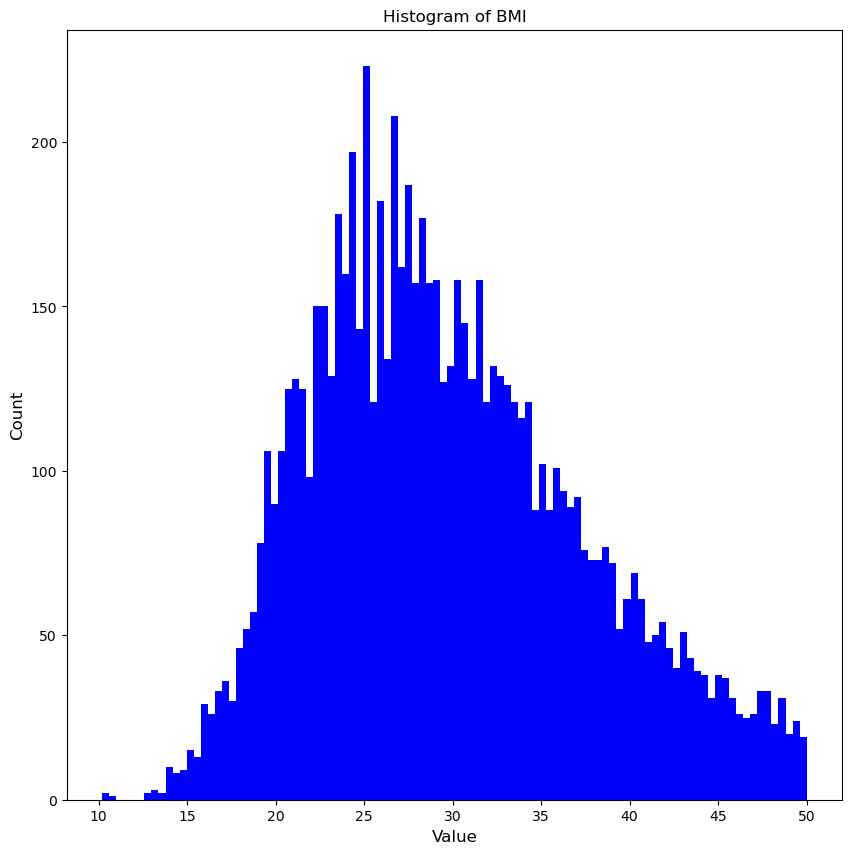

value_RR: 7639


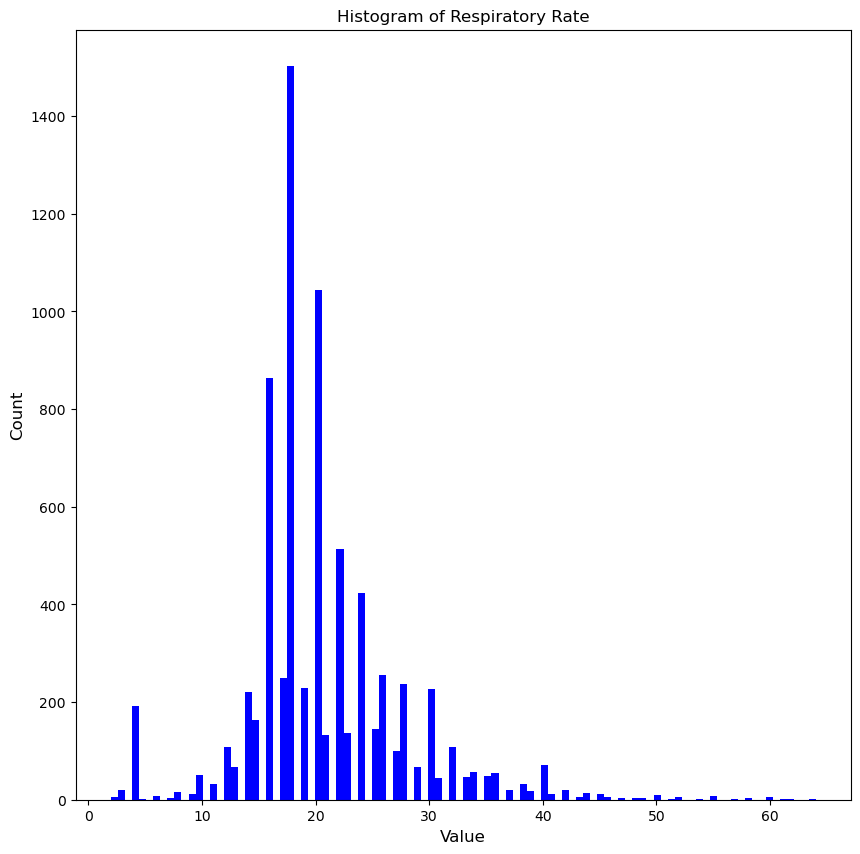

value_SysBP: 4876


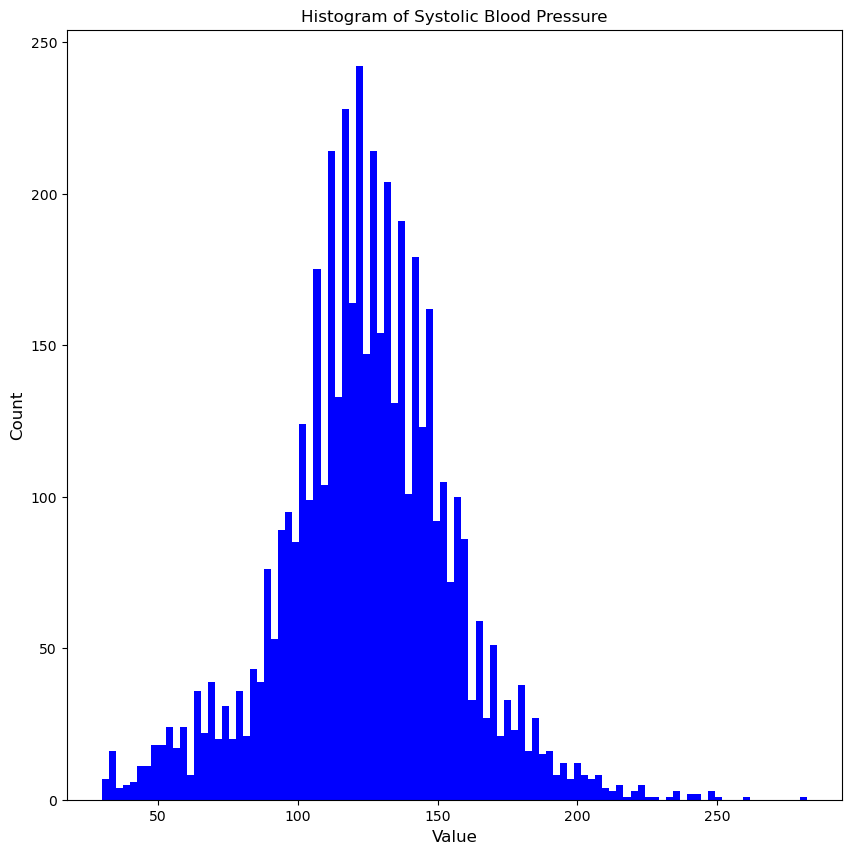

value_DiaBP: 4798


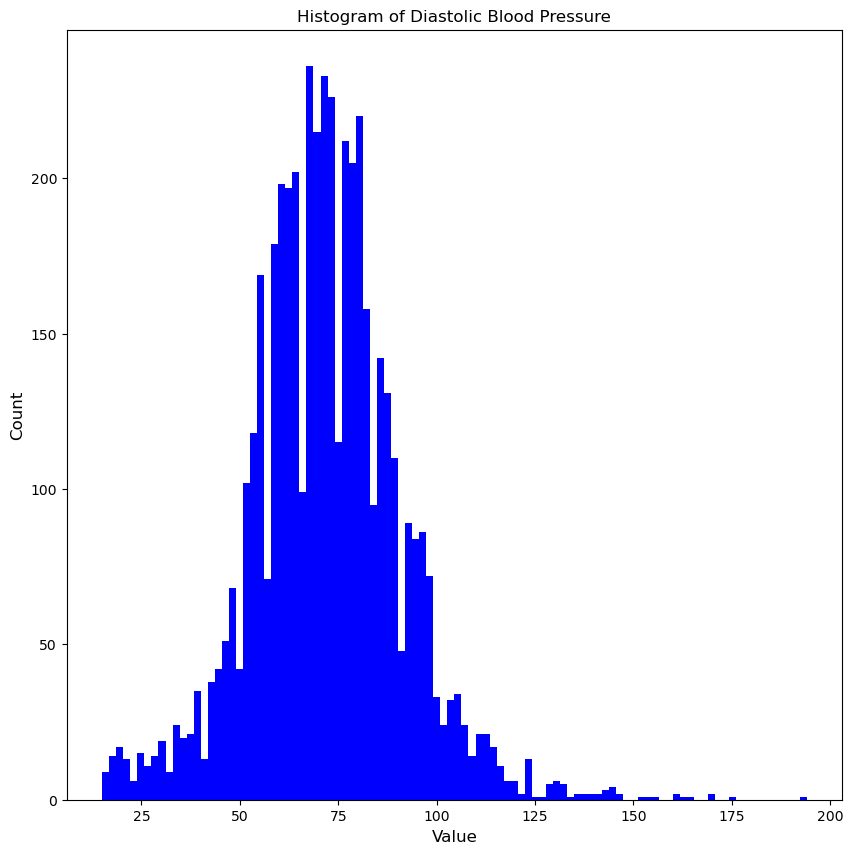

value_SPO2: 1586


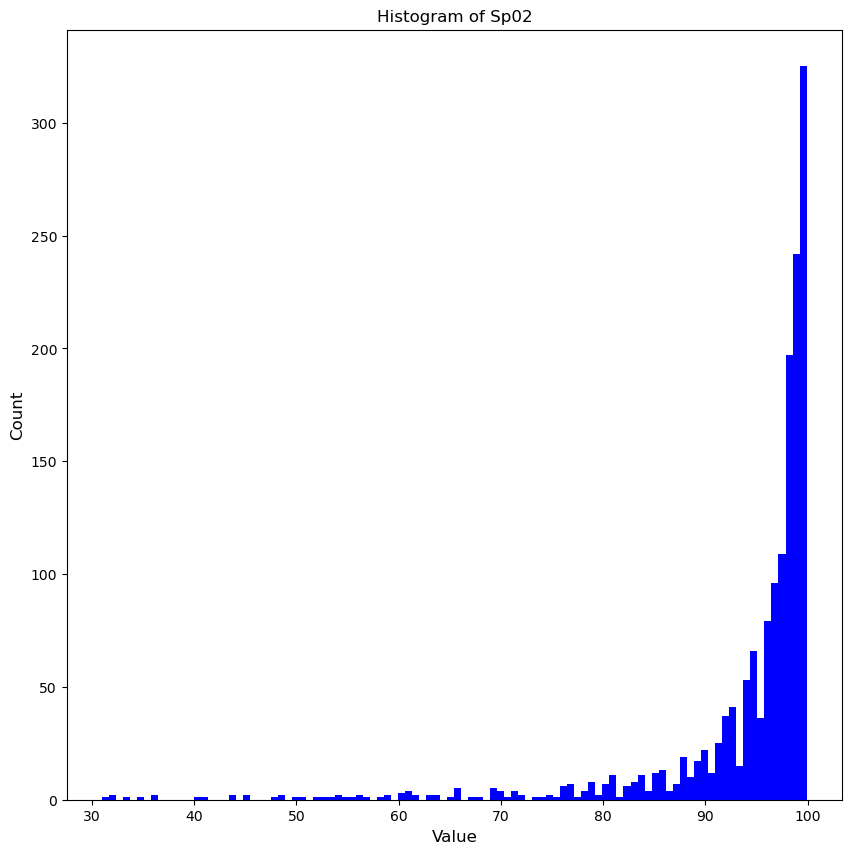

value_HR: 8147


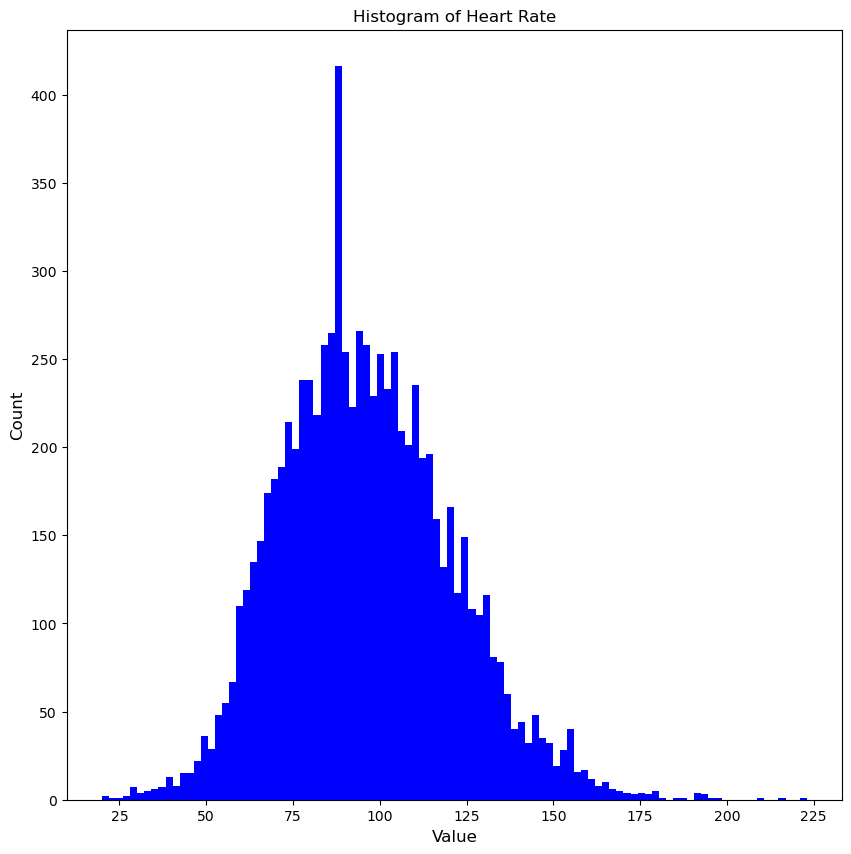

value_Weight: 11084


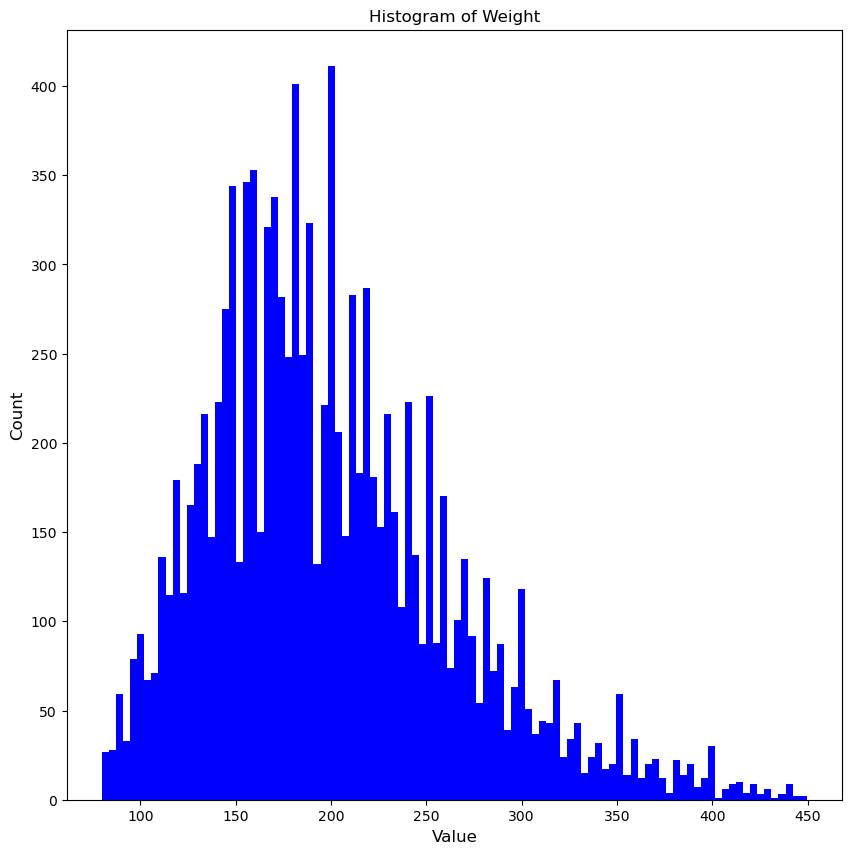

value_New_Temp: 1108


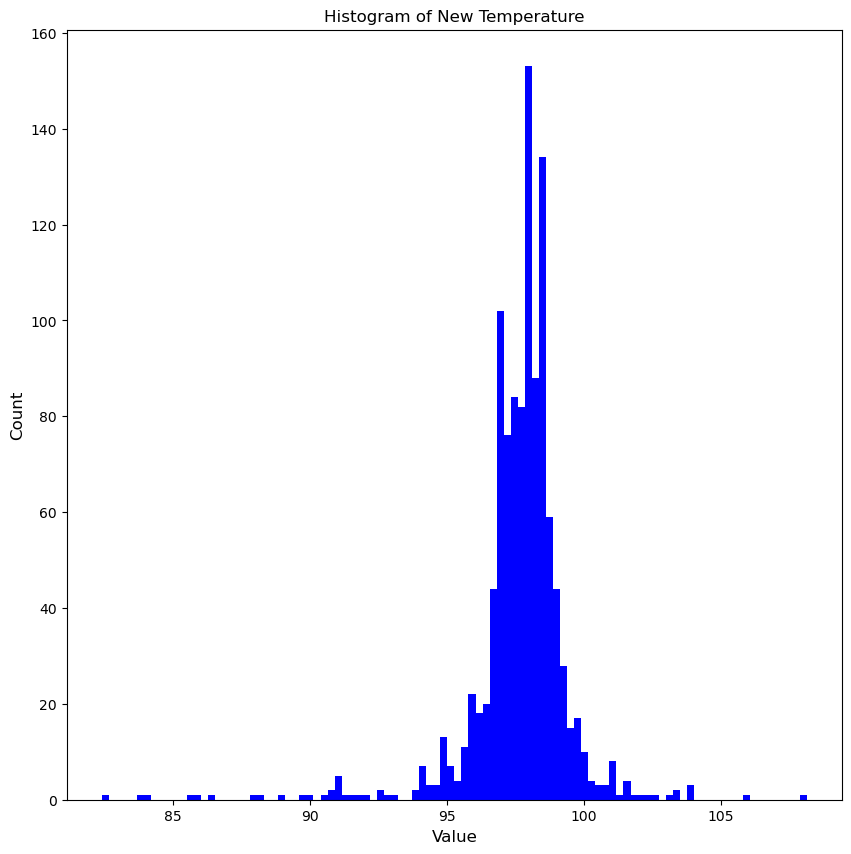

value_Height: 9993


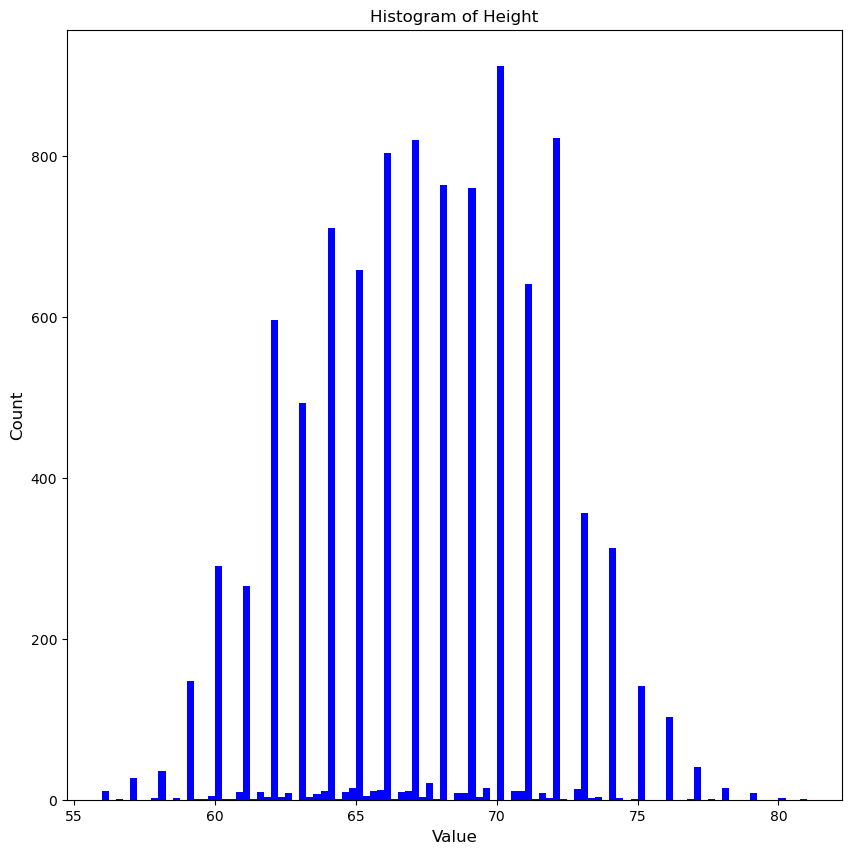

value_759878: 0


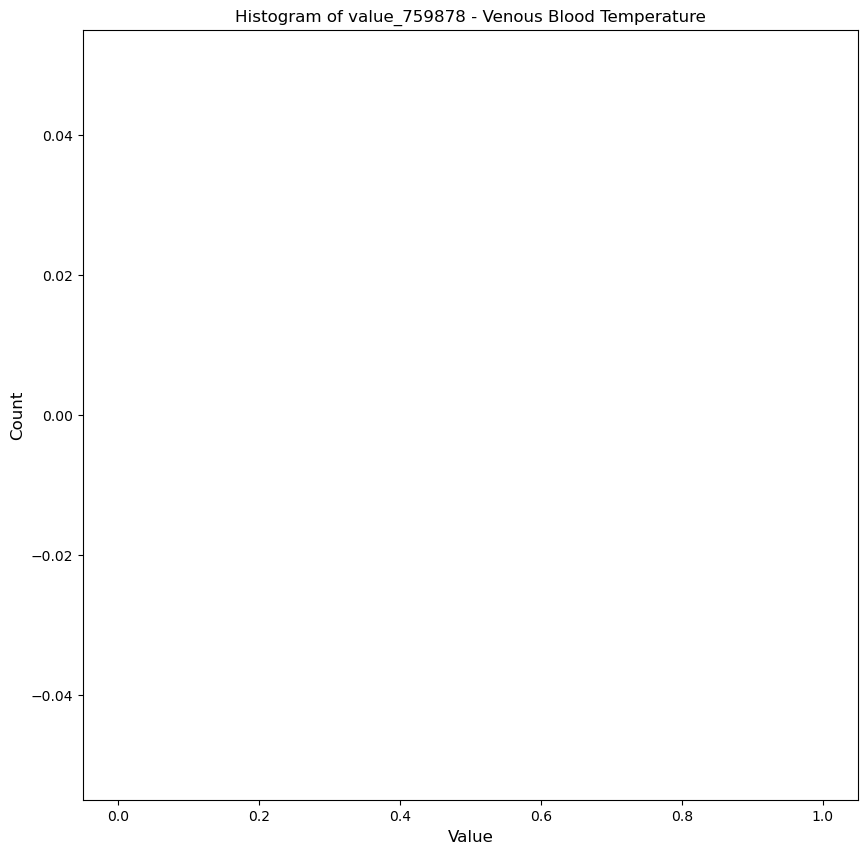

value_608356: 4


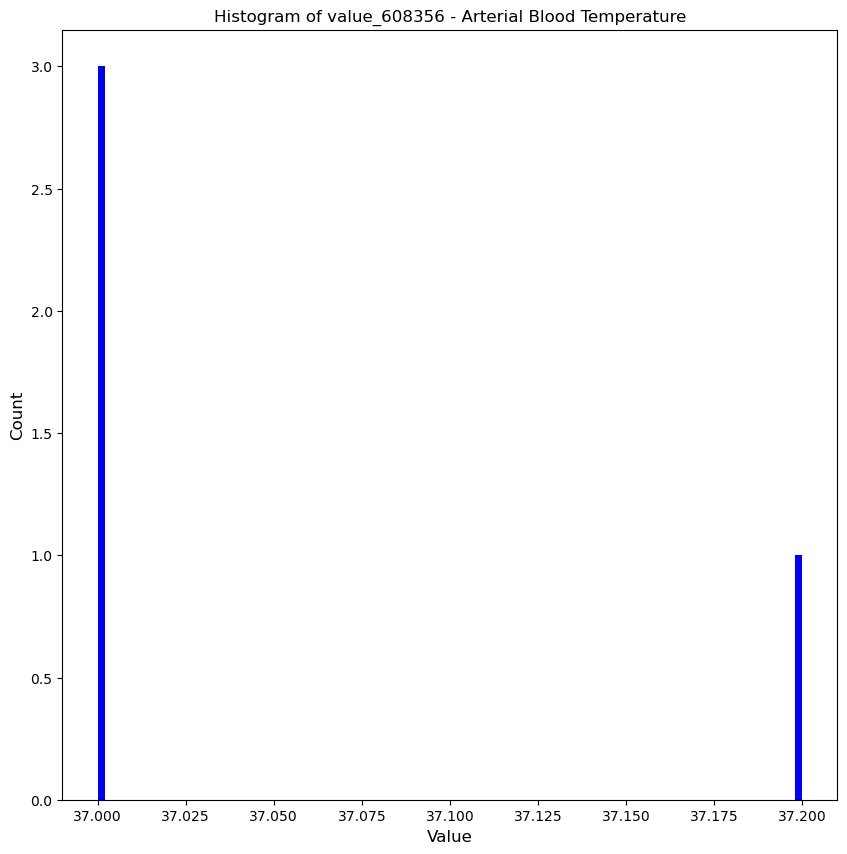

value_27110: 424


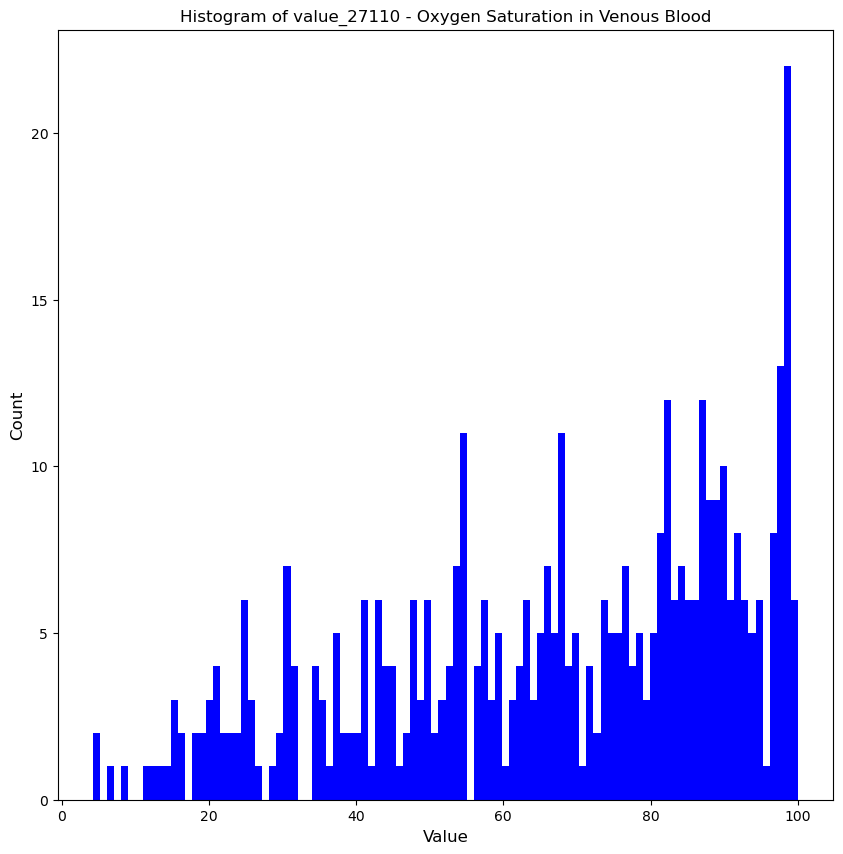

value_27086: 2738


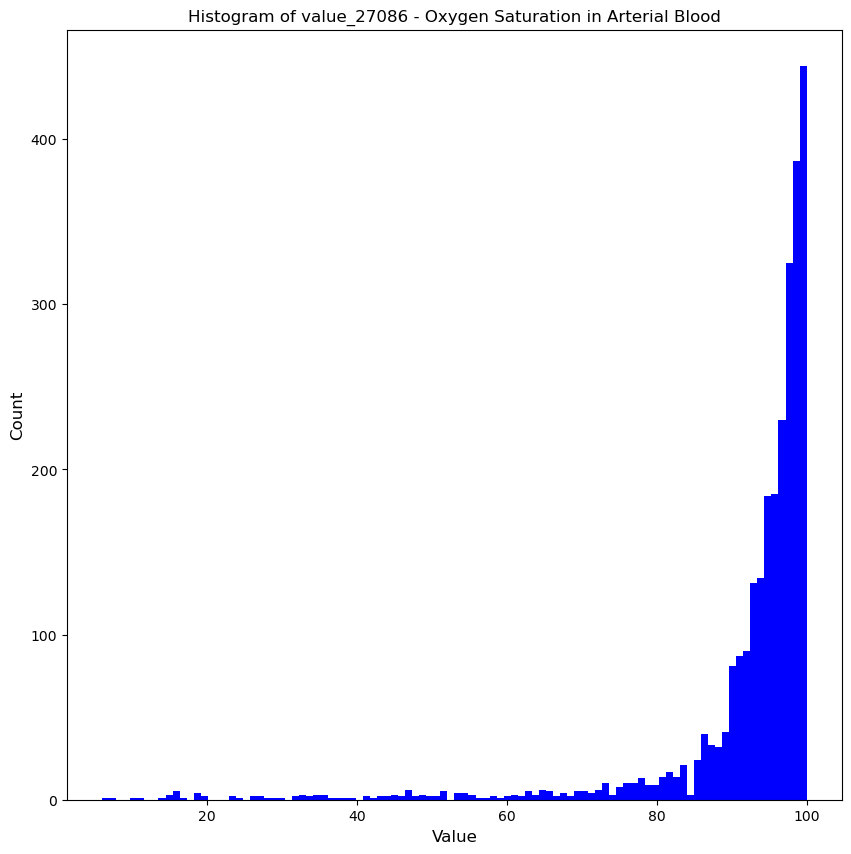

value_205641: 1469


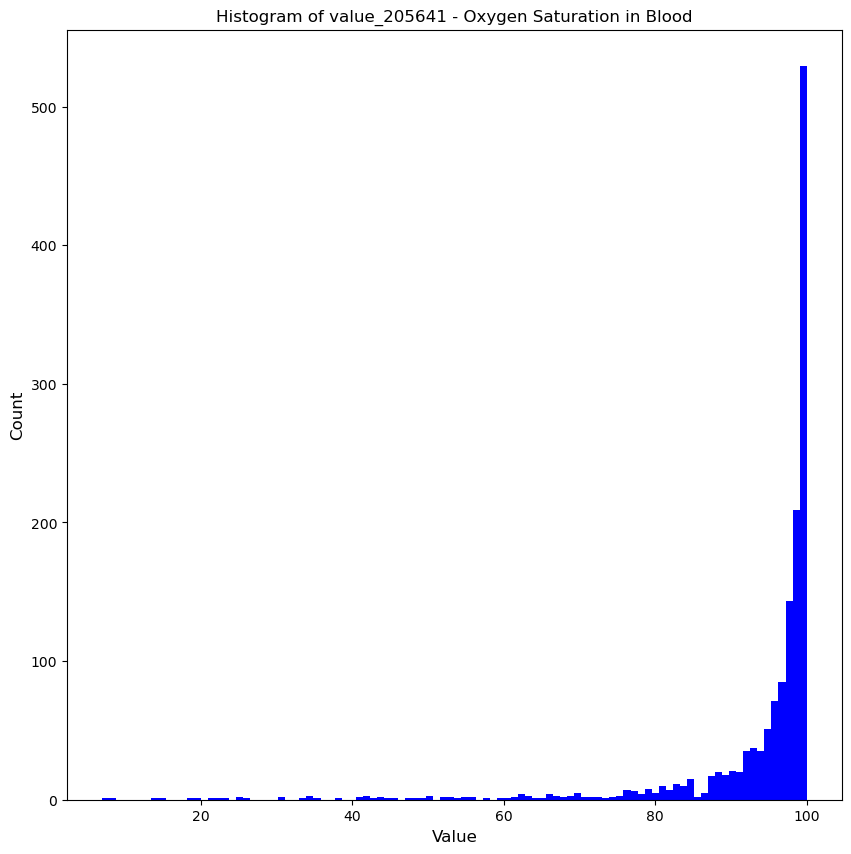

,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,patient_regional_location,...,date_759878,value_759878,date_608356,value_608356,date_27110,value_27110,date_27086,value_27086,date_205641,value_205641
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,2022-01,South,...,NaT,0.0,NaT,0.0,2022-01-01,21.000000,NaT,0.000000,NaT,0.0
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,,South,...,NaT,0.0,NaT,0.0,NaT,0.000000,NaT,0.000000,2022-01-01,80.0
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,2022-04,Northeast,...,NaT,0.0,NaT,0.0,2022-01-01,57.900002,NaT,0.000000,NaT,0.0
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,M,White,Not Hispanic or Latino,,Northeast,...,NaT,0.0,NaT,0.0,NaT,0.000000,2022-01-01,67.599998,NaT,0.0
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,F,White,Not Hispanic or Latino,,Midwest,...,NaT,0.0,NaT,0.0,NaT,0.000000,NaT,0.000000,NaT,0.0


(14207, 40)
137032
Executed in 0 hours, 8 minutes, and 48.14 seconds.


15516

In [8]:
# Vitals Signs:
# The first vital sign value recorded during the encounter of interest. 
# If the vital sign value occurred during the encounter of interest, include the value. Else, put a "0".

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

vs_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "date":str, 
                    "value":np.float32}

# These conversions are for more efficient merging. Drop_duplicates may be superfulous
#master_encounter_df = pd.DataFrame(master_encounter_list, columns=['encounter_id']).drop_duplicates()
#master_patient_df = pd.DataFrame(master_patient_list, columns=['patient_id']).drop_duplicates()

# 39156-5: BMI (kg/m2)
# Call in the "value_BMI" Dataframe
#value_BMI = pd.read_csv(working_dir + "value_BMI.csv", dtype = vs_d_type_spec)
# Filter out patients who are NOT in the master_patient_list
#value_BMI = value_BMI[value_BMI["patient_id"].isin(master_patient_list)]
#value_BMI = pd.merge(value_BMI, master_patient_df, on="patient_id", how="inner") #replaces: 
# Filter out patients who are NOT in the master_encounter list
#value_BMI = value_BMI[value_BMI["encounter_id"].isin(master_encounter_list)]
#value_BMI = pd.merge(value_BMI, master_encounter_df, on="encounter_id", how="inner") #replaces: 
#value_BMI = pd.merge(value_BMI, master_patient_df, on="patient_id", how="left", indicator=True)
#value_BMI = value_BMI[value_BMI['_merge'] == 'both'].drop(columns=['_merge'])
#value_BMI = pd.merge(value_BMI, master_encounter_df, on="encounter_id", how="left", indicator=True)
#value_BMI = value_BMI[value_BMI['_merge'] == 'both'].drop(columns=['_merge'])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_BMI.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    # chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    print(chunk.shape)
    filtered_chunks.append(chunk)
value_BMI = pd.concat(filtered_chunks)
#del filtered_chunks
value_BMI.reset_index(drop=True, inplace=True)
print(value_BMI.shape)
# The encounter of interest must occur on or before 01/01/2022
value_BMI["date"] = pd.to_datetime(value_BMI["date"], format='mixed')
value_BMI = value_BMI[value_BMI["date"] >= pd.to_datetime("20220101")]
# Sort values by date, and encouter_id in ascending order to find the first encounter on the first date
value_BMI = value_BMI.sort_values(by = ["date","encounter_id"], ascending = [True,False])
# Remove duplicate "encounter_ids"
value_BMI = value_BMI.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Sort values by date and patient_id in ascending order
value_BMI = value_BMI.sort_values(by = ["date","patient_id"], ascending = [True,False])
# Remove duplicate "patient_ids"
value_BMI = value_BMI.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop the "code", "patient_id", and "date" columns
value_BMI = value_BMI.drop(columns = ["code","patient_id"])
# Rename the "value" column to "value_BMI"; Rename the "data" columns to "BMI_date"
value_BMI = value_BMI.rename(columns = {"value":"value_BMI", "date":"date_BMI"})
print(value_BMI.shape)
print(value_BMI.head)
# Merge value_BMI with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_BMI, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill any NA/NAN values with "0" and convert to a float datatype
RFS_ABG_ENC_AMB["value_BMI"] = RFS_ABG_ENC_AMB["value_BMI"].fillna(0).astype(np.float32)
# Display how many patients met this critiera
print("value_BMI:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_BMI"] > 0]))
# Delete unused variable
del value_BMI

##### Histogram of BMI #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_BMI"] > 0]["value_BMI"], bins = 100, facecolor = "blue")
plt.title("Histogram of BMI", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 9279-1: Respiratory Rate (breaths/min) 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_RR.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_RR = pd.concat(filtered_chunks)
del filtered_chunks
value_RR.reset_index(drop=True, inplace=True)
#value_RR = pd.read_csv(working_dir + "value_RR.csv", dtype = vs_d_type_spec)
#value_RR["date"] = pd.to_datetime(value_RR["date"], format='mixed')
#value_RR = value_RR[value_RR["patient_id"].isin(master_patient_list)]
#value_RR = value_RR[value_RR["encounter_id"].isin(master_encounter_list)]
#value_RR = pd.merge(value_RR, master_patient_df, on="patient_id", how="inner") 
#value_RR = pd.merge(value_RR, master_encounter_df, on="encounter_id", how="inner") 
value_RR = value_RR[value_RR["date"] >= pd.to_datetime("20220101")]
value_RR = value_RR.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_RR = value_RR.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_RR = value_RR.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_RR = value_RR.drop_duplicates(subset = ["patient_id"], keep = "first")
value_RR = value_RR.drop(columns = ["code","patient_id"])
value_RR = value_RR.rename(columns = {"value":"value_RR", "date":"date_RR"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_RR, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_RR"] = RFS_ABG_ENC_AMB["value_RR"].fillna(0).astype(np.float32)
print("value_RR:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_RR"] > 0]))
del value_RR

##### Histogram of Respiratory Rate #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_RR"] > 0]["value_RR"], bins = 100, facecolor = "blue")
plt.title("Histogram of Respiratory Rate", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################
# Old temperature is superceded by new temperature  

"""
# 8310-5: Temperature (Fahrenheit)
value_Temp = pd.read_csv(working_dir + "value_Temp.csv", dtype = vs_d_type_spec)
value_Temp["date"] = pd.to_datetime(value_Temp["date"], format='mixed')
value_Temp = value_Temp[value_Temp["patient_id"].isin(master_patient_list)]
value_Temp = value_Temp[value_Temp["encounter_id"].isin(master_encounter_list)]
value_Temp = value_Temp[value_Temp["date"] >= pd.to_datetime("20220101")]
value_Temp = value_Temp.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_Temp = value_Temp.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_Temp = value_Temp.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_Temp = value_Temp.drop_duplicates(subset = ["patient_id"], keep = "first")
value_Temp = value_Temp.drop(columns = ["code","patient_id"])
value_Temp = value_Temp.rename(columns = {"value":"value_Temp","date":"date_Temp"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_Temp, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_Temp"] = RFS_ABG_ENC_AMB["value_Temp"].fillna(0).astype(np.float32)
print("value_Temp:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Temp"] > 0]))
del value_Temp


##### Histogram of Temperature #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Temp"] > 0]["value_Temp"], bins = 100, facecolor = "blue")
plt.title("Histogram of Temperature (F)", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()
"""

##############################

# 8480-6: Systolic Blood Pressure (mm[Hg]
#value_SysBP = pd.read_csv(working_dir + "value_SysBP.csv", dtype = vs_d_type_spec)
#value_SysBP["date"] = pd.to_datetime(value_SysBP["date"], format='mixed')
#value_SysBP = value_SysBP[value_SysBP["patient_id"].isin(master_patient_list)]
#value_SysBP = value_SysBP[value_SysBP["encounter_id"].isin(master_encounter_list)]
#value_SysBP = pd.merge(value_SysBP, master_patient_df, on="patient_id", how="inner") 
#value_SysBP = pd.merge(value_SysBP, master_encounter_df, on="encounter_id", how="inner") 
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_SysBP.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]    
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_SysBP = pd.concat(filtered_chunks)
del filtered_chunks
value_SysBP.reset_index(drop=True, inplace=True)

value_SysBP = value_SysBP[value_SysBP["date"] >= pd.to_datetime("20220101")]
value_SysBP = value_SysBP.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_SysBP = value_SysBP.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_SysBP = value_SysBP.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_SysBP = value_SysBP.drop_duplicates(subset = ["patient_id"], keep = "first")
value_SysBP = value_SysBP.drop(columns = ["code","patient_id"])
value_SysBP = value_SysBP.rename(columns = {"value":"value_SysBP","date":"date_SysBP"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_SysBP, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_SysBP"] = RFS_ABG_ENC_AMB["value_SysBP"].fillna(0).astype(np.float32)
print("value_SysBP:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_SysBP"] > 0]))
del value_SysBP

##### Histogram of Systolic Blood Pressure #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_SysBP"] > 0]["value_SysBP"], bins = 100, facecolor = "blue")
plt.title("Histogram of Systolic Blood Pressure", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 8462-4: Diastolic Blood Pressure (mm[Hg]
#value_DiaBP = pd.read_csv(working_dir + "value_DiaBP.csv", dtype = vs_d_type_spec)
#value_DiaBP["date"] = pd.to_datetime(value_DiaBP["date"], format='mixed')
#value_DiaBP = value_DiaBP[value_DiaBP["patient_id"].isin(master_patient_list)]
#value_DiaBP = value_DiaBP[value_DiaBP["encounter_id"].isin(master_encounter_list)]
#value_DiaBP = pd.merge(value_DiaBP, master_patient_df, on="patient_id", how="inner") 
#value_DiaBP = pd.merge(value_DiaBP, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_DiaBP.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_DiaBP = pd.concat(filtered_chunks)
del filtered_chunks
value_DiaBP.reset_index(drop=True, inplace=True)
value_DiaBP = value_DiaBP[value_DiaBP["date"] >= pd.to_datetime("20220101")]
value_DiaBP = value_DiaBP.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_DiaBP = value_DiaBP.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_DiaBP = value_DiaBP.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_DiaBP = value_DiaBP.drop_duplicates(subset = ["patient_id"], keep = "first")
value_DiaBP = value_DiaBP.drop(columns = ["code","patient_id"])
value_DiaBP = value_DiaBP.rename(columns = {"value":"value_DiaBP","date":"date_DiaBP"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_DiaBP, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_DiaBP"] = RFS_ABG_ENC_AMB["value_DiaBP"].fillna(0).astype(np.float32)
print("value_DiaBP:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_DiaBP"] > 0]))
del value_DiaBP

##### Histogram of Diastolic Blood Pressure #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_DiaBP"] > 0]["value_DiaBP"], bins = 100, facecolor = "blue")
plt.title("Histogram of Diastolic Blood Pressure", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# SpO2 - 59408-5 Pulse Oximetry; 20564-1 Oxygen saturation in Blood
#value_SPO2 = pd.read_csv(working_dir + "value_SPO2.csv", dtype = vs_d_type_spec)
#value_SPO2["date"] = pd.to_datetime(value_SPO2["date"], format='mixed')
#value_SPO2 = value_SPO2[value_SPO2["patient_id"].isin(master_patient_list)]
#value_SPO2 = value_SPO2[value_SPO2["encounter_id"].isin(master_encounter_list)]
#value_SPO2 = pd.merge(value_SPO2, master_patient_df, on="patient_id", how="inner") 
#value_SPO2 = pd.merge(value_SPO2, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_SPO2.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_SPO2 = pd.concat(filtered_chunks)
del filtered_chunks
value_SPO2.reset_index(drop=True, inplace=True)

value_SPO2 = value_SPO2[value_SPO2["date"] >= pd.to_datetime("20220101")]
value_SPO2 = value_SPO2.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_SPO2 = value_SPO2.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_SPO2 = value_SPO2.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_SPO2 = value_SPO2.drop_duplicates(subset = ["patient_id"], keep = "first")
value_SPO2 = value_SPO2.drop(columns = ["code","patient_id"])
value_SPO2 = value_SPO2.rename(columns = {"value":"value_SPO2","date":"date_SPO2"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_SPO2, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_SPO2"] = RFS_ABG_ENC_AMB["value_SPO2"].fillna(0).astype(np.float32)
print("value_SPO2:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_SPO2"] > 0]))
del value_SPO2

##### Histogram of SpO2 #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_SPO2"] > 0]["value_SPO2"], bins = 100, facecolor = "blue")
plt.title("Histogram of Sp02", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Heart Rate - 8893-0 Heart rate Peripheral artery by palpation; 8867-4 Heart rate
#value_HR = pd.read_csv(working_dir + "value_HR.csv", dtype = vs_d_type_spec)
#value_HR["date"] = pd.to_datetime(value_HR["date"], format='mixed')
#value_HR = value_HR[value_HR["patient_id"].isin(master_patient_list)]
#value_HR = value_HR[value_HR["encounter_id"].isin(master_encounter_list)]
#value_HR = pd.merge(value_HR, master_patient_df, on="patient_id", how="inner") 
#value_HR = pd.merge(value_HR, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_HR.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_HR = pd.concat(filtered_chunks)
del filtered_chunks
value_HR.reset_index(drop=True, inplace=True)

value_HR = value_HR[value_HR["date"] >= pd.to_datetime("20220101")]
value_HR = value_HR.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_HR = value_HR.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_HR = value_HR.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_HR = value_HR.drop_duplicates(subset = ["patient_id"], keep = "first")
value_HR = value_HR.drop(columns = ["code","patient_id"])
value_HR = value_HR.rename(columns = {"value":"value_HR","date":"date_HR"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_HR, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_HR"] = RFS_ABG_ENC_AMB["value_HR"].fillna(0).astype(np.float32)
print("value_HR:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_HR"] > 0]))
del value_HR

##### Histogram of Heart Rate #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_HR"] > 0]["value_HR"], bins = 100, facecolor = "blue")
plt.title("Histogram of Heart Rate", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Weight
# 29463-7: Body weight (kg)
# 3141-9: Body Weight Measured (kg)
# 3142-7: Body weight Stated (kg)
# 8335-2: Body weight Estimated (kg)
#value_Weight = pd.read_csv(working_dir + "value_Weight.csv", dtype = vs_d_type_spec)
#value_Weight["date"] = pd.to_datetime(value_Weight["date"], format='mixed')
#value_Weight = value_Weight[value_Weight["patient_id"].isin(master_patient_list)]
#value_Weight = value_Weight[value_Weight["encounter_id"].isin(master_encounter_list)]
#value_Weight = pd.merge(value_Weight, master_patient_df, on="patient_id", how="inner") 
#value_Weight = pd.merge(value_Weight, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_Weight.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_Weight = pd.concat(filtered_chunks)
del filtered_chunks
value_Weight.reset_index(drop=True, inplace=True)

value_Weight = value_Weight[value_Weight["date"] >= pd.to_datetime("20220101")]
value_Weight = value_Weight.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_Weight = value_Weight.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_Weight = value_Weight.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_Weight = value_Weight.drop_duplicates(subset = ["patient_id"], keep = "first")
value_Weight = value_Weight.drop(columns = ["code","patient_id"])
value_Weight = value_Weight.rename(columns = {"value":"value_Weight","date":"date_Weight"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_Weight, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_Weight"] = RFS_ABG_ENC_AMB["value_Weight"].fillna(0).astype(np.float32)
print("value_Weight:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Weight"] > 0]))
del value_Weight

##### Histogram of Weight #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Weight"] > 0]["value_Weight"], bins = 100, facecolor = "blue")
plt.title("Histogram of Weight", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# New Temperature
# 8310-5: Body Temperature (F)
# 8331-1: Oral Temperature (F)
# 75539-7: Body temperature - Temporal artery (F)
# 8333-7: Tympanic Membrane Temperature (F)
#value_New_Temp = pd.read_csv(working_dir + "value_New_Temp.csv", dtype = vs_d_type_spec)
#value_New_Temp["date"] = pd.to_datetime(value_New_Temp["date"], format='mixed')
#value_New_Temp = value_New_Temp[value_New_Temp["patient_id"].isin(master_patient_list)]
#value_New_Temp = value_New_Temp[value_New_Temp["encounter_id"].isin(master_encounter_list)]
#value_New_Temp = pd.merge(value_New_Temp, master_patient_df, on="patient_id", how="inner") 
#value_New_Temp = pd.merge(value_New_Temp, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_New_Temp.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_New_Temp = pd.concat(filtered_chunks)
del filtered_chunks
value_New_Temp.reset_index(drop=True, inplace=True)

value_New_Temp = value_New_Temp[value_New_Temp["date"] >= pd.to_datetime("20220101")]
value_New_Temp = value_New_Temp.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_New_Temp = value_New_Temp.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_New_Temp = value_New_Temp.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_New_Temp = value_New_Temp.drop_duplicates(subset = ["patient_id"], keep = "first")
value_New_Temp = value_New_Temp.drop(columns = ["code","patient_id"])
value_New_Temp = value_New_Temp.rename(columns = {"value":"value_New_Temp","date":"date_New_Temp"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_New_Temp, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_New_Temp"] = RFS_ABG_ENC_AMB["value_New_Temp"].fillna(0).astype(np.float32)
print("value_New_Temp:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_New_Temp"] > 0]))
del value_New_Temp

##### Histogram of New Temperature #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_New_Temp"] > 0]["value_New_Temp"], bins = 100, facecolor = "blue")
plt.title("Histogram of New Temperature", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Height
# LOINC: 8302-2 - Body Height
#value_Height = pd.read_csv(working_dir + "value_Height.csv", dtype = vs_d_type_spec)
#value_Height["date"] = pd.to_datetime(value_Height["date"], format='mixed')
#value_Height = value_Height[value_Height["patient_id"].isin(master_patient_list)]
#value_Height = value_Height[value_Height["encounter_id"].isin(master_encounter_list)]
#value_Height = pd.merge(value_Height, master_patient_df, on="patient_id", how="inner") 
#value_Height = pd.merge(value_Height, master_encounter_df, on="encounter_id", how="inner") 

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_Height.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
value_Height = pd.concat(filtered_chunks)
del filtered_chunks
value_Height.reset_index(drop=True, inplace=True)

value_Height = value_Height[value_Height["date"] >= pd.to_datetime("20220101")]
value_Height = value_Height.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_Height = value_Height.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_Height = value_Height.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_Height = value_Height.drop_duplicates(subset = ["patient_id"], keep = "first")
value_Height = value_Height.drop(columns = ["code","patient_id"])
value_Height = value_Height.rename(columns = {"value":"value_Height","date":"date_Height"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_Height, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_Height"] = RFS_ABG_ENC_AMB["value_Height"].fillna(0).astype(np.float32)
print("value_Height:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Height"] > 0]))
del value_Height

##### Histogram of Height #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Height"] > 0]["value_Height"], bins = 100, facecolor = "blue")
plt.title("Histogram of Height", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 75987-8: Venous Blood Temperature
value_759878 = pd.read_csv(working_dir + "value_759878.csv", dtype = vs_d_type_spec)
value_759878["date"] = pd.to_datetime(value_759878["date"], format='mixed')
value_759878 = value_759878[value_759878["patient_id"].isin(master_patient_list)]
value_759878 = value_759878[value_759878["encounter_id"].isin(master_encounter_list)]
#value_759878 = pd.merge(value_759878, master_patient_df, on="patient_id", how="inner") 
#value_759878 = pd.merge(value_759878, master_encounter_df, on="encounter_id", how="inner") 
value_759878 = value_759878[value_759878["date"] >= pd.to_datetime("20220101")]
value_759878 = value_759878.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_759878 = value_759878.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_759878 = value_759878.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_759878 = value_759878.drop_duplicates(subset = ["patient_id"], keep = "first")
value_759878 = value_759878.drop(columns = ["code","patient_id"])
value_759878 = value_759878.rename(columns = {"value":"value_759878","date":"date_759878"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_759878, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_759878"] = RFS_ABG_ENC_AMB["value_759878"].fillna(0).astype(np.float32)
print("value_759878:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_759878"] > 0]))
del value_759878

##### Histogram of Venous Blood Temperature #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_759878"] > 0]["value_759878"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_759878 - Venous Blood Temperature", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 60835-6: Arterial Blood Temperature
value_608356 = pd.read_csv(working_dir + "value_608356.csv", dtype = vs_d_type_spec)
value_608356["date"] = pd.to_datetime(value_608356["date"], format='mixed')
value_608356 = value_608356[value_608356["patient_id"].isin(master_patient_list)]
value_608356 = value_608356[value_608356["encounter_id"].isin(master_encounter_list)]
#value_608356 = pd.merge(value_608356, master_patient_df, on="patient_id", how="inner") 
#value_608356 = pd.merge(value_608356, master_encounter_df, on="encounter_id", how="inner") 
value_608356 = value_608356[value_608356["date"] >= pd.to_datetime("20220101")]
value_608356 = value_608356.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_608356 = value_608356.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_608356 = value_608356.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_608356 = value_608356.drop_duplicates(subset = ["patient_id"], keep = "first")
value_608356 = value_608356.drop(columns = ["code","patient_id"])
value_608356 = value_608356.rename(columns = {"value":"value_608356","date":"date_608356"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_608356, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_608356"] = RFS_ABG_ENC_AMB["value_608356"].fillna(0).astype(np.float32)
print("value_608356:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_608356"] > 0]))
del value_608356

##### Histogram of Arterial Blood Temperature #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_608356"] > 0]["value_608356"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_608356 - Arterial Blood Temperature", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2711-0: Oxygen Saturation in Venous Blood
value_27110 = pd.read_csv(working_dir + "value_27110.csv", dtype = vs_d_type_spec)
value_27110["date"] = pd.to_datetime(value_27110 ["date"], format='mixed')
value_27110 = value_27110[value_27110["patient_id"].isin(master_patient_list)]
value_27110 = value_27110[value_27110["encounter_id"].isin(master_encounter_list)]
#value_27110 = pd.merge(value_27110, master_patient_df, on="patient_id", how="inner") 
#value_27110 = pd.merge(value_27110, master_encounter_df, on="encounter_id", how="inner") 
value_27110 = value_27110[value_27110["date"] >= pd.to_datetime("20220101")]
value_27110 = value_27110.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27110 = value_27110.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27110 = value_27110.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27110 = value_27110.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27110 = value_27110.drop(columns = ["code","patient_id"])
value_27110 = value_27110.rename(columns = {"value":"value_27110","date":"date_27110"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27110, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27110"] = RFS_ABG_ENC_AMB["value_27110"].fillna(0).astype(np.float32)
print("value_27110:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27110"] > 0]))
del value_27110

##### Histogram of Oxygen Saturation in Venous Blood #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27110"] > 0]["value_27110"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27110 - Oxygen Saturation in Venous Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2708-6: Oxygen Saturation in Arterial Blood
value_27086 = pd.read_csv(working_dir + "value_27086.csv", dtype = vs_d_type_spec)
value_27086["date"] = pd.to_datetime(value_27086["date"], format='mixed')
value_27086 = value_27086[value_27086["patient_id"].isin(master_patient_list)]
value_27086 = value_27086[value_27086["encounter_id"].isin(master_encounter_list)]
#value_27086 = pd.merge(value_27086, master_patient_df, on="patient_id", how="inner") 
#value_27086 = pd.merge(value_27086, master_encounter_df, on="encounter_id", how="inner") 
value_27086 = value_27086[value_27086["date"] >= pd.to_datetime("20220101")]
value_27086 = value_27086.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27086 = value_27086.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27086 = value_27086.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27086 = value_27086.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27086 = value_27086.drop(columns = ["code","patient_id"])
value_27086 = value_27086.rename(columns = {"value":"value_27086","date":"date_27086"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27086, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27086"] = RFS_ABG_ENC_AMB["value_27086"].fillna(0).astype(np.float32)
print("value_27086:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27086"] > 0]))
del value_27086

##### Histogram of Oxygen Saturation in Arterial Blood #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27086"] > 0]["value_27086"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27086 - Oxygen Saturation in Arterial Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 20564-1: Oxygen Saturation in Blood
value_205641 = pd.read_csv(working_dir + "value_205641.csv", dtype = vs_d_type_spec)
value_205641["date"] = pd.to_datetime(value_205641["date"], format='mixed')
value_205641 = value_205641[value_205641["patient_id"].isin(master_patient_list)]
value_205641 = value_205641[value_205641["encounter_id"].isin(master_encounter_list)]
#value_205641 = pd.merge(value_205641, master_patient_df, on="patient_id", how="inner") 
#value_205641 = pd.merge(value_205641, master_encounter_df, on="encounter_id", how="inner") 
value_205641 = value_205641[value_205641["date"] >= pd.to_datetime("20220101")]
value_205641 = value_205641.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_205641 = value_205641.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_205641 = value_205641.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_205641 = value_205641.drop_duplicates(subset = ["patient_id"], keep = "first")
value_205641 = value_205641.drop(columns = ["code","patient_id"])
value_205641 = value_205641.rename(columns = {"value":"value_205641","date":"date_205641"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_205641, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_205641"] = RFS_ABG_ENC_AMB["value_205641"].fillna(0).astype(np.float32)
print("value_205641:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_205641"] > 0]))
del value_205641

##### Histogram of Oxygen Saturation in Blood #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_205641"] > 0]["value_205641"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_205641 - Oxygen Saturation in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()


##############################

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

# Demographics and Social Variables

In [9]:
# Demographics & Social Variables:
# Sex: (M/F): Female = 0 ; Male = 1 ; Unknown = 2
# Race: "White" = 0 ; "Black or African American" = 1 ; "Unknown" = 2 ; "Asian" = 3 ; "American Indian or Alaska Native" = 4; "Native Hawaiian or Other Pacific Islander" = 5
# Ethnicity: "Not Hispanic or Latino" = 0 ; "Hispanic or Latino" = 1 ; "Unknown" = 2
# Location: "South" = 0 ; "Northeast" = 1 ; "Midwest" = 2 ; "West" = 3

##############################
start_time = time.time()
# Sex:
RFS_ABG_ENC_AMB["sex"] = RFS_ABG_ENC_AMB["sex"].replace(["F","M","Unknown"],[0,1,2])
# Race:
RFS_ABG_ENC_AMB["race"] = RFS_ABG_ENC_AMB["race"].replace(["White","Black or African American","Unknown","Asian","American Indian or Alaska Native","Native Hawaiian or Other Pacific Islander"],[0,1,2,3,4,5])
# Ethnicity:
RFS_ABG_ENC_AMB["ethnicity"] = RFS_ABG_ENC_AMB["ethnicity"].replace(["Not Hispanic or Latino","Hispanic or Latino","Unknown"],[0,1,2])
# Location:
RFS_ABG_ENC_AMB["patient_regional_location"] = RFS_ABG_ENC_AMB["patient_regional_location"].replace(["South","Northeast","Midwest","West"],[0,1,2,3])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.rename(columns = {"patient_regional_location":"location"})
RFS_ABG_ENC_AMB = convert_32_dtypes(RFS_ABG_ENC_AMB)
print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,date_759878,value_759878,date_608356,value_608356,date_27110,value_27110,date_27086,value_27086,date_205641,value_205641
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0.0,NaT,0.0,2022-01-01,21.000000,NaT,0.000000,NaT,0.0
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,NaT,0.0,NaT,0.0,NaT,0.000000,NaT,0.000000,2022-01-01,80.0
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,0.0,NaT,0.0,2022-01-01,57.900002,NaT,0.000000,NaT,0.0
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0.0,NaT,0.0,NaT,0.000000,2022-01-01,67.599998,NaT,0.0
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0.0,NaT,0.0,NaT,0.000000,NaT,0.000000,NaT,0.0


(14207, 40)
137032
Executed in 0 hours, 0 minutes, and 0.02 seconds.


0

# Previous Vital Signs

In [10]:
# Previous Vital Signs:
# "Yes"/1 = Vital sign was recorded immediately prior to the encounter of interest.
# "No"/0 = Vital sign was not recorded, or did not occur immediately prior to the encounter of interest.  
# We should not consider the "master_encounter_list" as these vital signs occurred BEFORE the patient met inclusion criteria found in the "master_encounter_list" list.

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

# Previous Weight
# 29463-7: Body weight (lbs)
# 3141-9: Body Weight Measured (lbs)
# 3142-7: Body weight Stated (lbs)
# 8335-2: Body weight Estimated (lbs)

vs_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "date":str, 
                    "value":np.float32}

# These conversions are for more efficient merging. Drop_duplicates may be superfulous
master_encounter_df = pd.DataFrame(master_encounter_list, columns=['encounter_id']).drop_duplicates()
master_patient_df = pd.DataFrame(master_patient_list, columns=['patient_id']).drop_duplicates()

# Call in the "value_Weight" Dataframe
#Prev_Weight = pd.read_csv(working_dir + "value_Weight.csv", dtype = vs_d_type_spec)
# Filter out patients who are NOT in the master_patient_list
#Prev_Weight = Prev_Weight[Prev_Weight["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter list
#Prev_Weight = Prev_Weight[~Prev_Weight["encounter_id"].isin(master_encounter_list)] # Is NOT in master_encounter_list

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_Weight.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
Prev_Weight = pd.concat(filtered_chunks)
del filtered_chunks
Prev_Weight.reset_index(drop=True, inplace=True)

Prev_Weight["date"] = pd.to_datetime(Prev_Weight["date"], format='mixed')
# Sort values by date, and encouter_id in ascending order to find the first encounter on the first date
Prev_Weight = Prev_Weight.sort_values(by = ["date","encounter_id"], ascending = [True,False]) # Earliest encounter_id date
# Remove duplicate "encounter_ids"
Prev_Weight = Prev_Weight.drop_duplicates(subset = ["encounter_id"], keep = "last") # Drop duplicate encounter_ids and keep the latest (closest to the encounter of interest)
# Remove duplicate "patient_ids"
Prev_Weight = Prev_Weight.drop_duplicates(subset = ["patient_id"], keep = "last") # Drop duplicate patient_ids and keep the latest
# Drop the "code", "patient_id", and "date" columns
Prev_Weight = Prev_Weight.drop(columns = ["encounter_id","code"])
# Merge Prev_Weight with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(Prev_Weight, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
# For the "date_Prev_Weight" column, keep only the vital sign dates that occur BEFORE the encounter of interest "qualify_date"
RFS_ABG_ENC_AMB["date_Prev_Weight"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] < RFS_ABG_ENC_AMB["qualify_date"], "date"]
# For the "value" column, replace the vital sign value with "0" if the vital sign date occurred AFTER the encounter of interest "qualify_date"
RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date_Prev_Weight"].isnull(), "value"] = 0
# Rename the columns
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.rename(columns = {"value":"value_Prev_Weight"})
# Fill any NA/NAN values with "0" and convert to an integer datatype
RFS_ABG_ENC_AMB["value_Prev_Weight"] = RFS_ABG_ENC_AMB["value_Prev_Weight"].fillna(0).astype(np.int32)
# Drop unused "date" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
# Display how many patients met this critiera
print("value_Prev_Weight:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Prev_Weight"] > 0]))
# Delete unused variable
del Prev_Weight

##############################

# Previous Height
# 8302-2: Body Height (inches)
#Prev_Height = pd.read_csv(working_dir + "value_Height.csv", dtype = vs_d_type_spec)
#
#Prev_Height = Prev_Height[Prev_Height["patient_id"].isin(master_patient_list)]
#Prev_Height = Prev_Height[~Prev_Height["encounter_id"].isin(master_encounter_list)] # Is NOT in master_encounter_list

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_Height.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
Prev_Height = pd.concat(filtered_chunks)
del filtered_chunks
Prev_Height.reset_index(drop=True, inplace=True)
Prev_Height["date"] = pd.to_datetime(Prev_Height["date"], format='mixed')
Prev_Height = Prev_Height.sort_values(by = ["date","encounter_id"], ascending = [True,False]) # Earliest encounter_id date
Prev_Height = Prev_Height.drop_duplicates(subset = ["encounter_id"], keep = "last") # Drop duplicate encounter_ids and keep the latest (closest to the encounter of interest)
Prev_Height = Prev_Height.drop_duplicates(subset = ["patient_id"], keep = "last") # Drop duplicate patient_ids and keep the latest
Prev_Height = Prev_Height.drop(columns = ["encounter_id","code"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(Prev_Height, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["date_Prev_Height"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] < RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date_Prev_Height"].isnull(), "value"] = 0
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.rename(columns = {"value":"value_Prev_Height"})
RFS_ABG_ENC_AMB["value_Prev_Height"] = RFS_ABG_ENC_AMB["value_Prev_Height"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("value_Prev_Height:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Prev_Height"] > 0]))
del Prev_Height

##############################

# Previous BMI
# 39156-5: BMI (kg/m2)
#Prev_BMI = pd.read_csv(working_dir + "value_BMI.csv", dtype = vs_d_type_spec)

#Prev_BMI = Prev_BMI[Prev_BMI["patient_id"].isin(master_patient_list)]
#Prev_BMI = Prev_BMI[~Prev_BMI["encounter_id"].isin(master_encounter_list)] # Is NOT in master_encounter_list

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "value_BMI.csv", dtype=vs_d_type_spec, chunksize=10000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
Prev_BMI = pd.concat(filtered_chunks)
del filtered_chunks
Prev_BMI.reset_index(drop=True, inplace=True)
Prev_BMI["date"] = pd.to_datetime(Prev_BMI["date"], format='mixed')
Prev_BMI = Prev_BMI.sort_values(by = ["date","encounter_id"], ascending = [True,False]) # Earliest encounter_id date
Prev_BMI = Prev_BMI.drop_duplicates(subset = ["encounter_id"], keep = "last") # Drop duplicate encounter_ids and keep the latest (closest to the encounter of interest)
Prev_BMI = Prev_BMI.drop_duplicates(subset = ["patient_id"], keep = "last") # Drop duplicate patient_ids and keep the latest
Prev_BMI = Prev_BMI.drop(columns = ["encounter_id","code"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(Prev_BMI, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["date_Prev_BMI"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] < RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date_Prev_BMI"].isnull(), "value"] = 0
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.rename(columns = {"value":"value_Prev_BMI"})
RFS_ABG_ENC_AMB["value_Prev_BMI"] = RFS_ABG_ENC_AMB["value_Prev_BMI"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("value_Prev_BMI:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Prev_BMI"] > 0]))
del Prev_BMI

##############################

display(RFS_ABG_ENC_AMB.head(10))

del master_patient_df
del master_encounter_df

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

value_Prev_Weight: 1834


value_Prev_Height: 2881


value_Prev_BMI: 2122


,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,date_27086,value_27086,date_205641,value_205641,value_Prev_Weight,date_Prev_Weight,value_Prev_Height,date_Prev_Height,value_Prev_BMI,date_Prev_BMI
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,NaT,0.000000,2022-01-01,80.0,0,NaT,0,NaT,0,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,2022-01-01,67.599998,NaT,0.0,0,NaT,0,NaT,0,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
5,XwjLL,aAuR0R,EMER,VENTSUPPORT,2022-01-01,0,0,0,,3,...,2022-01-01,95.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
6,XgyFC,aA#3Zg,EMER,VENTSUPPORT,2022-01-01,1,0,0,,3,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
7,XguWL,awJflS,EMER,VENTSUPPORT,2022-01-01,1,0,0,,3,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
8,XgkvB,aAinUf,EMER,VENTSUPPORT,2022-01-01,0,2,0,,3,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT
9,XQyDL,agL3MR,EMER,VENTSUPPORT,2022-01-01,1,0,0,,3,...,NaT,0.000000,NaT,0.0,0,NaT,0,NaT,0,NaT


Executed in 0 hours, 2 minutes, and 32.16 seconds.


0

# Current Lab Results

value_20198: 5530


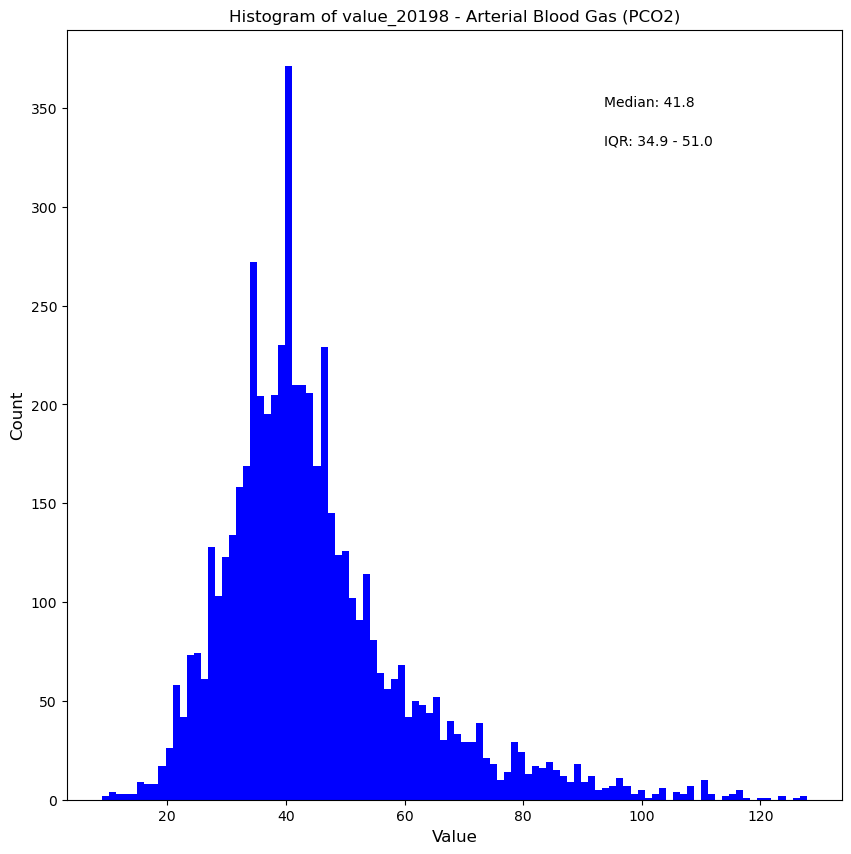

value_highest_20198: 5581


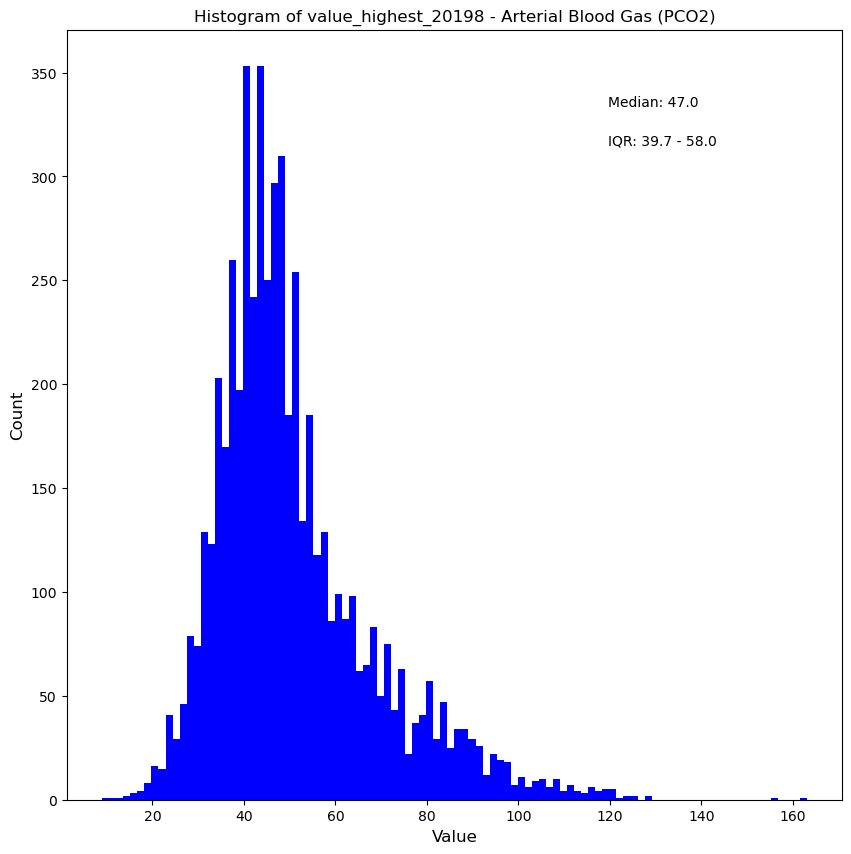

Shapes:
(14207,)
(14207,)
(2353,)
(0,)
Highest > First

      patient_id encounter_id encounter_type          RFS qualify_date sex  \
5          XwjLL       aAuR0R           EMER  VENTSUPPORT   2022-01-01   0   
9          XQyDL       agL3MR           EMER  VENTSUPPORT   2022-01-01   1   
12         XASQC       aQBV#g           EMER  VENTSUPPORT   2022-01-01   1   
22         3w0wB       6QLldC           EMER  VENTSUPPORT   2022-01-01   0   
25         3Q1wB       6wWldC           EMER  VENTSUPPORT   2022-01-01   0   
...          ...          ...            ...          ...          ...  ..   
14140       3Ax0       6wFDgB           EMER  VENTSUPPORT   2022-12-27   1   
14141      3AILC       6g03mC           EMER  VENTSUPPORT   2022-12-27   1   
14170       3Qrm       6Q6RJB           EMER  VENTSUPPORT   2022-12-29   0   
14187      yQvMB       1QYW7B           EMER  VENTSUPPORT   2022-12-31   1   
14203       3goo       6QCpMB           EMER  VENTSUPPORT   2022-12-31   0   

      r

value_115576: 1110


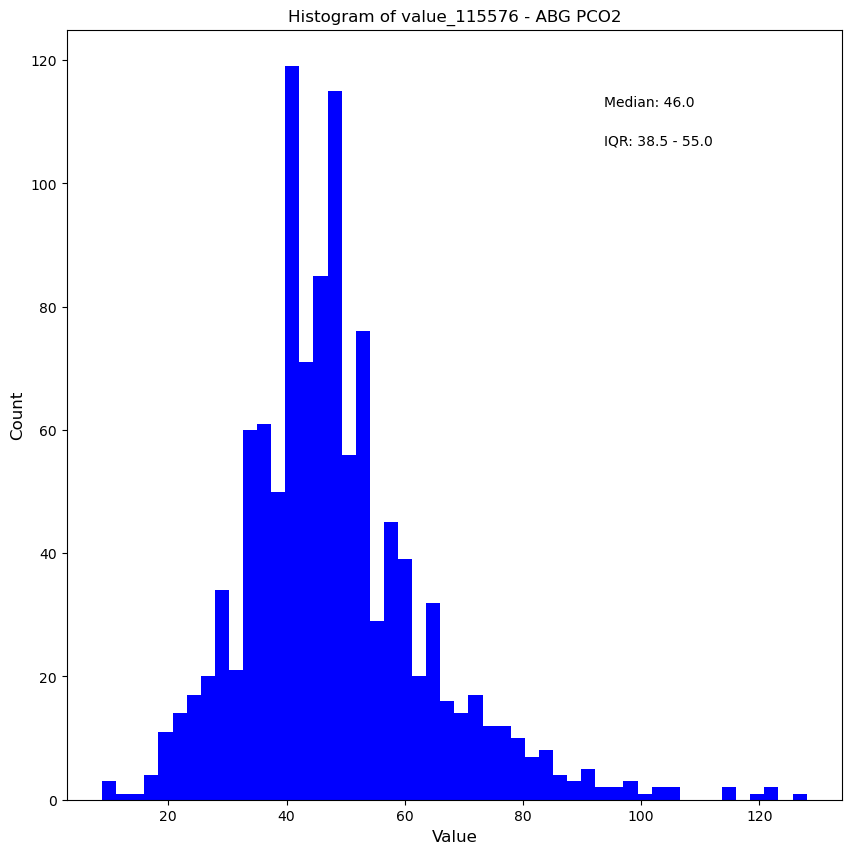

value_highest_115576: 1110


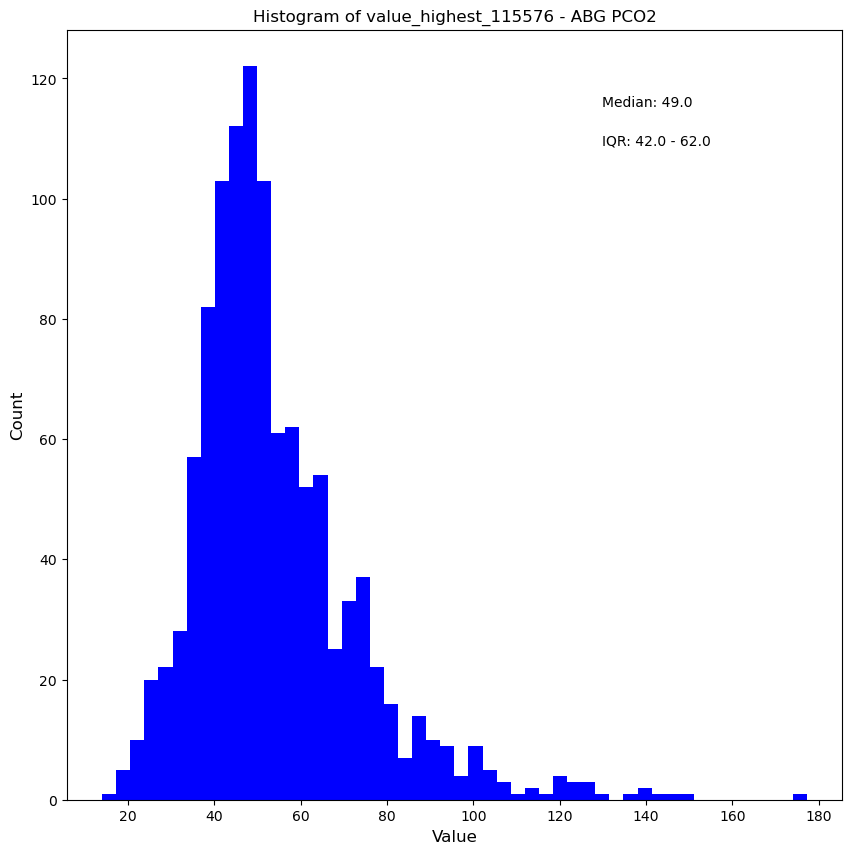

Shapes:
(14207,)
(14207,)
(440,)
(0,)
Highest > First

      patient_id encounter_id encounter_type          RFS qualify_date sex  \
20         7ASwD       _wKkxC           EMER  VENTSUPPORT   2022-01-01   1   
22         3w0wB       6QLldC           EMER  VENTSUPPORT   2022-01-01   0   
59         7QxVJ       _AIKyS           EMER  VENTSUPPORT   2022-01-02   1   
60          7AtJ       _gE5QZ           EMER  VENTSUPPORT   2022-01-02   0   
61          3wEy       6A_mbB           EMER  VENTSUPPORT   2022-01-02   1   
...          ...          ...            ...          ...          ...  ..   
14119      7Q0lJ       _gSfaT           EMER  VENTSUPPORT   2022-12-26   0   
14120      7AhQC       _Q14Wc           EMER  VENTSUPPORT   2022-12-26   0   
14126       sQxY       vQ3_wC           EMER  VENTSUPPORT   2022-12-27   0   
14134      7Q0BE       _whDwD           EMER  VENTSUPPORT   2022-12-27   1   
14203       3goo       6QCpMB           EMER  VENTSUPPORT   2022-12-31   0   

      ra

value_327718: 60


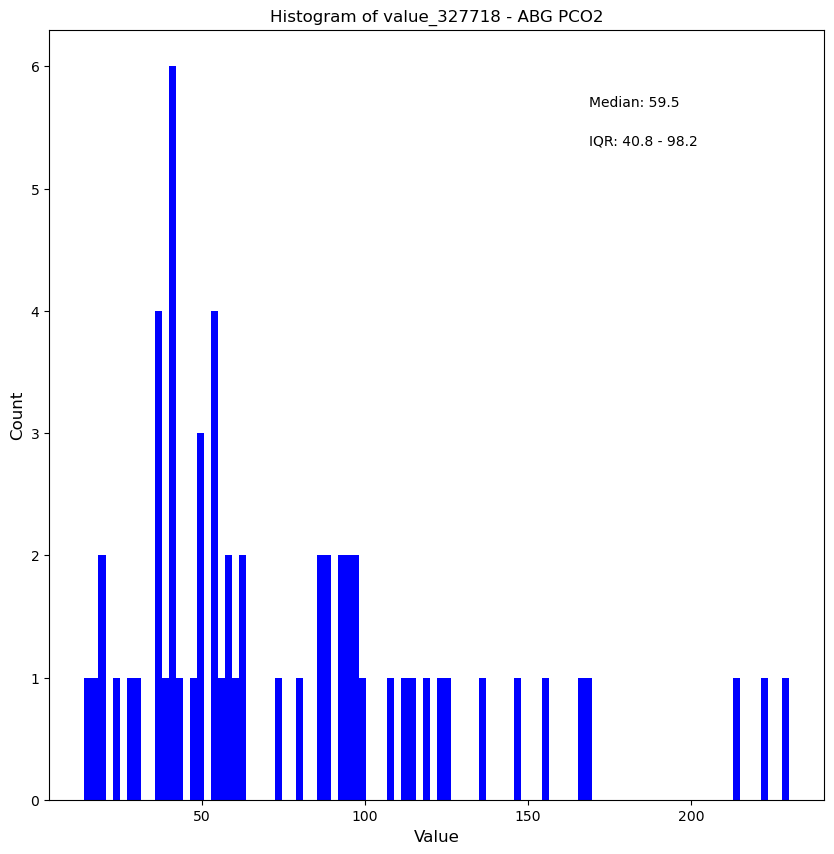

value_highest_327718: 60


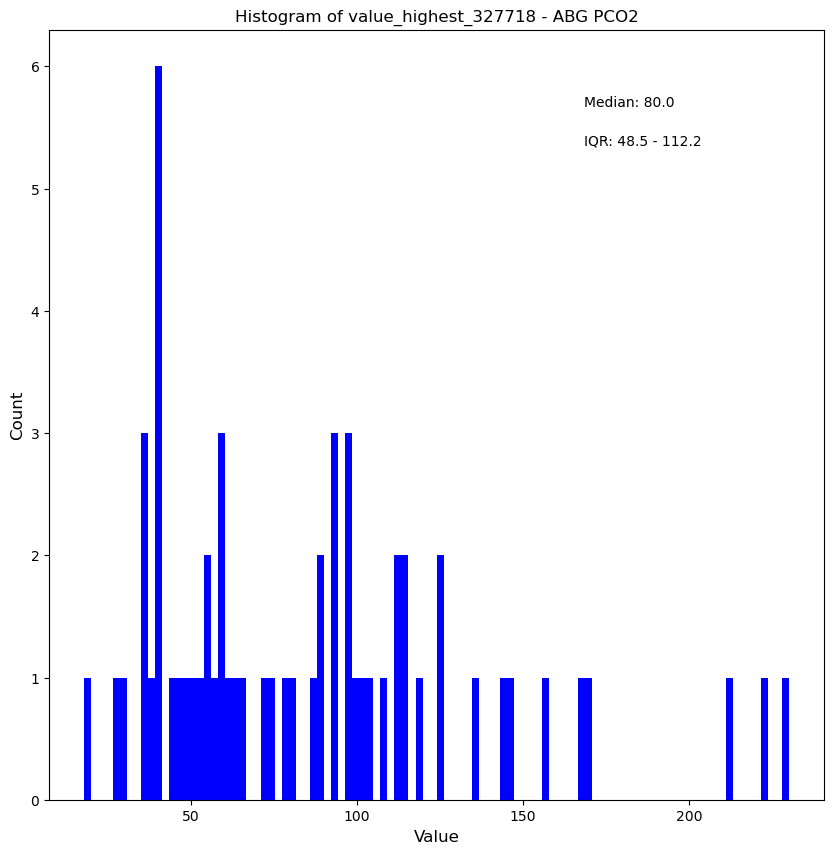

Shapes:
(14207,)
(14207,)
(16,)
(0,)
Highest > First

      patient_id encounter_id encounter_type          RFS qualify_date sex  \
192         5waT       8wDI8D           EMER  VENTSUPPORT   2022-01-05   1   
1415       5wJgC       8QlC3Q           EMER  VENTSUPPORT   2022-01-30   0   
1418       wQxxB       zQQxDC           EMER  VENTSUPPORT   2022-01-31   0   
1469       wQJ0B       zw1dHC           EMER  VENTSUPPORT   2022-02-01   0   
1818       5QPLB       8AAB3K           EMER  VENTSUPPORT   2022-02-08   1   
2285        wwvD       zwux0C           EMER  VENTSUPPORT   2022-02-19   1   
2818        ww3h        zQ5fr           EMER  VENTSUPPORT   2022-03-05   0   
2899         wg_       zQINwC           EMER  VENTSUPPORT   2022-03-07   1   
3944        wwqI        zgQ8E           EMER  VENTSUPPORT   2022-04-02   1   
6099       5w96C       8QgeQC           EMER  VENTSUPPORT   2022-05-24   1   
6934       wgqYB       zA#ImB           EMER  VENTSUPPORT   2022-06-14   1   
7819      

value_VBG_CO2: 4050


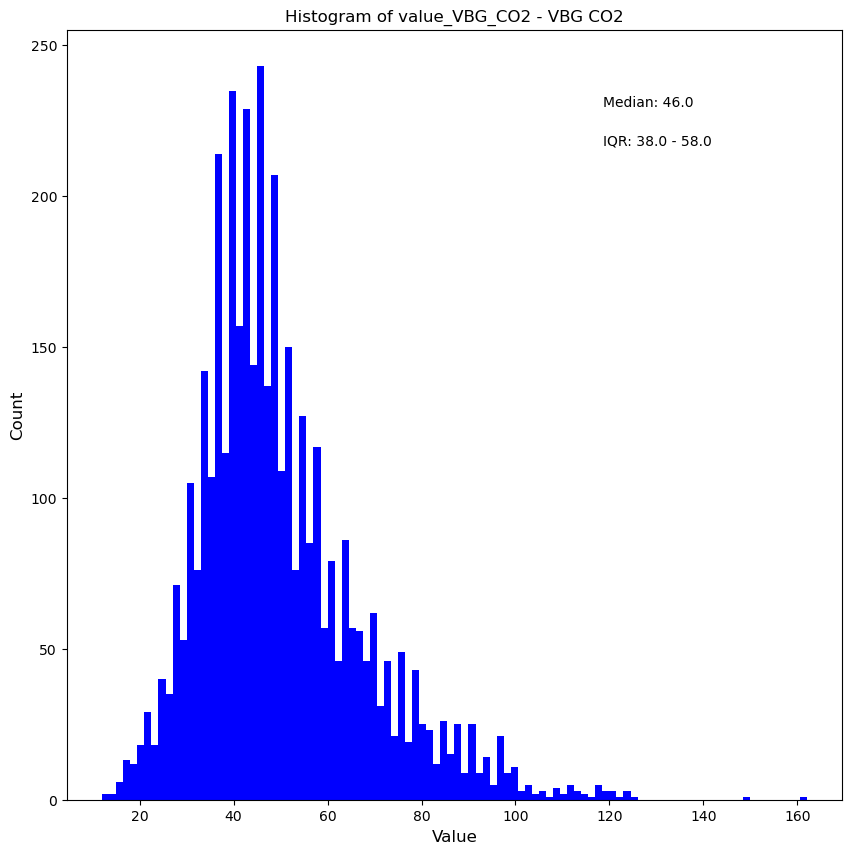

value_highest_VBG_CO2: 4089


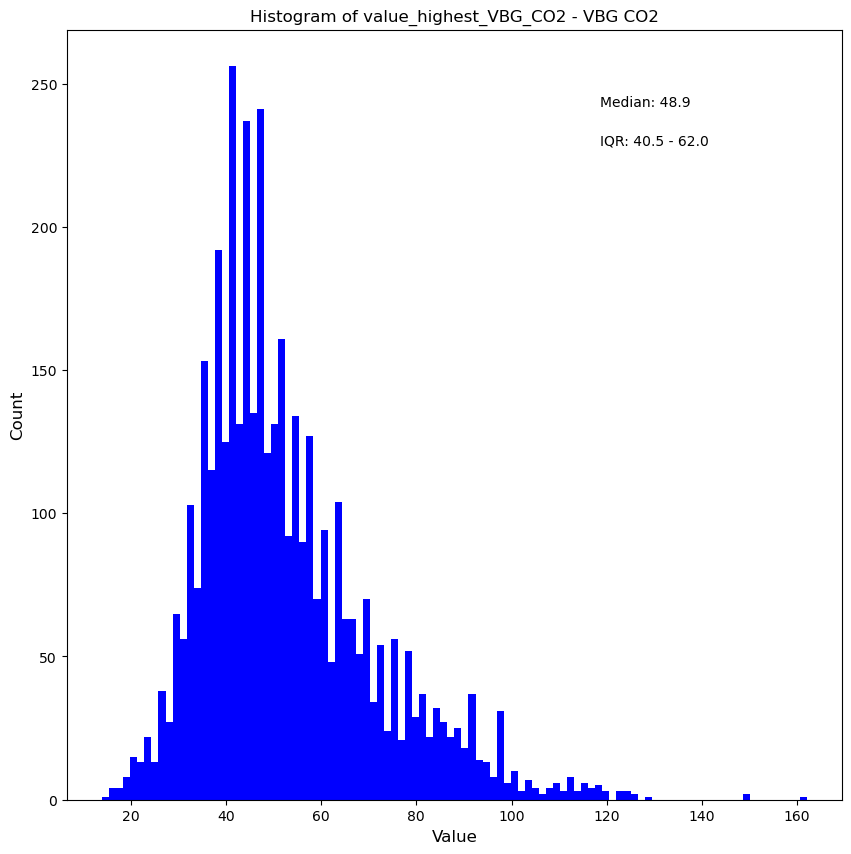

Shapes:
(14207,)
(14207,)
(996,)
(0,)
Highest > First

      patient_id encounter_id encounter_type          RFS qualify_date sex  \
2          jwv5B       mA47PL           EMER  VENTSUPPORT   2022-01-01   0   
13          SwfV       VwgApR           EMER  VENTSUPPORT   2022-01-01   0   
30         XwzDC       aQhjVg           EMER  VENTSUPPORT   2022-01-02   0   
41         XQm_I       aQ50UI           EMER  VENTSUPPORT   2022-01-02   1   
56         ARUaB        DRtoI           EMER  VENTSUPPORT   2022-01-02   1   
...          ...          ...            ...          ...          ...  ..   
14102       5QWr       8wlLtH           EMER  VENTSUPPORT   2022-12-25   1   
14123       5QY#       8QLpTJ           EMER  VENTSUPPORT   2022-12-26   1   
14141      3AILC       6g03mC           EMER  VENTSUPPORT   2022-12-27   1   
14171      3QNMC       6QPanC           EMER  VENTSUPPORT   2022-12-29   1   
14199       5QFz       8QJUZI           EMER  VENTSUPPORT   2022-12-31   0   

      ra

value_PCO2_Unspec_blood: 1116


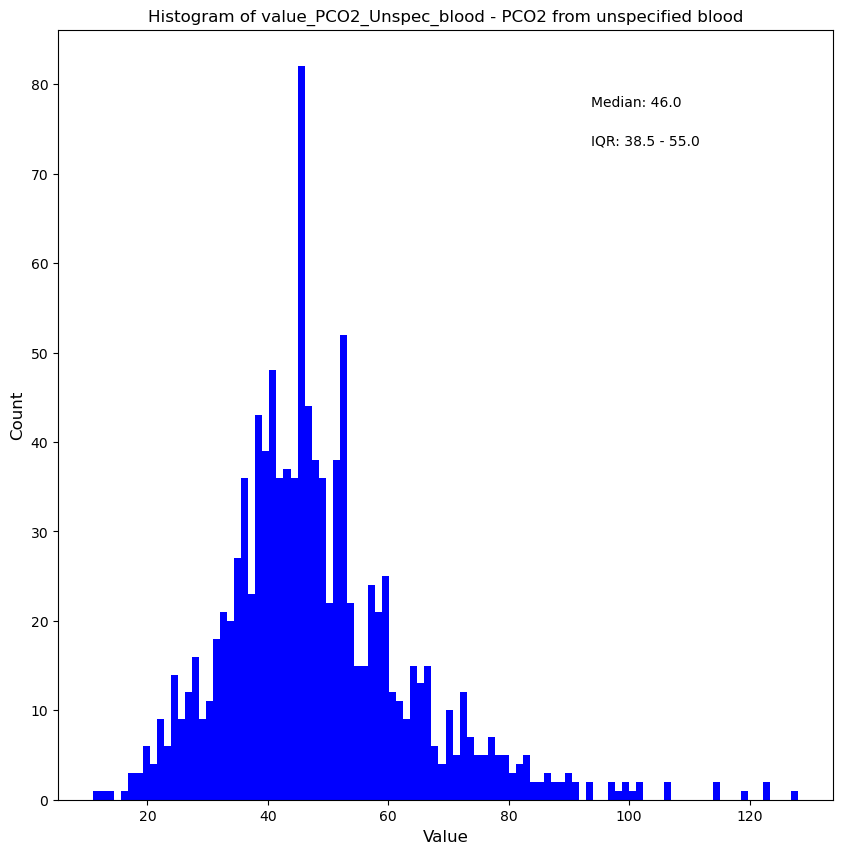

value_highest_PCO2_Unspec_blood: 1116


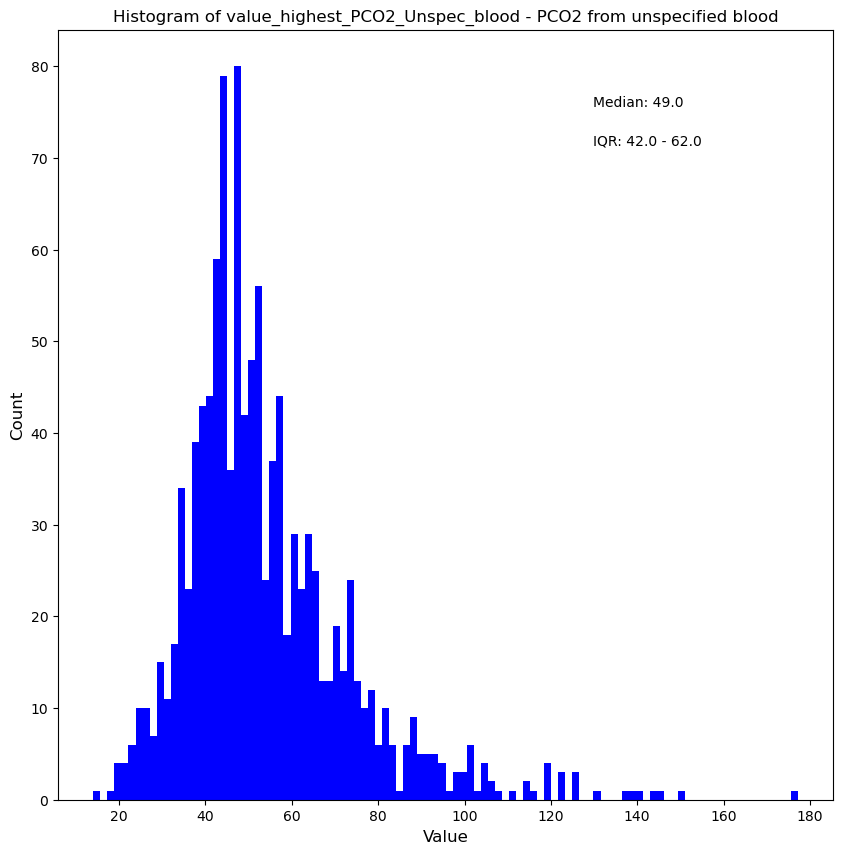

Shapes:
(14207,)
(14207,)
(440,)
(0,)
Highest > First

      patient_id encounter_id encounter_type          RFS qualify_date sex  \
20         7ASwD       _wKkxC           EMER  VENTSUPPORT   2022-01-01   1   
22         3w0wB       6QLldC           EMER  VENTSUPPORT   2022-01-01   0   
59         7QxVJ       _AIKyS           EMER  VENTSUPPORT   2022-01-02   1   
60          7AtJ       _gE5QZ           EMER  VENTSUPPORT   2022-01-02   0   
61          3wEy       6A_mbB           EMER  VENTSUPPORT   2022-01-02   1   
...          ...          ...            ...          ...          ...  ..   
14119      7Q0lJ       _gSfaT           EMER  VENTSUPPORT   2022-12-26   0   
14120      7AhQC       _Q14Wc           EMER  VENTSUPPORT   2022-12-26   0   
14126       sQxY       vQ3_wC           EMER  VENTSUPPORT   2022-12-27   0   
14134      7Q0BE       _whDwD           EMER  VENTSUPPORT   2022-12-27   1   
14203       3goo       6QCpMB           EMER  VENTSUPPORT   2022-12-31   0   

      ra

value_27441: 4245


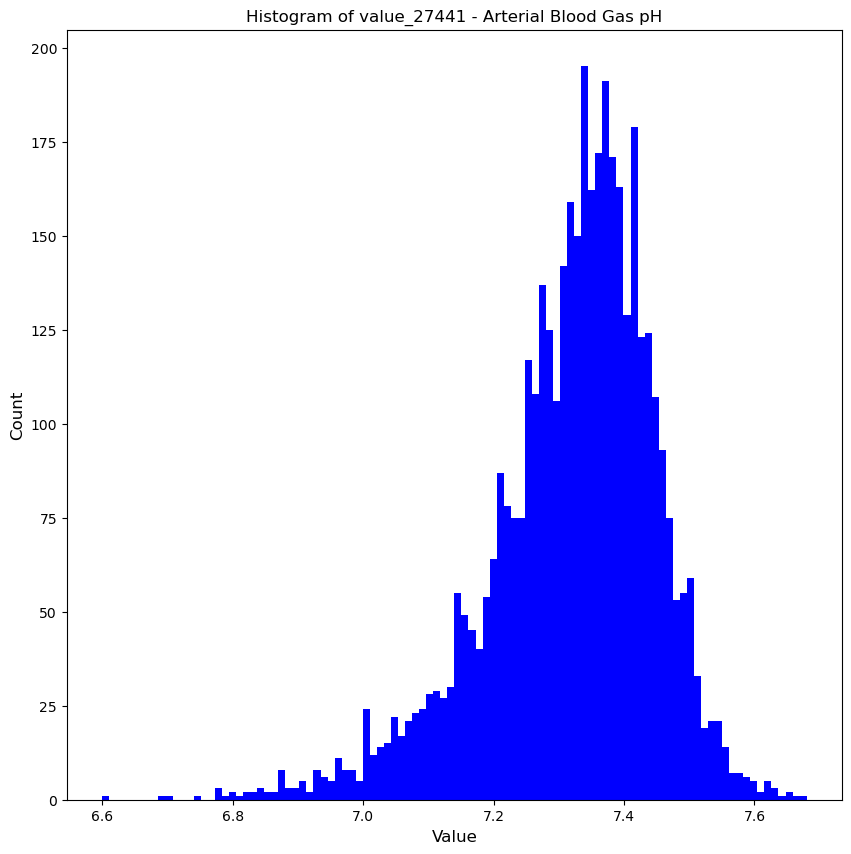

value_27466: 1775


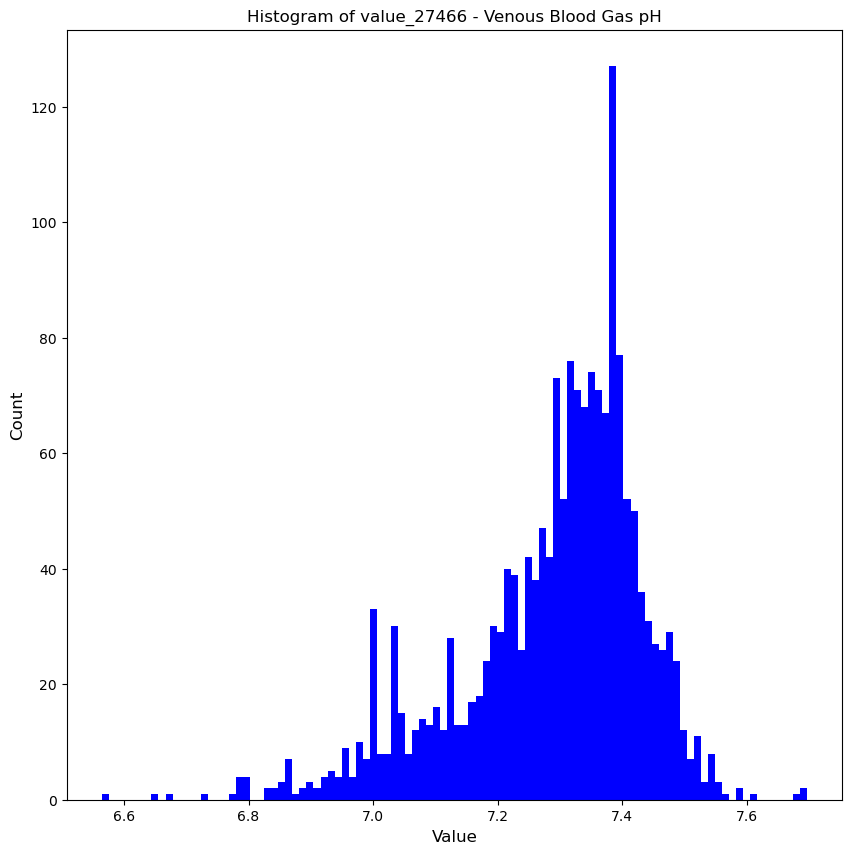

value_19604_20263: 4345


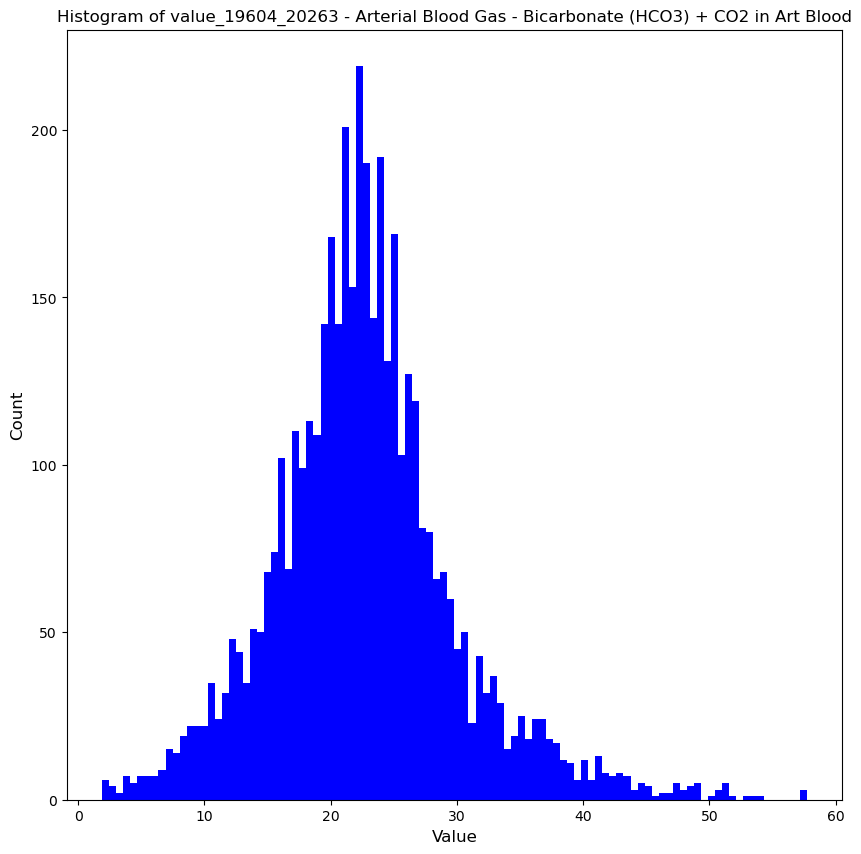

value_146274: 3098


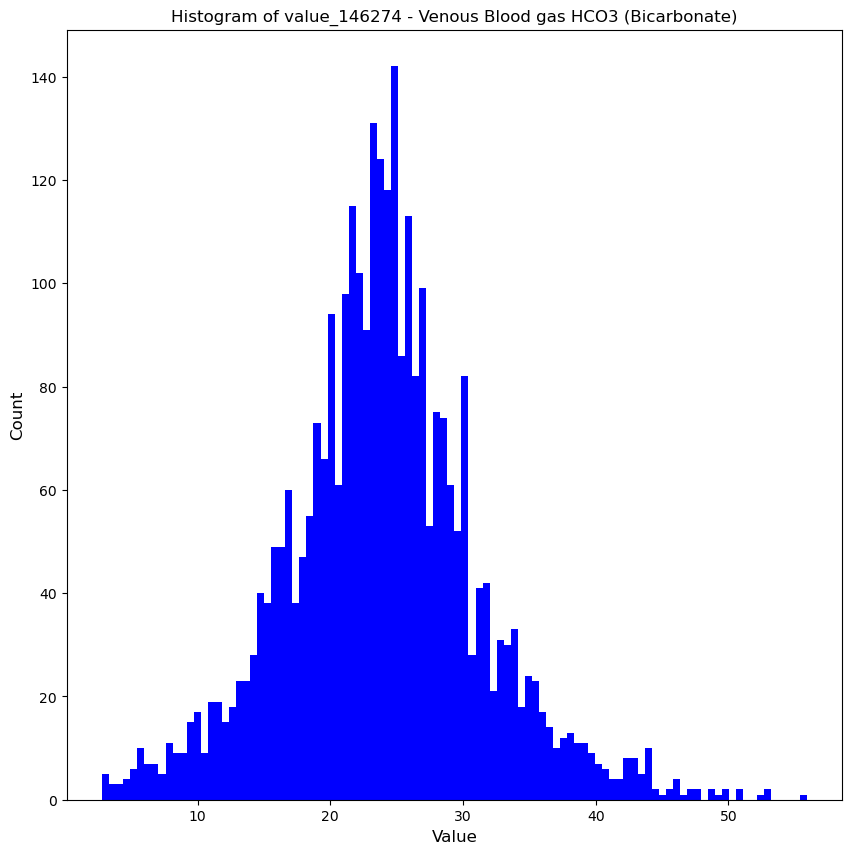

value_29512: 12061


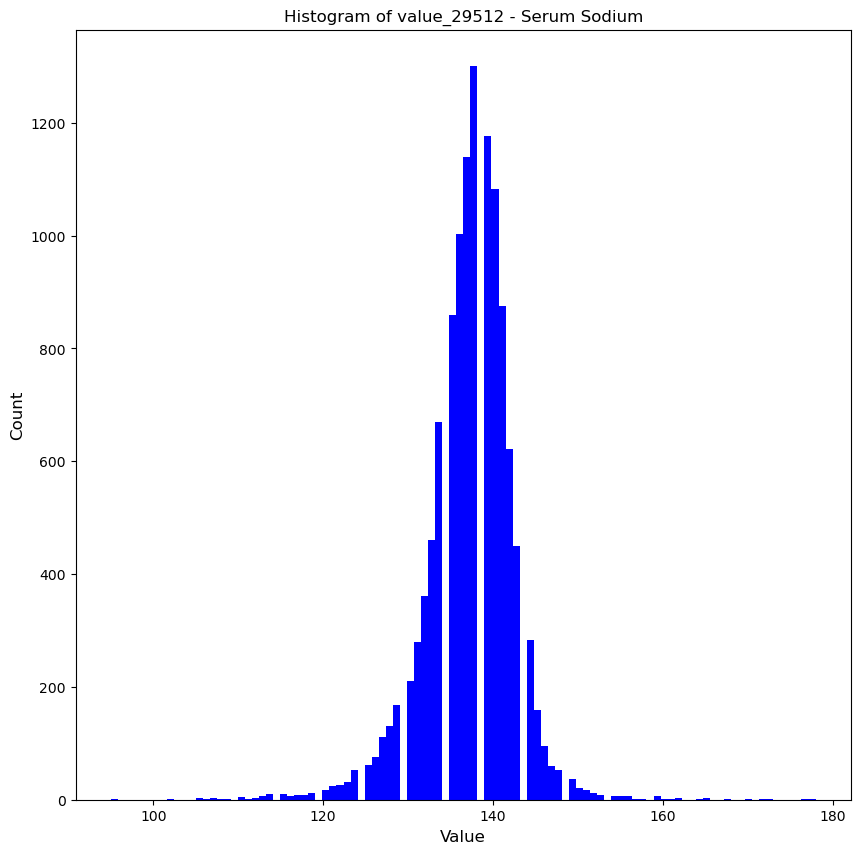

value_21600: 11817


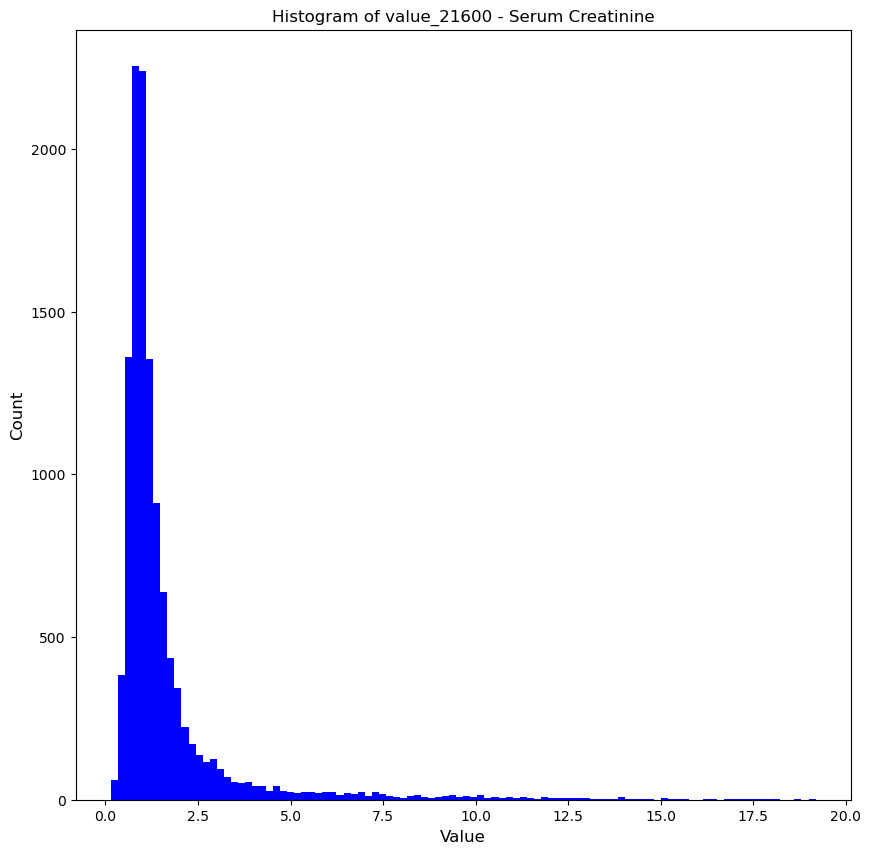

value_7187: 11723


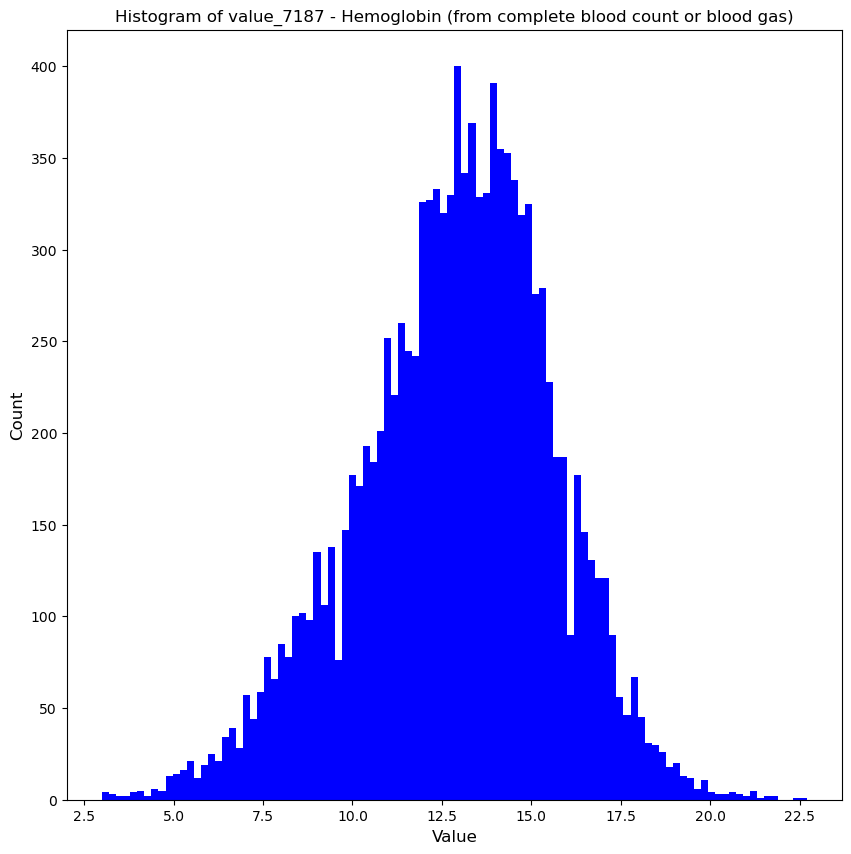

value_serum_bicarb: 12007


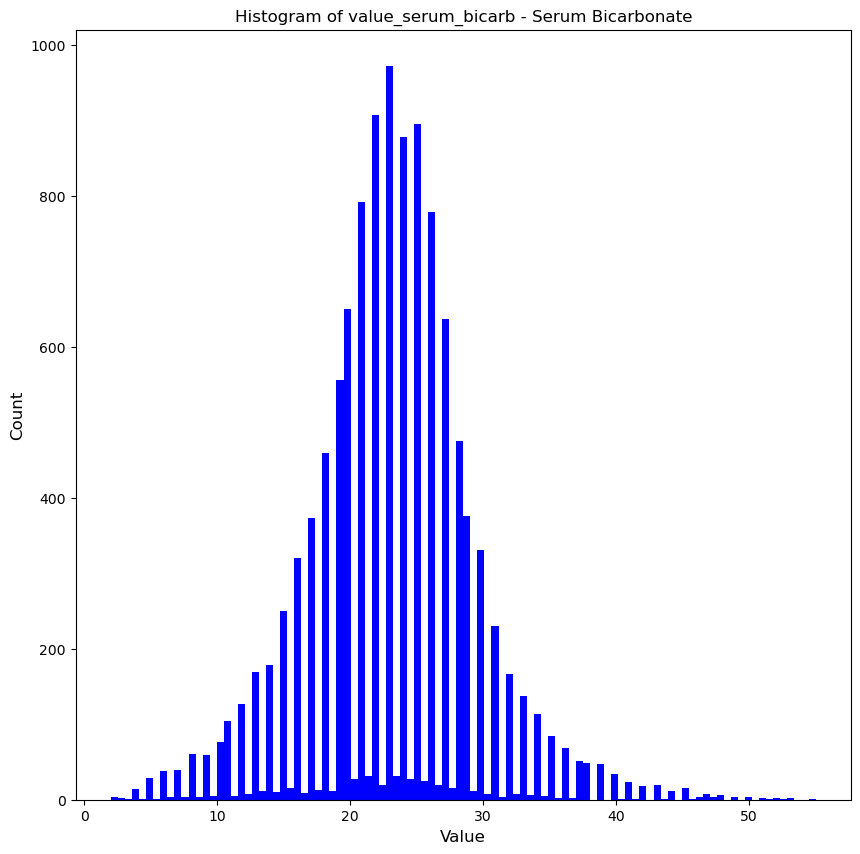

value_serum_chloride: 12050


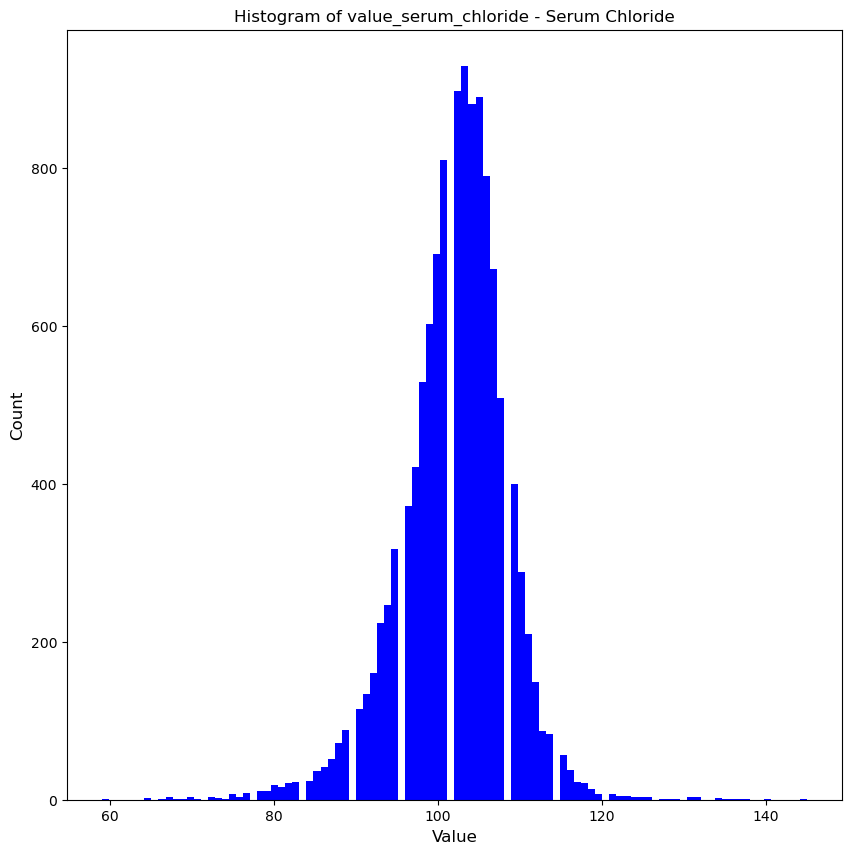

value_serum_lactate: 5752


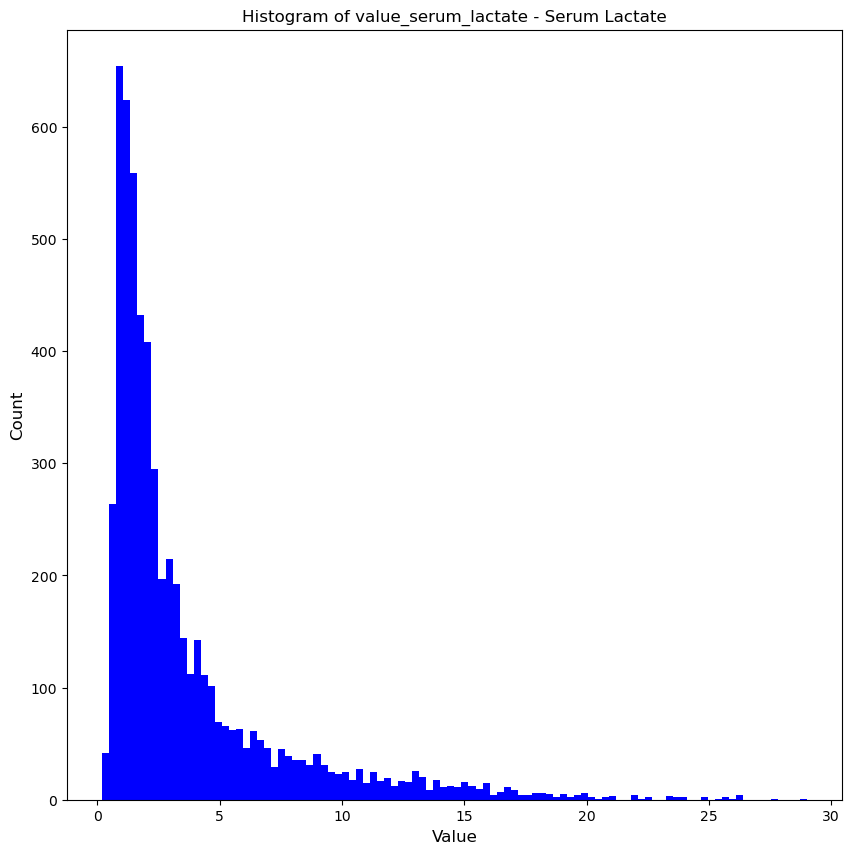

value_potassium: 11982


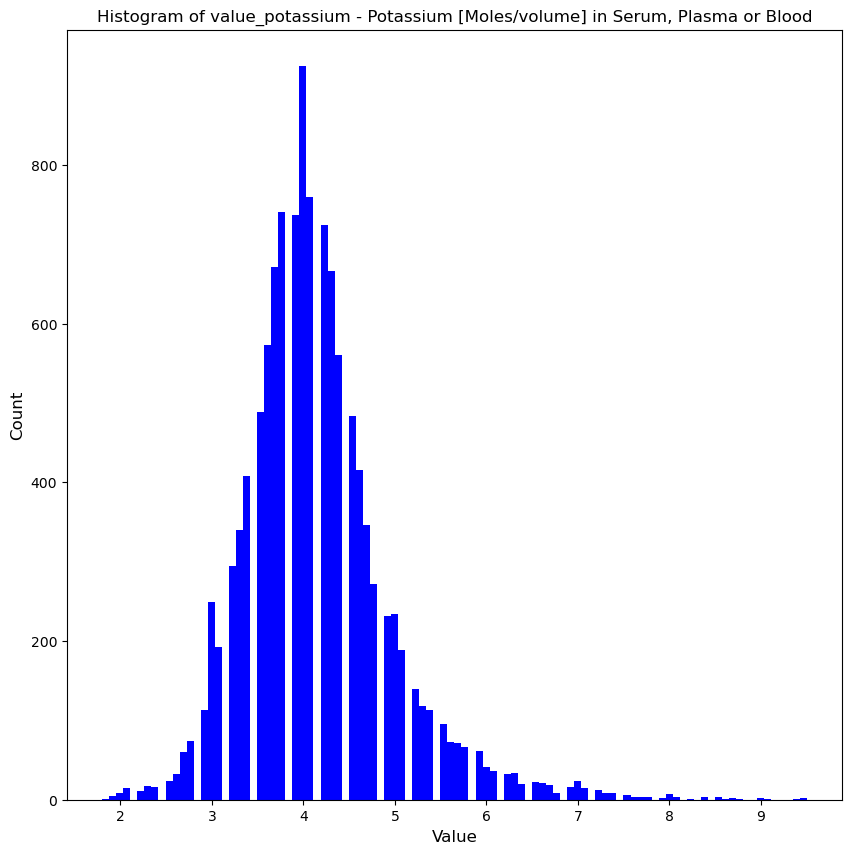

value_192583: 737


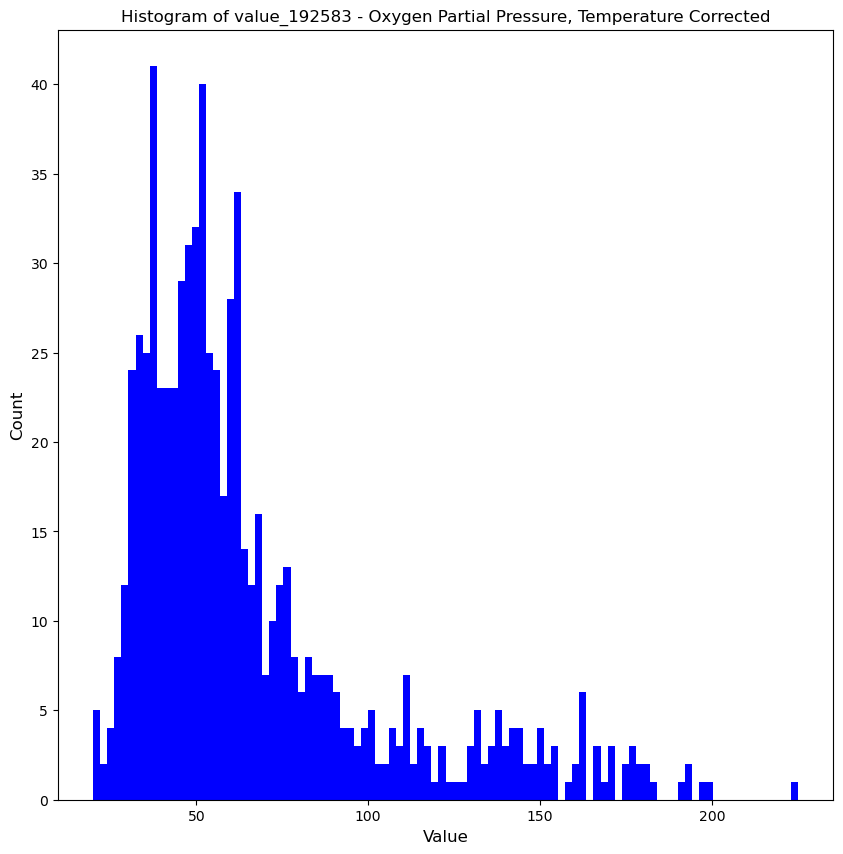

value_394866: 2405


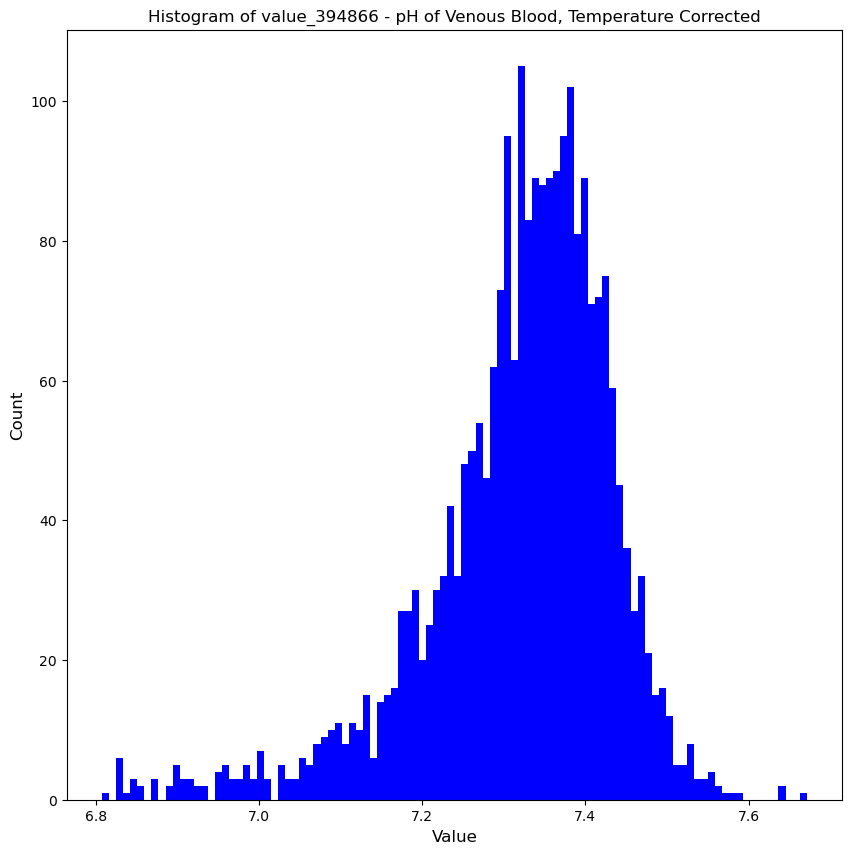

value_27052: 1358


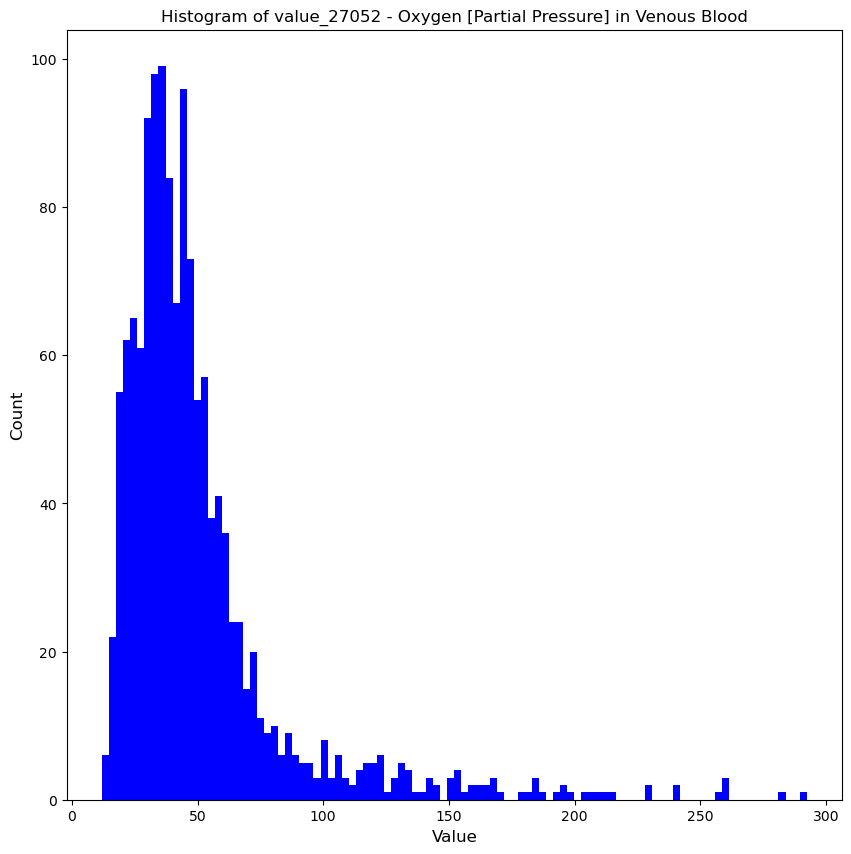

value_Lactate_Venous_Blood: 1742


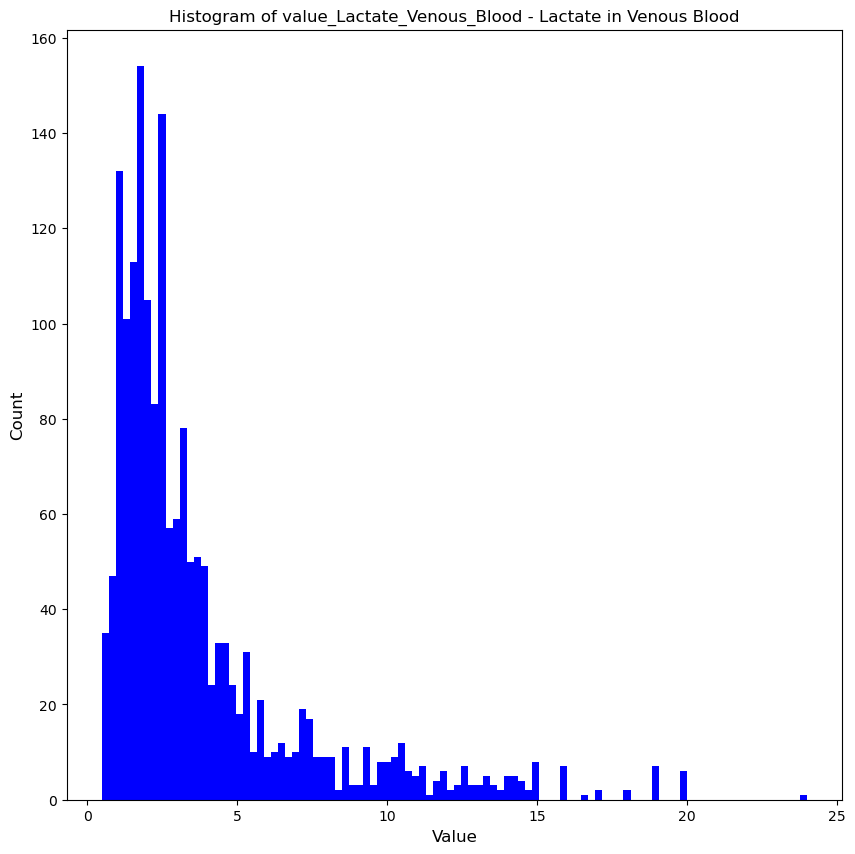

value_483917: 775


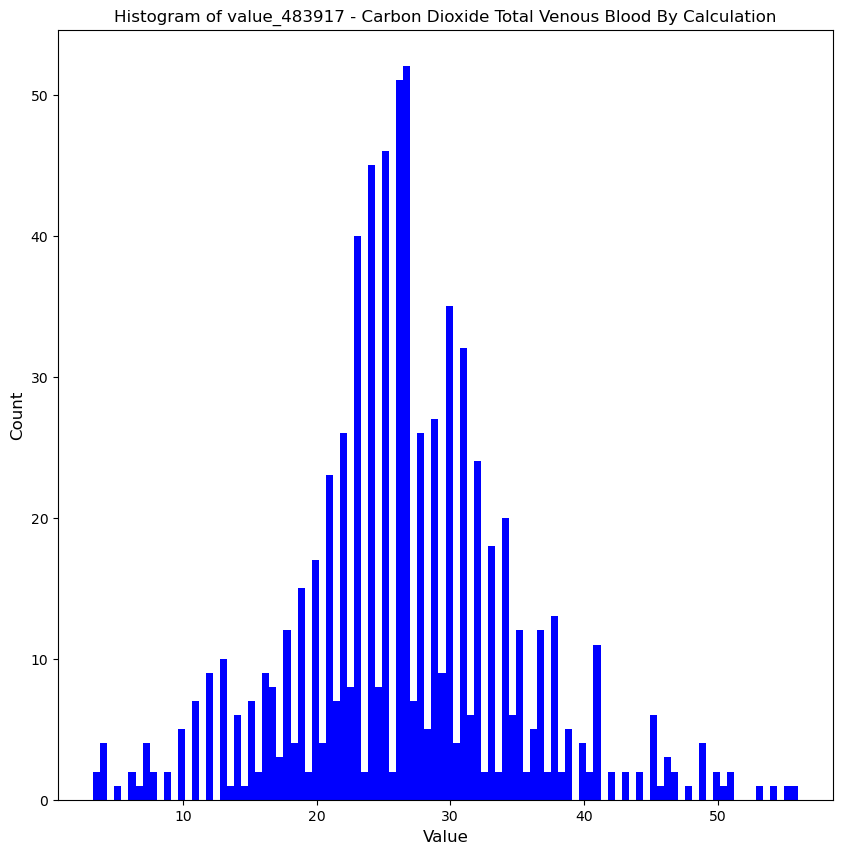

value_27037: 4354


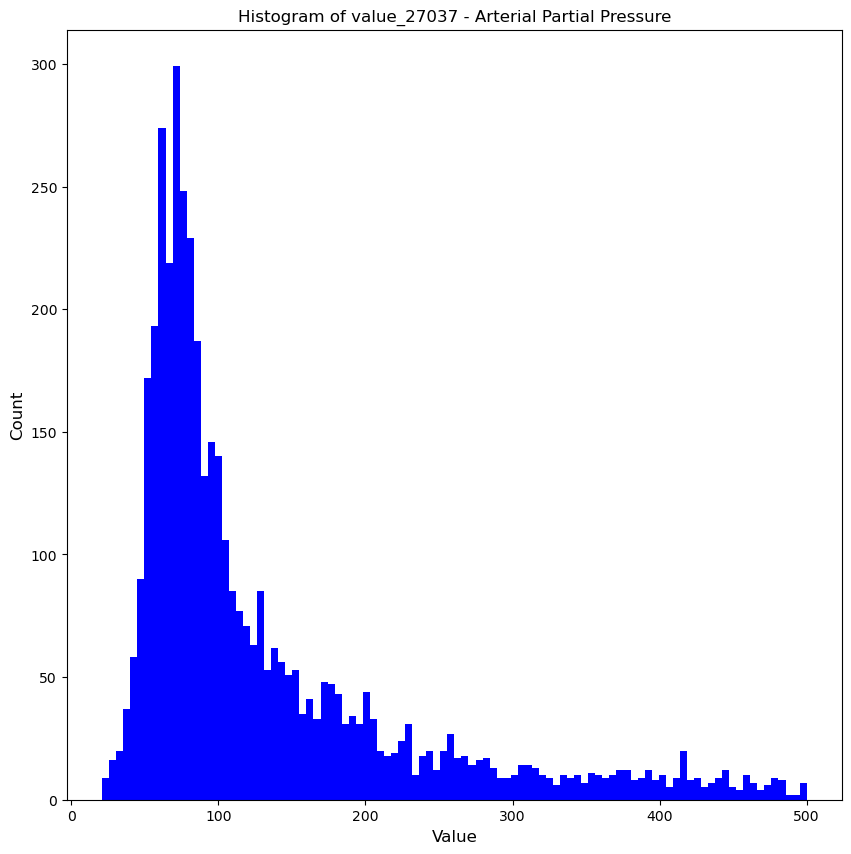

value_192559: 1658


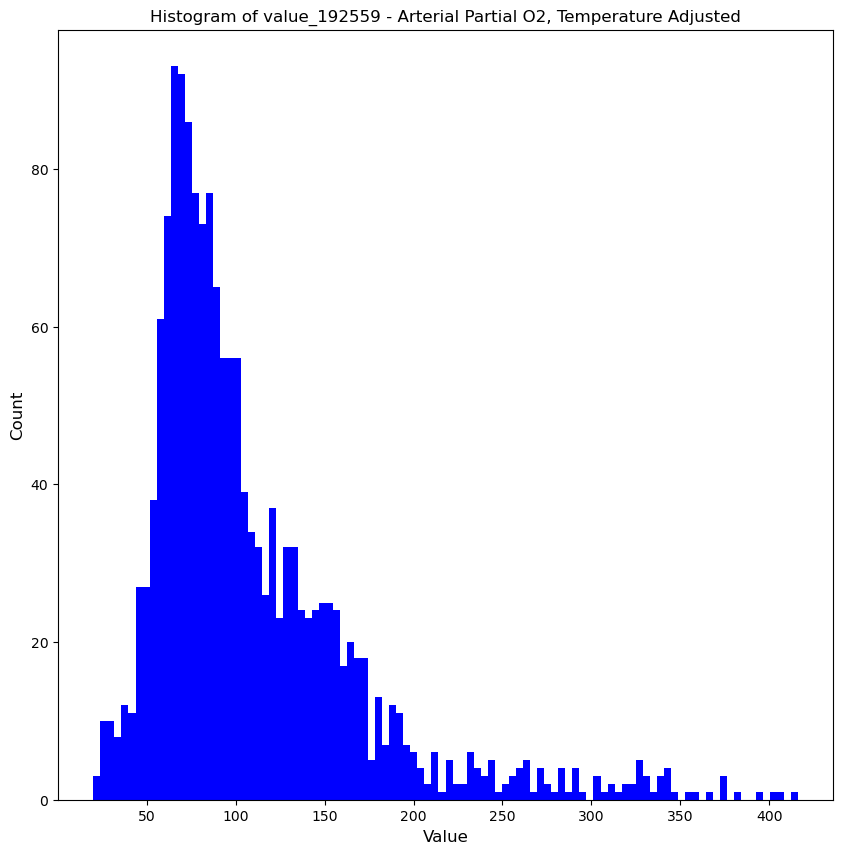

value_332544: 1805


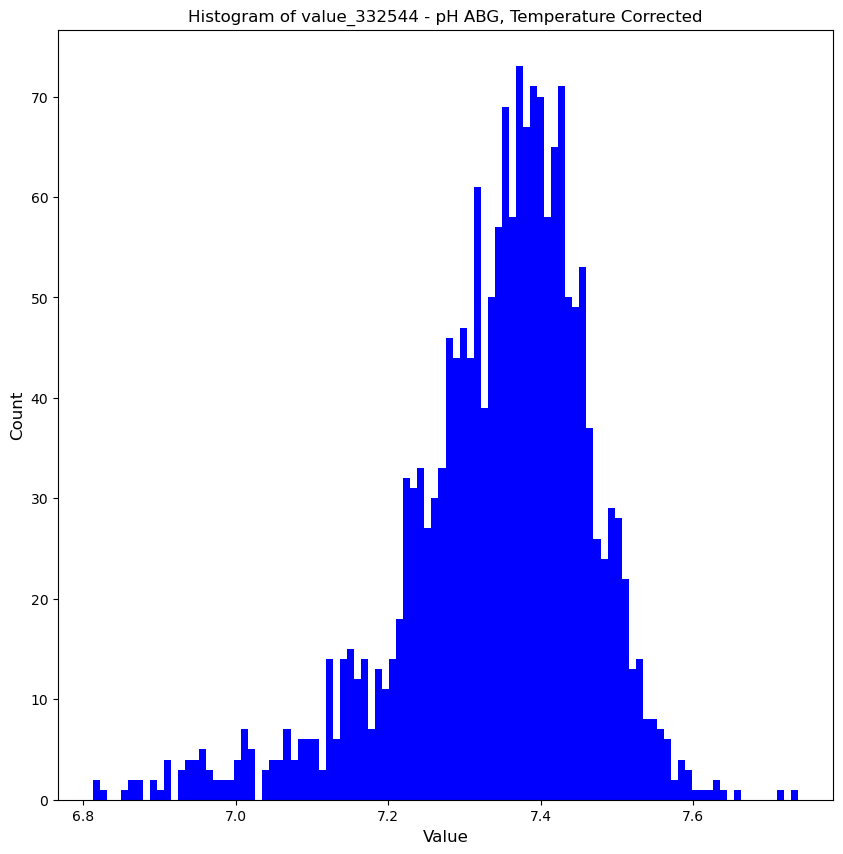

value_25189: 595


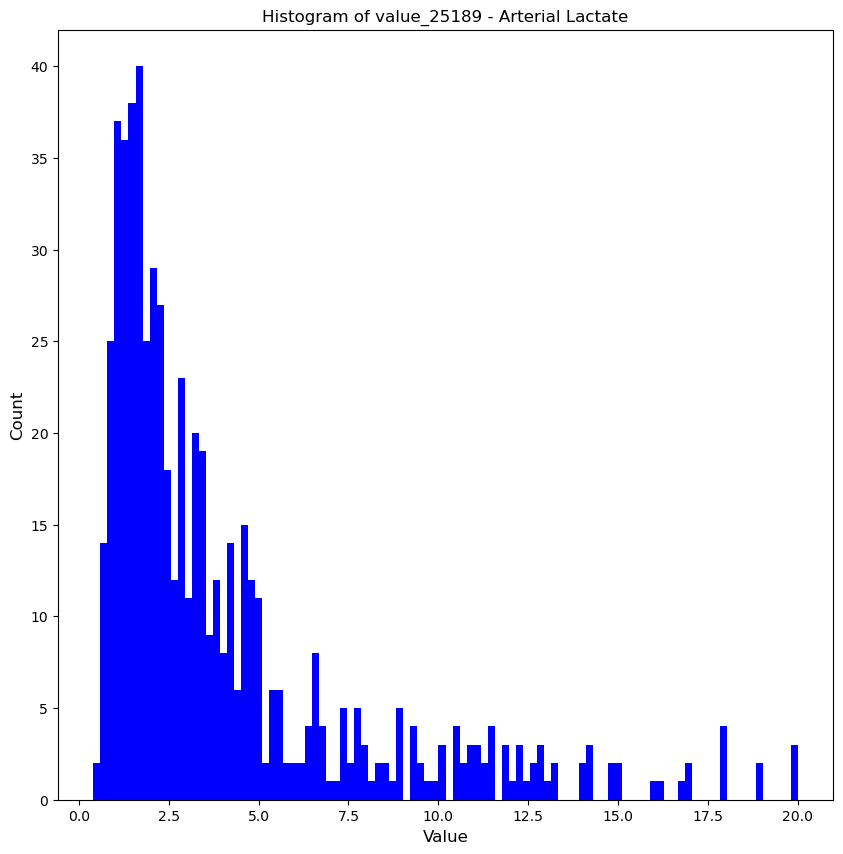

value_115584: 932


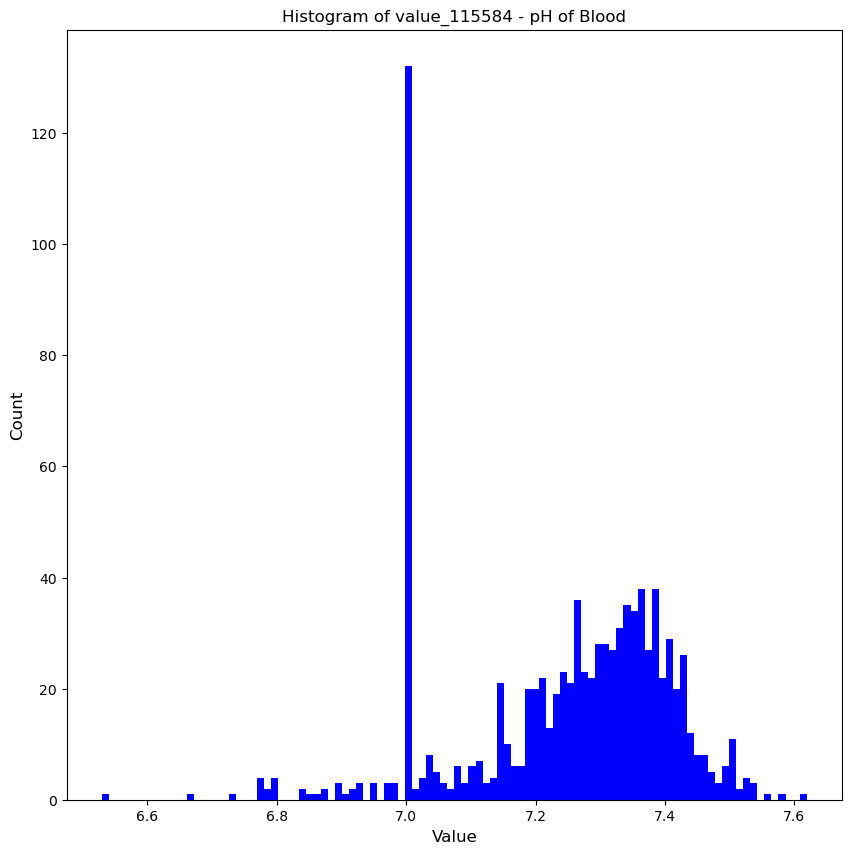

value_115568: 1019


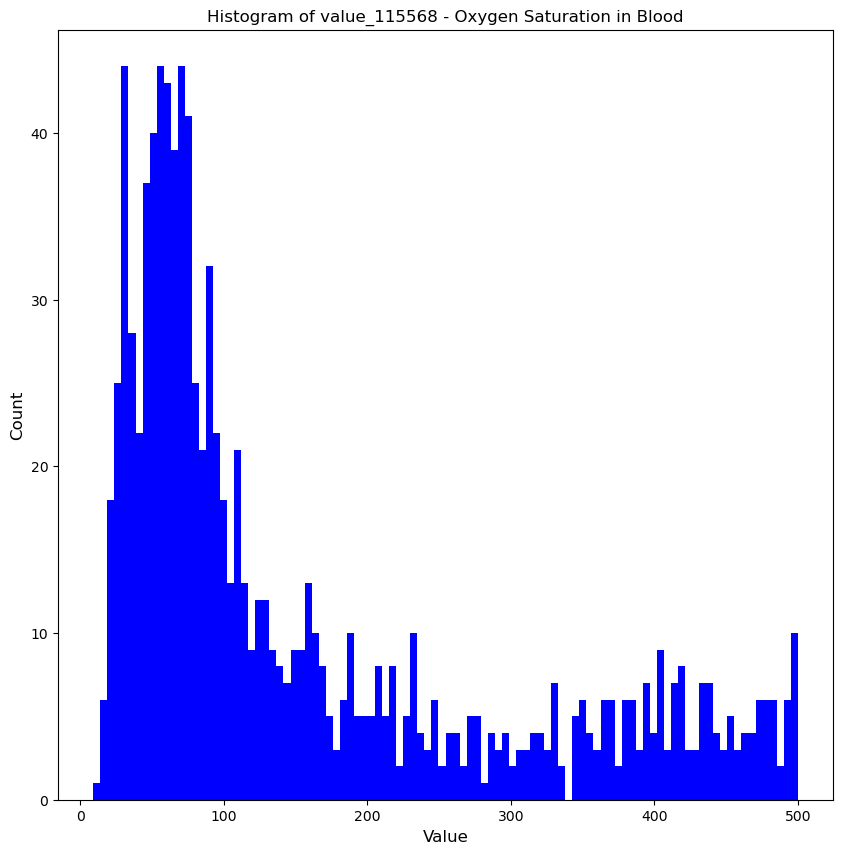

value_264648: 11718


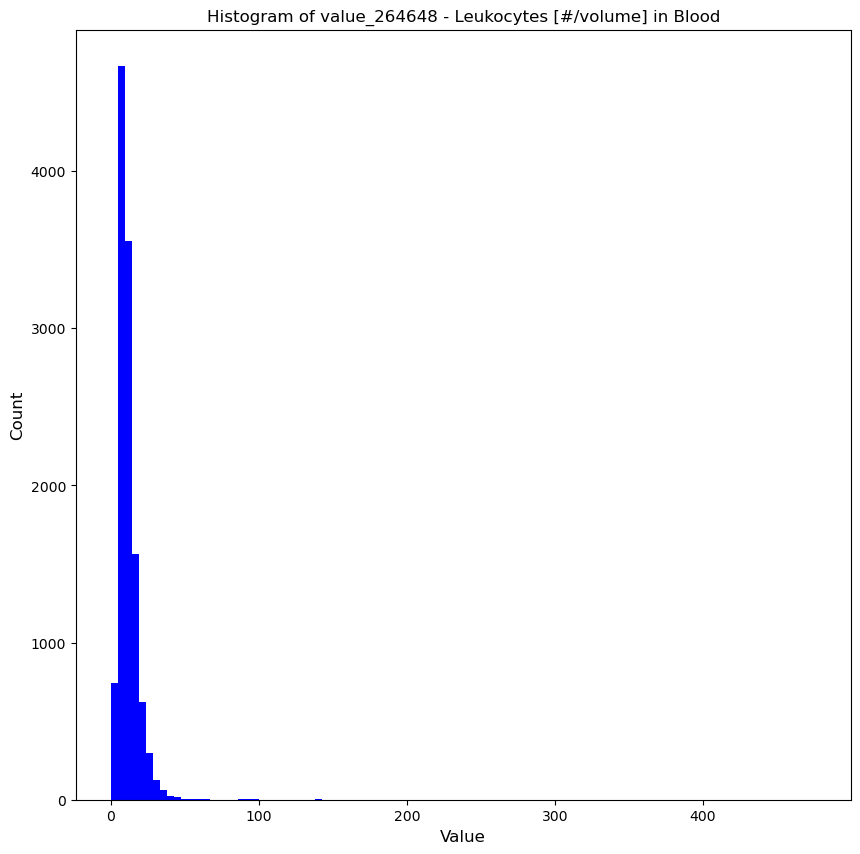

value_265157: 11831


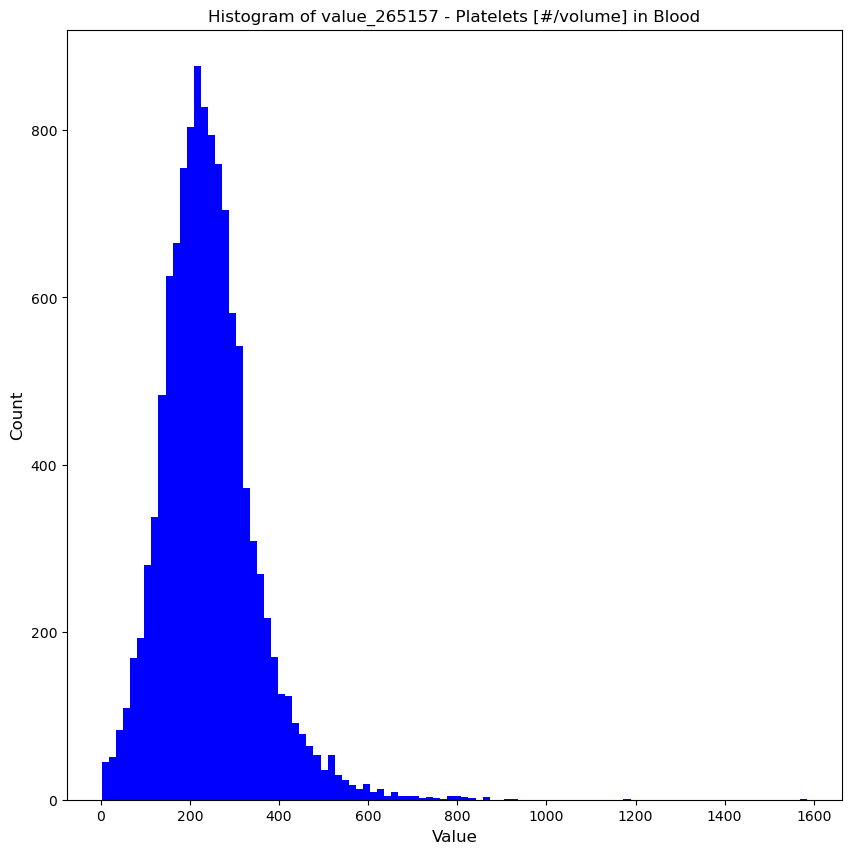

value_bnp: 3789


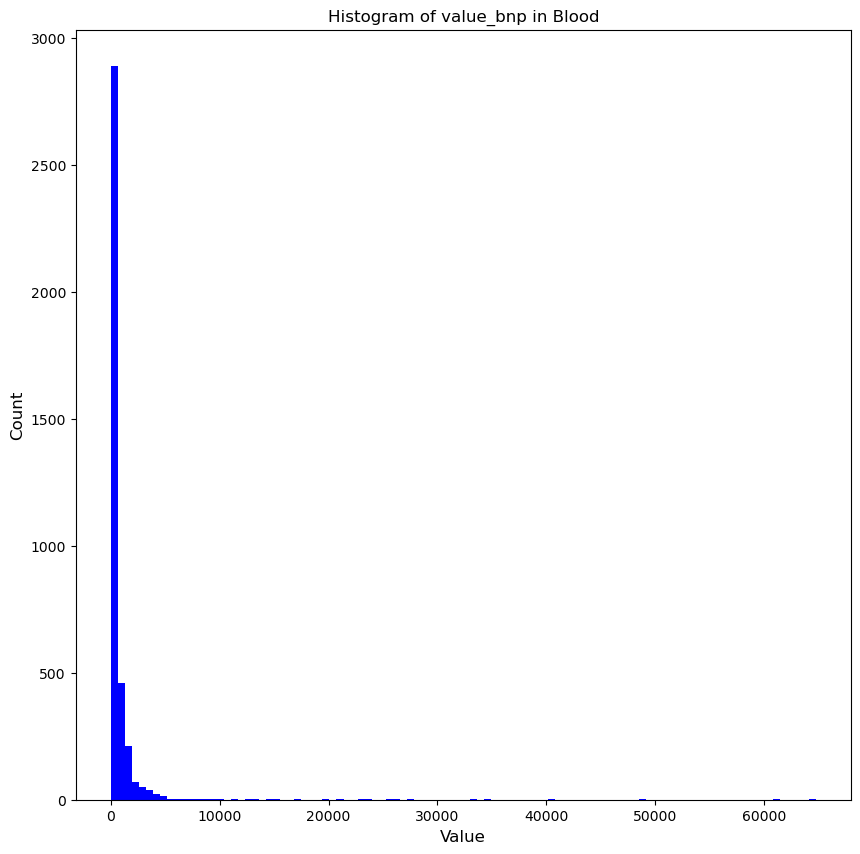

value_phos: 4492


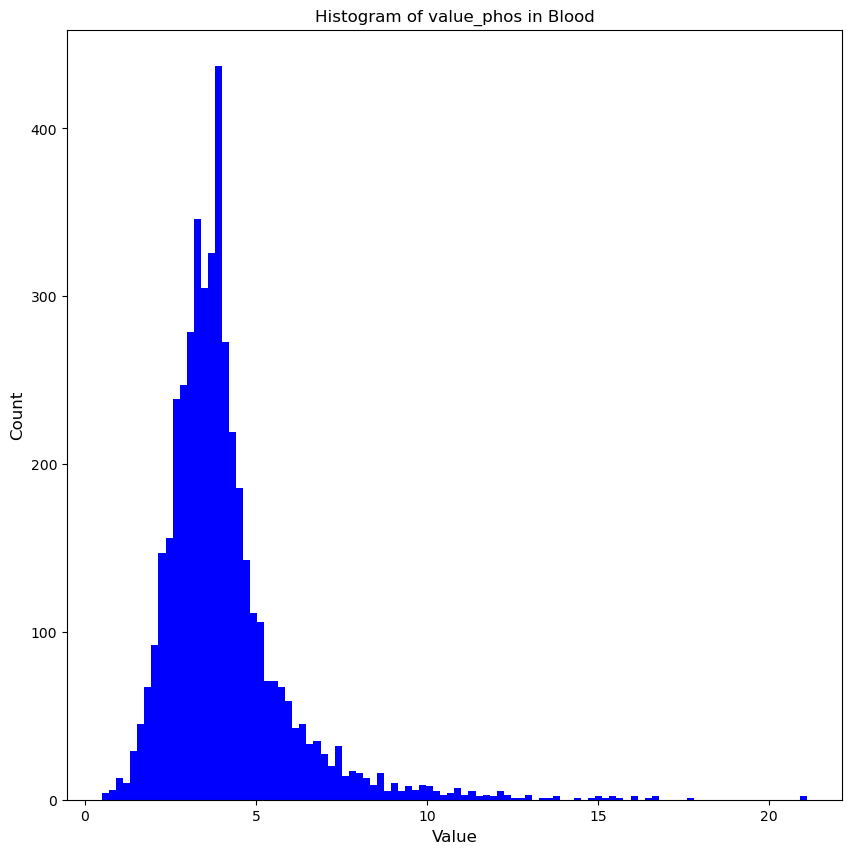

value_ca: 11827


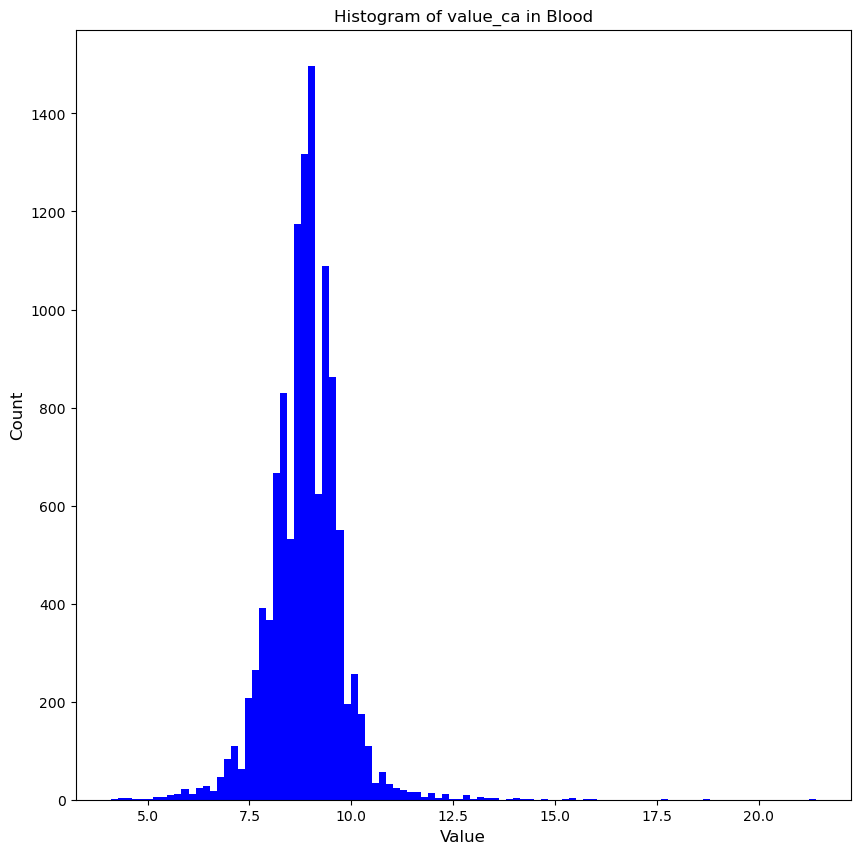

value_albumin: 8135


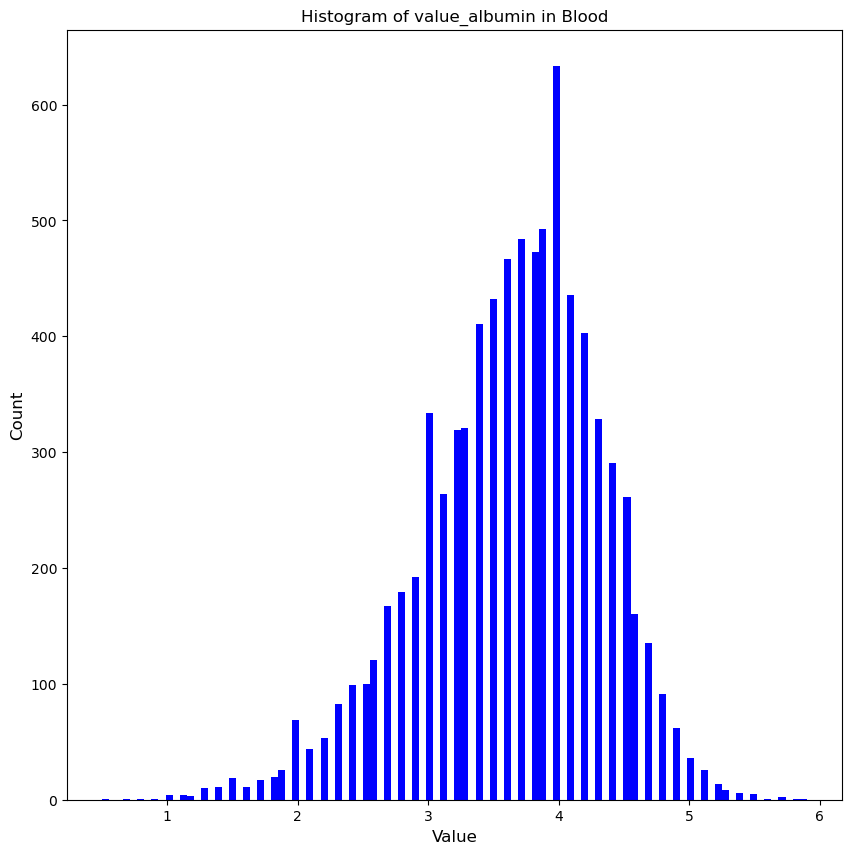

value_tprot: 9630


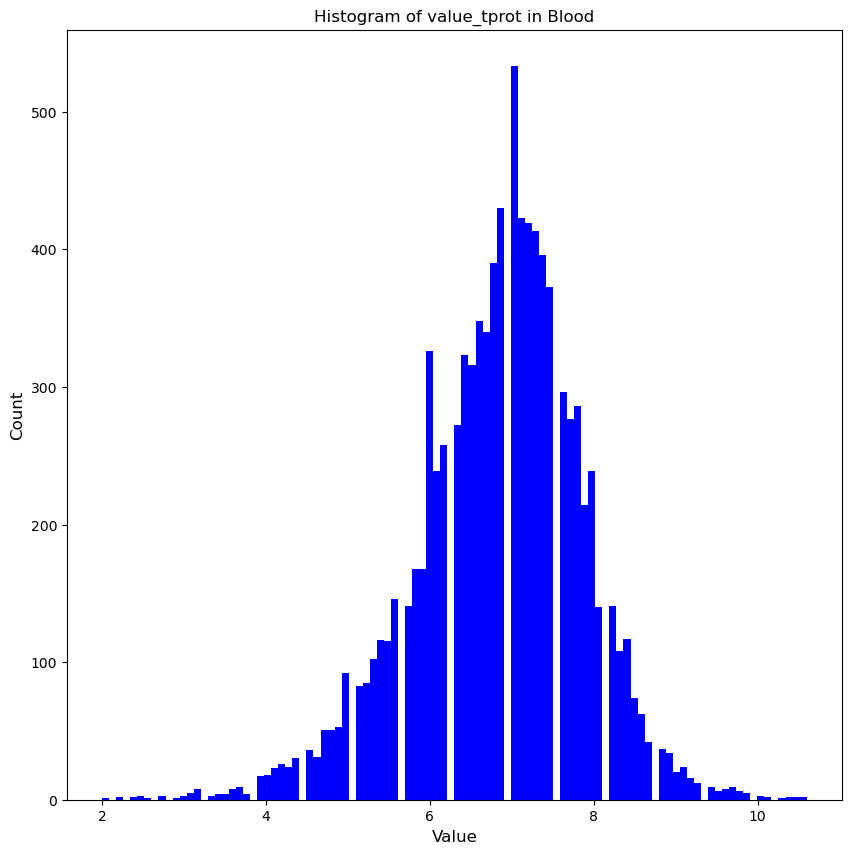

,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,date_bnp,value_bnp,date_phos,value_phos,date_ca,value_ca,date_albumin,value_albumin,date_tprot,value_tprot
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,NaT,0.0,NaT,0.0,2022-01-01,8.0,2022-01-01,2.0,2022-01-01,6.0
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,2022-01-01,1541.0,NaT,0.0,2022-01-01,9.5,2022-01-01,3.6,2022-01-01,7.4
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,2022-01-01,21.6,NaT,0.0,2022-01-01,9.1,2022-01-01,4.2,2022-01-01,7.7
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0.0,2022-01-01,2.4,2022-01-01,8.9,NaT,0.0,NaT,0.0


(14207, 124)
528513
Executed in 0 hours, 9 minutes, and 56.53 seconds.


39609

In [11]:
# Lab Results:
# "Yes"/1 = First lab value obtained during the encounter of interest.
# "No"/0 = Lab value was not obtained during the encounter of interest or is not the first.

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

lab_d_type_spec = {"patient_id":str, "encounter_id":str, "code":'category', "date":str, "lab_result_num_val":np.float32}

# 2019-8: Arterial Blood Gas (PCO2)
# Call in the "value_20198" Dataframe
value_20198 = pd.read_csv(working_dir + "value_20198.csv", dtype = lab_d_type_spec)
value_20198["date"] = pd.to_datetime(value_20198["date"], format='mixed')
# The lab value must occur for a patient of interest in the master_patient_list list 
value_20198 = value_20198[value_20198["patient_id"].isin(master_patient_list)]
# The lab value must occur for the encounter of interest in the mast_encounter_list list
value_20198 = value_20198[value_20198["encounter_id"].isin(master_encounter_list)]
# Lab value must occur sometime AFTER 01/01/2022
value_20198 = value_20198[value_20198["date"] >= pd.to_datetime("20220101")]
# Sort by date in ascending order, then sort by encounter_id. This accounts for patients that may have the 
# same encounter_id across multiple dates.
value_20198 = value_20198.sort_values(by = ["date", "encounter_id"], ascending = [True, False])
# Remove all duplicate encounter_ids and keep the "first" encounter_id. Since we sorted by date, this will
# preserve the earliest encounter.
value_20198 = value_20198.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Sort by date in ascending order again, then sort by patient_id. This accounts for patients who may have 
# multiple hospitalizations across multiple unique encounter_ids.
value_20198 = value_20198.sort_values(by = ["date", "patient_id"], ascending = [True, False])
# Remove all duplicate patient_ids and keep the "first" patient_id to obtain their first lab value during the
# encounter of interest.
value_20198 = value_20198.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop the "code","date","patient_id" columns as they are unnecessary
value_20198 = value_20198.drop(columns = ["code","patient_id"])
# Rename "lab_result_num_val" column to "value_20198"; Rename "date" column to "date_20198"
value_20198 = value_20198.rename(columns = {"lab_result_num_val":"value_20198","date":"date_20198"})
# Merge this new Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_20198, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill all N/A values with "0" and convert to integer datatype
RFS_ABG_ENC_AMB["value_20198"] = RFS_ABG_ENC_AMB["value_20198"].fillna(0).astype(np.float32)
# Print the number of patients w/the "value_20198" lab value
print("value_20198:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > 0]))
# Delete unused variable
del value_20198

##### Histogram of value_20198 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > 0]["value_20198"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_20198 - Arterial Blood Gas (PCO2)", color = "black", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > 0]["value_20198"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > 0]["value_20198"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > 0]["value_20198"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# This code block takes the same raw information, but finds the highest value AT ANY POINT during the encounter of interest. 
# Call in the "value_20198" Dataframe
value_20198 = pd.read_csv(working_dir + "value_20198.csv", dtype = lab_d_type_spec)
value_20198["date"] = pd.to_datetime(value_20198["date"], format='mixed')
# The lab value must occur for a patient of interest in the master_patient_list list 
value_20198 = value_20198[value_20198["patient_id"].isin(master_patient_list)]
# The lab value must occur for the encounter of interest in the mast_encounter_list list
value_20198 = value_20198[value_20198["encounter_id"].isin(master_encounter_list)]
# Lab value must occur sometime AFTER 01/01/2022
value_20198 = value_20198[value_20198["date"] >= pd.to_datetime("20220101")]
# Sort by VALUE in ascending order, then sort by encounter_id. This accounts for patients that may have the 
# same encounter_id across multiple dates.
value_20198 = value_20198.sort_values(by = ["lab_result_num_val", "encounter_id"], ascending = [False, False])
# Remove all duplicate encounter_ids and keep the "first" encounter_id. Since we sorted by date, this will
# preserve the earliest encounter.
value_20198 = value_20198.drop_duplicates(subset = ["encounter_id"], keep = "first")

# Sort by VALUE (highest first), then sort by patient_id. This accounts for patients who may have 
# multiple hospitalizations across multiple unique encounter_ids.
value_20198 = value_20198.sort_values(by = ["lab_result_num_val", "patient_id"], ascending = [False,False])
# Remove all duplicate patient_ids and keep the "highest" patient_id to obtain their highest lab value during the
# encounter of interest.
value_20198 = value_20198.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop the "code","patient_id" columns as they are unnecessary
value_20198 = value_20198.drop(columns = ["code","patient_id"])
# Rename "lab_result_num_val" column to "value_highest_20198"; Rename "date" column to "date_highest_20198"
value_20198 = value_20198.rename(columns = {"lab_result_num_val":"value_highest_20198","date":"date_highest_20198"})
# Merge this new Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_20198, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill all N/A values with "0" and convert to integer datatype
RFS_ABG_ENC_AMB["value_highest_20198"] = RFS_ABG_ENC_AMB["value_highest_20198"].fillna(0).astype(np.float32)
# Print the number of patients w/the "value_20198" lab value
print("value_highest_20198:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_20198"] > 0]))
# Delete unused variable
del value_20198

##### Histogram of value_20198 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_20198"] > 0]["value_highest_20198"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_highest_20198 - Arterial Blood Gas (PCO2)", color = "black", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_20198"] > 0]["value_highest_20198"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_20198"] > 0]["value_highest_20198"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_20198"] > 0]["value_highest_20198"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

filtered_df_higher = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] < RFS_ABG_ENC_AMB["value_highest_20198"]]
filtered_df_lower = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_20198"] > RFS_ABG_ENC_AMB["value_highest_20198"]]
print("Shapes:")
print(RFS_ABG_ENC_AMB["value_20198"].shape)
print(RFS_ABG_ENC_AMB["value_highest_20198"].shape)
print(filtered_df_higher["value_highest_20198"].shape)
print(filtered_df_lower["value_highest_20198"].shape)
print("Highest > First\n")
print(filtered_df_higher)
print("Highest < First\n")
print(filtered_df_lower)
del filtered_df_higher
del filtered_df_lower

#filtered_rows = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB['patient_id'] == 'A3MD'][['patient_id', 'encounter_id', 'value_20198', 'date_20198', 'value_highest_20198', 'date_highest_20198']]
#print(filtered_rows)


##############################

# 11557-6: ABG PCO2
value_115576 = pd.read_csv(working_dir + "value_115576.csv", dtype = lab_d_type_spec)
value_115576["date"] = pd.to_datetime(value_115576["date"], format='mixed')
value_115576 = value_115576[value_115576["patient_id"].isin(master_patient_list)]
value_115576 = value_115576[value_115576["encounter_id"].isin(master_encounter_list)]
value_115576 = value_115576[value_115576["date"] >= pd.to_datetime("20220101")]
value_115576 = value_115576.sort_values(by = ["encounter_id","date"], ascending = [False, True])
value_115576 = value_115576.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_115576 = value_115576.sort_values(by = ["patient_id","date"], ascending = [False,True])
value_115576 = value_115576.drop_duplicates(subset = ["patient_id"], keep = "first")
value_115576 = value_115576.drop(columns = ["code","patient_id"])
value_115576 = value_115576.rename(columns = {"lab_result_num_val":"value_115576","date":"date_115576"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_115576, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_115576"] = RFS_ABG_ENC_AMB["value_115576"].fillna(0).astype(np.float32)
print("value_115576:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > 0]))
del value_115576

##### Histogram of value_115576 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > 0]["value_115576"], bins = 50, facecolor = "blue")
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > 0]["value_115576"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > 0]["value_115576"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > 0]["value_115576"], 75)
plt.title("Histogram of value_115576 - ABG PCO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

# Add highest during encounter
value_115576 = pd.read_csv(working_dir + "value_115576.csv", dtype = lab_d_type_spec)
value_115576["date"] = pd.to_datetime(value_115576["date"], format='mixed')
value_115576 = value_115576[value_115576["patient_id"].isin(master_patient_list)]
value_115576 = value_115576[value_115576["encounter_id"].isin(master_encounter_list)]
value_115576 = value_115576[value_115576["date"] >= pd.to_datetime("20220101")]
value_115576 = value_115576.sort_values(by = ["lab_result_num_val","encounter_id"], ascending = [False,False])
value_115576 = value_115576.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_115576 = value_115576.sort_values(by = ["lab_result_num_val","patient_id"], ascending = [False,False])
value_115576 = value_115576.drop_duplicates(subset = ["patient_id"], keep = "first")
value_115576 = value_115576.drop(columns = ["code","patient_id"])
value_115576 = value_115576.rename(columns = {"lab_result_num_val":"value_highest_115576","date":"date_highest_115576"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_115576, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_highest_115576"] = RFS_ABG_ENC_AMB["value_highest_115576"].fillna(0).astype(np.float32)
print("value_highest_115576:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_115576"] > 0]))
del value_115576

##### Histogram of value_highest_115576 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_115576"] > 0]["value_highest_115576"], bins = 50, facecolor = "blue")
plt.title("Histogram of value_highest_115576 - ABG PCO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_115576"] > 0]["value_highest_115576"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_115576"] > 0]["value_highest_115576"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_115576"] > 0]["value_highest_115576"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

filtered_df_higher = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] < RFS_ABG_ENC_AMB["value_highest_115576"]]
filtered_df_lower = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115576"] > RFS_ABG_ENC_AMB["value_highest_115576"]]
print("Shapes:")
print(RFS_ABG_ENC_AMB["value_115576"].shape)
print(RFS_ABG_ENC_AMB["value_highest_115576"].shape)
print(filtered_df_higher["value_highest_115576"].shape)
print(filtered_df_lower["value_highest_115576"].shape)
print("Highest > First\n")
print(filtered_df_higher)
print("Highest < First\n")
print(filtered_df_lower)
del filtered_df_higher
del filtered_df_lower

#filtered_rows = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB['patient_id'] == 'A3MD'][['patient_id', 'encounter_id', 'value_20198', 'date_20198', 'value_highest_20198', 'date_highest_20198']]
#print(filtered_rows)

##############################

# 32771-8: ABG PCO2
value_327718 = pd.read_csv(working_dir + "value_327718.csv", dtype = lab_d_type_spec)
value_327718["date"] = pd.to_datetime(value_327718["date"], format='mixed')
value_327718 = value_327718[value_327718["patient_id"].isin(master_patient_list)]
value_327718 = value_327718[value_327718["encounter_id"].isin(master_encounter_list)]
value_327718 = value_327718[value_327718["date"] >= pd.to_datetime("20220101")]
value_327718 = value_327718.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_327718 = value_327718.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_327718 = value_327718.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_327718 = value_327718.drop_duplicates(subset = ["patient_id"], keep = "first")
value_327718 = value_327718.drop(columns = ["code","patient_id"])
value_327718 = value_327718.rename(columns = {"lab_result_num_val":"value_327718","date":"date_327718"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_327718, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_327718"] = RFS_ABG_ENC_AMB["value_327718"].fillna(0).astype(np.float32)
print("value_327718:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > 0]))
del value_327718

##### Histogram of value_327718 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > 0]["value_327718"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_327718 - ABG PCO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > 0]["value_327718"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > 0]["value_327718"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > 0]["value_327718"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

# Add highest during encounter
value_327718 = pd.read_csv(working_dir + "value_327718.csv", dtype = lab_d_type_spec)
value_327718["date"] = pd.to_datetime(value_327718["date"], format='mixed')
value_327718 = value_327718[value_327718["patient_id"].isin(master_patient_list)]
value_327718 = value_327718[value_327718["encounter_id"].isin(master_encounter_list)]
value_327718 = value_327718[value_327718["date"] >= pd.to_datetime("20220101")]
value_327718 = value_327718.sort_values(by = ["lab_result_num_val","encounter_id"], ascending = [False,False])
value_327718 = value_327718.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_327718 = value_327718.sort_values(by = ["lab_result_num_val","patient_id"], ascending = [False,False])
value_327718 = value_327718.drop_duplicates(subset = ["patient_id"], keep = "first")
value_327718 = value_327718.drop(columns = ["code","patient_id"])
value_327718 = value_327718.rename(columns = {"lab_result_num_val":"value_highest_327718","date":"date_highest_327718"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_327718, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_highest_327718"] = RFS_ABG_ENC_AMB["value_highest_327718"].fillna(0).astype(np.float32)
print("value_highest_327718:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_327718"] > 0]))
del value_327718

##### Histogram of value_327718 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_327718"] > 0]["value_highest_327718"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_highest_327718 - ABG PCO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_327718"] > 0]["value_highest_327718"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_327718"] > 0]["value_highest_327718"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_327718"] > 0]["value_highest_327718"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

filtered_df_higher = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] < RFS_ABG_ENC_AMB["value_highest_327718"]]
filtered_df_lower = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_327718"] > RFS_ABG_ENC_AMB["value_highest_327718"]]
print("Shapes:")
print(RFS_ABG_ENC_AMB["value_327718"].shape)
print(RFS_ABG_ENC_AMB["value_highest_327718"].shape)
print(filtered_df_higher["value_highest_327718"].shape)
print(filtered_df_lower["value_highest_327718"].shape)
print("Highest > First\n")
print(filtered_df_higher)
print("Highest < First\n")
print(filtered_df_lower)
del filtered_df_higher
del filtered_df_lower

##############################

# VBG CO2:
# 2021-4 VBG CO2
# 40619-9 VBG CO2
value_VBG_CO2 = pd.read_csv(working_dir + "value_VBG_CO2.csv", dtype = lab_d_type_spec)
value_VBG_CO2["date"] = pd.to_datetime(value_VBG_CO2["date"], format='mixed')
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["patient_id"].isin(master_patient_list)]
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["encounter_id"].isin(master_encounter_list)]
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["date"] >= pd.to_datetime("20220101")]
value_VBG_CO2 = value_VBG_CO2.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_VBG_CO2 = value_VBG_CO2.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_VBG_CO2 = value_VBG_CO2.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_VBG_CO2 = value_VBG_CO2.drop_duplicates(subset = ["patient_id"], keep = "first")
value_VBG_CO2 = value_VBG_CO2.drop(columns = ["code","patient_id"])
value_VBG_CO2 = value_VBG_CO2.rename(columns = {"lab_result_num_val":"value_VBG_CO2","date":"date_VBG_CO2"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_VBG_CO2, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_VBG_CO2"] = RFS_ABG_ENC_AMB["value_VBG_CO2"].fillna(0).astype(np.float32)
print("value_VBG_CO2:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > 0]))
del value_VBG_CO2

##### Histogram of value_VBG_CO2 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > 0]["value_VBG_CO2"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_VBG_CO2 - VBG CO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > 0]["value_VBG_CO2"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > 0]["value_VBG_CO2"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > 0]["value_VBG_CO2"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

#ADD HIGHEST FOR ENCOUNTER
value_VBG_CO2 = pd.read_csv(working_dir + "value_VBG_CO2.csv", dtype = lab_d_type_spec)
value_VBG_CO2["date"] = pd.to_datetime(value_VBG_CO2["date"], format='mixed')
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["patient_id"].isin(master_patient_list)]
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["encounter_id"].isin(master_encounter_list)]
value_VBG_CO2 = value_VBG_CO2[value_VBG_CO2["date"] >= pd.to_datetime("20220101")]
value_VBG_CO2 = value_VBG_CO2.sort_values(by = ["lab_result_num_val","encounter_id"], ascending = [False,False])
value_VBG_CO2 = value_VBG_CO2.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_VBG_CO2 = value_VBG_CO2.sort_values(by = ["lab_result_num_val","patient_id"], ascending = [False,False])
value_VBG_CO2 = value_VBG_CO2.drop_duplicates(subset = ["patient_id"], keep = "first")
value_VBG_CO2 = value_VBG_CO2.drop(columns = ["code","patient_id"])
value_VBG_CO2 = value_VBG_CO2.rename(columns = {"lab_result_num_val":"value_highest_VBG_CO2","date":"date_highest_VBG_CO2"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_VBG_CO2, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] = RFS_ABG_ENC_AMB["value_highest_VBG_CO2"].fillna(0).astype(np.float32)
print("value_highest_VBG_CO2:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] > 0]))
del value_VBG_CO2

##### Histogram of value_highest_VBG_CO2 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] > 0]["value_highest_VBG_CO2"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_highest_VBG_CO2 - VBG CO2", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] > 0]["value_highest_VBG_CO2"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] > 0]["value_highest_VBG_CO2"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_VBG_CO2"] > 0]["value_highest_VBG_CO2"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

filtered_df_higher = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] < RFS_ABG_ENC_AMB["value_highest_VBG_CO2"]]
filtered_df_lower = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_VBG_CO2"] > RFS_ABG_ENC_AMB["value_highest_VBG_CO2"]]
print("Shapes:")
print(RFS_ABG_ENC_AMB["value_VBG_CO2"].shape)
print(RFS_ABG_ENC_AMB["value_highest_VBG_CO2"].shape)
print(filtered_df_higher["value_highest_VBG_CO2"].shape)
print(filtered_df_lower["value_highest_VBG_CO2"].shape)
print("Highest > First\n")
print(filtered_df_higher)
print("Highest < First\n")
print(filtered_df_lower)
del filtered_df_higher
del filtered_df_lower

##############################

# PCO2 From Unspecified Blood:
# 34705-4 pCO2 From Unspecified Blood
# 11557-6 pCO2 From Unspecified Blood
value_PCO2_Unspec_blood = pd.read_csv(working_dir + "value_PCO2_Unspec_blood.csv", dtype = lab_d_type_spec)
value_PCO2_Unspec_blood["date"] = pd.to_datetime(value_PCO2_Unspec_blood["date"], format='mixed')
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["patient_id"].isin(master_patient_list)]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["encounter_id"].isin(master_encounter_list)]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["date"] >= pd.to_datetime("20220101")]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop_duplicates(subset = ["patient_id"], keep = "first")
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop(columns = ["code","patient_id"])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.rename(columns = {"lab_result_num_val":"value_PCO2_Unspec_blood","date":"date_PCO2_Unspec_blood"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_PCO2_Unspec_blood, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] = RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"].fillna(0).astype(np.float32)
print("value_PCO2_Unspec_blood:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > 0]))
del value_PCO2_Unspec_blood

##### Histogram of value_PCO2_Unspec_blood Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > 0]["value_PCO2_Unspec_blood"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_PCO2_Unspec_blood - PCO2 from unspecified blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > 0]["value_PCO2_Unspec_blood"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > 0]["value_PCO2_Unspec_blood"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > 0]["value_PCO2_Unspec_blood"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

# ADD HIGHEST OF ENCOUNTER
value_PCO2_Unspec_blood = pd.read_csv(working_dir + "value_PCO2_Unspec_blood.csv", dtype = lab_d_type_spec)
value_PCO2_Unspec_blood["date"] = pd.to_datetime(value_PCO2_Unspec_blood["date"], format='mixed')
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["patient_id"].isin(master_patient_list)]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["encounter_id"].isin(master_encounter_list)]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood[value_PCO2_Unspec_blood["date"] >= pd.to_datetime("20220101")]
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.sort_values(by = ["lab_result_num_val","encounter_id"], ascending = [False,False])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.sort_values(by = ["lab_result_num_val","patient_id"], ascending = [False,False])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop_duplicates(subset = ["patient_id"], keep = "first")
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.drop(columns = ["code","patient_id"])
value_PCO2_Unspec_blood = value_PCO2_Unspec_blood.rename(columns = {"lab_result_num_val":"value_highest_PCO2_Unspec_blood","date":"date_highest_PCO2_Unspec_blood"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_PCO2_Unspec_blood, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] = RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"].fillna(0).astype(np.float32)
print("value_highest_PCO2_Unspec_blood:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] > 0]))
del value_PCO2_Unspec_blood

##### Histogram of value_highest_PCO2_Unspec_blood Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] > 0]["value_highest_PCO2_Unspec_blood"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_highest_PCO2_Unspec_blood - PCO2 from unspecified blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
median_value = np.median(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] > 0]["value_highest_PCO2_Unspec_blood"])
q1 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] > 0]["value_highest_PCO2_Unspec_blood"], 25)
q3 = np.percentile(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"] > 0]["value_highest_PCO2_Unspec_blood"], 75)
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.9, s=f'Median: {median_value:.1f}')
plt.text(x=max(plt.xlim())*0.7, y=max(plt.ylim())*0.85, s=f'IQR: {q1:.1f} - {q3:.1f}')
plt.show()

filtered_df_higher = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] < RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"]]
filtered_df_lower = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"] > RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"]]
print("Shapes:")
print(RFS_ABG_ENC_AMB["value_PCO2_Unspec_blood"].shape)
print(RFS_ABG_ENC_AMB["value_highest_PCO2_Unspec_blood"].shape)
print(filtered_df_higher["value_highest_PCO2_Unspec_blood"].shape)
print(filtered_df_lower["value_highest_PCO2_Unspec_blood"].shape)
print("Highest > First\n")
print(filtered_df_higher)
print("Highest < First\n")
print(filtered_df_lower)
del filtered_df_higher
del filtered_df_lower

##############################

# 2744-1: Arterial Blood Gas pH
value_27441 = pd.read_csv(working_dir + "value_27441.csv", dtype = lab_d_type_spec)
value_27441["date"] = pd.to_datetime(value_27441["date"], format='mixed')
value_27441 = value_27441[value_27441["patient_id"].isin(master_patient_list)]
value_27441 = value_27441[value_27441["encounter_id"].isin(master_encounter_list)]
value_27441 = value_27441[value_27441["date"] >= pd.to_datetime("20220101")]
value_27441 = value_27441.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27441 = value_27441.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27441 = value_27441.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27441 = value_27441.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27441 = value_27441.drop(columns = ["code","patient_id"])
value_27441 = value_27441.rename(columns = {"lab_result_num_val":"value_27441","date":"date_27441"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27441, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27441"] = RFS_ABG_ENC_AMB["value_27441"].fillna(0).astype(np.float32)
print("value_27441:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27441"] > 0]))
del value_27441

##### Histogram of value_27441 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27441"] > 0]["value_27441"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27441 - Arterial Blood Gas pH", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2746-6: Venous Blood Gas pH 
value_27466 = pd.read_csv(working_dir + "value_27466.csv", dtype = lab_d_type_spec)
value_27466["date"] = pd.to_datetime(value_27466["date"], format='mixed')
value_27466 = value_27466[value_27466["patient_id"].isin(master_patient_list)]
value_27466 = value_27466[value_27466["encounter_id"].isin(master_encounter_list)]
value_27466 = value_27466[value_27466["date"] >= pd.to_datetime("20220101")]
value_27466 = value_27466.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27466 = value_27466.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27466 = value_27466.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27466 = value_27466.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27466 = value_27466.drop(columns = ["code","patient_id"])
value_27466 = value_27466.rename(columns = {"lab_result_num_val":"value_27466","date":"date_27466"})
value_27466["value_27466"] = value_27466["value_27466"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27466, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27466"] = RFS_ABG_ENC_AMB["value_27466"].fillna(0).astype(np.float32)
print("value_27466:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27466"] > 0]))
del value_27466

##### Histogram of value_27466 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27466"] > 0]["value_27466"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27466 - Venous Blood Gas pH", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 1960-4: Arterial Blood Gas - Bicarbonate (HCO3) + 2026-3: "CO2 in Art Blood"
value_19604_20263 = pd.read_csv(working_dir + "value_19604_20263.csv", dtype = lab_d_type_spec)
value_19604_20263["date"] = pd.to_datetime(value_19604_20263["date"], format='mixed')
value_19604_20263 = value_19604_20263[value_19604_20263["patient_id"].isin(master_patient_list)]
value_19604_20263 = value_19604_20263[value_19604_20263["encounter_id"].isin(master_encounter_list)]
value_19604_20263 = value_19604_20263[value_19604_20263["date"] >= pd.to_datetime("20220101")]
value_19604_20263 = value_19604_20263.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_19604_20263 = value_19604_20263.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_19604_20263 = value_19604_20263.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_19604_20263 = value_19604_20263.drop_duplicates(subset = ["patient_id"], keep = "first")
value_19604_20263 = value_19604_20263.drop(columns = ["code","patient_id"])
value_19604_20263 = value_19604_20263.rename(columns = {"lab_result_num_val":"value_19604_20263","date":"date_19604_20263"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_19604_20263, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_19604_20263"] = RFS_ABG_ENC_AMB["value_19604_20263"].fillna(0).astype(np.float32)
print("value_19604_20263:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_19604_20263"] > 0]))
del value_19604_20263

##### Histogram of value_19604_20263 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_19604_20263"] > 0]["value_19604_20263"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_19604_20263 - Arterial Blood Gas - Bicarbonate (HCO3) + CO2 in Art Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 14627-4: Venous Blood Gas HCO3 (Bicarbonate)
value_146274 = pd.read_csv(working_dir + "value_146274.csv", dtype = lab_d_type_spec)
value_146274["date"] = pd.to_datetime(value_146274["date"], format='mixed')
value_146274 = value_146274[value_146274["patient_id"].isin(master_patient_list)]
value_146274 = value_146274[value_146274["encounter_id"].isin(master_encounter_list)]
value_146274 = value_146274[value_146274["date"] >= pd.to_datetime("20220101")]
value_146274 = value_146274.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_146274 = value_146274.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_146274 = value_146274.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_146274 = value_146274.drop_duplicates(subset = ["patient_id"], keep = "first")
value_146274 = value_146274.drop(columns = ["code","patient_id"])
value_146274 = value_146274.rename(columns = {"lab_result_num_val":"value_146274","date":"date_146274"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_146274, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_146274"] = RFS_ABG_ENC_AMB["value_146274"].fillna(0).astype(np.float32)
print("value_146274:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_146274"] > 0]))
del value_146274

##### Histogram of value_146274 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_146274"] > 0]["value_146274"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_146274 - Venous Blood gas HCO3 (Bicarbonate)", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2951-2: Serum Sodium
value_29512 = pd.read_csv(working_dir + "value_29512.csv", dtype = lab_d_type_spec)
value_29512["date"] = pd.to_datetime(value_29512["date"], format='mixed')
value_29512 = value_29512[value_29512["patient_id"].isin(master_patient_list)]
value_29512 = value_29512[value_29512["encounter_id"].isin(master_encounter_list)]
value_29512 = value_29512[value_29512["date"] >= pd.to_datetime("20220101")]
value_29512 = value_29512.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_29512 = value_29512.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_29512 = value_29512.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_29512 = value_29512.drop_duplicates(subset = ["patient_id"], keep = "first")
value_29512 = value_29512.drop(columns = ["code","patient_id"])
value_29512 = value_29512.rename(columns = {"lab_result_num_val":"value_29512","date":"date_29512"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_29512, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_29512"] = RFS_ABG_ENC_AMB["value_29512"].fillna(0).astype(np.float32)
print("value_29512:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_29512"] > 0]))
del value_29512

##### Histogram of value_29512 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_29512"] > 0]["value_29512"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_29512 - Serum Sodium", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2160-0: Serum Creatinine
value_21600 = pd.read_csv(working_dir + "value_21600.csv", dtype = lab_d_type_spec)
value_21600["date"] = pd.to_datetime(value_21600["date"], format='mixed')
value_21600 = value_21600[value_21600["patient_id"].isin(master_patient_list)]
value_21600 = value_21600[value_21600["encounter_id"].isin(master_encounter_list)]
value_21600 = value_21600[value_21600["date"] >= pd.to_datetime("20220101")]
value_21600 = value_21600.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_21600 = value_21600.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_21600 = value_21600.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_21600 = value_21600.drop_duplicates(subset = ["patient_id"], keep = "first")
value_21600 = value_21600.drop(columns = ["code","patient_id"])
value_21600 = value_21600.rename(columns = {"lab_result_num_val":"value_21600","date":"date_21600"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_21600, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_21600"] = RFS_ABG_ENC_AMB["value_21600"].fillna(0).astype(np.float32)
print("value_21600:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_21600"] > 0]))
del value_21600

##### Histogram of value_21600 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_21600"] > 0]["value_21600"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_21600 - Serum Creatinine", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 718-7: Hemoglobin (From Complete Blood Count or Blood Gas)
value_7187 = pd.read_csv(working_dir + "value_7187.csv", dtype = lab_d_type_spec)
value_7187["date"] = pd.to_datetime(value_7187["date"], format='mixed')
value_7187 = value_7187[value_7187["patient_id"].isin(master_patient_list)]
value_7187 = value_7187[value_7187["encounter_id"].isin(master_encounter_list)]
value_7187 = value_7187[value_7187["date"] >= pd.to_datetime("20220101")]
value_7187 = value_7187.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_7187 = value_7187.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_7187 = value_7187.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_7187 = value_7187.drop_duplicates(subset = ["patient_id"], keep = "first")
value_7187 = value_7187.drop(columns = ["code","patient_id"])
value_7187 = value_7187.rename(columns = {"lab_result_num_val":"value_7187","date":"date_7187"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_7187, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_7187"] = RFS_ABG_ENC_AMB["value_7187"].fillna(0).astype(np.float32)
print("value_7187:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_7187"] > 0]))
del value_7187

##### Histogram of value_7187 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_7187"] > 0]["value_7187"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_7187 - Hemoglobin (from complete blood count or blood gas)", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Serum Bicarbonate: 
# 20565-8 Carbon dioxide, total [Moles/volume] in Blood
# 1963-8 Bicarbonate [Moles/volume] in Serum or Plasma
# 1959-6 Bicarbonate [Moles/volume] in Blood
# 1962-0 Bicarbonate [Moles/volume] in Plasma
# 2028-9 Carbon dioxide, total [Moles/volume] in Serum or Plasma
value_serum_bicarb = pd.read_csv(working_dir + "value_serum_bicarb.csv", dtype = lab_d_type_spec)
value_serum_bicarb["date"] = pd.to_datetime(value_serum_bicarb["date"], format='mixed')
value_serum_bicarb = value_serum_bicarb[value_serum_bicarb["patient_id"].isin(master_patient_list)]
value_serum_bicarb = value_serum_bicarb[value_serum_bicarb["encounter_id"].isin(master_encounter_list)]
value_serum_bicarb = value_serum_bicarb[value_serum_bicarb["date"] >= pd.to_datetime("20220101")]
value_serum_bicarb = value_serum_bicarb.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_serum_bicarb = value_serum_bicarb.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_serum_bicarb = value_serum_bicarb.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_serum_bicarb = value_serum_bicarb.drop_duplicates(subset = ["patient_id"], keep = "first")
value_serum_bicarb = value_serum_bicarb.drop(columns = ["code","patient_id"])
value_serum_bicarb = value_serum_bicarb.rename(columns = {"lab_result_num_val":"value_serum_bicarb","date":"date_serum_bicarb"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_serum_bicarb, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_serum_bicarb"] = RFS_ABG_ENC_AMB["value_serum_bicarb"].fillna(0).astype(np.float32)
print("value_serum_bicarb:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_bicarb"] > 0]))
del value_serum_bicarb

##### Histogram of value_serum_bicarb Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_bicarb"] > 0]["value_serum_bicarb"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_serum_bicarb - Serum Bicarbonate", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Serum Chloride: 
# 77138-6 Chloride [Moles/volume] in Serum, Plasma or Blood; 2069-3 Chloride [Moles/volume] in Blood
# 2075-0 Chloride [Moles/volume] in Serum or Plasma
value_serum_chloride = pd.read_csv(working_dir + "value_serum_chloride.csv", dtype = lab_d_type_spec)
value_serum_chloride["date"] = pd.to_datetime(value_serum_chloride["date"], format='mixed')
value_serum_chloride = value_serum_chloride[value_serum_chloride["patient_id"].isin(master_patient_list)]
value_serum_chloride = value_serum_chloride[value_serum_chloride["encounter_id"].isin(master_encounter_list)]
value_serum_chloride = value_serum_chloride[value_serum_chloride["date"] >= pd.to_datetime("20220101")]
value_serum_chloride = value_serum_chloride.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_serum_chloride = value_serum_chloride.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_serum_chloride = value_serum_chloride.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_serum_chloride = value_serum_chloride.drop_duplicates(subset = ["patient_id"], keep = "first")
value_serum_chloride = value_serum_chloride.drop(columns = ["code","patient_id"])
value_serum_chloride = value_serum_chloride.rename(columns = {"lab_result_num_val":"value_serum_chloride","date":"date_serum_chloride"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_serum_chloride, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_serum_chloride"] = RFS_ABG_ENC_AMB["value_serum_chloride"].fillna(0).astype(np.float32)
print("value_serum_chloride:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_chloride"] > 0]))
del value_serum_chloride

##### Histogram of value_serum_chloride Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_chloride"] > 0]["value_serum_chloride"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_serum_chloride - Serum Chloride", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Serum Lactate: 
# 32693-4 Lactate [Moles/volume] in Blood
# 2524-7 Lactate [Moles/volume] in Serum or Plasma
value_serum_lactate = pd.read_csv(working_dir + "value_serum_lactate.csv", dtype = lab_d_type_spec)
value_serum_lactate["date"] = pd.to_datetime(value_serum_lactate["date"], format='mixed')
value_serum_lactate = value_serum_lactate[value_serum_lactate["patient_id"].isin(master_patient_list)]
value_serum_lactate = value_serum_lactate[value_serum_lactate["encounter_id"].isin(master_encounter_list)]
value_serum_lactate = value_serum_lactate[value_serum_lactate["date"] >= pd.to_datetime("20220101")]
value_serum_lactate = value_serum_lactate.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_serum_lactate = value_serum_lactate.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_serum_lactate = value_serum_lactate.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_serum_lactate = value_serum_lactate.drop_duplicates(subset = ["patient_id"], keep = "first")
value_serum_lactate = value_serum_lactate.drop(columns = ["code","patient_id"])
value_serum_lactate = value_serum_lactate.rename(columns = {"lab_result_num_val":"value_serum_lactate","date":"date_serum_lactate"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_serum_lactate, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_serum_lactate"] = RFS_ABG_ENC_AMB["value_serum_lactate"].fillna(0).astype(np.float32)
print("value_serum_lactate:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_lactate"] > 0]))
del value_serum_lactate

##### Histogram of value_serum_lactate Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_serum_lactate"] > 0]["value_serum_lactate"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_serum_lactate - Serum Lactate", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Potassium [Moles/volume] in Serum, Plasma or Blood:
# 6298-4 Potassium [Moles/volume] in Serum, Plasma or Blood
# 2823-3 Potassium [Moles/volume] in Serum, Plasma or Blood
# 77142-8 Potassium [Moles/volume] in Serum, Plasma or Blood
value_potassium = pd.read_csv(working_dir + "value_potassium.csv", dtype = lab_d_type_spec)
value_potassium["date"] = pd.to_datetime(value_potassium["date"], format='mixed')
value_potassium = value_potassium[value_potassium["patient_id"].isin(master_patient_list)]
value_potassium = value_potassium[value_potassium["encounter_id"].isin(master_encounter_list)]
value_potassium = value_potassium[value_potassium["date"] >= pd.to_datetime("20220101")]
value_potassium = value_potassium.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_potassium = value_potassium.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_potassium = value_potassium.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_potassium = value_potassium.drop_duplicates(subset = ["patient_id"], keep = "first")
value_potassium = value_potassium.drop(columns = ["code","patient_id"])
value_potassium = value_potassium.rename(columns = {"lab_result_num_val":"value_potassium","date":"date_potassium"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_potassium, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_potassium"] = RFS_ABG_ENC_AMB["value_potassium"].fillna(0).astype(np.float32)
print("value_potassium:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_potassium"] > 0]))
del value_potassium

##### Histogram of value_potassium Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_potassium"] > 0]["value_potassium"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_potassium - Potassium [Moles/volume] in Serum, Plasma or Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 19258-3: Oxygen Partial Pressure - Temperature Corrected
value_192583 = pd.read_csv(working_dir + "value_192583.csv", dtype = lab_d_type_spec)
value_192583["date"] = pd.to_datetime(value_192583["date"], format='mixed')
value_192583 = value_192583[value_192583["patient_id"].isin(master_patient_list)]
value_192583 = value_192583[value_192583["encounter_id"].isin(master_encounter_list)]
value_192583 = value_192583[value_192583["date"] >= pd.to_datetime("20220101")]
value_192583 = value_192583.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_192583 = value_192583.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_192583 = value_192583.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_192583 = value_192583.drop_duplicates(subset = ["patient_id"], keep = "first")
value_192583 = value_192583.drop(columns = ["code","patient_id"])
value_192583 = value_192583.rename(columns = {"lab_result_num_val":"value_192583","date":"date_192583"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_192583, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_192583"] = RFS_ABG_ENC_AMB["value_192583"].fillna(0).astype(np.float32)
print("value_192583:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_192583"] > 0]))
del value_192583

##### Histogram of value_192583 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_192583"] > 0]["value_192583"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_192583 - Oxygen Partial Pressure, Temperature Corrected", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 39486-6: pH of Venous Blood - Temperature Corrected
value_394866 = pd.read_csv(working_dir + "value_394866.csv", dtype = lab_d_type_spec)
value_394866["date"] = pd.to_datetime(value_394866["date"], format='mixed')
value_394866 = value_394866[value_394866["patient_id"].isin(master_patient_list)]
value_394866 = value_394866[value_394866["encounter_id"].isin(master_encounter_list)]
value_394866 = value_394866[value_394866["date"] >= pd.to_datetime("20220101")]
value_394866 = value_394866.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_394866 = value_394866.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_394866 = value_394866.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_394866 = value_394866.drop_duplicates(subset = ["patient_id"], keep = "first")
value_394866 = value_394866.drop(columns = ["code","patient_id"])
value_394866 = value_394866.rename(columns = {"lab_result_num_val":"value_394866","date":"date_394866"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_394866, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_394866"] = RFS_ABG_ENC_AMB["value_394866"].fillna(0).astype(np.float32)
print("value_394866:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_394866"] > 0]))
del value_394866

##### Histogram of value_394866 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_394866"] > 0]["value_394866"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_394866 - pH of Venous Blood, Temperature Corrected", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2705-2: Oxygen [Partial Pressure] in Venous Blood
value_27052 = pd.read_csv(working_dir + "value_27052.csv", dtype = lab_d_type_spec)
value_27052["date"] = pd.to_datetime(value_27052["date"], format='mixed')
value_27052 = value_27052[value_27052["patient_id"].isin(master_patient_list)]
value_27052 = value_27052[value_27052["encounter_id"].isin(master_encounter_list)]
value_27052 = value_27052[value_27052["date"] >= pd.to_datetime("20220101")]
value_27052 = value_27052.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27052 = value_27052.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27052 = value_27052.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27052 = value_27052.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27052 = value_27052.drop(columns = ["code","patient_id"])
value_27052 = value_27052.rename(columns = {"lab_result_num_val":"value_27052","date":"date_27052"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27052, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27052"] = RFS_ABG_ENC_AMB["value_27052"].fillna(0).astype(np.float32)
print("value_27052:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27052"] > 0]))
del value_27052

##### Histogram of value_27052 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27052"] > 0]["value_27052"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27052 - Oxygen [Partial Pressure] in Venous Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# Lactate in Venous Blood
# 2519-7 Lactate in Venous Blood
# 30241-4 Lactate in Venous Blood
value_Lactate_Venous_Blood = pd.read_csv(working_dir + "value_Lactate_Venous_Blood.csv", dtype = lab_d_type_spec)
value_Lactate_Venous_Blood["date"] = pd.to_datetime(value_Lactate_Venous_Blood["date"], format='mixed')
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood[value_Lactate_Venous_Blood["patient_id"].isin(master_patient_list)]
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood[value_Lactate_Venous_Blood["encounter_id"].isin(master_encounter_list)]
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood[value_Lactate_Venous_Blood["date"] >= pd.to_datetime("20220101")]
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.drop_duplicates(subset = ["patient_id"], keep = "first")
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.drop(columns = ["code","patient_id"])
value_Lactate_Venous_Blood = value_Lactate_Venous_Blood.rename(columns = {"lab_result_num_val":"value_Lactate_Venous_Blood","date":"date_Lactate_Venous_Blood"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_Lactate_Venous_Blood, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_Lactate_Venous_Blood"] = RFS_ABG_ENC_AMB["value_Lactate_Venous_Blood"].fillna(0).astype(np.float32)
print("value_Lactate_Venous_Blood:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Lactate_Venous_Blood"] > 0]))
del value_Lactate_Venous_Blood

##### Histogram of value_Lactate_Venous_Blood variable value distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_Lactate_Venous_Blood"] > 0]["value_Lactate_Venous_Blood"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_Lactate_Venous_Blood - Lactate in Venous Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 48391-7: Carbon Dioxide Total Venous Blood By Calculation
value_483917 = pd.read_csv(working_dir + "value_483917.csv", dtype = lab_d_type_spec)
value_483917["date"] = pd.to_datetime(value_483917["date"], format='mixed')
value_483917 = value_483917[value_483917["patient_id"].isin(master_patient_list)]
value_483917 = value_483917[value_483917["encounter_id"].isin(master_encounter_list)]
value_483917 = value_483917[value_483917["date"] >= pd.to_datetime("20220101")]
value_483917 = value_483917.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_483917 = value_483917.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_483917 = value_483917.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_483917 = value_483917.drop_duplicates(subset = ["patient_id"], keep = "first")
value_483917 = value_483917.drop(columns = ["code","patient_id"])
value_483917 = value_483917.rename(columns = {"lab_result_num_val":"value_483917","date":"date_483917"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_483917, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_483917"] = RFS_ABG_ENC_AMB["value_483917"].fillna(0).astype(np.float32)
print("value_483917:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_483917"] > 0]))
del value_483917

##### Histogram of value_483917 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_483917"] > 0]["value_483917"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_483917 - Carbon Dioxide Total Venous Blood By Calculation", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2703-7: Arterial Partial Pressure
value_27037 = pd.read_csv(working_dir + "value_27037.csv", dtype = lab_d_type_spec)
value_27037["date"] = pd.to_datetime(value_27037["date"], format='mixed')
value_27037 = value_27037[value_27037["patient_id"].isin(master_patient_list)]
value_27037 = value_27037[value_27037["encounter_id"].isin(master_encounter_list)]
value_27037 = value_27037[value_27037["date"] >= pd.to_datetime("20220101")]
value_27037 = value_27037.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_27037 = value_27037.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_27037 = value_27037.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_27037 = value_27037.drop_duplicates(subset = ["patient_id"], keep = "first")
value_27037 = value_27037.drop(columns = ["code","patient_id"])
value_27037 = value_27037.rename(columns = {"lab_result_num_val":"value_27037","date":"date_27037"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_27037, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_27037"] = RFS_ABG_ENC_AMB["value_27037"].fillna(0).astype(np.float32)
print("value_27037:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27037"] > 0]))
del value_27037

##### Histogram of value_27037 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_27037"] > 0]["value_27037"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_27037 - Arterial Partial Pressure", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 19255-9: Arterial Partial O2 - Temperature Adjusted
value_192559 = pd.read_csv(working_dir + "value_192559.csv", dtype = lab_d_type_spec)
value_192559["date"] = pd.to_datetime(value_192559["date"], format='mixed')
value_192559 = value_192559[value_192559["patient_id"].isin(master_patient_list)]
value_192559 = value_192559[value_192559["encounter_id"].isin(master_encounter_list)]
value_192559 = value_192559[value_192559["date"] >= pd.to_datetime("20220101")]
value_192559 = value_192559.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_192559 = value_192559.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_192559 = value_192559.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_192559 = value_192559.drop_duplicates(subset = ["patient_id"], keep = "first")
value_192559 = value_192559.drop(columns = ["code","patient_id"])
value_192559 = value_192559.rename(columns = {"lab_result_num_val":"value_192559","date":"date_192559"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_192559, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_192559"] = RFS_ABG_ENC_AMB["value_192559"].fillna(0).astype(np.float32)
print("value_192559:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_192559"] > 0]))
del value_192559

##### Histogram of value_192559 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_192559"] > 0]["value_192559"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_192559 - Arterial Partial O2, Temperature Adjusted", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 33254-4: pH ABG - Temperature Corrected
value_332544 = pd.read_csv(working_dir + "value_332544.csv", dtype = lab_d_type_spec)
value_332544["date"] = pd.to_datetime(value_332544["date"], format='mixed')
value_332544 = value_332544[value_332544["patient_id"].isin(master_patient_list)]
value_332544 = value_332544[value_332544["encounter_id"].isin(master_encounter_list)]
value_332544 = value_332544[value_332544["date"] >= pd.to_datetime("20220101")]
value_332544 = value_332544.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_332544 = value_332544.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_332544 = value_332544.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_332544 = value_332544.drop_duplicates(subset = ["patient_id"], keep = "first")
value_332544 = value_332544.drop(columns = ["code","patient_id"])
value_332544 = value_332544.rename(columns = {"lab_result_num_val":"value_332544","date":"date_332544"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_332544, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_332544"] = RFS_ABG_ENC_AMB["value_332544"].fillna(0).astype(np.float32)
print("value_332544:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_332544"] > 0]))
del value_332544

##### Histogram of value_332544 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_332544"] > 0]["value_332544"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_332544 - pH ABG, Temperature Corrected", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 2518-9: Arterial Lactate
value_25189 = pd.read_csv(working_dir + "value_25189.csv", dtype = lab_d_type_spec)
value_25189["date"] = pd.to_datetime(value_25189["date"], format='mixed')
value_25189 = value_25189[value_25189["patient_id"].isin(master_patient_list)]
value_25189 = value_25189[value_25189["encounter_id"].isin(master_encounter_list)]
value_25189 = value_25189[value_25189["date"] >= pd.to_datetime("20220101")]
value_25189 = value_25189.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_25189 = value_25189.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_25189 = value_25189.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_25189 = value_25189.drop_duplicates(subset = ["patient_id"], keep = "first")
value_25189 = value_25189.drop(columns = ["code","patient_id"])
value_25189 = value_25189.rename(columns = {"lab_result_num_val":"value_25189","date":"date_25189"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_25189, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_25189"] = RFS_ABG_ENC_AMB["value_25189"].fillna(0).astype(np.float32)
print("value_25189:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_25189"] > 0]))
del value_25189

##### Histogram of value_25189 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_25189"] > 0]["value_25189"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_25189 - Arterial Lactate", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()


##############################

# 11558-4: pH of Blood
value_115584 = pd.read_csv(working_dir + "value_115584.csv", dtype = lab_d_type_spec)
value_115584["date"] = pd.to_datetime(value_115584["date"], format='mixed')
value_115584 = value_115584[value_115584["patient_id"].isin(master_patient_list)]
value_115584 = value_115584[value_115584["encounter_id"].isin(master_encounter_list)]
value_115584 = value_115584[value_115584["date"] >= pd.to_datetime("20220101")]
value_115584 = value_115584.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_115584 = value_115584.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_115584 = value_115584.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_115584 = value_115584.drop_duplicates(subset = ["patient_id"], keep = "first")
value_115584 = value_115584.drop(columns = ["code","patient_id"])
value_115584 = value_115584.rename(columns = {"lab_result_num_val":"value_115584","date":"date_115584"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_115584, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_115584"] = RFS_ABG_ENC_AMB["value_115584"].fillna(0).astype(np.float32)
print("value_115584:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115584"] > 0]))
del value_115584

##### Histogram of value_115584 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115584"] > 0]["value_115584"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_115584 - pH of Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# 11556-8: Oxygen Saturation in Blood
value_115568 = pd.read_csv(working_dir + "value_115568.csv", dtype = lab_d_type_spec)
value_115568["date"] = pd.to_datetime(value_115568["date"], format='mixed')
value_115568 = value_115568[value_115568["patient_id"].isin(master_patient_list)]
value_115568 = value_115568[value_115568["encounter_id"].isin(master_encounter_list)]
value_115568 = value_115568[value_115568["date"] >= pd.to_datetime("20220101")]
value_115568 = value_115568.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_115568 = value_115568.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_115568 = value_115568.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_115568 = value_115568.drop_duplicates(subset = ["patient_id"], keep = "first")
value_115568 = value_115568.drop(columns = ["code","patient_id"])
value_115568 = value_115568.rename(columns = {"lab_result_num_val":"value_115568","date":"date_115568"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_115568, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_115568"] = RFS_ABG_ENC_AMB["value_115568"].fillna(0).astype(np.float32)
print("value_115568:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115568"] > 0]))
del value_115568

##### Histogram of value_115568 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_115568"] > 0]["value_115568"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_115568 - Oxygen Saturation in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# LOINC: 26464-8 - Leukocytes [#/volume] in Blood
value_264648 = pd.read_csv(working_dir + "value_264648.csv", dtype = lab_d_type_spec)
value_264648["date"] = pd.to_datetime(value_264648["date"], format='mixed')
value_264648 = value_264648[value_264648["patient_id"].isin(master_patient_list)]
value_264648 = value_264648[value_264648["encounter_id"].isin(master_encounter_list)]
value_264648 = value_264648[value_264648["date"] >= pd.to_datetime("20220101")]
value_264648 = value_264648.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_264648 = value_264648.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_264648 = value_264648.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_264648 = value_264648.drop_duplicates(subset = ["patient_id"], keep = "first")
value_264648 = value_264648.drop(columns = ["code","patient_id"])
value_264648 = value_264648.rename(columns = {"lab_result_num_val":"value_264648","date":"date_264648"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_264648, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_264648"] = RFS_ABG_ENC_AMB["value_264648"].fillna(0).astype(np.float32)
print("value_264648:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_264648"] > 0]))
del value_264648

##### Histogram of value_264648 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_264648"] > 0]["value_264648"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_264648 - Leukocytes [#/volume] in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# LOINC: 26515-7 - Platelets [#/volume] in Blood
value_265157 = pd.read_csv(working_dir + "value_265157.csv", dtype = lab_d_type_spec)
value_265157["date"] = pd.to_datetime(value_265157["date"], format='mixed')
value_265157 = value_265157[value_265157["patient_id"].isin(master_patient_list)]
value_265157 = value_265157[value_265157["encounter_id"].isin(master_encounter_list)]
value_265157 = value_265157[value_265157["date"] >= pd.to_datetime("20220101")]
value_265157 = value_265157.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_265157 = value_265157.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_265157 = value_265157.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_265157 = value_265157.drop_duplicates(subset = ["patient_id"], keep = "first")
value_265157 = value_265157.drop(columns = ["code","patient_id"])
value_265157 = value_265157.rename(columns = {"lab_result_num_val":"value_265157","date":"date_265157"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_265157, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_265157"] = RFS_ABG_ENC_AMB["value_265157"].fillna(0).astype(np.float32)
print("value_265157:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_265157"] > 0]))
del value_265157

##### Histogram of value_265157 Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_265157"] > 0]["value_265157"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_265157 - Platelets [#/volume] in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################

# BNP 
value_bnp = pd.read_csv(working_dir + "value_bnp.csv", dtype = lab_d_type_spec)
value_bnp["date"] = pd.to_datetime(value_bnp["date"], format='mixed')
value_bnp = value_bnp[value_bnp["patient_id"].isin(master_patient_list)]
value_bnp = value_bnp[value_bnp["encounter_id"].isin(master_encounter_list)]
value_bnp = value_bnp[value_bnp["date"] >= pd.to_datetime("20220101")]
value_bnp = value_bnp.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_bnp = value_bnp.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_bnp = value_bnp.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_bnp = value_bnp.drop_duplicates(subset = ["patient_id"], keep = "first")
value_bnp = value_bnp.drop(columns = ["code","patient_id"])
value_bnp = value_bnp.rename(columns = {"lab_result_num_val":"value_bnp","date":"date_bnp"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_bnp, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_bnp"] = RFS_ABG_ENC_AMB["value_bnp"].fillna(0).astype(np.float32)
print("value_bnp:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_bnp"] > 0]))
del value_bnp

##### Histogram of value_bnp Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_bnp"] > 0]["value_bnp"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_bnp in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()


##############################

# Phos
value_phos = pd.read_csv(working_dir + "value_phos.csv", dtype = lab_d_type_spec)
value_phos["date"] = pd.to_datetime(value_phos["date"], format='mixed')
value_phos = value_phos[value_phos["patient_id"].isin(master_patient_list)]
value_phos = value_phos[value_phos["encounter_id"].isin(master_encounter_list)]
value_phos = value_phos[value_phos["date"] >= pd.to_datetime("20220101")]
value_phos = value_phos.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_phos = value_phos.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_phos = value_phos.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_phos = value_phos.drop_duplicates(subset = ["patient_id"], keep = "first")
value_phos= value_phos.drop(columns = ["code","patient_id"])
value_phos = value_phos.rename(columns = {"lab_result_num_val":"value_phos","date":"date_phos"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_phos, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_phos"] = RFS_ABG_ENC_AMB["value_phos"].fillna(0).astype(np.float32)
print("value_phos:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_phos"] > 0]))
del value_phos

##### Histogram of value_phos Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_phos"] > 0]["value_phos"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_phos in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()


##############################
# Calcium 
value_ca = pd.read_csv(working_dir + "value_ca.csv", dtype = lab_d_type_spec)
value_ca["date"] = pd.to_datetime(value_ca["date"], format='mixed')
value_ca = value_ca[value_ca["patient_id"].isin(master_patient_list)]
value_ca = value_ca[value_ca["encounter_id"].isin(master_encounter_list)]
value_ca = value_ca[value_ca["date"] >= pd.to_datetime("20220101")]
value_ca = value_ca.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_ca = value_ca.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_ca = value_ca.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_ca = value_ca.drop_duplicates(subset = ["patient_id"], keep = "first")
value_ca = value_ca.drop(columns = ["code","patient_id"])
value_ca = value_ca.rename(columns = {"lab_result_num_val":"value_ca","date":"date_ca"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_ca, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_ca"] = RFS_ABG_ENC_AMB["value_ca"].fillna(0).astype(np.float32)
print("value_ca:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_ca"] > 0]))
del value_ca

##### Histogram of value_ca Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_ca"] > 0]["value_ca"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_ca in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()


##############################
# Albumin 
value_albumin = pd.read_csv(working_dir + "value_albumin.csv", dtype = lab_d_type_spec)
value_albumin["date"] = pd.to_datetime(value_albumin["date"], format='mixed')
value_albumin = value_albumin[value_albumin["patient_id"].isin(master_patient_list)]
value_albumin = value_albumin[value_albumin["encounter_id"].isin(master_encounter_list)]
value_albumin = value_albumin[value_albumin["date"] >= pd.to_datetime("20220101")]
value_albumin = value_albumin.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_albumin = value_albumin.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_albumin = value_albumin.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_albumin = value_albumin.drop_duplicates(subset = ["patient_id"], keep = "first")
value_albumin = value_albumin.drop(columns = ["code","patient_id"])
value_albumin = value_albumin.rename(columns = {"lab_result_num_val":"value_albumin","date":"date_albumin"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_albumin, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_albumin"] = RFS_ABG_ENC_AMB["value_albumin"].fillna(0).astype(np.float32)
print("value_albumin:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_albumin"] > 0]))
del value_albumin

##### Histogram of value_albumin Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_albumin"] > 0]["value_albumin"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_albumin in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

##############################
# Total Protein
value_tprot = pd.read_csv(working_dir + "value_tprot.csv", dtype = lab_d_type_spec)
value_tprot["date"] = pd.to_datetime(value_tprot["date"], format='mixed')
value_tprot = value_tprot[value_tprot["patient_id"].isin(master_patient_list)]
value_tprot = value_tprot[value_tprot["encounter_id"].isin(master_encounter_list)]
value_tprot = value_tprot[value_tprot["date"] >= pd.to_datetime("20220101")]
value_tprot = value_tprot.sort_values(by = ["date","encounter_id"], ascending = [True,False])
value_tprot = value_tprot.drop_duplicates(subset = ["encounter_id"], keep = "first")
value_tprot = value_tprot.sort_values(by = ["date","patient_id"], ascending = [True,False])
value_tprot = value_tprot.drop_duplicates(subset = ["patient_id"], keep = "first")
value_tprot = value_tprot.drop(columns = ["code","patient_id"])
value_tprot = value_tprot.rename(columns = {"lab_result_num_val":"value_tprot","date":"date_tprot"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(value_tprot, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["value_tprot"] = RFS_ABG_ENC_AMB["value_tprot"].fillna(0).astype(np.float32)
print("value_tprot:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_tprot"] > 0]))
del value_tprot

##### Histogram of value_tprot Variable Value Distribution #####
plt.figure(figsize = (10,10))
plt.hist(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["value_tprot"] > 0]["value_tprot"], bins = 100, facecolor = "blue")
plt.title("Histogram of value_tprot in Blood", color = "black", fontsize = 12)
plt.xlabel("Value", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

 
##############################

print("\n")
# Print the first 5 rows of the RFS Dataframe
display(RFS_ABG_ENC_AMB.head())
# Print the shape (rows x columns) of the RFS Dataframe
print(RFS_ABG_ENC_AMB.shape)
# Print the number of NULL, N/A & NAN values within the RFS Dataframe
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

# Current Diagnosis

In [12]:
# Current Diagnosis: 
# "Yes"/1 = Diagnosis is made during the encounter of interest.
# "No"/0 = Diagnosis is not made during encounter of interest. 
# Ex: If a diagnosis is made, but at a time other than the encounter of interest, it should be coded as "No"/0. 

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
############################## - Variables w/Additional Columns

diag_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "principal_diagnosis_indicator":'category', 
                    "admitting_diagnosis":'category', 
                    "reason_for_visit":'category',
                    "date":str}

# J96.12: Chronic Resp Failure with Hypercapnia - with additional columns:
# "principal_diagnosis_indicator" = "pcpl_dx_ind"; "admitting_diagnosis" = "adm_dx"; "reason_for_visit" = "visit_reason"
# Call in the "HAS_J9612" Dataframe
HAS_J9612 = pd.read_csv(working_dir + "HAS_J9612.csv", dtype = diag_d_type_spec)
HAS_J9612["date"] = pd.to_datetime(HAS_J9612["date"], format='mixed') 
# The diagnosis must occur for a patient of interest in the master_patient_list list 
HAS_J9612 = HAS_J9612[HAS_J9612["patient_id"].isin(master_patient_list)]
# The diagnosis must occur for the encounter of interest in the master_encounter_list list
HAS_J9612 = HAS_J9612[HAS_J9612["encounter_id"].isin(master_encounter_list)]
# The diagnosis must occur sometime AFTER 01/01/2022
HAS_J9612 = HAS_J9612[HAS_J9612["date"] >= pd.to_datetime("20220101")]
# Since we dont care which diagnosis came first - no sorting. Drop duplicate "encounter_id" and "patient_id"
HAS_J9612 = HAS_J9612.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
# Drop the "patient_id" & "code" columns
HAS_J9612 = HAS_J9612.drop(columns = ["patient_id","code"])
# Rename columns
HAS_J9612 = HAS_J9612.rename(columns = {"date":"date_J9612","principal_diagnosis_indicator":"pcpl_dx_ind_J9612","admitting_diagnosis":"adm_dx_J9612","reason_for_visit":"visit_reason_J9612"})
# Create a new column and insert a "1" indicating that the diagnosis occurred during the encounter of interest 
HAS_J9612.insert(1, "HAS_J9612", 1)
# Replace "Unknown" in the "pcpl_dx_ind_J9612" column with "U" for simplicity
HAS_J9612["pcpl_dx_ind_J9612"] = np.where(HAS_J9612["pcpl_dx_ind_J9612"] == "Unknown", "U", HAS_J9612["pcpl_dx_ind_J9612"])
# Replace "Unknown" in the "adm_dx_J9612" column with "U" for simplicity
HAS_J9612["adm_dx_J9612"] = np.where(HAS_J9612["adm_dx_J9612"] == "Unknown", "U", HAS_J9612["adm_dx_J9612"])
# Replace "Unknown" in the "visit_reason_J9612" with with "U" for simplicity
HAS_J9612["visit_reason_J9612"] = np.where(HAS_J9612["visit_reason_J9612"] == "Unknown", "U", HAS_J9612["visit_reason_J9612"])
# Merge the HAS_J9612 Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9612, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill all N/A values with "0" and convert to integer datatype
RFS_ABG_ENC_AMB["HAS_J9612"] = RFS_ABG_ENC_AMB["HAS_J9612"].fillna(0).astype(np.int32)
# Fill all N/A values with "U" and convert to string datatype
RFS_ABG_ENC_AMB["pcpl_dx_ind_J9612"] = RFS_ABG_ENC_AMB["pcpl_dx_ind_J9612"].fillna("U").astype(str)
# Fill all N/A values with "U" and convert to string datatype
RFS_ABG_ENC_AMB["adm_dx_J9612"] = RFS_ABG_ENC_AMB["adm_dx_J9612"].fillna("U").astype(str)
# Fill all N/A values with "U" and convert to string datatype
RFS_ABG_ENC_AMB["visit_reason_J9612"] = RFS_ABG_ENC_AMB["visit_reason_J9612"].fillna("U").astype(str)
# Print the number of patients w/the "HAS_J9612" diagnosis code
print("HAS_J9612:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9612"] > 0]))
# Delete unused variable
del HAS_J9612

##############################

# J96.22 Acute on Chronic Respiratory Failure with Hypercapnia - with additional columns:
# "principal_diagnosis_indicator" = "pcpl_dx_ind"; "admitting_diagnosis" = "adm_dx"; "reason_for_visit" = "visit_reason"
HAS_J9622 = pd.read_csv(working_dir + "HAS_J9622.csv", dtype = diag_d_type_spec)
HAS_J9622["date"] = pd.to_datetime(HAS_J9622["date"], format='mixed')
HAS_J9622 = HAS_J9622[HAS_J9622["patient_id"].isin(master_patient_list)]
HAS_J9622 = HAS_J9622[HAS_J9622["encounter_id"].isin(master_encounter_list)]
HAS_J9622 = HAS_J9622[HAS_J9622["date"] >= pd.to_datetime("20220101")]
HAS_J9622 = HAS_J9622.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9622 = HAS_J9622.drop(columns = ["patient_id","code"])
HAS_J9622 = HAS_J9622.rename(columns = {"date":"date_J9622","principal_diagnosis_indicator":"pcpl_dx_ind_J9622","admitting_diagnosis":"adm_dx_J9622","reason_for_visit":"visit_reason_J9622"})
HAS_J9622.insert(1, "HAS_J9622", 1)
HAS_J9622["pcpl_dx_ind_J9622"] = np.where(HAS_J9622["pcpl_dx_ind_J9622"] == "Unknown", "U", HAS_J9622["pcpl_dx_ind_J9622"])
HAS_J9622["adm_dx_J9622"] = np.where(HAS_J9622["adm_dx_J9622"] == "Unknown", "U", HAS_J9622["adm_dx_J9622"])
HAS_J9622["visit_reason_J9622"] = np.where(HAS_J9622["visit_reason_J9622"] == "Unknown", "U", HAS_J9622["visit_reason_J9622"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9622, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9622"] = RFS_ABG_ENC_AMB["HAS_J9622"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["pcpl_dx_ind_J9622"] = RFS_ABG_ENC_AMB["pcpl_dx_ind_J9622"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["adm_dx_J9622"] = RFS_ABG_ENC_AMB["adm_dx_J9622"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["visit_reason_J9622"] = RFS_ABG_ENC_AMB["visit_reason_J9622"].fillna("U").astype(str)
print("HAS_J9622:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9622"] > 0]))
del HAS_J9622

##############################
# J96.02 Acute respiratory Failure with Hypercapnia - with additional columns:
# "principal_diagnosis_indicator" = "pcpl_dx_ind"; "admitting_diagnosis" = "adm_dx"; "reason_for_visit" = "visit_reason"
HAS_J9602 = pd.read_csv(working_dir + "HAS_J9602.csv", dtype = diag_d_type_spec)
HAS_J9602["date"] = pd.to_datetime(HAS_J9602["date"], format='mixed')
HAS_J9602 = HAS_J9602[HAS_J9602["patient_id"].isin(master_patient_list)]
HAS_J9602 = HAS_J9602[HAS_J9602["encounter_id"].isin(master_encounter_list)]
HAS_J9602 = HAS_J9602[HAS_J9602["date"] >= pd.to_datetime("20220101")]
HAS_J9602 = HAS_J9602.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9602 = HAS_J9602.drop(columns = ["patient_id","code"])
HAS_J9602 = HAS_J9602.rename(columns = {"date":"date_J9602","principal_diagnosis_indicator":"pcpl_dx_ind_J9602","admitting_diagnosis":"adm_dx_J9602","reason_for_visit":"visit_reason_J9602"})
HAS_J9602.insert(1, "HAS_J9602", 1)
HAS_J9602["pcpl_dx_ind_J9602"] = np.where(HAS_J9602["pcpl_dx_ind_J9602"] == "Unknown", "U", HAS_J9602["pcpl_dx_ind_J9602"])
HAS_J9602["adm_dx_J9602"] = np.where(HAS_J9602["adm_dx_J9602"] == "Unknown", "U", HAS_J9602["adm_dx_J9602"])
HAS_J9602["visit_reason_J9602"] = np.where(HAS_J9602["visit_reason_J9602"] == "Unknown", "U", HAS_J9602["visit_reason_J9602"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9602, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9602"] = RFS_ABG_ENC_AMB["HAS_J9602"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["pcpl_dx_ind_J9602"] = RFS_ABG_ENC_AMB["pcpl_dx_ind_J9602"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["adm_dx_J9602"] = RFS_ABG_ENC_AMB["adm_dx_J9602"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["visit_reason_J9602"] = RFS_ABG_ENC_AMB["visit_reason_J9602"].fillna("U").astype(str)
print("HAS_J9602:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9602"] > 0]))
del HAS_J9602

##############################

# J96.92 Respiratory Failure Unspecified with Hypercapnia - with additional columns:
# "principal_diagnosis_indicator" = "pcpl_dx_ind"; "admitting_diagnosis" = "adm_dx"; "reason_for_visit" = "visit_reason"
HAS_J9692 = pd.read_csv(working_dir + "HAS_J9692.csv", dtype = diag_d_type_spec)
HAS_J9692["date"] = pd.to_datetime(HAS_J9692["date"], format='mixed')
HAS_J9692 = HAS_J9692[HAS_J9692["patient_id"].isin(master_patient_list)]
HAS_J9692 = HAS_J9692[HAS_J9692["encounter_id"].isin(master_encounter_list)]
HAS_J9692 = HAS_J9692[HAS_J9692["date"] >= pd.to_datetime("20220101")]
HAS_J9692 = HAS_J9692.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9692 = HAS_J9692.drop(columns = ["patient_id","code"])
HAS_J9692 = HAS_J9692.rename(columns = {"date":"date_J9692","principal_diagnosis_indicator":"pcpl_dx_ind_J9692","admitting_diagnosis":"adm_dx_J9692","reason_for_visit":"visit_reason_J9692"})
HAS_J9692.insert(1, "HAS_J9692", 1)
HAS_J9692["pcpl_dx_ind_J9692"] = np.where(HAS_J9692["pcpl_dx_ind_J9692"] == "Unknown", "U", HAS_J9692["pcpl_dx_ind_J9692"])
HAS_J9692["adm_dx_J9692"] = np.where(HAS_J9692["adm_dx_J9692"] == "Unknown", "U", HAS_J9692["adm_dx_J9692"])
HAS_J9692["visit_reason_J9692"] = np.where(HAS_J9692["visit_reason_J9692"] == "Unknown", "U", HAS_J9692["visit_reason_J9692"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9692, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9692"] = RFS_ABG_ENC_AMB["HAS_J9692"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["pcpl_dx_ind_J9692"] = RFS_ABG_ENC_AMB["pcpl_dx_ind_J9692"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["adm_dx_J9692"] = RFS_ABG_ENC_AMB["adm_dx_J9692"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["visit_reason_J9692"] = RFS_ABG_ENC_AMB["visit_reason_J9692"].fillna("U").astype(str)
print("HAS_J9692:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9692"] > 0]))
del HAS_J9692

##############################

# E66.2 - Morbid Obesity with hypoventilation - with additional columns:
# "principal_diagnosis_indicator" = "pcpl_dx_ind"; "admitting_diagnosis" = "adm_dx"; "reason_for_visit" = "visit_reason"
HAS_E662 = pd.read_csv(working_dir + "HAS_E662.csv", dtype = diag_d_type_spec)
HAS_E662["date"] = pd.to_datetime(HAS_E662["date"], format='mixed')
HAS_E662 = HAS_E662[HAS_E662["patient_id"].isin(master_patient_list)]
HAS_E662 = HAS_E662[HAS_E662["encounter_id"].isin(master_encounter_list)]
HAS_E662 = HAS_E662[HAS_E662["date"] >= pd.to_datetime("20220101")]
HAS_E662 = HAS_E662.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_E662 = HAS_E662.drop(columns = ["patient_id","code"])
HAS_E662 = HAS_E662.rename(columns = {"date":"date_E662","principal_diagnosis_indicator":"pcpl_dx_ind_E662","admitting_diagnosis":"adm_dx_E662","reason_for_visit":"visit_reason_E662"})
HAS_E662.insert(1, "HAS_E662", 1)
HAS_E662["pcpl_dx_ind_E662"] = np.where(HAS_E662["pcpl_dx_ind_E662"] == "Unknown", "U", HAS_E662["pcpl_dx_ind_E662"])
HAS_E662["adm_dx_E662"] = np.where(HAS_E662["adm_dx_E662"] == "Unknown", "U", HAS_E662["adm_dx_E662"])
HAS_E662["visit_reason_E662"] = np.where(HAS_E662["visit_reason_E662"] == "Unknown", "U", HAS_E662["visit_reason_E662"])
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E662, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E662"] = RFS_ABG_ENC_AMB["HAS_E662"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["pcpl_dx_ind_E662"] = RFS_ABG_ENC_AMB["pcpl_dx_ind_E662"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["adm_dx_E662"] = RFS_ABG_ENC_AMB["adm_dx_E662"].fillna("U").astype(str)
RFS_ABG_ENC_AMB["visit_reason_E662"] = RFS_ABG_ENC_AMB["visit_reason_E662"].fillna("U").astype(str)
print("HAS_E662:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E662"] > 0]))
del HAS_E662

##############################
############################## - Variables w/No Additional Columns

# J96.00: Acute Respiratory Failure, unspecified whether hypoxia or hypercapnia
HAS_J9600 = pd.read_csv(working_dir + "HAS_J9600.csv", dtype = diag_d_type_spec)
HAS_J9600["date"] = pd.to_datetime(HAS_J9600["date"], format='mixed')
HAS_J9600 = HAS_J9600[HAS_J9600["patient_id"].isin(master_patient_list)]
HAS_J9600 = HAS_J9600[HAS_J9600["encounter_id"].isin(master_encounter_list)]
HAS_J9600 = HAS_J9600[HAS_J9600["date"] >= pd.to_datetime("20220101")]
HAS_J9600 = HAS_J9600.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9600 = HAS_J9600.drop(columns = ["patient_id","code"])
HAS_J9600 = HAS_J9600.rename(columns = {"date":"date_J9600"})
HAS_J9600.insert(1, "HAS_J9600", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9600, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9600"] = RFS_ABG_ENC_AMB["HAS_J9600"].fillna(0).astype(np.int32)
print("HAS_J9600:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9600"] > 0]))
del HAS_J9600

##############################

# J96.01: Acute respiratory failure, with hypoxia
HAS_J9601 = pd.read_csv(working_dir + "HAS_J9601.csv", dtype = diag_d_type_spec)
HAS_J9601["date"] = pd.to_datetime(HAS_J9601["date"], format='mixed')
HAS_J9601 = HAS_J9601[HAS_J9601["patient_id"].isin(master_patient_list)]
HAS_J9601 = HAS_J9601[HAS_J9601["encounter_id"].isin(master_encounter_list)]
HAS_J9601 = HAS_J9601[HAS_J9601["date"] >= pd.to_datetime("20220101")]
HAS_J9601 = HAS_J9601.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9601 = HAS_J9601.drop(columns = ["patient_id","code"])
HAS_J9601 = HAS_J9601.rename(columns = {"date":"date_J9601"})
HAS_J9601.insert(1, "HAS_J9601", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9601, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9601"] = RFS_ABG_ENC_AMB["HAS_J9601"].fillna(0).astype(np.int32)
print("HAS_J9601:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9601"] > 0]))
del HAS_J9601

##############################

# J96.1: Chronic Respiratory Failure
HAS_J961 = pd.read_csv(working_dir + "HAS_J961.csv", dtype = diag_d_type_spec)
HAS_J961["date"] = pd.to_datetime(HAS_J961["date"], format='mixed')
HAS_J961 = HAS_J961[HAS_J961["patient_id"].isin(master_patient_list)]
HAS_J961 = HAS_J961[HAS_J961["encounter_id"].isin(master_encounter_list)]
HAS_J961 = HAS_J961[HAS_J961["date"] >= pd.to_datetime("20220101")]
HAS_J961 = HAS_J961.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J961 = HAS_J961.drop(columns = ["patient_id","code"])
HAS_J961 = HAS_J961.rename(columns = {"date":"date_J961"})
HAS_J961.insert(1, "HAS_J961", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J961, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J961"] = RFS_ABG_ENC_AMB["HAS_J961"].fillna(0).astype(np.int32)
print("HAS_J961:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J961"] > 0]))
del HAS_J961

##############################
      
# J96.10: Chronic Respiratory Failure, unspecified whether hypoxia or hypercapnia (J96.10)
HAS_J9610 = pd.read_csv(working_dir + "HAS_J9610.csv", dtype = diag_d_type_spec)
HAS_J9610["date"] = pd.to_datetime(HAS_J9610["date"], format='mixed')
HAS_J9610 = HAS_J9610[HAS_J9610["patient_id"].isin(master_patient_list)]
HAS_J9610 = HAS_J9610[HAS_J9610["encounter_id"].isin(master_encounter_list)]
HAS_J9610 = HAS_J9610[HAS_J9610["date"] >= pd.to_datetime("20220101")]
HAS_J9610 = HAS_J9610.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9610 = HAS_J9610.drop(columns = ["patient_id","code"])
HAS_J9610 = HAS_J9610.rename(columns = {"date":"date_J9610"})
HAS_J9610.insert(1, "HAS_J9610", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9610, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9610"] = RFS_ABG_ENC_AMB["HAS_J9610"].fillna(0).astype(np.int32)
print("HAS_J9610:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9610"] > 0]))
del HAS_J9610

##############################

# J96.11: Chronic Respiratory Failure with hypoxia
HAS_J9611 = pd.read_csv(working_dir + "HAS_J9611.csv", dtype = diag_d_type_spec)
HAS_J9611["date"] = pd.to_datetime(HAS_J9611["date"], format='mixed')
HAS_J9611 = HAS_J9611[HAS_J9611["patient_id"].isin(master_patient_list)]
HAS_J9611 = HAS_J9611[HAS_J9611["encounter_id"].isin(master_encounter_list)]
HAS_J9611 = HAS_J9611[HAS_J9611["date"] >= pd.to_datetime("20220101")]
HAS_J9611 = HAS_J9611.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9611 = HAS_J9611.drop(columns = ["patient_id","code"])
HAS_J9611 = HAS_J9611.rename(columns = {"date":"date_J9611"})
HAS_J9611.insert(1, "HAS_J9611", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9611, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9611"] = RFS_ABG_ENC_AMB["HAS_J9611"].fillna(0).astype(np.int32)
print("HAS_J9611:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9611"] > 0]))
del HAS_J9611

##############################

# J96.2: Acute and Chronic Respiratory Failure
HAS_J962 = pd.read_csv(working_dir + "HAS_J962.csv", dtype = diag_d_type_spec)
HAS_J962["date"] = pd.to_datetime(HAS_J962["date"], format='mixed')
HAS_J962 = HAS_J962[HAS_J962["patient_id"].isin(master_patient_list)]
HAS_J962 = HAS_J962[HAS_J962["encounter_id"].isin(master_encounter_list)]
HAS_J962 = HAS_J962[HAS_J962["date"] >= pd.to_datetime("20220101")]
HAS_J962 = HAS_J962.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J962 = HAS_J962.drop(columns = ["patient_id","code"])
HAS_J962 = HAS_J962.rename(columns = {"date":"date_J962"})
HAS_J962.insert(1, "HAS_J962", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J962, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J962"] = RFS_ABG_ENC_AMB["HAS_J962"].fillna(0).astype(np.int32)
print("HAS_J962:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J962"] > 0]))
del HAS_J962

##############################

# J96.20: Acute and Chronic Respiratory Failure, unspecified whether hypoxia or hypercapnia
HAS_J9620 = pd.read_csv(working_dir + "HAS_J9620.csv", dtype = diag_d_type_spec)
HAS_J9620["date"] = pd.to_datetime(HAS_J9620["date"], format='mixed')
HAS_J9620 = HAS_J9620[HAS_J9620["patient_id"].isin(master_patient_list)]
HAS_J9620 = HAS_J9620[HAS_J9620["encounter_id"].isin(master_encounter_list)]
HAS_J9620 = HAS_J9620[HAS_J9620["date"] >= pd.to_datetime("20220101")]
HAS_J9620 = HAS_J9620.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9620 = HAS_J9620.drop(columns = ["patient_id","code"])
HAS_J9620 = HAS_J9620.rename(columns = {"date":"date_J9620"})
HAS_J9620.insert(1, "HAS_J9620", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9620, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9620"] = RFS_ABG_ENC_AMB["HAS_J9620"].fillna(0).astype(np.int32)
print("HAS_J9620:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9620"] > 0]))
del HAS_J9620

##############################

# J96.21: Acute and Chronic Respiratory Failure, with hypoxia
HAS_J9621 = pd.read_csv(working_dir + "HAS_J9621.csv", dtype = diag_d_type_spec)
HAS_J9621["date"] = pd.to_datetime(HAS_J9621["date"], format='mixed')
HAS_J9621 = HAS_J9621[HAS_J9621["patient_id"].isin(master_patient_list)]
HAS_J9621 = HAS_J9621[HAS_J9621["encounter_id"].isin(master_encounter_list)]
HAS_J9621 = HAS_J9621[HAS_J9621["date"] >= pd.to_datetime("20220101")]
HAS_J9621 = HAS_J9621.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9621 = HAS_J9621.drop(columns = ["patient_id","code"])
HAS_J9621 = HAS_J9621.rename(columns = {"date":"date_J9621"})
HAS_J9621.insert(1, "HAS_J9621", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9621, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9621"] = RFS_ABG_ENC_AMB["HAS_J9621"].fillna(0).astype(np.int32)
print("HAS_J9621:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9621"] > 0]))
del HAS_J9621

##############################

# J96.90: Respiratory Failure, unspecified whether with hypoxia or hypercapnia
HAS_J9690 = pd.read_csv(working_dir + "HAS_J9690.csv", dtype = diag_d_type_spec)
HAS_J9690["date"] = pd.to_datetime(HAS_J9690["date"], format='mixed')
HAS_J9690 = HAS_J9690[HAS_J9690["patient_id"].isin(master_patient_list)]
HAS_J9690 = HAS_J9690[HAS_J9690["encounter_id"].isin(master_encounter_list)]
HAS_J9690 = HAS_J9690[HAS_J9690["date"] >= pd.to_datetime("20220101")]
HAS_J9690 = HAS_J9690.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9690 = HAS_J9690.drop(columns = ["patient_id","code"])
HAS_J9690 = HAS_J9690.rename(columns = {"date":"date_J9690"})
HAS_J9690.insert(1, "HAS_J9690", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9690, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9690"] = RFS_ABG_ENC_AMB["HAS_J9690"].fillna(0).astype(np.int32)
print("HAS_J9690:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9690"] > 0]))
del HAS_J9690

##############################

# J96.91: Respiratory Failure, Unspecified With Hypoxia
HAS_J9691 = pd.read_csv(working_dir + "HAS_J9691.csv", dtype = diag_d_type_spec)
HAS_J9691["date"] = pd.to_datetime(HAS_J9691["date"], format='mixed')
HAS_J9691 = HAS_J9691[HAS_J9691["patient_id"].isin(master_patient_list)]
HAS_J9691 = HAS_J9691[HAS_J9691["encounter_id"].isin(master_encounter_list)]
HAS_J9691 = HAS_J9691[HAS_J9691["date"] >= pd.to_datetime("20220101")]
HAS_J9691 = HAS_J9691.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J9691 = HAS_J9691.drop(columns = ["patient_id","code"])
HAS_J9691 = HAS_J9691.rename(columns = {"date":"date_J9691"})
HAS_J9691.insert(1, "HAS_J9691", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J9691, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J9691"] = RFS_ABG_ENC_AMB["HAS_J9691"].fillna(0).astype(np.int32)
print("HAS_J9691:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J9691"] > 0]))
del HAS_J9691

##############################

# R06: Abnormalities of Breathing
HAS_R06 = pd.read_csv(working_dir + "HAS_R06.csv", dtype = diag_d_type_spec)
HAS_R06["date"] = pd.to_datetime(HAS_R06["date"], format='mixed')
HAS_R06 = HAS_R06[HAS_R06["patient_id"].isin(master_patient_list)]
HAS_R06 = HAS_R06[HAS_R06["encounter_id"].isin(master_encounter_list)]
HAS_R06 = HAS_R06[HAS_R06["date"] >= pd.to_datetime("20220101")]
HAS_R06 = HAS_R06.drop(columns = ["patient_id","code"])
HAS_R06 = HAS_R06.rename(columns = {"date":"date_R06"})
HAS_R06.insert(1, "HAS_R06", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R06, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R06"] = RFS_ABG_ENC_AMB["HAS_R06"].fillna(0).astype(np.int32)
print("HAS_R06:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R06"] > 0]))
del HAS_R06

##############################

# R06.0: Dyspnea
HAS_R060 = pd.read_csv(working_dir + "HAS_R060.csv", dtype = diag_d_type_spec)
HAS_R060["date"] = pd.to_datetime(HAS_R060["date"], format='mixed')
HAS_R060 = HAS_R060[HAS_R060["patient_id"].isin(master_patient_list)]
HAS_R060 = HAS_R060[HAS_R060["encounter_id"].isin(master_encounter_list)]
HAS_R060 = HAS_R060[HAS_R060["date"] >= pd.to_datetime("20220101")]
HAS_R060 = HAS_R060.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R060 = HAS_R060.drop(columns = ["patient_id","code"])
HAS_R060 = HAS_R060.rename(columns = {"date":"date_R060"})
HAS_R060.insert(1, "HAS_R060", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R060, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R060"] = RFS_ABG_ENC_AMB["HAS_R060"].fillna(0).astype(np.int32)
print("HAS_R060:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R060"] > 0]))
del HAS_R060

##############################

# R06.00: Dyspnea Unspecified
HAS_R0600 = pd.read_csv(working_dir + "HAS_R0600.csv", dtype = diag_d_type_spec)
HAS_R0600["date"] = pd.to_datetime(HAS_R0600["date"], format='mixed')
HAS_R0600 = HAS_R0600[HAS_R0600["patient_id"].isin(master_patient_list)]
HAS_R0600 = HAS_R0600[HAS_R0600["encounter_id"].isin(master_encounter_list)]
HAS_R0600 = HAS_R0600[HAS_R0600["date"] >= pd.to_datetime("20220101")]
HAS_R0600 = HAS_R0600.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0600 = HAS_R0600.drop(columns = ["patient_id","code"])
HAS_R0600 = HAS_R0600.rename(columns = {"date":"date_R0600"})
HAS_R0600.insert(1, "HAS_R0600", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0600, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0600"] = RFS_ABG_ENC_AMB["HAS_R0600"].fillna(0).astype(np.int32)
print("HAS_R0600:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0600"] > 0]))
del HAS_R0600

##############################

# R06.01: Orthopnea
HAS_R0601 = pd.read_csv(working_dir + "HAS_R0601.csv", dtype = diag_d_type_spec)
HAS_R0601["date"] = pd.to_datetime(HAS_R0601["date"], format='mixed')
HAS_R0601 = HAS_R0601[HAS_R0601["patient_id"].isin(master_patient_list)]
HAS_R0601 = HAS_R0601[HAS_R0601["encounter_id"].isin(master_encounter_list)]
HAS_R0601 = HAS_R0601[HAS_R0601["date"] >= pd.to_datetime("20220101")]
HAS_R0601 = HAS_R0601.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0601 = HAS_R0601.drop(columns = ["patient_id","code"])
HAS_R0601 = HAS_R0601.rename(columns = {"date":"date_R0601"})
HAS_R0601.insert(1, "HAS_R0601", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0601, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0601"] = RFS_ABG_ENC_AMB["HAS_R0601"].fillna(0).astype(np.int32)
print("HAS_R0601:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0601"] > 0]))
del HAS_R0601

##############################

# R06.02: Shortness of Breath
HAS_R0602 = pd.read_csv(working_dir + "HAS_R0602.csv", dtype = diag_d_type_spec)
HAS_R0602["date"] = pd.to_datetime(HAS_R0602["date"], format='mixed')
HAS_R0602 = HAS_R0602[HAS_R0602["patient_id"].isin(master_patient_list)]
HAS_R0602 = HAS_R0602[HAS_R0602["encounter_id"].isin(master_encounter_list)]
HAS_R0602 = HAS_R0602[HAS_R0602["date"] >= pd.to_datetime("20220101")]
HAS_R0602 = HAS_R0602.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0602 = HAS_R0602.drop(columns = ["patient_id","code"])
HAS_R0602 = HAS_R0602.rename(columns = {"date":"date_R0602"})
HAS_R0602.insert(1, "HAS_R0602", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0602, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0602"] = RFS_ABG_ENC_AMB["HAS_R0602"].fillna(0).astype(np.int32)
print("HAS_R0602:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0602"] > 0]))
del HAS_R0602

##############################

# R06.03: Acute Respiratory Distress
HAS_R0603 = pd.read_csv(working_dir + "HAS_R0603.csv", dtype = diag_d_type_spec)
HAS_R0603["date"] = pd.to_datetime(HAS_R0603["date"], format='mixed')
HAS_R0603 = HAS_R0603[HAS_R0603["patient_id"].isin(master_patient_list)]
HAS_R0603 = HAS_R0603[HAS_R0603["encounter_id"].isin(master_encounter_list)]
HAS_R0603 = HAS_R0603[HAS_R0603["date"] >= pd.to_datetime("20220101")]
HAS_R0603 = HAS_R0603.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0603 = HAS_R0603.drop(columns = ["patient_id","code"])
HAS_R0603 = HAS_R0603.rename(columns = {"date":"date_R0603"})
HAS_R0603.insert(1, "HAS_R0603", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0603, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0603"] = RFS_ABG_ENC_AMB["HAS_R0603"].fillna(0).astype(np.int32)
print("HAS_R0603:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0603"] > 0]))
del HAS_R0603

##############################

# R06.09: Other Forms of Dyspnea
HAS_R0609 = pd.read_csv(working_dir + "HAS_R0609.csv", dtype = diag_d_type_spec)
HAS_R0609["date"] = pd.to_datetime(HAS_R0609["date"], format='mixed')
HAS_R0609 = HAS_R0609[HAS_R0609["patient_id"].isin(master_patient_list)]
HAS_R0609 = HAS_R0609[HAS_R0609["encounter_id"].isin(master_encounter_list)]
HAS_R0609 = HAS_R0609[HAS_R0609["date"] >= pd.to_datetime("20220101")]
HAS_R0609 = HAS_R0609.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0609 = HAS_R0609.drop(columns = ["patient_id","code"])
HAS_R0609 = HAS_R0609.rename(columns = {"date":"date_R0609"})
HAS_R0609.insert(1, "HAS_R0609", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0609, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0609"] = RFS_ABG_ENC_AMB["HAS_R0609"].fillna(0).astype(np.int32)
print("HAS_R0609:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0609"] > 0]))
del HAS_R0609

##############################

# R06.1: Stridor
HAS_R061 = pd.read_csv(working_dir + "HAS_R061.csv", dtype = diag_d_type_spec)
HAS_R061["date"] = pd.to_datetime(HAS_R061["date"], format='mixed')
HAS_R061 = HAS_R061[HAS_R061["patient_id"].isin(master_patient_list)]
HAS_R061 = HAS_R061[HAS_R061["encounter_id"].isin(master_encounter_list)]
HAS_R061 = HAS_R061[HAS_R061["date"] >= pd.to_datetime("20220101")]
HAS_R061 = HAS_R061.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R061 = HAS_R061.drop(columns = ["patient_id","code"])
HAS_R061 = HAS_R061.rename(columns = {"date":"date_R061"})
HAS_R061.insert(1, "HAS_R061", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R061, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R061"] = RFS_ABG_ENC_AMB["HAS_R061"].fillna(0).astype(np.int32)
print("HAS_R061:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R061"] > 0]))
del HAS_R061

##############################

# R06.2: Wheezing
HAS_R062 = pd.read_csv(working_dir + "HAS_R062.csv", dtype = diag_d_type_spec)
HAS_R062["date"] = pd.to_datetime(HAS_R062["date"], format='mixed')
HAS_R062 = HAS_R062[HAS_R062["patient_id"].isin(master_patient_list)]
HAS_R062 = HAS_R062[HAS_R062["encounter_id"].isin(master_encounter_list)]
HAS_R062 = HAS_R062[HAS_R062["date"] >= pd.to_datetime("20220101")]
HAS_R062 = HAS_R062.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R062 = HAS_R062.drop(columns = ["patient_id","code"])
HAS_R062 = HAS_R062.rename(columns = {"date":"date_R062"})
HAS_R062.insert(1, "HAS_R062", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R062, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R062"] = RFS_ABG_ENC_AMB["HAS_R062"].fillna(0).astype(np.int32)
print("HAS_R062:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R062"] > 0]))
del HAS_R062

##############################

# R06.3: Periodic Breathing
HAS_R063 = pd.read_csv(working_dir + "HAS_R063.csv", dtype = diag_d_type_spec)
HAS_R063["date"] = pd.to_datetime(HAS_R063["date"], format='mixed')
HAS_R063 = HAS_R063[HAS_R063["patient_id"].isin(master_patient_list)]
HAS_R063 = HAS_R063[HAS_R063["encounter_id"].isin(master_encounter_list)]
HAS_R063 = HAS_R063[HAS_R063["date"] >= pd.to_datetime("20220101")]
HAS_R063 = HAS_R063.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R063 = HAS_R063.drop(columns = ["patient_id","code"])
HAS_R063 = HAS_R063.rename(columns = {"date":"date_R063"})
HAS_R063.insert(1, "HAS_R063", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R063, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R063"] = RFS_ABG_ENC_AMB["HAS_R063"].fillna(0).astype(np.int32)
print("HAS_R063:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R063"] > 0]))
del HAS_R063

##############################

# R06.4: Hyperventilation
HAS_R064 = pd.read_csv(working_dir + "HAS_R064.csv", dtype = diag_d_type_spec)
HAS_R064["date"] = pd.to_datetime(HAS_R064["date"], format='mixed')
HAS_R064 = HAS_R064[HAS_R064["patient_id"].isin(master_patient_list)]
HAS_R064 = HAS_R064[HAS_R064["encounter_id"].isin(master_encounter_list)]
HAS_R064 = HAS_R064[HAS_R064["date"] >= pd.to_datetime("20220101")]
HAS_R064 = HAS_R064.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R064 = HAS_R064.drop(columns = ["patient_id","code"])
HAS_R064 = HAS_R064.rename(columns = {"date":"date_R064"})
HAS_R064.insert(1, "HAS_R064", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R064, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R064"] = RFS_ABG_ENC_AMB["HAS_R064"].fillna(0).astype(np.int32)
print("HAS_R064:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R064"] > 0]))
del HAS_R064

##############################

# R06.5: Mouth Breathing
HAS_R065 = pd.read_csv(working_dir + "HAS_R065.csv", dtype = diag_d_type_spec)
HAS_R065["date"] = pd.to_datetime(HAS_R065["date"], format='mixed')
HAS_R065 = HAS_R065[HAS_R065["patient_id"].isin(master_patient_list)]
HAS_R065 = HAS_R065[HAS_R065["encounter_id"].isin(master_encounter_list)]
HAS_R065 = HAS_R065[HAS_R065["date"] >= pd.to_datetime("20220101")]
HAS_R065 = HAS_R065.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R065 = HAS_R065.drop(columns = ["patient_id","code"])
HAS_R065 = HAS_R065.rename(columns = {"date":"date_R065"})
HAS_R065.insert(1, "HAS_R065", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R065, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R065"] = RFS_ABG_ENC_AMB["HAS_R065"].fillna(0).astype(np.int32)
print("HAS_R065:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R065"] > 0]))
del HAS_R065

##############################

# R06.6: Hiccough
HAS_R066 = pd.read_csv(working_dir + "HAS_R066.csv", dtype = diag_d_type_spec)
HAS_R066["date"] = pd.to_datetime(HAS_R066["date"], format='mixed')
HAS_R066 = HAS_R066[HAS_R066["patient_id"].isin(master_patient_list)]
HAS_R066 = HAS_R066[HAS_R066["encounter_id"].isin(master_encounter_list)]
HAS_R066 = HAS_R066[HAS_R066["date"] >= pd.to_datetime("20220101")]
HAS_R066 = HAS_R066.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R066 = HAS_R066.drop(columns = ["patient_id","code"])
HAS_R066 = HAS_R066.rename(columns = {"date":"date_R066"})
HAS_R066.insert(1, "HAS_R066", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R066, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R066"] = RFS_ABG_ENC_AMB["HAS_R066"].fillna(0).astype(np.int32)
print("HAS_R066:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R066"] > 0]))
del HAS_R066

##############################

# R06.7: Sneezing
HAS_R067 = pd.read_csv(working_dir + "HAS_R067.csv", dtype = diag_d_type_spec)
HAS_R067["date"] = pd.to_datetime(HAS_R067["date"], format='mixed')
HAS_R067 = HAS_R067[HAS_R067["patient_id"].isin(master_patient_list)]
HAS_R067 = HAS_R067[HAS_R067["encounter_id"].isin(master_encounter_list)]
HAS_R067 = HAS_R067[HAS_R067["date"] >= pd.to_datetime("20220101")]
HAS_R067 = HAS_R067.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R067 = HAS_R067.drop(columns = ["patient_id","code"])
HAS_R067 = HAS_R067.rename(columns = {"date":"date_R067"})
HAS_R067.insert(1, "HAS_R067", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R067, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R067"] = RFS_ABG_ENC_AMB["HAS_R067"].fillna(0).astype(np.int32)
print("HAS_R067:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R067"] > 0]))
del HAS_R067

##############################

# R06.8: Other Abnormalities of Breathing
HAS_R068 = pd.read_csv(working_dir + "HAS_R068.csv", dtype = diag_d_type_spec)
HAS_R068["date"] = pd.to_datetime(HAS_R068["date"], format='mixed')
HAS_R068 = HAS_R068[HAS_R068["patient_id"].isin(master_patient_list)]
HAS_R068 = HAS_R068[HAS_R068["encounter_id"].isin(master_encounter_list)]
HAS_R068 = HAS_R068[HAS_R068["date"] >= pd.to_datetime("20220101")]
HAS_R068 = HAS_R068.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R068 = HAS_R068.drop(columns = ["patient_id","code"])
HAS_R068 = HAS_R068.rename(columns = {"date":"date_R068"})
HAS_R068.insert(1, "HAS_R068", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R068, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R068"] = RFS_ABG_ENC_AMB["HAS_R068"].fillna(0).astype(np.int32)
print("HAS_R068:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R068"] > 0]))
del HAS_R068

##############################

# R06.81: Apnea, Not Elsewhere Classified
HAS_R0681 = pd.read_csv(working_dir + "HAS_R0681.csv", dtype = diag_d_type_spec)
HAS_R0681["date"] = pd.to_datetime(HAS_R0681["date"], format='mixed')
HAS_R0681 = HAS_R0681[HAS_R0681["patient_id"].isin(master_patient_list)]
HAS_R0681 = HAS_R0681[HAS_R0681["encounter_id"].isin(master_encounter_list)]
HAS_R0681 = HAS_R0681[HAS_R0681["date"] >= pd.to_datetime("20220101")]
HAS_R0681 = HAS_R0681.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0681 = HAS_R0681.drop(columns = ["patient_id","code"])
HAS_R0681 = HAS_R0681.rename(columns = {"date":"date_R0681"})
HAS_R0681.insert(1, "HAS_R0681", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0681, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0681"] = RFS_ABG_ENC_AMB["HAS_R0681"].fillna(0).astype(np.int32)
print("HAS_R0681:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0681"] > 0]))
del HAS_R0681

##############################

# R06.82: Tachypnea, Not Elsewhere Classified
HAS_R0682 = pd.read_csv(working_dir + "HAS_R0682.csv", dtype = diag_d_type_spec)
HAS_R0682["date"] = pd.to_datetime(HAS_R0682["date"], format='mixed')
HAS_R0682 = HAS_R0682[HAS_R0682["patient_id"].isin(master_patient_list)]
HAS_R0682 = HAS_R0682[HAS_R0682["encounter_id"].isin(master_encounter_list)]
HAS_R0682 = HAS_R0682[HAS_R0682["date"] >= pd.to_datetime("20220101")]
HAS_R0682 = HAS_R0682.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0682 = HAS_R0682.drop(columns = ["patient_id","code"])
HAS_R0682 = HAS_R0682.rename(columns = {"date":"date_R0682"})
HAS_R0682.insert(1, "HAS_R0682", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0682, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0682"] = RFS_ABG_ENC_AMB["HAS_R0682"].fillna(0).astype(np.int32)
print("HAS_R0682:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0682"] > 0]))
del HAS_R0682

##############################

# R06.83: Snoring
HAS_R0683 = pd.read_csv(working_dir + "HAS_R0683.csv", dtype = diag_d_type_spec)
HAS_R0683["date"] = pd.to_datetime(HAS_R0683["date"], format='mixed')
HAS_R0683 = HAS_R0683[HAS_R0683["patient_id"].isin(master_patient_list)]
HAS_R0683 = HAS_R0683[HAS_R0683["encounter_id"].isin(master_encounter_list)]
HAS_R0683 = HAS_R0683[HAS_R0683["date"] >= pd.to_datetime("20220101")]
HAS_R0683 = HAS_R0683.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0683 = HAS_R0683.drop(columns = ["patient_id","code"])
HAS_R0683 = HAS_R0683.rename(columns = {"date":"date_R0683"})
HAS_R0683.insert(1, "HAS_R0683", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0683, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0683"] = RFS_ABG_ENC_AMB["HAS_R0683"].fillna(0).astype(np.int32)
print("HAS_R0683:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0683"] > 0]))
del HAS_R0683

##############################

# R06.89: Other Abnormalities of Breathing
HAS_R0689 = pd.read_csv(working_dir + "HAS_R0689.csv", dtype = diag_d_type_spec)
HAS_R0689["date"] = pd.to_datetime(HAS_R0689["date"], format='mixed')
HAS_R0689 = HAS_R0689[HAS_R0689["patient_id"].isin(master_patient_list)]
HAS_R0689 = HAS_R0689[HAS_R0689["encounter_id"].isin(master_encounter_list)]
HAS_R0689 = HAS_R0689[HAS_R0689["date"] >= pd.to_datetime("20220101")]
HAS_R0689 = HAS_R0689.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0689 = HAS_R0689.drop(columns = ["patient_id","code"])
HAS_R0689 = HAS_R0689.rename(columns = {"date":"date_R0689"})
HAS_R0689.insert(1, "HAS_R0689", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0689, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0689"] = RFS_ABG_ENC_AMB["HAS_R0689"].fillna(0).astype(np.int32)
print("HAS_R0689:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0689"] > 0]))
del HAS_R0689

##############################

# R06.9: Unspecified Abnormalities of Breathing
HAS_R069 = pd.read_csv(working_dir + "HAS_R069.csv", dtype = diag_d_type_spec)
HAS_R069["date"] = pd.to_datetime(HAS_R069["date"], format='mixed')
HAS_R069 = HAS_R069[HAS_R069["patient_id"].isin(master_patient_list)]
HAS_R069 = HAS_R069[HAS_R069["encounter_id"].isin(master_encounter_list)]
HAS_R069 = HAS_R069[HAS_R069["date"] >= pd.to_datetime("20220101")]
HAS_R069 = HAS_R069.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R069 = HAS_R069.drop(columns = ["patient_id","code"])
HAS_R069 = HAS_R069.rename(columns = {"date":"date_R069"})
HAS_R069.insert(1, "HAS_R069", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R069, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R069"] = RFS_ABG_ENC_AMB["HAS_R069"].fillna(0).astype(np.int32)
print("HAS_R069:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R069"] > 0]))
del HAS_R069

##############################

# J81: Pulmonary Edema
HAS_J81 = pd.read_csv(working_dir + "HAS_J81.csv", dtype = diag_d_type_spec)
HAS_J81["date"] = pd.to_datetime(HAS_J81["date"], format='mixed')
HAS_J81 = HAS_J81[HAS_J81["patient_id"].isin(master_patient_list)]
HAS_J81 = HAS_J81[HAS_J81["encounter_id"].isin(master_encounter_list)]
HAS_J81 = HAS_J81[HAS_J81["date"] >= pd.to_datetime("20220101")]
HAS_J81 = HAS_J81.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J81 = HAS_J81.drop(columns = ["patient_id","code"])
HAS_J81 = HAS_J81.rename(columns = {"date":"date_J81"})
HAS_J81.insert(1, "HAS_J81", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J81, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J81"] = RFS_ABG_ENC_AMB["HAS_J81"].fillna(0).astype(np.int32)
print("HAS_J81:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J81"] > 0]))
del HAS_J81

##############################

# J09: Influenza
HAS_J09 = pd.read_csv(working_dir + "HAS_J09.csv", dtype = diag_d_type_spec)
HAS_J09["date"] = pd.to_datetime(HAS_J09["date"], format='mixed')
HAS_J09 = HAS_J09[HAS_J09["patient_id"].isin(master_patient_list)]
HAS_J09 = HAS_J09[HAS_J09["encounter_id"].isin(master_encounter_list)]
HAS_J09 = HAS_J09[HAS_J09["date"] >= pd.to_datetime("20220101")]
HAS_J09 = HAS_J09.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J09 = HAS_J09.drop(columns = ["patient_id","code"])
HAS_J09 = HAS_J09.rename(columns = {"date":"date_J09"})
HAS_J09.insert(1, "HAS_J09", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J09, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J09"] = RFS_ABG_ENC_AMB["HAS_J09"].fillna(0).astype(np.int32)
print("HAS_J09:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J09"] > 0]))
del HAS_J09

##############################

# J10: Pneumonia
HAS_J10 = pd.read_csv(working_dir + "HAS_J10.csv", dtype = diag_d_type_spec)
HAS_J10["date"] = pd.to_datetime(HAS_J10["date"], format='mixed')
HAS_J10 = HAS_J10[HAS_J10["patient_id"].isin(master_patient_list)]
HAS_J10 = HAS_J10[HAS_J10["encounter_id"].isin(master_encounter_list)]
HAS_J10 = HAS_J10[HAS_J10["date"] >= pd.to_datetime("20220101")]
HAS_J10 = HAS_J10.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J10 = HAS_J10.drop(columns = ["patient_id","code"])
HAS_J10 = HAS_J10.rename(columns = {"date":"date_J10"})
HAS_J10.insert(1, "HAS_J10", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J10, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J10"] = RFS_ABG_ENC_AMB["HAS_J10"].fillna(0).astype(np.int32)
print("HAS_J10:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J10"] > 0]))
del HAS_J10

##############################

# J11: Pneumonia
HAS_J11 = pd.read_csv(working_dir + "HAS_J11.csv", dtype = diag_d_type_spec)
HAS_J11["date"] = pd.to_datetime(HAS_J11["date"], format='mixed')
HAS_J11 = HAS_J11[HAS_J11["patient_id"].isin(master_patient_list)]
HAS_J11 = HAS_J11[HAS_J11["encounter_id"].isin(master_encounter_list)]
HAS_J11 = HAS_J11[HAS_J11["date"] >= pd.to_datetime("20220101")]
HAS_J11 = HAS_J11.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J11 = HAS_J11.drop(columns = ["patient_id","code"])
HAS_J11 = HAS_J11.rename(columns = {"date":"date_J11"})
HAS_J11.insert(1, "HAS_J11", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J11, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J11"] = RFS_ABG_ENC_AMB["HAS_J11"].fillna(0).astype(np.int32)
print("HAS_J11:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J11"] > 0]))
del HAS_J11

##############################

# J12: Pneumonia
HAS_J12 = pd.read_csv(working_dir + "HAS_J12.csv", dtype = diag_d_type_spec)
HAS_J12["date"] = pd.to_datetime(HAS_J12["date"], format='mixed')
HAS_J12 = HAS_J12[HAS_J12["patient_id"].isin(master_patient_list)]
HAS_J12 = HAS_J12[HAS_J12["encounter_id"].isin(master_encounter_list)]
HAS_J12 = HAS_J12[HAS_J12["date"] >= pd.to_datetime("20220101")]
HAS_J12 = HAS_J12.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J12 = HAS_J12.drop(columns = ["patient_id","code"])
HAS_J12 = HAS_J12.rename(columns = {"date":"date_J12"})
HAS_J12.insert(1, "HAS_J12", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J12, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J12"] = RFS_ABG_ENC_AMB["HAS_J12"].fillna(0).astype(np.int32)
print("HAS_J12:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J12"] > 0]))
del HAS_J12

##############################

# J13: Pneumonia
HAS_J13 = pd.read_csv(working_dir + "HAS_J13.csv", dtype = diag_d_type_spec)
HAS_J13["date"] = pd.to_datetime(HAS_J13["date"], format='mixed')
HAS_J13 = HAS_J13[HAS_J13["patient_id"].isin(master_patient_list)]
HAS_J13 = HAS_J13[HAS_J13["encounter_id"].isin(master_encounter_list)]
HAS_J13 = HAS_J13[HAS_J13["date"] >= pd.to_datetime("20220101")]
HAS_J13 = HAS_J13.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J13 = HAS_J13.drop(columns = ["patient_id","code"])
HAS_J13 = HAS_J13.rename(columns = {"date":"date_J13"})
HAS_J13.insert(1, "HAS_J13", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J13, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J13"] = RFS_ABG_ENC_AMB["HAS_J13"].fillna(0).astype(np.int32)
print("HAS_J13:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J13"] > 0]))
del HAS_J13

##############################

# J14: Pneumonia
HAS_J14 = pd.read_csv(working_dir + "HAS_J14.csv", dtype = diag_d_type_spec)
HAS_J14["date"] = pd.to_datetime(HAS_J14["date"], format='mixed')
HAS_J14 = HAS_J14[HAS_J14["patient_id"].isin(master_patient_list)]
HAS_J14 = HAS_J14[HAS_J14["encounter_id"].isin(master_encounter_list)]
HAS_J14 = HAS_J14[HAS_J14["date"] >= pd.to_datetime("20220101")]
HAS_J14 = HAS_J14.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J14 = HAS_J14.drop(columns = ["patient_id","code"])
HAS_J14 = HAS_J14.rename(columns = {"date":"date_J14"})
HAS_J14.insert(1, "HAS_J14", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J14, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J14"] = RFS_ABG_ENC_AMB["HAS_J14"].fillna(0).astype(np.int32)
print("HAS_J14:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J14"] > 0]))
del HAS_J14

##############################

# J15: Pneumonia
HAS_J15 = pd.read_csv(working_dir + "HAS_J15.csv", dtype = diag_d_type_spec)
HAS_J15["date"] = pd.to_datetime(HAS_J15["date"], format='mixed')
HAS_J15 = HAS_J15[HAS_J15["patient_id"].isin(master_patient_list)]
HAS_J15 = HAS_J15[HAS_J15["encounter_id"].isin(master_encounter_list)]
HAS_J15 = HAS_J15[HAS_J15["date"] >= pd.to_datetime("20220101")]
HAS_J15 = HAS_J15.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J15 = HAS_J15.drop(columns = ["patient_id","code"])
HAS_J15 = HAS_J15.rename(columns = {"date":"date_J15"})
HAS_J15.insert(1, "HAS_J15", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J15, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J15"] = RFS_ABG_ENC_AMB["HAS_J15"].fillna(0).astype(np.int32)
print("HAS_J15:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J15"] > 0]))
del HAS_J15

##############################

# J16: Pneumonia
HAS_J16 = pd.read_csv(working_dir + "HAS_J16.csv", dtype = diag_d_type_spec)
HAS_J16["date"] = pd.to_datetime(HAS_J16["date"], format='mixed')
HAS_J16 = HAS_J16[HAS_J16["patient_id"].isin(master_patient_list)]
HAS_J16 = HAS_J16[HAS_J16["encounter_id"].isin(master_encounter_list)]
HAS_J16 = HAS_J16[HAS_J16["date"] >= pd.to_datetime("20220101")]
HAS_J16 = HAS_J16.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J16 = HAS_J16.drop(columns = ["patient_id","code"])
HAS_J16 = HAS_J16.rename(columns = {"date":"date_J16"})
HAS_J16.insert(1, "HAS_J16", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J16, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J16"] = RFS_ABG_ENC_AMB["HAS_J16"].fillna(0).astype(np.int32)
print("HAS_J16:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J16"] > 0]))
del HAS_J16

##############################

# J17: Pneumonia
HAS_J17 = pd.read_csv(working_dir + "HAS_J17.csv", dtype = diag_d_type_spec)
HAS_J17["date"] = pd.to_datetime(HAS_J17["date"], format='mixed')
HAS_J17 = HAS_J17[HAS_J17["patient_id"].isin(master_patient_list)]
HAS_J17 = HAS_J17[HAS_J17["encounter_id"].isin(master_encounter_list)]
HAS_J17 = HAS_J17[HAS_J17["date"] >= pd.to_datetime("20220101")]
HAS_J17 = HAS_J17.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J17 = HAS_J17.drop(columns = ["patient_id","code"])
HAS_J17 = HAS_J17.rename(columns = {"date":"date_J17"})
HAS_J17.insert(1, "HAS_J17", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J17, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J17"] = RFS_ABG_ENC_AMB["HAS_J17"].fillna(0).astype(np.int32)
print("HAS_J17:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J17"] > 0]))
del HAS_J17

##############################

# J18: Pneumonia
HAS_J18 = pd.read_csv(working_dir + "HAS_J18.csv", dtype = diag_d_type_spec)
HAS_J18["date"] = pd.to_datetime(HAS_J18["date"], format='mixed')
HAS_J18 = HAS_J18[HAS_J18["patient_id"].isin(master_patient_list)]
HAS_J18 = HAS_J18[HAS_J18["encounter_id"].isin(master_encounter_list)]
HAS_J18 = HAS_J18[HAS_J18["date"] >= pd.to_datetime("20220101")]
HAS_J18 = HAS_J18.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J18 = HAS_J18.drop(columns = ["patient_id","code"])
HAS_J18 = HAS_J18.rename(columns = {"date":"date_J18"})
HAS_J18.insert(1, "HAS_J18", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J18, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J18"] = RFS_ABG_ENC_AMB["HAS_J18"].fillna(0).astype(np.int32)
print("HAS_J18:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J18"] > 0]))
del HAS_J18

##############################

# E84: Cystic Fibrosis (CF)
HAS_E84 = pd.read_csv(working_dir + "HAS_E84.csv", dtype = diag_d_type_spec)
HAS_E84["date"] = pd.to_datetime(HAS_E84["date"], format='mixed')
HAS_E84 = HAS_E84[HAS_E84["patient_id"].isin(master_patient_list)]
HAS_E84 = HAS_E84[HAS_E84["encounter_id"].isin(master_encounter_list)]
HAS_E84 = HAS_E84[HAS_E84["date"] >= pd.to_datetime("20220101")]
HAS_E84 = HAS_E84.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_E84 = HAS_E84.drop(columns = ["patient_id","code"])
HAS_E84 = HAS_E84.rename(columns = {"date":"date_E84"})
HAS_E84.insert(1, "HAS_E84", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E84, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E84"] = RFS_ABG_ENC_AMB["HAS_E84"].fillna(0).astype(np.int32)
print("HAS_E84:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E84"] > 0]))
del HAS_E84

##############################

# I50: Heart Failure 
# I50.33: Acute on Chronic Diastolic HF
# I50.31: Acute Diastolic HF
# I50.23: Acute on Chronic Systolic HF
# I50.21: Acute Systolic HF
# I50.43: Acute on Chronic Combined HF
# I50.41: Acute Combined HF
HAS_I50_acute = pd.read_csv(working_dir + "HAS_I50_acute.csv", dtype = diag_d_type_spec)
HAS_I50_acute["date"] = pd.to_datetime(HAS_I50_acute["date"], format='mixed')
HAS_I50_acute = HAS_I50_acute[HAS_I50_acute["patient_id"].isin(master_patient_list)]
HAS_I50_acute = HAS_I50_acute[HAS_I50_acute["encounter_id"].isin(master_encounter_list)]
HAS_I50_acute = HAS_I50_acute[HAS_I50_acute["date"] >= pd.to_datetime("20220101")]
HAS_I50_acute = HAS_I50_acute.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_I50_acute = HAS_I50_acute.drop(columns = ["patient_id","code"])
HAS_I50_acute = HAS_I50_acute.rename(columns = {"date":"date_I50_acute"})
HAS_I50_acute.insert(1, "HAS_I50_acute", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I50_acute, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I50_acute"] = RFS_ABG_ENC_AMB["HAS_I50_acute"].fillna(0).astype(np.int32)
print("HAS_I50_acute:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I50_acute"] > 0]))
del HAS_I50_acute

##############################

# J44.0: Chronic Obstructive Pulmonary Disease (COPD) With Acute Lower Respiratory Infection
HAS_J440 = pd.read_csv(working_dir + "HAS_J440.csv", dtype = diag_d_type_spec)
HAS_J440["date"] = pd.to_datetime(HAS_J440["date"], format='mixed')
HAS_J440 = HAS_J440[HAS_J440["patient_id"].isin(master_patient_list)]
HAS_J440 = HAS_J440[HAS_J440["encounter_id"].isin(master_encounter_list)]
HAS_J440 = HAS_J440[HAS_J440["date"] >= pd.to_datetime("20220101")]
HAS_J440 = HAS_J440.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J440 = HAS_J440.drop(columns = ["patient_id","code"])
HAS_J440 = HAS_J440.rename(columns = {"date":"date_J440"})
HAS_J440.insert(1, "HAS_J440", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J440, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J440"] = RFS_ABG_ENC_AMB["HAS_J440"].fillna(0).astype(np.int32)
print("HAS_J440:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J440"] > 0]))
del HAS_J440

##############################

# J44.1: Chronic Obstructive Pulmonary Disease (COPD) With Acute Exacerbation, Unspecified.
HAS_J441 = pd.read_csv(working_dir + "HAS_J441.csv", dtype = diag_d_type_spec)
HAS_J441["date"] = pd.to_datetime(HAS_J441["date"], format='mixed')
HAS_J441 = HAS_J441[HAS_J441["patient_id"].isin(master_patient_list)]
HAS_J441 = HAS_J441[HAS_J441["encounter_id"].isin(master_encounter_list)]
HAS_J441 = HAS_J441[HAS_J441["date"] >= pd.to_datetime("20220101")]
HAS_J441 = HAS_J441.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J441 = HAS_J441.drop(columns = ["patient_id","code"])
HAS_J441 = HAS_J441.rename(columns = {"date":"date_J441"})
HAS_J441.insert(1, "HAS_J441", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J441, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J441"] = RFS_ABG_ENC_AMB["HAS_J441"].fillna(0).astype(np.int32)
print("HAS_J441:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J441"] > 0]))
del HAS_J441

##############################

# J21: Acute Bronchitis
HAS_J21 = pd.read_csv(working_dir + "HAS_J21.csv", dtype = diag_d_type_spec)
HAS_J21["date"] = pd.to_datetime(HAS_J21["date"], format='mixed')
HAS_J21 = HAS_J21[HAS_J21["patient_id"].isin(master_patient_list)]
HAS_J21 = HAS_J21[HAS_J21["encounter_id"].isin(master_encounter_list)]
HAS_J21 = HAS_J21[HAS_J21["date"] >= pd.to_datetime("20220101")]
HAS_J21 = HAS_J21.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J21 = HAS_J21.drop(columns = ["patient_id","code"])
HAS_J21 = HAS_J21.rename(columns = {"date":"date_J21"})
HAS_J21.insert(1, "HAS_J21", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J21, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J21"] = RFS_ABG_ENC_AMB["HAS_J21"].fillna(0).astype(np.int32)
print("HAS_J21:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J21"] > 0]))
del HAS_J21

##############################

# J46: Status Asthmaticus
# J45.91, J45.92, J45.21, J45.22, J45.31, J45.32, J45.41, J45.32, J45.51, J45.52
HAS_J46 = pd.read_csv(working_dir + "HAS_J46.csv", dtype = diag_d_type_spec)
HAS_J46["date"] = pd.to_datetime(HAS_J46["date"], format='mixed')
HAS_J46 = HAS_J46[HAS_J46["patient_id"].isin(master_patient_list)]
HAS_J46 = HAS_J46[HAS_J46["encounter_id"].isin(master_encounter_list)]
HAS_J46 = HAS_J46[HAS_J46["date"] >= pd.to_datetime("20220101")]
HAS_J46 = HAS_J46.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_J46 = HAS_J46.drop(columns = ["patient_id","code"])
HAS_J46 = HAS_J46.rename(columns = {"date":"date_J46"})
HAS_J46.insert(1, "HAS_J46", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J46, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J46"] = RFS_ABG_ENC_AMB["HAS_J46"].fillna(0).astype(np.int32)
print("HAS_J46:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J46"] > 0]))
del HAS_J46

##############################

# Z79.891: Long Term (Current) Use of Opiate Analgesics
HAS_Z79891 = pd.read_csv(working_dir + "HAS_Z79891.csv", dtype = diag_d_type_spec)
HAS_Z79891["date"] = pd.to_datetime(HAS_Z79891["date"], format='mixed')
HAS_Z79891 = HAS_Z79891[HAS_Z79891["patient_id"].isin(master_patient_list)]
HAS_Z79891 = HAS_Z79891[HAS_Z79891["encounter_id"].isin(master_encounter_list)]
HAS_Z79891 = HAS_Z79891[HAS_Z79891["date"] >= pd.to_datetime("20220101")]
HAS_Z79891 = HAS_Z79891.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_Z79891 = HAS_Z79891.drop(columns = ["patient_id","code"])
HAS_Z79891 = HAS_Z79891.rename(columns = {"date":"date_Z79891"})
HAS_Z79891.insert(1, "HAS_Z79891", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_Z79891, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_Z79891"] = RFS_ABG_ENC_AMB["HAS_Z79891"].fillna(0).astype(np.int32)
print("HAS_Z79891:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_Z79891"] > 0]))
del HAS_Z79891

##############################

# E935.2: Adverse Effect of Unspecified Narcotics, Initial Encounter
HAS_E9352 = pd.read_csv(working_dir + "HAS_E9352.csv", dtype = diag_d_type_spec)
HAS_E9352["date"] = pd.to_datetime(HAS_E9352["date"], format='mixed')
HAS_E9352 = HAS_E9352[HAS_E9352["patient_id"].isin(master_patient_list)]
HAS_E9352 = HAS_E9352[HAS_E9352["encounter_id"].isin(master_encounter_list)]
HAS_E9352 = HAS_E9352[HAS_E9352["date"] >= pd.to_datetime("20220101")]
HAS_E9352 = HAS_E9352.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_E9352 = HAS_E9352.drop(columns = ["patient_id","code"])
HAS_E9352 = HAS_E9352.rename(columns = {"date":"date_E9352"})
HAS_E9352.insert(1, "HAS_E9352", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E9352, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E9352"] = RFS_ABG_ENC_AMB["HAS_E9352"].fillna(0).astype(np.int32)
print("HAS_E9352:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E9352"] > 0]))
del HAS_E9352

##############################

# F11.10: Opiate Abuse, Uncomplicated
HAS_F1110 = pd.read_csv(working_dir + "HAS_F1110.csv", dtype = diag_d_type_spec)
HAS_F1110["date"] = pd.to_datetime(HAS_F1110["date"], format='mixed')
HAS_F1110 = HAS_F1110[HAS_F1110["patient_id"].isin(master_patient_list)]
HAS_F1110 = HAS_F1110[HAS_F1110["encounter_id"].isin(master_encounter_list)]
HAS_F1110 = HAS_F1110[HAS_F1110["date"] >= pd.to_datetime("20220101")]
HAS_F1110 = HAS_F1110.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_F1110 = HAS_F1110.drop(columns = ["patient_id","code"])
HAS_F1110 = HAS_F1110.rename(columns = {"date":"date_F1110"})
HAS_F1110.insert(1, "HAS_F1110", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F1110, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F1110"] = RFS_ABG_ENC_AMB["HAS_F1110"].fillna(0).astype(np.int32)
print("HAS_F1110:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F1110"] > 0]))
del HAS_F1110

##############################

# T40: Poisoning By Narcotic
HAS_T40 = pd.read_csv(working_dir + "HAS_T40.csv", dtype = diag_d_type_spec)
HAS_T40["date"] = pd.to_datetime(HAS_T40["date"], format='mixed')
HAS_T40 = HAS_T40[HAS_T40["patient_id"].isin(master_patient_list)]
HAS_T40 = HAS_T40[HAS_T40["encounter_id"].isin(master_encounter_list)]
HAS_T40 = HAS_T40[HAS_T40["date"] >= pd.to_datetime("20220101")]
HAS_T40 = HAS_T40.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_T40 = HAS_T40.drop(columns = ["patient_id","code"])
HAS_T40 = HAS_T40.rename(columns = {"date":"date_T40"})
HAS_T40.insert(1, "HAS_T40", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_T40, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_T40"] = RFS_ABG_ENC_AMB["HAS_T40"].fillna(0).astype(np.int32)
print("HAS_T40:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_T40"] > 0]))
del HAS_T40

##############################

# F19.982: Hypoventilation Due to Central Respiratory Drive Depression Associated With Medication, Substance Use, or Other Medical Conditions (Opioids) 
HAS_F19982 = pd.read_csv(working_dir + "HAS_F19982.csv", dtype = diag_d_type_spec)
HAS_F19982["date"] = pd.to_datetime(HAS_F19982["date"], format='mixed')
HAS_F19982 = HAS_F19982[HAS_F19982["patient_id"].isin(master_patient_list)]
HAS_F19982 = HAS_F19982[HAS_F19982["encounter_id"].isin(master_encounter_list)]
HAS_F19982 = HAS_F19982[HAS_F19982["date"] >= pd.to_datetime("20220101")]
HAS_F19982 = HAS_F19982.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_F19982 = HAS_F19982.drop(columns = ["patient_id","code"])
HAS_F19982 = HAS_F19982.rename(columns = {"date":"date_F19982"})
HAS_F19982.insert(1, "HAS_F19982", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F19982, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F19982"] = RFS_ABG_ENC_AMB["HAS_F19982"].fillna(0).astype(np.int32)
print("HAS_F19982:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F19982"] > 0]))
del HAS_F19982

##############################

# G61: Guillain Barre
HAS_G61 = pd.read_csv(working_dir + "HAS_G61.csv", dtype = diag_d_type_spec)
HAS_G61["date"] = pd.to_datetime(HAS_G61["date"], format='mixed')
HAS_G61 = HAS_G61[HAS_G61["patient_id"].isin(master_patient_list)]
HAS_G61 = HAS_G61[HAS_G61["encounter_id"].isin(master_encounter_list)]
HAS_G61 = HAS_G61[HAS_G61["date"] >= pd.to_datetime("20220101")]
HAS_G61 = HAS_G61.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_G61 = HAS_G61.drop(columns = ["patient_id","code"])
HAS_G61 = HAS_G61.rename(columns = {"date":"date_G61"})
HAS_G61.insert(1, "HAS_G61", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G61, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G61"] = RFS_ABG_ENC_AMB["HAS_G61"].fillna(0).astype(np.int32)
print("HAS_G61:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G61"] > 0]))
del HAS_G61

##############################

# A41: Sepsis
HAS_A41 = pd.read_csv(working_dir + "HAS_A41.csv", dtype = diag_d_type_spec)
HAS_A41["date"] = pd.to_datetime(HAS_A41["date"], format='mixed')
HAS_A41 = HAS_A41[HAS_A41["patient_id"].isin(master_patient_list)]
HAS_A41 = HAS_A41[HAS_A41["encounter_id"].isin(master_encounter_list)]
HAS_A41 = HAS_A41[HAS_A41["date"] >= pd.to_datetime("20220101")]
HAS_A41 = HAS_A41.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_A41 = HAS_A41.drop(columns = ["patient_id","code"])
HAS_A41 = HAS_A41.rename(columns = {"date":"date_A41"})
HAS_A41.insert(1, "HAS_A41", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_A41, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_A41"] = RFS_ABG_ENC_AMB["HAS_A41"].fillna(0).astype(np.int32)
print("HAS_A41:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_A41"] > 0]))
del HAS_A41

##############################

# R40: Stupor or Coma
HAS_R40 = pd.read_csv(working_dir + "HAS_R40.csv", dtype = diag_d_type_spec)
HAS_R40["date"] = pd.to_datetime(HAS_R40["date"], format='mixed')
HAS_R40 = HAS_R40[HAS_R40["patient_id"].isin(master_patient_list)]
HAS_R40 = HAS_R40[HAS_R40["encounter_id"].isin(master_encounter_list)]
HAS_R40 = HAS_R40[HAS_R40["date"] >= pd.to_datetime("20220101")]
HAS_R40 = HAS_R40.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R40 = HAS_R40.drop(columns = ["patient_id","code"])
HAS_R40 = HAS_R40.rename(columns = {"date":"date_R40"})
HAS_R40.insert(1, "HAS_R40", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R40, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R40"] = RFS_ABG_ENC_AMB["HAS_R40"].fillna(0).astype(np.int32)
print("HAS_R40:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R40"] > 0]))
del HAS_R40

##############################

# R41: Other Signs of Cognitive Functions
HAS_R41 = pd.read_csv(working_dir + "HAS_R41.csv", dtype = diag_d_type_spec)
HAS_R41["date"] = pd.to_datetime(HAS_R41["date"], format='mixed')
HAS_R41 = HAS_R41[HAS_R41["patient_id"].isin(master_patient_list)]
HAS_R41 = HAS_R41[HAS_R41["encounter_id"].isin(master_encounter_list)]
HAS_R41 = HAS_R41[HAS_R41["date"] >= pd.to_datetime("20220101")]
HAS_R41 = HAS_R41.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R41 = HAS_R41.drop(columns = ["patient_id","code"])
HAS_R41 = HAS_R41.rename(columns = {"date":"date_R41"})
HAS_R41.insert(1, "HAS_R41", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R41, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R41"] = RFS_ABG_ENC_AMB["HAS_R41"].fillna(0).astype(np.int32)
print("HAS_R41:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R41"] > 0]))
del HAS_R41

##############################

# R53: Malaise and Fatigue
HAS_R53 = pd.read_csv(working_dir + "HAS_R53.csv", dtype = diag_d_type_spec)
HAS_R53["date"] = pd.to_datetime(HAS_R53["date"], format='mixed')
HAS_R53 = HAS_R53[HAS_R53["patient_id"].isin(master_patient_list)]
HAS_R53 = HAS_R53[HAS_R53["encounter_id"].isin(master_encounter_list)]
HAS_R53 = HAS_R53[HAS_R53["date"] >= pd.to_datetime("20220101")]
HAS_R53 = HAS_R53.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R53 = HAS_R53.drop(columns = ["patient_id","code"])
HAS_R53 = HAS_R53.rename(columns = {"date":"date_R53"})
HAS_R53.insert(1, "HAS_R53", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R53, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R53"] = RFS_ABG_ENC_AMB["HAS_R53"].fillna(0).astype(np.int32)
print("HAS_R53:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R53"] > 0]))
del HAS_R53

##############################

# New Ones: 

# HAS_E8729 Respiratory Acidosis
HAS_E8729 = pd.read_csv(working_dir + "HAS_E8729.csv", dtype = diag_d_type_spec)
HAS_E8729["date"] = pd.to_datetime(HAS_E8729["date"], format='mixed')
HAS_E8729 = HAS_E8729[HAS_E8729["patient_id"].isin(master_patient_list)]
HAS_E8729 = HAS_E8729[HAS_E8729["encounter_id"].isin(master_encounter_list)]
HAS_E8729 = HAS_E8729[HAS_E8729["date"] >= pd.to_datetime("20220101")]
HAS_E8729 = HAS_E8729.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_E8729 = HAS_E8729.drop(columns = ["patient_id","code"])
HAS_E8729 = HAS_E8729.rename(columns = {"date":"date_E8729"})
HAS_E8729.insert(1, "HAS_E8729", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E8729, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E8729"] = RFS_ABG_ENC_AMB["HAS_E8729"].fillna(0).astype(np.int32)
print("HAS_E8729:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E8729"] > 0]))
del HAS_E8729

# HAS_G4734 Idiopathic sleep related nonobstructive alveolar hypoventilation
HAS_G4734 = pd.read_csv(working_dir + "HAS_G4734.csv", dtype = diag_d_type_spec)
HAS_G4734["date"] = pd.to_datetime(HAS_G4734["date"], format='mixed')
HAS_G4734 = HAS_G4734[HAS_G4734["patient_id"].isin(master_patient_list)]
HAS_G4734 = HAS_G4734[HAS_G4734["encounter_id"].isin(master_encounter_list)]
HAS_G4734 = HAS_G4734[HAS_G4734["date"] >= pd.to_datetime("20220101")]
HAS_G4734 = HAS_G4734.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_G4734 = HAS_G4734.drop(columns = ["patient_id","code"])
HAS_G4734 = HAS_G4734.rename(columns = {"date":"date_G4734"})
HAS_G4734.insert(1, "HAS_G4734", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G4734, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G4734"] = RFS_ABG_ENC_AMB["HAS_G4734"].fillna(0).astype(np.int32)
print("HAS_G4734:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G4734"] > 0]))
del HAS_G4734

# HAS_G4735 Congenital central alveolar hypoventilation syndrome
HAS_G4735 = pd.read_csv(working_dir + "HAS_G4735.csv", dtype = diag_d_type_spec)
HAS_G4735["date"] = pd.to_datetime(HAS_G4735["date"], format='mixed')
HAS_G4735 = HAS_G4735[HAS_G4735["patient_id"].isin(master_patient_list)]
HAS_G4735 = HAS_G4735[HAS_G4735["encounter_id"].isin(master_encounter_list)]
HAS_G4735 = HAS_G4735[HAS_G4735["date"] >= pd.to_datetime("20220101")]
HAS_G4735 = HAS_G4735.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_G4735 = HAS_G4735.drop(columns = ["patient_id","code"])
HAS_G4735 = HAS_G4735.rename(columns = {"date":"date_G4735"})
HAS_G4735.insert(1, "HAS_G4735", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G4735, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G4735"] = RFS_ABG_ENC_AMB["HAS_G4735"].fillna(0).astype(np.int32)
print("HAS_G4735:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G4735"] > 0]))
del HAS_G4735

# HAS_G4736 Sleep related hypoventilation in conditions classified
HAS_G4736 = pd.read_csv(working_dir + "HAS_G4736.csv", dtype = diag_d_type_spec)
HAS_G4736["date"] = pd.to_datetime(HAS_G4736["date"], format='mixed')
HAS_G4736 = HAS_G4736[HAS_G4736["patient_id"].isin(master_patient_list)]
HAS_G4736 = HAS_G4736[HAS_G4736["encounter_id"].isin(master_encounter_list)]
HAS_G4736 = HAS_G4736[HAS_G4736["date"] >= pd.to_datetime("20220101")]
HAS_G4736 = HAS_G4736.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_G4736 = HAS_G4736.drop(columns = ["patient_id","code"])
HAS_G4736 = HAS_G4736.rename(columns = {"date":"date_G4736"})
HAS_G4736.insert(1, "HAS_G4736", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G4736, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G4736"] = RFS_ABG_ENC_AMB["HAS_G4736"].fillna(0).astype(np.int32)
print("HAS_G4736:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G4736"] > 0]))
del HAS_G4736

# HAS_R0689 (hypercapnia NOS, but other things too) - Other abnormalities of breathing
HAS_R0689 = pd.read_csv(working_dir + "HAS_R0689.csv", dtype = diag_d_type_spec)
HAS_R0689["date"] = pd.to_datetime(HAS_R0689["date"], format='mixed')
HAS_R0689 = HAS_R0689[HAS_R0689["patient_id"].isin(master_patient_list)]
HAS_R0689 = HAS_R0689[HAS_R0689["encounter_id"].isin(master_encounter_list)]
HAS_R0689 = HAS_R0689[HAS_R0689["date"] >= pd.to_datetime("20220101")]
HAS_R0689 = HAS_R0689.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_R0689 = HAS_R0689.drop(columns = ["patient_id","code"])
HAS_R0689 = HAS_R0689.rename(columns = {"date":"date_R0689"})
HAS_R0689.insert(1, "HAS_R0689", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_R0689, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_R0689"] = RFS_ABG_ENC_AMB["HAS_R0689"].fillna(0).astype(np.int32)
print("HAS_R0689:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_R0689"] > 0]))
del HAS_R0689

# HAS_E8720 Acidosis, unspecified 
HAS_E8720 = pd.read_csv(working_dir + "HAS_E8720.csv", dtype = diag_d_type_spec)
HAS_E8720["date"] = pd.to_datetime(HAS_E8720["date"], format='mixed')
HAS_E8720 = HAS_E8720[HAS_E8720["patient_id"].isin(master_patient_list)]
HAS_E8720 = HAS_E8720[HAS_E8720["encounter_id"].isin(master_encounter_list)]
HAS_E8720 = HAS_E8720[HAS_E8720["date"] >= pd.to_datetime("20220101")]
HAS_E8720 = HAS_E8720.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_E8720 = HAS_E8720.drop(columns = ["patient_id","code"])
HAS_E8720 = HAS_E8720.rename(columns = {"date":"date_E8720"})
HAS_E8720.insert(1, "HAS_E8720", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E8720, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E8720"] = RFS_ABG_ENC_AMB["HAS_E8720"].fillna(0).astype(np.int32)
print("HAS_E8720:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E8720"] > 0]))
del HAS_E8720

# HAS_headache R51 and G44 - headache
HAS_headache = pd.read_csv(working_dir + "HAS_headache.csv", dtype = diag_d_type_spec)
HAS_headache["date"] = pd.to_datetime(HAS_headache["date"], format='mixed')
HAS_headache = HAS_headache[HAS_headache["patient_id"].isin(master_patient_list)]
HAS_headache = HAS_headache[HAS_headache["encounter_id"].isin(master_encounter_list)]
HAS_headache = HAS_headache[HAS_headache["date"] >= pd.to_datetime("20220101")]
HAS_headache = HAS_headache.drop_duplicates(subset = ["encounter_id","patient_id"], keep = "first")
HAS_headache = HAS_headache.drop(columns = ["patient_id","code"])
HAS_headache = HAS_headache.rename(columns = {"date":"date_headache"})
HAS_headache.insert(1, "HAS_headache", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_headache, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_headache"] = RFS_ABG_ENC_AMB["HAS_headache"].fillna(0).astype(np.int32)
print("HAS_headache:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_headache"] > 0]))
del HAS_headache

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

HAS_J9612: 136


HAS_J9622: 862


HAS_J9602: 1195
HAS_J9692: 100


HAS_E662: 417


HAS_J9600: 1324


HAS_J9601: 4962
HAS_J961: 0


HAS_J9610: 86


HAS_J9611: 609
HAS_J962: 0


HAS_J9620: 132


HAS_J9621: 1695


HAS_J9690: 758
HAS_J9691: 267


HAS_R06: 0
HAS_R060: 0


HAS_R0600: 589
HAS_R0601: 29


HAS_R0602: 1327
HAS_R0603: 397


HAS_R0609: 134
HAS_R061: 32


HAS_R062: 71
HAS_R063: 3


HAS_R064: 8
HAS_R065: 1


HAS_R066: 20
HAS_R067: 0
HAS_R068: 0


HAS_R0681: 42
HAS_R0682: 133


HAS_R0683: 17


HAS_R0689: 539
HAS_R069: 4


HAS_J81: 721
HAS_J09: 9


HAS_J10: 124
HAS_J11: 34


HAS_J12: 579
HAS_J13: 58


HAS_J14: 37


HAS_J15: 553
HAS_J16: 16


HAS_J17: 0


HAS_J18: 1624


HAS_E84: 10


HAS_I50_acute: 1566


HAS_J440: 537


HAS_J441: 1107
HAS_J21: 33


HAS_J46: 155


HAS_Z79891: 45
HAS_E9352: 0


HAS_F1110: 118


HAS_T40: 203
HAS_F19982: 0


HAS_G61: 30


HAS_A41: 2370


HAS_R40: 1060


HAS_R41: 1973


HAS_R53: 1722
HAS_E8729: 262


HAS_G4734: 30
HAS_G4735: 0


HAS_G4736: 12


HAS_R0689: 539


HAS_E8720: 1076


HAS_headache: 359




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,HAS_G4734,date_G4734,HAS_G4735,date_G4735,HAS_G4736,date_G4736,HAS_E8720,date_E8720,HAS_headache,date_headache
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT


(14207, 278)
1500926
Executed in 0 hours, 0 minutes, and 37.01 seconds.


0

# Current Procedures

In [13]:
# Current Procedures:
# "Yes"/1 = Procedure occurs during the encounter of interest.
# "No"/0 = Procedure does not occur during the encounter of interest.
# E.g. If procedure code was performed, but was not performed during the encounter of interest, should be given "No". For procedures where multiple codes are present, they are equivalent. 

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

proc_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "date":str}
usecols_spec = ["patient_id","encounter_id","code","date"]

# 94660: Continuous positive airway pressure ventilation (CPAP), initiation and management
# First Date - Call in the "HAS_94660" Dataframe
HAS_94660 = pd.read_csv(working_dir + "HAS_94660.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94660["date"] = pd.to_datetime(HAS_94660["date"], format='mixed')
# The procedure must occur for a patient of interest in the master_patient_list list 
HAS_94660 = HAS_94660[HAS_94660["patient_id"].isin(master_patient_list)]
# The procedure must occur for the encounter of interest in the master_encounter_list list
HAS_94660 = HAS_94660[HAS_94660["encounter_id"].isin(master_encounter_list)]
# The diagnosis must occur sometime AFTER 01/01/2022
HAS_94660 = HAS_94660[HAS_94660["date"] >= pd.to_datetime("20220101")]
# Sort rows by earliest encounter_id by start_date
HAS_94660 = HAS_94660.sort_values(by = ["date","encounter_id"], ascending = [True,False])
# Drop duplicate encounter_ids and keep "first"; this is the first date that the procedure code was recorded
HAS_94660 = HAS_94660.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Sort rows by earliers patient_id by start_date
HAS_94660 = HAS_94660.sort_values(by = ["date","patient_id"], ascending = [True,False])
# Drop duplicate patient_ids and keep "first"
HAS_94660 = HAS_94660.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop the "patient_id" and "code" columns
HAS_94660 = HAS_94660.drop(columns = ["patient_id", "code"])
# Rename columns; "first_date_*"
HAS_94660 = HAS_94660.rename(columns = {"date":"first_date_94660"})
# Create a new column and insert a "1" indicating that the procedure occurred during the encounter of interest 
HAS_94660.insert(1, "HAS_94660", 1)
# Merge the new Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94660, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill all N/A values with "0" and convert to integer datatype
RFS_ABG_ENC_AMB["HAS_94660"] = RFS_ABG_ENC_AMB["HAS_94660"].fillna(0).astype(np.int32)
# Last Date (same process as First Date) - Call in the "HAS_94660" Dataframe
HAS_94660 = pd.read_csv(working_dir + "HAS_94660.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94660["date"] = pd.to_datetime(HAS_94660["date"], format='mixed')
# The procedure must occur for a patient of interest in the master_patient_list list 
HAS_94660 = HAS_94660[HAS_94660["patient_id"].isin(master_patient_list)]
# The procedure must occur for the encounter of interest in the master_encounter_list list
HAS_94660 = HAS_94660[HAS_94660["encounter_id"].isin(master_encounter_list)]
# The diagnosis must occur sometime AFTER 01/01/2022
HAS_94660 = HAS_94660[HAS_94660["date"] >= pd.to_datetime("20220101")]
# Sort rows by earliest encounter_id by start_date
HAS_94660 = HAS_94660.sort_values(by = ["date","encounter_id"], ascending = [True,False])
# Drop duplicate encounter_ids and keep "last"; this is the last date that the procedure code was recorded
HAS_94660 = HAS_94660.drop_duplicates(subset = ["encounter_id"], keep = "last")
# Sort rows by earliest patient_id by start date
HAS_94660 = HAS_94660.sort_values(by = ["date","patient_id"], ascending = [True,False])
# Drop duplicate patient_ids and keep "first"
HAS_94660 = HAS_94660.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop the "patient_id" and "code" columns
HAS_94660 = HAS_94660.drop(columns = ["patient_id", "code"])
# Rename columns; "last_date_*"
HAS_94660 = HAS_94660.rename(columns = {"date":"last_date_94660"})
# Merge the new Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94660, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Print the number of patients w/the "HAS_94660" procedure code
print("HAS_94660:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_94660"] > 0]))
# Delete unused variable
del HAS_94660

##############################

# TTE - Transthoracic Echocardiogram Procedures
# All codes can be treated as equivalent:
# 99303, 99304, 93306, 93312, 93320, 93321, 93350, 93351, 93307, 93308, 93325, 93356
HAS_TTE = pd.read_csv(working_dir + "HAS_TTE.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_TTE["date"] = pd.to_datetime(HAS_TTE["date"], format='mixed')
HAS_TTE = HAS_TTE[HAS_TTE["patient_id"].isin(master_patient_list)]
HAS_TTE = HAS_TTE[HAS_TTE["encounter_id"].isin(master_encounter_list)]
HAS_TTE = HAS_TTE[HAS_TTE["date"] >= pd.to_datetime("20220101")]
HAS_TTE = HAS_TTE.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_TTE = HAS_TTE.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_TTE = HAS_TTE.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_TTE = HAS_TTE.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_TTE = HAS_TTE.drop(columns = ["patient_id", "code"])
HAS_TTE = HAS_TTE.rename(columns = {"date":"first_date_TTE"})
HAS_TTE.insert(1, "HAS_TTE", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_TTE, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_TTE"] = RFS_ABG_ENC_AMB["HAS_TTE"].fillna(0).astype(np.int32)
HAS_TTE = pd.read_csv(working_dir + "HAS_TTE.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_TTE["date"] = pd.to_datetime(HAS_TTE["date"], format='mixed')
HAS_TTE = HAS_TTE[HAS_TTE["patient_id"].isin(master_patient_list)]
HAS_TTE = HAS_TTE[HAS_TTE["encounter_id"].isin(master_encounter_list)]
HAS_TTE = HAS_TTE[HAS_TTE["date"] >= pd.to_datetime("20220101")]
HAS_TTE = HAS_TTE.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_TTE = HAS_TTE.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_TTE = HAS_TTE.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_TTE = HAS_TTE.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_TTE = HAS_TTE.drop(columns = ["patient_id", "code"])
HAS_TTE = HAS_TTE.rename(columns = {"date":"last_date_TTE"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_TTE, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_TTE:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_TTE"] > 0]))
del HAS_TTE

##############################

# 94640: Pressurized or non-pressurized inhalation treatment for acute airway obstruction for therapeutic purposes
# and/or for diagnostic purposes such as sputum induction with an aerosol generator, nebulizer, metered dose 
# inhaler or intermittent positive pressure breathing (IPPB) device
HAS_94640 = pd.read_csv(working_dir + "HAS_94640.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94640["date"] = pd.to_datetime(HAS_94640["date"], format='mixed')
HAS_94640 = HAS_94640[HAS_94640["patient_id"].isin(master_patient_list)]
HAS_94640 = HAS_94640[HAS_94640["encounter_id"].isin(master_encounter_list)]
HAS_94640 = HAS_94640[HAS_94640["date"] >= pd.to_datetime("20220101")]
HAS_94640 = HAS_94640.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94640 = HAS_94640.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_94640 = HAS_94640.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94640 = HAS_94640.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94640 = HAS_94640.drop(columns = ["patient_id", "code"])
HAS_94640 = HAS_94640.rename(columns = {"date":"first_date_94640"})
HAS_94640.insert(1, "HAS_94640", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94640, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_94640"] = RFS_ABG_ENC_AMB["HAS_94640"].fillna(0).astype(np.int32)
HAS_94640 = pd.read_csv(working_dir + "HAS_94640.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94640["date"] = pd.to_datetime(HAS_94640["date"], format='mixed')
HAS_94640 = HAS_94640[HAS_94640["patient_id"].isin(master_patient_list)]
HAS_94640 = HAS_94640[HAS_94640["encounter_id"].isin(master_encounter_list)]
HAS_94640 = HAS_94640[HAS_94640["date"] >= pd.to_datetime("20220101")]
HAS_94640 = HAS_94640.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94640 = HAS_94640.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_94640 = HAS_94640.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94640 = HAS_94640.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94640 = HAS_94640.drop(columns = ["patient_id", "code"])
HAS_94640 = HAS_94640.rename(columns = {"date":"last_date_94640"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94640, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_94640:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_94640"] > 0]))
del HAS_94640

##############################

# 94664: Inhaler Teaching 
HAS_94664 = pd.read_csv(working_dir + "HAS_94664.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94664["date"] = pd.to_datetime(HAS_94664["date"], format='mixed')
HAS_94664 = HAS_94664[HAS_94664["patient_id"].isin(master_patient_list)]
HAS_94664 = HAS_94664[HAS_94664["encounter_id"].isin(master_encounter_list)]
HAS_94664 = HAS_94664[HAS_94664["date"] >= pd.to_datetime("20220101")]
HAS_94664 = HAS_94664.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94664 = HAS_94664.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_94664 = HAS_94664.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94664 = HAS_94664.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94664 = HAS_94664.drop(columns = ["patient_id", "code"])
HAS_94664 = HAS_94664.rename(columns = {"date":"first_date_94664"})
HAS_94664.insert(1, "HAS_94664", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94664, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_94664"] = RFS_ABG_ENC_AMB["HAS_94664"].fillna(0).astype(np.int32)
HAS_94664 = pd.read_csv(working_dir + "HAS_94664.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94664["date"] = pd.to_datetime(HAS_94664["date"], format='mixed')
HAS_94664 = HAS_94664[HAS_94664["patient_id"].isin(master_patient_list)]
HAS_94664 = HAS_94664[HAS_94664["encounter_id"].isin(master_encounter_list)]
HAS_94664 = HAS_94664[HAS_94664["date"] >= pd.to_datetime("20220101")]
HAS_94664 = HAS_94664.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94664 = HAS_94664.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_94664 = HAS_94664.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94664 = HAS_94664.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94664 = HAS_94664.drop(columns = ["patient_id", "code"])
HAS_94664 = HAS_94664.rename(columns = {"date":"last_date_94664"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94664, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_94664:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_94664"] > 0]))
del HAS_94664

##############################

# 71045: Radiologic Examination, 1 View CXR, Chest; Single View
HAS_71045 = pd.read_csv(working_dir + "HAS_71045.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71045["date"] = pd.to_datetime(HAS_71045["date"], format='mixed')
HAS_71045 = HAS_71045[HAS_71045["patient_id"].isin(master_patient_list)]
HAS_71045 = HAS_71045[HAS_71045["encounter_id"].isin(master_encounter_list)]
HAS_71045 = HAS_71045[HAS_71045["date"] >= pd.to_datetime("20220101")]
HAS_71045 = HAS_71045.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71045 = HAS_71045.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_71045 = HAS_71045.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71045 = HAS_71045.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71045 = HAS_71045.drop(columns = ["patient_id", "code"])
HAS_71045 = HAS_71045.rename(columns = {"date":"first_date_71045"})
HAS_71045.insert(1, "HAS_71045", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71045, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_71045"] = RFS_ABG_ENC_AMB["HAS_71045"].fillna(0).astype(np.int32)
HAS_71045 = pd.read_csv(working_dir + "HAS_71045.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71045["date"] = pd.to_datetime(HAS_71045["date"], format='mixed')
HAS_71045 = HAS_71045[HAS_71045["patient_id"].isin(master_patient_list)]
HAS_71045 = HAS_71045[HAS_71045["encounter_id"].isin(master_encounter_list)]
HAS_71045 = HAS_71045[HAS_71045["date"] >= pd.to_datetime("20220101")]
HAS_71045 = HAS_71045.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71045 = HAS_71045.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_71045 = HAS_71045.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71045 = HAS_71045.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71045 = HAS_71045.drop(columns = ["patient_id", "code"])
HAS_71045 = HAS_71045.rename(columns = {"date":"last_date_71045"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71045, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_71045:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_71045"] > 0]))
del HAS_71045

##############################

# 71046: Radiologic Examination, 2 Views CXR, Chest; 2 Views
HAS_71046 = pd.read_csv(working_dir + "HAS_71046.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71046["date"] = pd.to_datetime(HAS_71046["date"], format='mixed')
HAS_71046 = HAS_71046[HAS_71046["patient_id"].isin(master_patient_list)]
HAS_71046 = HAS_71046[HAS_71046["encounter_id"].isin(master_encounter_list)]
HAS_71046 = HAS_71046[HAS_71046["date"] >= pd.to_datetime("20220101")]
HAS_71046 = HAS_71046.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71046 = HAS_71046.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_71046 = HAS_71046.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71046 = HAS_71046.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71046 = HAS_71046.drop(columns = ["patient_id", "code"])
HAS_71046 = HAS_71046.rename(columns = {"date":"first_date_71046"})
HAS_71046.insert(1, "HAS_71046", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71046, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_71046"] = RFS_ABG_ENC_AMB["HAS_71046"].fillna(0).astype(np.int32)
HAS_71046 = pd.read_csv(working_dir + "HAS_71046.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71046["date"] = pd.to_datetime(HAS_71046["date"], format='mixed')
HAS_71046 = HAS_71046[HAS_71046["patient_id"].isin(master_patient_list)]
HAS_71046 = HAS_71046[HAS_71046["encounter_id"].isin(master_encounter_list)]
HAS_71046 = HAS_71046[HAS_71046["date"] >= pd.to_datetime("20220101")]
HAS_71046 = HAS_71046.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71046 = HAS_71046.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_71046 = HAS_71046.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71046 = HAS_71046.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71046 = HAS_71046.drop(columns = ["patient_id", "code"])
HAS_71046 = HAS_71046.rename(columns = {"date":"last_date_71046"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71046, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_71046:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_71046"] > 0]))
del HAS_71046

##############################

# 71250: Computed Tomography, CT Chest, Thorax, Diagnostic; Without Contrast Material
HAS_71250 = pd.read_csv(working_dir + "HAS_71250.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71250["date"] = pd.to_datetime(HAS_71250["date"], format='mixed')
HAS_71250 = HAS_71250[HAS_71250["patient_id"].isin(master_patient_list)]
HAS_71250 = HAS_71250[HAS_71250["encounter_id"].isin(master_encounter_list)]
HAS_71250 = HAS_71250[HAS_71250["date"] >= pd.to_datetime("20220101")]
HAS_71250 = HAS_71250.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71250 = HAS_71250.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_71250 = HAS_71250.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71250 = HAS_71250.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71250 = HAS_71250.drop(columns = ["patient_id", "code"])
HAS_71250 = HAS_71250.rename(columns = {"date":"first_date_71250"})
HAS_71250.insert(1, "HAS_71250", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71250, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_71250"] = RFS_ABG_ENC_AMB["HAS_71250"].fillna(0).astype(np.int32)
HAS_71250 = pd.read_csv(working_dir + "HAS_71250.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71250["date"] = pd.to_datetime(HAS_71250["date"], format='mixed')
HAS_71250 = HAS_71250[HAS_71250["patient_id"].isin(master_patient_list)]
HAS_71250 = HAS_71250[HAS_71250["encounter_id"].isin(master_encounter_list)]
HAS_71250 = HAS_71250[HAS_71250["date"] >= pd.to_datetime("20220101")]
HAS_71250 = HAS_71250.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71250 = HAS_71250.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_71250 = HAS_71250.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71250 = HAS_71250.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71250 = HAS_71250.drop(columns = ["patient_id", "code"])
HAS_71250 = HAS_71250.rename(columns = {"date":"last_date_71250"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71250, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_71250:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_71250"] > 0]))
del HAS_71250

##############################

# 71260: Computed tomography, CT Chest With Contrast, Thorax, Diagnostic; With Contrast Material(s)
HAS_71260 = pd.read_csv(working_dir + "HAS_71260.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71260["date"] = pd.to_datetime(HAS_71260["date"], format='mixed')
HAS_71260 = HAS_71260[HAS_71260["patient_id"].isin(master_patient_list)]
HAS_71260 = HAS_71260[HAS_71260["encounter_id"].isin(master_encounter_list)]
HAS_71260 = HAS_71260[HAS_71260["date"] >= pd.to_datetime("20220101")]
HAS_71260 = HAS_71260.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71260 = HAS_71260.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_71260 = HAS_71260.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71260 = HAS_71260.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71260 = HAS_71260.drop(columns = ["patient_id", "code"])
HAS_71260 = HAS_71260.rename(columns = {"date":"first_date_71260"})
HAS_71260.insert(1, "HAS_71260", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71260, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_71260"] = RFS_ABG_ENC_AMB["HAS_71260"].fillna(0).astype(np.int32)
HAS_71260 = pd.read_csv(working_dir + "HAS_71260.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_71260["date"] = pd.to_datetime(HAS_71260["date"], format='mixed')
HAS_71260 = HAS_71260[HAS_71260["patient_id"].isin(master_patient_list)]
HAS_71260 = HAS_71260[HAS_71260["encounter_id"].isin(master_encounter_list)]
HAS_71260 = HAS_71260[HAS_71260["date"] >= pd.to_datetime("20220101")]
HAS_71260 = HAS_71260.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_71260 = HAS_71260.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_71260 = HAS_71260.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_71260 = HAS_71260.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_71260 = HAS_71260.drop(columns = ["patient_id", "code"])
HAS_71260 = HAS_71260.rename(columns = {"date":"last_date_71260"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_71260, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_71260:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_71260"] > 0]))
del HAS_71260

##############################

# 99291: Critical Care First 30-74 Minutes
HAS_99291 = pd.read_csv(working_dir + "HAS_99291.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_99291["date"] = pd.to_datetime(HAS_99291["date"], format='mixed')
HAS_99291 = HAS_99291[HAS_99291["patient_id"].isin(master_patient_list)]
HAS_99291 = HAS_99291[HAS_99291["encounter_id"].isin(master_encounter_list)]
HAS_99291 = HAS_99291[HAS_99291["date"] >= pd.to_datetime("20220101")]
HAS_99291 = HAS_99291.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_99291 = HAS_99291.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_99291 = HAS_99291.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_99291 = HAS_99291.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_99291 = HAS_99291.drop(columns = ["patient_id", "code"])
HAS_99291 = HAS_99291.rename(columns = {"date":"first_date_99291"})
HAS_99291.insert(1, "HAS_99291", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_99291, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_99291"] = RFS_ABG_ENC_AMB["HAS_99291"].fillna(0).astype(np.int32)
HAS_99291 = pd.read_csv(working_dir + "HAS_99291.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_99291["date"] = pd.to_datetime(HAS_99291["date"], format='mixed')
HAS_99291 = HAS_99291[HAS_99291["patient_id"].isin(master_patient_list)]
HAS_99291 = HAS_99291[HAS_99291["encounter_id"].isin(master_encounter_list)]
HAS_99291 = HAS_99291[HAS_99291["date"] >= pd.to_datetime("20220101")]
HAS_99291 = HAS_99291.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_99291 = HAS_99291.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_99291 = HAS_99291.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_99291 = HAS_99291.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_99291 = HAS_99291.drop(columns = ["patient_id", "code"])
HAS_99291 = HAS_99291.rename(columns = {"date":"last_date_99291"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_99291, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_99291:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_99291"] > 0]))
del HAS_99291

##############################

# 5A09458: Assistant With Ventilation 24-96h
HAS_5A09458 = pd.read_csv(working_dir + "HAS_5A09458.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09458["date"] = pd.to_datetime(HAS_5A09458["date"], format='mixed')
HAS_5A09458 = HAS_5A09458[HAS_5A09458["patient_id"].isin(master_patient_list)]
HAS_5A09458 = HAS_5A09458[HAS_5A09458["encounter_id"].isin(master_encounter_list)]
HAS_5A09458 = HAS_5A09458[HAS_5A09458["date"] >= pd.to_datetime("20220101")]
HAS_5A09458 = HAS_5A09458.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09458 = HAS_5A09458.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09458 = HAS_5A09458.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09458 = HAS_5A09458.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09458 = HAS_5A09458.drop(columns = ["patient_id", "code"])
HAS_5A09458 = HAS_5A09458.rename(columns = {"date":"first_date_5A09458"})
HAS_5A09458.insert(1, "HAS_5A09458", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09458, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09458"] = RFS_ABG_ENC_AMB["HAS_5A09458"].fillna(0).astype(np.int32)
HAS_5A09458 = pd.read_csv(working_dir + "HAS_5A09458.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09458["date"] = pd.to_datetime(HAS_5A09458["date"], format='mixed')
HAS_5A09458 = HAS_5A09458[HAS_5A09458["patient_id"].isin(master_patient_list)]
HAS_5A09458 = HAS_5A09458[HAS_5A09458["encounter_id"].isin(master_encounter_list)]
HAS_5A09458 = HAS_5A09458[HAS_5A09458["date"] >= pd.to_datetime("20220101")]
HAS_5A09458 = HAS_5A09458.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09458 = HAS_5A09458.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09458 = HAS_5A09458.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09458 = HAS_5A09458.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09458 = HAS_5A09458.drop(columns = ["patient_id", "code"])
HAS_5A09458 = HAS_5A09458.rename(columns = {"date":"last_date_5A09458"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09458, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09458:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09458"] > 0]))
del HAS_5A09458

##############################

# 430191008: Management of NIV
HAS_430191008 = pd.read_csv(working_dir + "HAS_430191008.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_430191008["date"] = pd.to_datetime(HAS_430191008["date"], format='mixed')
HAS_430191008 = HAS_430191008[HAS_430191008["patient_id"].isin(master_patient_list)]
HAS_430191008 = HAS_430191008[HAS_430191008["encounter_id"].isin(master_encounter_list)]
HAS_430191008 = HAS_430191008[HAS_430191008["date"] >= pd.to_datetime("20220101")]
HAS_430191008 = HAS_430191008.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_430191008 = HAS_430191008.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_430191008 = HAS_430191008.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_430191008 = HAS_430191008.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_430191008 = HAS_430191008.drop(columns = ["patient_id", "code"])
HAS_430191008 = HAS_430191008.rename(columns = {"date":"first_date_430191008"})
HAS_430191008.insert(1, "HAS_430191008", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_430191008, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_430191008"] = RFS_ABG_ENC_AMB["HAS_430191008"].fillna(0).astype(np.int32)
HAS_430191008 = pd.read_csv(working_dir + "HAS_430191008.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_430191008["date"] = pd.to_datetime(HAS_430191008["date"], format='mixed')
HAS_430191008 = HAS_430191008[HAS_430191008["patient_id"].isin(master_patient_list)]
HAS_430191008 = HAS_430191008[HAS_430191008["encounter_id"].isin(master_encounter_list)]
HAS_430191008 = HAS_430191008[HAS_430191008["date"] >= pd.to_datetime("20220101")]
HAS_430191008 = HAS_430191008.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_430191008 = HAS_430191008.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_430191008 = HAS_430191008.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_430191008 = HAS_430191008.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_430191008 = HAS_430191008.drop(columns = ["patient_id", "code"])
HAS_430191008 = HAS_430191008.rename(columns = {"date":"last_date_430191008"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_430191008, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_430191008:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_430191008"] > 0]))
del HAS_430191008

##############################

# 5A09358: Assistant With Ventilation <24
HAS_5A09358 = pd.read_csv(working_dir + "HAS_5A09358.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09358["date"] = pd.to_datetime(HAS_5A09358["date"], format='mixed')
HAS_5A09358 = HAS_5A09358[HAS_5A09358["patient_id"].isin(master_patient_list)]
HAS_5A09358 = HAS_5A09358[HAS_5A09358["encounter_id"].isin(master_encounter_list)]
HAS_5A09358 = HAS_5A09358[HAS_5A09358["date"] >= pd.to_datetime("20220101")]
HAS_5A09358 = HAS_5A09358.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09358 = HAS_5A09358.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09358 = HAS_5A09358.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09358 = HAS_5A09358.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09358 = HAS_5A09358.drop(columns = ["patient_id", "code"])
HAS_5A09358 = HAS_5A09358.rename(columns = {"date":"first_date_5A09358"})
HAS_5A09358.insert(1, "HAS_5A09358", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09358, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09358"] = RFS_ABG_ENC_AMB["HAS_5A09358"].fillna(0).astype(np.int32)
HAS_5A09358 = pd.read_csv(working_dir + "HAS_5A09358.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09358["date"] = pd.to_datetime(HAS_5A09358["date"], format='mixed')
HAS_5A09358 = HAS_5A09358[HAS_5A09358["patient_id"].isin(master_patient_list)]
HAS_5A09358 = HAS_5A09358[HAS_5A09358["encounter_id"].isin(master_encounter_list)]
HAS_5A09358 = HAS_5A09358[HAS_5A09358["date"] >= pd.to_datetime("20220101")]
HAS_5A09358 = HAS_5A09358.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09358 = HAS_5A09358.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09358 = HAS_5A09358.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09358 = HAS_5A09358.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09358 = HAS_5A09358.drop(columns = ["patient_id", "code"])
HAS_5A09358 = HAS_5A09358.rename(columns = {"date":"last_date_5A09358"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09358, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09358:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09358"] > 0]))
del HAS_5A09358

##############################

# 5A09558: Assistant With Vent 96+
HAS_5A09558 = pd.read_csv(working_dir + "HAS_5A09558.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09558["date"] = pd.to_datetime(HAS_5A09558["date"], format='mixed')
HAS_5A09558 = HAS_5A09558[HAS_5A09558["patient_id"].isin(master_patient_list)]
HAS_5A09558 = HAS_5A09558[HAS_5A09558["encounter_id"].isin(master_encounter_list)]
HAS_5A09558 = HAS_5A09558[HAS_5A09558["date"] >= pd.to_datetime("20220101")]
HAS_5A09558 = HAS_5A09558.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09558 = HAS_5A09558.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09558 = HAS_5A09558.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09558 = HAS_5A09558.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09558 = HAS_5A09558.drop(columns = ["patient_id", "code"])
HAS_5A09558 = HAS_5A09558.rename(columns = {"date":"first_date_5A09558"})
HAS_5A09558.insert(1, "HAS_5A09558", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09558, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09558"] = RFS_ABG_ENC_AMB["HAS_5A09558"].fillna(0).astype(np.int32)
HAS_5A09558 = pd.read_csv(working_dir + "HAS_5A09558.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09558["date"] = pd.to_datetime(HAS_5A09558["date"], format='mixed')
HAS_5A09558 = HAS_5A09558[HAS_5A09558["patient_id"].isin(master_patient_list)]
HAS_5A09558 = HAS_5A09558[HAS_5A09558["encounter_id"].isin(master_encounter_list)]
HAS_5A09558 = HAS_5A09558[HAS_5A09558["date"] >= pd.to_datetime("20220101")]
HAS_5A09558 = HAS_5A09558.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09558 = HAS_5A09558.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09558 = HAS_5A09558.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09558 = HAS_5A09558.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09558 = HAS_5A09558.drop(columns = ["patient_id", "code"])
HAS_5A09558 = HAS_5A09558.rename(columns = {"date":"last_date_5A09558"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09558, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09558:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09558"] > 0]))
del HAS_5A09558

##############################

# 94002: Ventilation Assistance and Management, Initial Day
HAS_94002 = pd.read_csv(working_dir + "HAS_94002.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94002["date"] = pd.to_datetime(HAS_94002["date"], format='mixed')
HAS_94002 = HAS_94002[HAS_94002["patient_id"].isin(master_patient_list)]
HAS_94002 = HAS_94002[HAS_94002["encounter_id"].isin(master_encounter_list)]
HAS_94002 = HAS_94002[HAS_94002["date"] >= pd.to_datetime("20220101")]
HAS_94002 = HAS_94002.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94002 = HAS_94002.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_94002 = HAS_94002.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94002 = HAS_94002.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94002 = HAS_94002.drop(columns = ["patient_id", "code"])
HAS_94002 = HAS_94002.rename(columns = {"date":"first_date_94002"})
HAS_94002.insert(1, "HAS_94002", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94002, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_94002"] = RFS_ABG_ENC_AMB["HAS_94002"].fillna(0).astype(np.int32)
HAS_94002 = pd.read_csv(working_dir + "HAS_94002.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94002["date"] = pd.to_datetime(HAS_94002["date"], format='mixed')
HAS_94002 = HAS_94002[HAS_94002["patient_id"].isin(master_patient_list)]
HAS_94002 = HAS_94002[HAS_94002["encounter_id"].isin(master_encounter_list)]
HAS_94002 = HAS_94002[HAS_94002["date"] >= pd.to_datetime("20220101")]
HAS_94002 = HAS_94002.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94002 = HAS_94002.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_94002 = HAS_94002.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94002 = HAS_94002.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94002 = HAS_94002.drop(columns = ["patient_id", "code"])
HAS_94002 = HAS_94002.rename(columns = {"date":"last_date_94002"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94002, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_94002:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_94002"] > 0]))
del HAS_94002

##############################

# 94003: Ventilation Assistance and Management, Consecutive Day
HAS_94003 = pd.read_csv(working_dir + "HAS_94003.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94003["date"] = pd.to_datetime(HAS_94003["date"], format='mixed')
HAS_94003 = HAS_94003[HAS_94003["patient_id"].isin(master_patient_list)]
HAS_94003 = HAS_94003[HAS_94003["encounter_id"].isin(master_encounter_list)]
HAS_94003 = HAS_94003[HAS_94003["date"] >= pd.to_datetime("20220101")]
HAS_94003 = HAS_94003.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94003 = HAS_94003.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_94003 = HAS_94003.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94003 = HAS_94003.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94003 = HAS_94003.drop(columns = ["patient_id", "code"])
HAS_94003 = HAS_94003.rename(columns = {"date":"first_date_94003"})
HAS_94003.insert(1, "HAS_94003", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94003, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_94003"] = RFS_ABG_ENC_AMB["HAS_94003"].fillna(0).astype(np.int32)
HAS_94003 = pd.read_csv(working_dir + "HAS_94003.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_94003["date"] = pd.to_datetime(HAS_94003["date"], format='mixed')
HAS_94003 = HAS_94003[HAS_94003["patient_id"].isin(master_patient_list)]
HAS_94003 = HAS_94003[HAS_94003["encounter_id"].isin(master_encounter_list)]
HAS_94003 = HAS_94003[HAS_94003["date"] >= pd.to_datetime("20220101")]
HAS_94003 = HAS_94003.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_94003 = HAS_94003.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_94003 = HAS_94003.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_94003 = HAS_94003.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_94003 = HAS_94003.drop(columns = ["patient_id", "code"])
HAS_94003 = HAS_94003.rename(columns = {"date":"last_date_94003"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_94003, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_94003:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_94003"] > 0]))
del HAS_94003

##############################

# 5A1945Z: Respiratory Ventilation, 24-96 Consecutive Hours
HAS_5A1945Z = pd.read_csv(working_dir + "HAS_5A1945Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1945Z["date"] = pd.to_datetime(HAS_5A1945Z["date"], format='mixed')
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["patient_id"].isin(master_patient_list)]
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1945Z = HAS_5A1945Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1945Z = HAS_5A1945Z.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A1945Z = HAS_5A1945Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1945Z = HAS_5A1945Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1945Z = HAS_5A1945Z.drop(columns = ["patient_id", "code"])
HAS_5A1945Z = HAS_5A1945Z.rename(columns = {"date":"first_date_5A1945Z"})
HAS_5A1945Z.insert(1, "HAS_5A1945Z", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1945Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A1945Z"] = RFS_ABG_ENC_AMB["HAS_5A1945Z"].fillna(0).astype(np.int32)
HAS_5A1945Z = pd.read_csv(working_dir + "HAS_5A1945Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1945Z["date"] = pd.to_datetime(HAS_5A1945Z["date"], format='mixed')
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["patient_id"].isin(master_patient_list)]
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1945Z = HAS_5A1945Z[HAS_5A1945Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1945Z = HAS_5A1945Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1945Z = HAS_5A1945Z.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A1945Z = HAS_5A1945Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1945Z = HAS_5A1945Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1945Z = HAS_5A1945Z.drop(columns = ["patient_id", "code"])
HAS_5A1945Z = HAS_5A1945Z.rename(columns = {"date":"last_date_5A1945Z"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1945Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A1945Z:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A1945Z"] > 0]))
del HAS_5A1945Z

##############################

# 5A1935Z: Respiratory Ventilation, Less than 24 Consecutive Hours
HAS_5A1935Z = pd.read_csv(working_dir + "HAS_5A1935Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1935Z["date"] = pd.to_datetime(HAS_5A1935Z["date"], format='mixed')
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["patient_id"].isin(master_patient_list)]
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1935Z = HAS_5A1935Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1935Z = HAS_5A1935Z.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A1935Z = HAS_5A1935Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1935Z = HAS_5A1935Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1935Z = HAS_5A1935Z.drop(columns = ["patient_id", "code"])
HAS_5A1935Z = HAS_5A1935Z.rename(columns = {"date":"first_date_5A1935Z"})
HAS_5A1935Z.insert(1, "HAS_5A1935Z", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1935Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A1935Z"] = RFS_ABG_ENC_AMB["HAS_5A1935Z"].fillna(0).astype(np.int32)
HAS_5A1935Z = pd.read_csv(working_dir + "HAS_5A1935Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1935Z["date"] = pd.to_datetime(HAS_5A1935Z["date"], format='mixed')
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["patient_id"].isin(master_patient_list)]
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1935Z = HAS_5A1935Z[HAS_5A1935Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1935Z = HAS_5A1935Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1935Z = HAS_5A1935Z.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A1935Z = HAS_5A1935Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1935Z = HAS_5A1935Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1935Z = HAS_5A1935Z.drop(columns = ["patient_id", "code"])
HAS_5A1935Z = HAS_5A1935Z.rename(columns = {"date":"last_date_5A1935Z"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1935Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A1935Z:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A1935Z"] > 0]))
del HAS_5A1935Z

##############################

# 5A1955Z: Respiratory Ventilation, Greater than 96 Consecutive Hours
HAS_5A1955Z = pd.read_csv(working_dir + "HAS_5A1955Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1955Z["date"] = pd.to_datetime(HAS_5A1955Z["date"], format='mixed')
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["patient_id"].isin(master_patient_list)]
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1955Z = HAS_5A1955Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1955Z = HAS_5A1955Z.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A1955Z = HAS_5A1955Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1955Z = HAS_5A1955Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1955Z = HAS_5A1955Z.drop(columns = ["patient_id", "code"])
HAS_5A1955Z = HAS_5A1955Z.rename(columns = {"date":"first_date_5A1955Z"})
HAS_5A1955Z.insert(1, "HAS_5A1955Z", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1955Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A1955Z"] = RFS_ABG_ENC_AMB["HAS_5A1955Z"].fillna(0).astype(np.int32)
HAS_5A1955Z = pd.read_csv(working_dir + "HAS_5A1955Z.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A1955Z["date"] = pd.to_datetime(HAS_5A1955Z["date"], format='mixed')
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["patient_id"].isin(master_patient_list)]
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["encounter_id"].isin(master_encounter_list)]
HAS_5A1955Z = HAS_5A1955Z[HAS_5A1955Z["date"] >= pd.to_datetime("20220101")]
HAS_5A1955Z = HAS_5A1955Z.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A1955Z = HAS_5A1955Z.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A1955Z = HAS_5A1955Z.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A1955Z = HAS_5A1955Z.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A1955Z = HAS_5A1955Z.drop(columns = ["patient_id", "code"])
HAS_5A1955Z = HAS_5A1955Z.rename(columns = {"date":"last_date_5A1955Z"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A1955Z, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A1955Z:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A1955Z"] > 0]))
del HAS_5A1955Z

##############################

# 5A19054: Respiratory Ventilation, Single, Nonmechanical
HAS_5A19054 = pd.read_csv(working_dir + "HAS_5A19054.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A19054["date"] = pd.to_datetime(HAS_5A19054["date"], format='mixed')
HAS_5A19054 = HAS_5A19054[HAS_5A19054["patient_id"].isin(master_patient_list)]
HAS_5A19054 = HAS_5A19054[HAS_5A19054["encounter_id"].isin(master_encounter_list)]
HAS_5A19054 = HAS_5A19054[HAS_5A19054["date"] >= pd.to_datetime("20220101")]
HAS_5A19054 = HAS_5A19054.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A19054 = HAS_5A19054.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A19054 = HAS_5A19054.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A19054 = HAS_5A19054.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A19054 = HAS_5A19054.drop(columns = ["patient_id", "code"])
HAS_5A19054 = HAS_5A19054.rename(columns = {"date":"first_date_5A19054"})
HAS_5A19054.insert(1, "HAS_5A19054", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A19054, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A19054"] = RFS_ABG_ENC_AMB["HAS_5A19054"].fillna(0).astype(np.int32)
HAS_5A19054 = pd.read_csv(working_dir + "HAS_5A19054.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A19054["date"] = pd.to_datetime(HAS_5A19054["date"], format='mixed')
HAS_5A19054 = HAS_5A19054[HAS_5A19054["patient_id"].isin(master_patient_list)]
HAS_5A19054 = HAS_5A19054[HAS_5A19054["encounter_id"].isin(master_encounter_list)]
HAS_5A19054 = HAS_5A19054[HAS_5A19054["date"] >= pd.to_datetime("20220101")]
HAS_5A19054 = HAS_5A19054.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A19054 = HAS_5A19054.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A19054 = HAS_5A19054.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A19054 = HAS_5A19054.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A19054 = HAS_5A19054.drop(columns = ["patient_id", "code"])
HAS_5A19054 = HAS_5A19054.rename(columns = {"date":"last_date_5A19054"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A19054, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A19054:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A19054"] > 0]))
del HAS_5A19054

##############################

# 5A09357: Assistance with Respiratory Ventilation, Less than 24 Consecutive Hours, Continuous Positive Airway Pressure 
HAS_5A09357 = pd.read_csv(working_dir + "HAS_5A09357.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09357["date"] = pd.to_datetime(HAS_5A09357["date"], format='mixed')
HAS_5A09357 = HAS_5A09357[HAS_5A09357["patient_id"].isin(master_patient_list)]
HAS_5A09357 = HAS_5A09357[HAS_5A09357["encounter_id"].isin(master_encounter_list)]
HAS_5A09357 = HAS_5A09357[HAS_5A09357["date"] >= pd.to_datetime("20220101")]
HAS_5A09357 = HAS_5A09357.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09357 = HAS_5A09357.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09357 = HAS_5A09357.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09357 = HAS_5A09357.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09357 = HAS_5A09357.drop(columns = ["patient_id", "code"])
HAS_5A09357 = HAS_5A09357.rename(columns = {"date":"first_date_5A09357"})
HAS_5A09357.insert(1, "HAS_5A09357", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09357, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09357"] = RFS_ABG_ENC_AMB["HAS_5A09357"].fillna(0).astype(np.int32)
HAS_5A09357 = pd.read_csv(working_dir + "HAS_5A09357.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09357["date"] = pd.to_datetime(HAS_5A09357["date"], format='mixed')
HAS_5A09357 = HAS_5A09357[HAS_5A09357["patient_id"].isin(master_patient_list)]
HAS_5A09357 = HAS_5A09357[HAS_5A09357["encounter_id"].isin(master_encounter_list)]
HAS_5A09357 = HAS_5A09357[HAS_5A09357["date"] >= pd.to_datetime("20220101")]
HAS_5A09357 = HAS_5A09357.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09357 = HAS_5A09357.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09357 = HAS_5A09357.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09357 = HAS_5A09357.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09357 = HAS_5A09357.drop(columns = ["patient_id", "code"])
HAS_5A09357 = HAS_5A09357.rename(columns = {"date":"last_date_5A09357"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09357, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09357:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09357"] > 0]))
del HAS_5A09357

##############################

# 5A09457: Assistance with Respiratory Ventilation, 24-96 Consecutive Hours, Continuous Positive Airway Pressure
HAS_5A09457 = pd.read_csv(working_dir + "HAS_5A09457.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09457["date"] = pd.to_datetime(HAS_5A09457["date"], format='mixed')
HAS_5A09457 = HAS_5A09457[HAS_5A09457["patient_id"].isin(master_patient_list)]
HAS_5A09457 = HAS_5A09457[HAS_5A09457["encounter_id"].isin(master_encounter_list)]
HAS_5A09457 = HAS_5A09457[HAS_5A09457["date"] >= pd.to_datetime("20220101")]
HAS_5A09457 = HAS_5A09457.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09457 = HAS_5A09457.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09457 = HAS_5A09457.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09457 = HAS_5A09457.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09457 = HAS_5A09457.drop(columns = ["patient_id", "code"])
HAS_5A09457 = HAS_5A09457.rename(columns = {"date":"first_date_5A09457"})
HAS_5A09457.insert(1, "HAS_5A09457", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09457, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09457"] = RFS_ABG_ENC_AMB["HAS_5A09457"].fillna(0).astype(np.int32)
HAS_5A09457 = pd.read_csv(working_dir + "HAS_5A09457.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09457["date"] = pd.to_datetime(HAS_5A09457["date"], format='mixed')
HAS_5A09457 = HAS_5A09457[HAS_5A09457["patient_id"].isin(master_patient_list)]
HAS_5A09457 = HAS_5A09457[HAS_5A09457["encounter_id"].isin(master_encounter_list)]
HAS_5A09457 = HAS_5A09457[HAS_5A09457["date"] >= pd.to_datetime("20220101")]
HAS_5A09457 = HAS_5A09457.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09457 = HAS_5A09457.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09457 = HAS_5A09457.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09457 = HAS_5A09457.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09457 = HAS_5A09457.drop(columns = ["patient_id", "code"])
HAS_5A09457 = HAS_5A09457.rename(columns = {"date":"last_date_5A09457"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09457, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09457:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09457"] > 0]))
del HAS_5A09457

##############################

# 5A09557: Assistance with Respiratory Ventilation, Greater than 96 Consecutive Hours, Continuous Positive Airway Pressure.
HAS_5A09557 = pd.read_csv(working_dir + "HAS_5A09557.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09557["date"] = pd.to_datetime(HAS_5A09557["date"], format='mixed')
HAS_5A09557 = HAS_5A09557[HAS_5A09557["patient_id"].isin(master_patient_list)]
HAS_5A09557 = HAS_5A09557[HAS_5A09557["encounter_id"].isin(master_encounter_list)]
HAS_5A09557 = HAS_5A09557[HAS_5A09557["date"] >= pd.to_datetime("20220101")]
HAS_5A09557 = HAS_5A09557.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09557 = HAS_5A09557.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_5A09557 = HAS_5A09557.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09557 = HAS_5A09557.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09557 = HAS_5A09557.drop(columns = ["patient_id", "code"])
HAS_5A09557 = HAS_5A09557.rename(columns = {"date":"first_date_5A09557"})
HAS_5A09557.insert(1, "HAS_5A09557", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09557, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_5A09557"] = RFS_ABG_ENC_AMB["HAS_5A09557"].fillna(0).astype(np.int32)
HAS_5A09557 = pd.read_csv(working_dir + "HAS_5A09557.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_5A09557["date"] = pd.to_datetime(HAS_5A09557["date"], format='mixed')
HAS_5A09557 = HAS_5A09557[HAS_5A09557["patient_id"].isin(master_patient_list)]
HAS_5A09557 = HAS_5A09557[HAS_5A09557["encounter_id"].isin(master_encounter_list)]
HAS_5A09557 = HAS_5A09557[HAS_5A09557["date"] >= pd.to_datetime("20220101")]
HAS_5A09557 = HAS_5A09557.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_5A09557 = HAS_5A09557.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_5A09557 = HAS_5A09557.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_5A09557 = HAS_5A09557.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_5A09557 = HAS_5A09557.drop(columns = ["patient_id", "code"])
HAS_5A09557 = HAS_5A09557.rename(columns = {"date":"last_date_5A09557"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_5A09557, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_5A09557:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_5A09557"] > 0]))
del HAS_5A09557

##############################

# 61911006: Measurement of Oxygen Dissolved in Venous Blood
HAS_61911006 = pd.read_csv(working_dir + "HAS_61911006.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_61911006["date"] = pd.to_datetime(HAS_61911006["date"], format='mixed')
HAS_61911006 = HAS_61911006[HAS_61911006["patient_id"].isin(master_patient_list)]
HAS_61911006 = HAS_61911006[HAS_61911006["encounter_id"].isin(master_encounter_list)]
HAS_61911006 = HAS_61911006[HAS_61911006["date"] >= pd.to_datetime("20220101")]
HAS_61911006 = HAS_61911006.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_61911006 = HAS_61911006.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_61911006 = HAS_61911006.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_61911006 = HAS_61911006.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_61911006 = HAS_61911006.drop(columns = ["patient_id", "code"])
HAS_61911006 = HAS_61911006.rename(columns = {"date":"first_date_61911006"})
HAS_61911006.insert(1, "HAS_61911006", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_61911006, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_61911006"] = RFS_ABG_ENC_AMB["HAS_61911006"].fillna(0).astype(np.int32)
HAS_61911006 = pd.read_csv(working_dir + "HAS_61911006.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_61911006["date"] = pd.to_datetime(HAS_61911006["date"], format='mixed')
HAS_61911006 = HAS_61911006[HAS_61911006["patient_id"].isin(master_patient_list)]
HAS_61911006 = HAS_61911006[HAS_61911006["encounter_id"].isin(master_encounter_list)]
HAS_61911006 = HAS_61911006[HAS_61911006["date"] >= pd.to_datetime("20220101")]
HAS_61911006 = HAS_61911006.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_61911006 = HAS_61911006.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_61911006 = HAS_61911006.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_61911006 = HAS_61911006.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_61911006 = HAS_61911006.drop(columns = ["patient_id", "code"])
HAS_61911006 = HAS_61911006.rename(columns = {"date":"last_date_61911006"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_61911006, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_61911006:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_61911006"] > 0]))
del HAS_61911006

##############################

# 91308007: Blood Gases, Arterial Measurement
HAS_91308007 = pd.read_csv(working_dir + "HAS_91308007.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_91308007["date"] = pd.to_datetime(HAS_91308007["date"], format='mixed')
HAS_91308007 = HAS_91308007[HAS_91308007["patient_id"].isin(master_patient_list)]
HAS_91308007 = HAS_91308007[HAS_91308007["encounter_id"].isin(master_encounter_list)]
HAS_91308007 = HAS_91308007[HAS_91308007["date"] >= pd.to_datetime("20220101")]
HAS_91308007 = HAS_91308007.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_91308007 = HAS_91308007.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_91308007 = HAS_91308007.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_91308007 = HAS_91308007.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_91308007 = HAS_91308007.drop(columns = ["patient_id", "code"])
HAS_91308007 = HAS_91308007.rename(columns = {"date":"first_date_91308007"})
HAS_91308007.insert(1, "HAS_91308007", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_91308007, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_91308007"] = RFS_ABG_ENC_AMB["HAS_91308007"].fillna(0).astype(np.int32)
HAS_91308007 = pd.read_csv(working_dir + "HAS_91308007.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_91308007["date"] = pd.to_datetime(HAS_91308007["date"], format='mixed')
HAS_91308007 = HAS_91308007[HAS_91308007["patient_id"].isin(master_patient_list)]
HAS_91308007 = HAS_91308007[HAS_91308007["encounter_id"].isin(master_encounter_list)]
HAS_91308007 = HAS_91308007[HAS_91308007["date"] >= pd.to_datetime("20220101")]
HAS_91308007 = HAS_91308007.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_91308007 = HAS_91308007.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_91308007 = HAS_91308007.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_91308007 = HAS_91308007.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_91308007 = HAS_91308007.drop(columns = ["patient_id", "code"])
HAS_91308007 = HAS_91308007.rename(columns = {"date":"last_date_91308007"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_91308007, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_91308007:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_91308007"] > 0]))
del HAS_91308007

##############################

# 87040: Microbiology Culture and Typing Procedures
HAS_87040 = pd.read_csv(working_dir + "HAS_87040.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_87040["date"] = pd.to_datetime(HAS_87040["date"], format='mixed')
HAS_87040 = HAS_87040[HAS_87040["patient_id"].isin(master_patient_list)]
HAS_87040 = HAS_87040[HAS_87040["encounter_id"].isin(master_encounter_list)]
HAS_87040 = HAS_87040[HAS_87040["date"] >= pd.to_datetime("20220101")]
HAS_87040 = HAS_87040.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_87040 = HAS_87040.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_87040 = HAS_87040.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_87040 = HAS_87040.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_87040 = HAS_87040.drop(columns = ["patient_id", "code"])
HAS_87040 = HAS_87040.rename(columns = {"date":"first_date_87040"})
HAS_87040.insert(1, "HAS_87040", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_87040, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_87040"] = RFS_ABG_ENC_AMB["HAS_87040"].fillna(0).astype(np.int32)
HAS_87040 = pd.read_csv(working_dir + "HAS_87040.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_87040["date"] = pd.to_datetime(HAS_87040["date"], format='mixed')
HAS_87040 = HAS_87040[HAS_87040["patient_id"].isin(master_patient_list)]
HAS_87040 = HAS_87040[HAS_87040["encounter_id"].isin(master_encounter_list)]
HAS_87040 = HAS_87040[HAS_87040["date"] >= pd.to_datetime("20220101")]
HAS_87040 = HAS_87040.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_87040 = HAS_87040.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_87040 = HAS_87040.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_87040 = HAS_87040.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_87040 = HAS_87040.drop(columns = ["patient_id", "code"])
HAS_87040 = HAS_87040.rename(columns = {"date":"last_date_87040"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_87040, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_87040:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_87040"] > 0]))
del HAS_87040

##############################

# 36600: Arterial Blood Puncture
HAS_36600 = pd.read_csv(working_dir + "HAS_36600.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_36600["date"] = pd.to_datetime(HAS_36600["date"], format='mixed')
HAS_36600 = HAS_36600[HAS_36600["patient_id"].isin(master_patient_list)]
HAS_36600 = HAS_36600[HAS_36600["encounter_id"].isin(master_encounter_list)]
HAS_36600 = HAS_36600[HAS_36600["date"] >= pd.to_datetime("20220101")]
HAS_36600 = HAS_36600.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_36600 = HAS_36600.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_36600 = HAS_36600.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_36600 = HAS_36600.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_36600 = HAS_36600.drop(columns = ["patient_id", "code"])
HAS_36600 = HAS_36600.rename(columns = {"date":"first_date_36600"})
HAS_36600.insert(1, "HAS_36600", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_36600, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_36600"] = RFS_ABG_ENC_AMB["HAS_36600"].fillna(0).astype(np.int32)
HAS_36600 = pd.read_csv(working_dir + "HAS_36600.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_36600["date"] = pd.to_datetime(HAS_36600["date"], format='mixed')
HAS_36600 = HAS_36600[HAS_36600["patient_id"].isin(master_patient_list)]
HAS_36600 = HAS_36600[HAS_36600["encounter_id"].isin(master_encounter_list)]
HAS_36600 = HAS_36600[HAS_36600["date"] >= pd.to_datetime("20220101")]
HAS_36600 = HAS_36600.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_36600 = HAS_36600.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_36600 = HAS_36600.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_36600 = HAS_36600.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_36600 = HAS_36600.drop(columns = ["patient_id", "code"])
HAS_36600 = HAS_36600.rename(columns = {"date":"last_date_36600"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_36600, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_36600:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_36600"] > 0]))
del HAS_36600

##############################

# 74150, 74176, 74160, 74170, 36813-4, 36267-3, 169070004, 419394006, BW20ZZZ
# Ct Abdomen (With or Without Contrast)
HAS_CT_ABDM = pd.read_csv(working_dir + "HAS_CT_ABDM.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_CT_ABDM["date"] = pd.to_datetime(HAS_CT_ABDM["date"], format='mixed')
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["patient_id"].isin(master_patient_list)]
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["encounter_id"].isin(master_encounter_list)]
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["date"] >= pd.to_datetime("20220101")]
HAS_CT_ABDM = HAS_CT_ABDM.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_CT_ABDM = HAS_CT_ABDM.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_CT_ABDM = HAS_CT_ABDM.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_CT_ABDM = HAS_CT_ABDM.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_CT_ABDM = HAS_CT_ABDM.drop(columns = ["patient_id", "code"])
HAS_CT_ABDM = HAS_CT_ABDM.rename(columns = {"date":"first_date_CT_ABDM"})
HAS_CT_ABDM.insert(1, "HAS_CT_ABDM", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_CT_ABDM, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_CT_ABDM"] = RFS_ABG_ENC_AMB["HAS_CT_ABDM"].fillna(0).astype(np.int32)
HAS_CT_ABDM = pd.read_csv(working_dir + "HAS_CT_ABDM.csv", usecols = usecols_spec, dtype = proc_d_type_spec)
HAS_CT_ABDM["date"] = pd.to_datetime(HAS_CT_ABDM["date"], format='mixed')
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["patient_id"].isin(master_patient_list)]
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["encounter_id"].isin(master_encounter_list)]
HAS_CT_ABDM = HAS_CT_ABDM[HAS_CT_ABDM["date"] >= pd.to_datetime("20220101")]
HAS_CT_ABDM = HAS_CT_ABDM.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_CT_ABDM = HAS_CT_ABDM.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_CT_ABDM = HAS_CT_ABDM.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_CT_ABDM = HAS_CT_ABDM.drop_duplicates(subset = ["patient_id"], keep = "first")
HAS_CT_ABDM = HAS_CT_ABDM.drop(columns = ["patient_id", "code"])
HAS_CT_ABDM = HAS_CT_ABDM.rename(columns = {"date":"last_date_CT_ABDM"})
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_CT_ABDM, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
print("HAS_CT_ABDM:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_CT_ABDM"] > 0]))
del HAS_CT_ABDM

##############################

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

HAS_94660: 7838


HAS_TTE: 1631


HAS_94640: 4741


HAS_94664: 841


HAS_71045: 3785


HAS_71046: 334


HAS_71250: 334


HAS_71260: 419


HAS_99291: 7372
HAS_5A09458: 0


HAS_430191008: 0
HAS_5A09358: 0


HAS_5A09558: 0


HAS_94002: 6834


HAS_94003: 4561


HAS_5A1945Z: 1593


HAS_5A1935Z: 1216


HAS_5A1955Z: 1349
HAS_5A19054: 9


HAS_5A09357: 3193


HAS_5A09457: 532


HAS_5A09557: 171


HAS_61911006: 2421


HAS_91308007: 1792


HAS_87040: 6472


HAS_36600: 4262


HAS_CT_ABDM: 392




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_91308007,HAS_87040,first_date_87040,last_date_87040,HAS_36600,first_date_36600,last_date_36600,HAS_CT_ABDM,first_date_CT_ABDM,last_date_CT_ABDM
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0,NaT,NaT,1,2022-01-01,2022-01-01,0,NaT,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,NaT,1,2022-01-01,2022-01-01,0,NaT,NaT,0,NaT,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,1,2022-01-01,2022-01-01,0,NaT,NaT,0,NaT,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0,NaT,NaT,1,2022-01-01,2022-01-01,0,NaT,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT


(14207, 359)
2143920
Executed in 0 hours, 0 minutes, and 50.36 seconds.


0

# Prior Diagnosis

In [14]:
# Prior Diagnosis:
# "Yes"/1 = Diagnosis was rendered at any time up to, or including the encounter of interest (before the end time of encounter of interest).
# "NO"/0 = Diagnosis was not given, including if the diagnosis is only given after the encounter of interest.   
# We should not consider the "master_encounter_list" as these diagnoses occurred BEFORE the patient met inclusion criteria found in the "master_encounter_list" list.

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

diag_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "principal_diagnosis_indicator":'category', 
                    "admitting_diagnosis":'category', 
                    "reason_for_visit":'category',
                    "date":str}
usecols_spec = ["patient_id","encounter_id","code","date"]


# G47.3: Obstructive Sleep Apnea
# First Date Code - Call in the "HAS_G473" Dataframe
#HAS_G473 = pd.read_csv(working_dir + "HAS_G473.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G473["date"] = pd.to_datetime(HAS_G473["date"], format='mixed')
# Filter out patients who are NOT in the master_patient_list
#HAS_G473 = HAS_G473[HAS_G473["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter list
#HAS_G473 = HAS_G473[~HAS_G473["encounter_id"].isin(master_encounter_list)] # Is NOT in master_encounter_list
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G473.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
HAS_G473 = pd.concat(filtered_chunks)

# Sort values by date, and encouter_id in ascending order to find the first encounter on the first date
HAS_G473 = HAS_G473.sort_values(by = ["date","encounter_id"], ascending = [True,False]) # Earliest encounter_id date
# Remove duplicate "encounter_ids"
HAS_G473 = HAS_G473.drop_duplicates(subset = ["encounter_id"], keep = "first") # Drop duplicate encounter_ids and keep the earliest
# Sort values by date, and patient_id in ascending order to find the first patient on the first date
HAS_G473 = HAS_G473.sort_values(by = ["date","patient_id"], ascending = [True,False])
# Drop "encounter_id" and "code" columns
HAS_G473 = HAS_G473.drop(columns = ["encounter_id","code"])
# Remove duplicate "patient_ids", keep first
HAS_G473 = HAS_G473.drop_duplicates(subset = ["patient_id"], keep = "first")
# Merge HAS_G473 with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G473, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
# Put a "1" (occurred) if the encounter start date was BEFORE or DURING the qualify date of the encounter of interest, else put a "0" (did not occur)
RFS_ABG_ENC_AMB["HAS_G473"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
# Fill any NA/NAN values with "0" and convert to a float datatype
RFS_ABG_ENC_AMB["HAS_G473"] = RFS_ABG_ENC_AMB["HAS_G473"].fillna(0).astype(np.int32)
# Include the date of the encounter and ensure that it occurred BEFORE the encounter of interest
RFS_ABG_ENC_AMB["first_date_G473"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
# Drop the "date" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
# Last Date Code - Same process as obtaining First Date; Call in the "HAS_G473" Dataframe again
#HAS_G473 = pd.read_csv(working_dir + "HAS_G473.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G473["date"] = pd.to_datetime(HAS_G473["date"], format='mixed')
# Filter out patients who are NOT in the master_patient_list
#HAS_G473 = HAS_G473[HAS_G473["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter list
#HAS_G473 = HAS_G473[~HAS_G473["encounter_id"].isin(master_encounter_list)] # Is NOT in master_encounter_list

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G473.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G473 = pd.concat(filtered_chunks)

# Sort values by date, and encouter_id in ascending order to find the last encounter on the last date
HAS_G473 = HAS_G473.sort_values(by = ["date","encounter_id"], ascending = [True,False])
# Remove duplicate "encounter_ids"
HAS_G473 = HAS_G473.drop_duplicates(subset = ["encounter_id"], keep = "last")
# Soft values by date, and patient_id in ascending order to find the last patient on the last date
HAS_G473 = HAS_G473.sort_values(by = ["date","patient_id"], ascending = [True,False])
# Drop "encounter_id" and "code" columns
HAS_G473 = HAS_G473.drop(columns = ["encounter_id","code"])
# Remove duplicate "patient_ids", keep first
HAS_G473 = HAS_G473.drop_duplicates(subset = ["patient_id"], keep = "first")
# Merge HAS_G473 with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G473, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
# Include the date of the encounter and ensure that it occurred BEFORE or DURING the encounter of interest
RFS_ABG_ENC_AMB["last_date_G473"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
# Drop the "date" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
# Display how many patients met this critiera
print("HAS_G473:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G473"] > 0]))
# Delete unused variable
del HAS_G473

##############################

# J45: Asthma
#HAS_J45 = pd.read_csv(working_dir + "HAS_J45.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J45["date"] = pd.to_datetime(HAS_J45["date"], format='mixed')
#HAS_J45 = HAS_J45[HAS_J45["patient_id"].isin(master_patient_list)]
#HAS_J45 = HAS_J45[~HAS_J45["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J45.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J45 = pd.concat(filtered_chunks)

HAS_J45 = HAS_J45.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J45 = HAS_J45.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J45 = HAS_J45.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_J45 = HAS_J45.drop(columns = ["encounter_id","code"])
HAS_J45 = HAS_J45.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J45, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J45"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_J45"] = RFS_ABG_ENC_AMB["HAS_J45"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_J45"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_J45 = pd.read_csv(working_dir + "HAS_J45.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J45["date"] = pd.to_datetime(HAS_J45["date"], format='mixed')
#HAS_J45 = HAS_J45[HAS_J45["patient_id"].isin(master_patient_list)]
#HAS_J45 = HAS_J45[~HAS_J45["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J45.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J45 = pd.concat(filtered_chunks)
HAS_J45 = HAS_J45.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J45 = HAS_J45.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_J45 = HAS_J45.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J45 = HAS_J45.drop(columns = ["encounter_id","code"])
HAS_J45 = HAS_J45.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J45, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_J45"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_J45:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J45"] > 0]))
del HAS_J45

##############################

# J43: COPD (emphysema)
#HAS_J43 = pd.read_csv(working_dir + "HAS_J43.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J43["date"] = pd.to_datetime(HAS_J43["date"], format='mixed')
#HAS_J43 = HAS_J43[HAS_J43["patient_id"].isin(master_patient_list)]
#HAS_J43 = HAS_J43[~HAS_J43["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J43.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J43 = pd.concat(filtered_chunks)
HAS_J43 = HAS_J43.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J43 = HAS_J43.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_J43 = HAS_J43.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J43 = HAS_J43.drop(columns = ["encounter_id","code"])
HAS_J43 = HAS_J43.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J43, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J43"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_J43"] = RFS_ABG_ENC_AMB["HAS_J43"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_J43"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_J43 = pd.read_csv(working_dir + "HAS_J43.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J43["date"] = pd.to_datetime(HAS_J43["date"], format='mixed')
#HAS_J43 = HAS_J43[HAS_J43["patient_id"].isin(master_patient_list)]
#HAS_J43 = HAS_J43[~HAS_J43["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J43.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J43 = pd.concat(filtered_chunks)

HAS_J43 = HAS_J43.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J43 = HAS_J43.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_J43 = HAS_J43.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J43 = HAS_J43.drop(columns = ["encounter_id","code"])
HAS_J43 = HAS_J43.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J43, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_J43"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_J43:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J43"] > 0]))
del HAS_J43

##############################

# J44: COPD (emphysema)
#HAS_J44 = pd.read_csv(working_dir + "HAS_J44.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J44["date"] = pd.to_datetime(HAS_J44["date"], format='mixed')
#HAS_J44 = HAS_J44[HAS_J44["patient_id"].isin(master_patient_list)]
#HAS_J44 = HAS_J44[~HAS_J44["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J44.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J44 = pd.concat(filtered_chunks)

HAS_J44 = HAS_J44.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J44 = HAS_J44.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_J44 = HAS_J44.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J44 = HAS_J44.drop(columns = ["encounter_id","code"])
HAS_J44 = HAS_J44.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J44, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_J44"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_J44"] = RFS_ABG_ENC_AMB["HAS_J44"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_J44"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_J44 = pd.read_csv(working_dir + "HAS_J44.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_J44["date"] = pd.to_datetime(HAS_J44["date"], format='mixed')
#HAS_J44 = HAS_J44[HAS_J44["patient_id"].isin(master_patient_list)]
#HAS_J44 = HAS_J44[~HAS_J44["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_J44.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_J44 = pd.concat(filtered_chunks)

HAS_J44 = HAS_J44.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_J44 = HAS_J44.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_J44 = HAS_J44.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_J44 = HAS_J44.drop(columns = ["encounter_id","code"])
HAS_J44 = HAS_J44.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_J44, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_J44"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_J44:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_J44"] > 0]))
del HAS_J44

##############################

# I50: Congestive Heart Failure (CHF)
#HAS_I50 = pd.read_csv(working_dir + "HAS_I50.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I50["date"] = pd.to_datetime(HAS_I50["date"], format='mixed')
#HAS_I50 = HAS_I50[HAS_I50["patient_id"].isin(master_patient_list)]
#HAS_I50 = HAS_I50[~HAS_I50["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I50.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I50 = pd.concat(filtered_chunks)

HAS_I50 = HAS_I50.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_I50 = HAS_I50.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop(columns = ["encounter_id","code"])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I50, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I50"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_I50"] = RFS_ABG_ENC_AMB["HAS_I50"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_I50"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
#HAS_I50 = pd.read_csv(working_dir + "HAS_I50.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I50["date"] = pd.to_datetime(HAS_I50["date"], format='mixed')
#HAS_I50 = HAS_I50[HAS_I50["patient_id"].isin(master_patient_list)]
#HAS_I50 = HAS_I50[~HAS_I50["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I50.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I50 = pd.concat(filtered_chunks)

HAS_I50 = HAS_I50.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_I50 = HAS_I50.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop(columns = ["encounter_id","code"])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I50, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_I50"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_I50:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I50"] > 0]))
del HAS_I50

##############################

# I63: Stroke
#HAS_I63 = pd.read_csv(working_dir + "HAS_I63.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I63["date"] = pd.to_datetime(HAS_I63["date"], format='mixed')
#HAS_I63 = HAS_I63[HAS_I63["patient_id"].isin(master_patient_list)]
#HAS_I63 = HAS_I63[~HAS_I63["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I63.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I63 = pd.concat(filtered_chunks)

HAS_I63 = HAS_I63.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I63 = HAS_I63.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_I63 = HAS_I63.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I63 = HAS_I63.drop(columns = ["encounter_id","code"])
HAS_I63 = HAS_I63.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I63, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I63"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_I63"] = RFS_ABG_ENC_AMB["HAS_I63"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_I63"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_I63 = pd.read_csv(working_dir + "HAS_I63.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I63["date"] = pd.to_datetime(HAS_I63["date"], format='mixed')
#HAS_I63 = HAS_I63[HAS_I63["patient_id"].isin(master_patient_list)]
#HAS_I63 = HAS_I63[~HAS_I63["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I63.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I63 = pd.concat(filtered_chunks)

HAS_I63 = HAS_I63.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I63 = HAS_I63.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_I63 = HAS_I63.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I63 = HAS_I63.drop(columns = ["encounter_id","code"])
HAS_I63 = HAS_I63.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I63, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_I63"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_I63:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I63"] > 0]))
del HAS_I63

##############################

# N18: Chronic Kidney Disease (CKD)
#HAS_N18 = pd.read_csv(working_dir + "HAS_N18.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_N18["date"] = pd.to_datetime(HAS_N18["date"], format='mixed')
#HAS_N18 = HAS_N18[HAS_N18["patient_id"].isin(master_patient_list)]
#HAS_N18 = HAS_N18[~HAS_N18["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_N18.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_N18 = pd.concat(filtered_chunks)

HAS_N18 = HAS_N18.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_N18 = HAS_N18.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_N18 = HAS_N18.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_N18 = HAS_N18.drop(columns = ["encounter_id","code"])
HAS_N18 = HAS_N18.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_N18, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_N18"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_N18"] = RFS_ABG_ENC_AMB["HAS_N18"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_N18"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_N18 = pd.read_csv(working_dir + "HAS_N18.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_N18["date"] = pd.to_datetime(HAS_N18["date"], format='mixed')
#HAS_N18 = HAS_N18[HAS_N18["patient_id"].isin(master_patient_list)]
#HAS_N18 = HAS_N18[~HAS_N18["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_N18.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_N18 = pd.concat(filtered_chunks)

HAS_N18 = HAS_N18.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_N18 = HAS_N18.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_N18 = HAS_N18.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_N18 = HAS_N18.drop(columns = ["encounter_id","code"])
HAS_N18 = HAS_N18.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_N18, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_N18"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_N18:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_N18"] > 0]))
del HAS_N18

##############################

# M05: Rheumatoid Arthritis
#HAS_M05 = pd.read_csv(working_dir + "HAS_M05.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M05["date"] = pd.to_datetime(HAS_M05["date"], format='mixed')
#HAS_M05 = HAS_M05[HAS_M05["patient_id"].isin(master_patient_list)]
#HAS_M05 = HAS_M05[~HAS_M05["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M05.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M05 = pd.concat(filtered_chunks)

HAS_M05 = HAS_M05.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M05 = HAS_M05.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M05 = HAS_M05.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M05 = HAS_M05.drop(columns = ["encounter_id","code"])
HAS_M05 = HAS_M05.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M05, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M05"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M05"] = RFS_ABG_ENC_AMB["HAS_M05"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M05"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M05 = pd.read_csv(working_dir + "HAS_M05.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M05["date"] = pd.to_datetime(HAS_M05["date"], format='mixed')
#HAS_M05 = HAS_M05[HAS_M05["patient_id"].isin(master_patient_list)]
#HAS_M05 = HAS_M05[~HAS_M05["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M05.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M05 = pd.concat(filtered_chunks)

HAS_M05 = HAS_M05.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M05 = HAS_M05.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M05 = HAS_M05.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M05 = HAS_M05.drop(columns = ["encounter_id","code"])
HAS_M05 = HAS_M05.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M05, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M05"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M05:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M05"] > 0]))
del HAS_M05

##############################

# M06: Rheumatoid Arthritis
#HAS_M06 = pd.read_csv(working_dir + "HAS_M06.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M06["date"] = pd.to_datetime(HAS_M06["date"], format='mixed')
#HAS_M06 = HAS_M06[HAS_M06["patient_id"].isin(master_patient_list)]
#HAS_M06 = HAS_M06[~HAS_M06["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M06.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M06 = pd.concat(filtered_chunks)

HAS_M06 = HAS_M06.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M06 = HAS_M06.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M06 = HAS_M06.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M06 = HAS_M06.drop(columns = ["encounter_id","code"])
HAS_M06 = HAS_M06.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M06, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M06"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M06"] = RFS_ABG_ENC_AMB["HAS_M06"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M06"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M06 = pd.read_csv(working_dir + "HAS_M06.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M06["date"] = pd.to_datetime(HAS_M06["date"], format='mixed')
#HAS_M06 = HAS_M06[HAS_M06["patient_id"].isin(master_patient_list)]
#HAS_M06 = HAS_M06[~HAS_M06["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M06.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M06 = pd.concat(filtered_chunks)

HAS_M06 = HAS_M06.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M06 = HAS_M06.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M06 = HAS_M06.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M06 = HAS_M06.drop(columns = ["encounter_id","code"])
HAS_M06 = HAS_M06.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M06, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M06"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M06:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M06"] > 0]))
del HAS_M06

##############################

# M30: Connective Tissue Disease (M30-M36)
#HAS_M30 = pd.read_csv(working_dir + "HAS_M30.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M30["date"] = pd.to_datetime(HAS_M30["date"], format='mixed')
#HAS_M30 = HAS_M30[HAS_M30["patient_id"].isin(master_patient_list)]
#HAS_M30 = HAS_M30[~HAS_M30["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M30.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M30 = pd.concat(filtered_chunks)

HAS_M30 = HAS_M30.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M30 = HAS_M30.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M30 = HAS_M30.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M30 = HAS_M30.drop(columns = ["encounter_id","code"])
HAS_M30 = HAS_M30.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M30, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M30"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M30"] = RFS_ABG_ENC_AMB["HAS_M30"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M30"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M30 = pd.read_csv(working_dir + "HAS_M30.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M30["date"] = pd.to_datetime(HAS_M30["date"], format='mixed')
#HAS_M30 = HAS_M30[HAS_M30["patient_id"].isin(master_patient_list)]
#HAS_M30 = HAS_M30[~HAS_M30["encounter_id"].isin(master_encounter_list)]
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M30.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M30 = pd.concat(filtered_chunks)

HAS_M30 = HAS_M30.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M30 = HAS_M30.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M30 = HAS_M30.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M30 = HAS_M30.drop(columns = ["encounter_id","code"])
HAS_M30 = HAS_M30.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M30, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M30"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M30:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M30"] > 0]))
del HAS_M30

##############################

# M31: Connective Tissue Disease (M30-M36)
#HAS_M31 = pd.read_csv(working_dir + "HAS_M31.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M31["date"] = pd.to_datetime(HAS_M31["date"], format='mixed')
#HAS_M31 = HAS_M31[HAS_M31["patient_id"].isin(master_patient_list)]
#HAS_M31 = HAS_M31[~HAS_M31["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M31.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M31 = pd.concat(filtered_chunks)

HAS_M31 = HAS_M31.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M31 = HAS_M31.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M31 = HAS_M31.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M31 = HAS_M31.drop(columns = ["encounter_id","code"])
HAS_M31 = HAS_M31.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M31, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M31"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M31"] = RFS_ABG_ENC_AMB["HAS_M31"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M31"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M31 = pd.read_csv(working_dir + "HAS_M31.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M31["date"] = pd.to_datetime(HAS_M31["date"], format='mixed')
#HAS_M31 = HAS_M31[HAS_M31["patient_id"].isin(master_patient_list)]
#HAS_M31 = HAS_M31[~HAS_M31["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M31.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M31 = pd.concat(filtered_chunks)

HAS_M31 = HAS_M31.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M31 = HAS_M31.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M31 = HAS_M31.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M31 = HAS_M31.drop(columns = ["encounter_id","code"])
HAS_M31 = HAS_M31.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M31, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M31"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M31:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M31"] > 0]))
del HAS_M31

##############################

# M32: Connective Tissue Disease (M30-M36)
#HAS_M32 = pd.read_csv(working_dir + "HAS_M32.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M32["date"] = pd.to_datetime(HAS_M32["date"], format='mixed')
#HAS_M32 = HAS_M32[HAS_M32["patient_id"].isin(master_patient_list)]
#HAS_M32 = HAS_M32[~HAS_M32["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M32.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M32 = pd.concat(filtered_chunks)

HAS_M32 = HAS_M32.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M32 = HAS_M32.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M32 = HAS_M32.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M32 = HAS_M32.drop(columns = ["encounter_id","code"])
HAS_M32 = HAS_M32.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M32, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M32"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M32"] = RFS_ABG_ENC_AMB["HAS_M32"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M32"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M32 = pd.read_csv(working_dir + "HAS_M32.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M32["date"] = pd.to_datetime(HAS_M32["date"], format='mixed')
#HAS_M32 = HAS_M32[HAS_M32["patient_id"].isin(master_patient_list)]
#HAS_M32 = HAS_M32[~HAS_M32["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M32.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M32 = pd.concat(filtered_chunks)

HAS_M32 = HAS_M32.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M32 = HAS_M32.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M32 = HAS_M32.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M32 = HAS_M32.drop(columns = ["encounter_id","code"])
HAS_M32 = HAS_M32.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M32, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M32"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M32:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M32"] > 0]))
del HAS_M32

##############################

# M33: Connective Tissue Disease (M30-M36)
#HAS_M33 = pd.read_csv(working_dir + "HAS_M33.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M33["date"] = pd.to_datetime(HAS_M33["date"], format='mixed')
#HAS_M33 = HAS_M33[HAS_M33["patient_id"].isin(master_patient_list)]
#HAS_M33 = HAS_M33[~HAS_M33["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M33.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M33 = pd.concat(filtered_chunks)

HAS_M33 = HAS_M33.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M33 = HAS_M33.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M33 = HAS_M33.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M33 = HAS_M33.drop(columns = ["encounter_id","code"])
HAS_M33 = HAS_M33.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M33, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M33"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M33"] = RFS_ABG_ENC_AMB["HAS_M33"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M33"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M33 = pd.read_csv(working_dir + "HAS_M33.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M33["date"] = pd.to_datetime(HAS_M33["date"], format='mixed')
#HAS_M33 = HAS_M33[HAS_M33["patient_id"].isin(master_patient_list)]
#HAS_M33 = HAS_M33[~HAS_M33["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M33.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M33 = pd.concat(filtered_chunks)

HAS_M33 = HAS_M33.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M33 = HAS_M33.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M33 = HAS_M33.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M33 = HAS_M33.drop(columns = ["encounter_id","code"])
HAS_M33 = HAS_M33.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M33, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M33"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M33:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M33"] > 0]))
del HAS_M33

##############################

# M34: Connective Tissue Disease (M30-M36)
#HAS_M34 = pd.read_csv(working_dir + "HAS_M34.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M34["date"] = pd.to_datetime(HAS_M34["date"], format='mixed')
#HAS_M34 = HAS_M34[HAS_M34["patient_id"].isin(master_patient_list)]
#HAS_M34 = HAS_M34[~HAS_M34["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M34.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M34 = pd.concat(filtered_chunks)

HAS_M34 = HAS_M34.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M34 = HAS_M34.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M34 = HAS_M34.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M34 = HAS_M34.drop(columns = ["encounter_id","code"])
HAS_M34 = HAS_M34.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M34, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M34"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M34"] = RFS_ABG_ENC_AMB["HAS_M34"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M34"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M34 = pd.read_csv(working_dir + "HAS_M34.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M34["date"] = pd.to_datetime(HAS_M34["date"], format='mixed')
#HAS_M34 = HAS_M34[HAS_M34["patient_id"].isin(master_patient_list)]
#HAS_M34 = HAS_M34[~HAS_M34["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M34.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M34 = pd.concat(filtered_chunks)

HAS_M34 = HAS_M34.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M34 = HAS_M34.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M34 = HAS_M34.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M34 = HAS_M34.drop(columns = ["encounter_id","code"])
HAS_M34 = HAS_M34.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M34, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M34"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M34:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M34"] > 0]))
del HAS_M34

##############################

# M35: Connective Tissue Disease (M30-M36)
#HAS_M35 = pd.read_csv(working_dir + "HAS_M35.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M35["date"] = pd.to_datetime(HAS_M35["date"], format='mixed')
#HAS_M35 = HAS_M35[HAS_M35["patient_id"].isin(master_patient_list)]
#HAS_M35 = HAS_M35[~HAS_M35["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M35.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M35 = pd.concat(filtered_chunks)

HAS_M35 = HAS_M35.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M35 = HAS_M35.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M35 = HAS_M35.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M35 = HAS_M35.drop(columns = ["encounter_id","code"])
HAS_M35 = HAS_M35.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M35, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M35"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M35"] = RFS_ABG_ENC_AMB["HAS_M35"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M35"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M35 = pd.read_csv(working_dir + "HAS_M35.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M35["date"] = pd.to_datetime(HAS_M35["date"], format='mixed')
#HAS_M35 = HAS_M35[HAS_M35["patient_id"].isin(master_patient_list)]
#HAS_M35 = HAS_M35[~HAS_M35["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M35.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M35 = pd.concat(filtered_chunks)

HAS_M35 = HAS_M35.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M35 = HAS_M35.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M35 = HAS_M35.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M35 = HAS_M35.drop(columns = ["encounter_id","code"])
HAS_M35 = HAS_M35.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M35, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M35"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M35:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M35"] > 0]))
del HAS_M35

##############################

# M36: Connective Tissue Disease (M30-M36)
#HAS_M36 = pd.read_csv(working_dir + "HAS_M36.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M36["date"] = pd.to_datetime(HAS_M36["date"], format='mixed')
#HAS_M36 = HAS_M36[HAS_M36["patient_id"].isin(master_patient_list)]
#HAS_M36 = HAS_M36[~HAS_M36["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M36.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M36 = pd.concat(filtered_chunks)

HAS_M36 = HAS_M36.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M36 = HAS_M36.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_M36 = HAS_M36.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M36 = HAS_M36.drop(columns = ["encounter_id","code"])
HAS_M36 = HAS_M36.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M36, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_M36"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_M36"] = RFS_ABG_ENC_AMB["HAS_M36"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_M36"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_M36 = pd.read_csv(working_dir + "HAS_M36.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_M36["date"] = pd.to_datetime(HAS_M36["date"], format='mixed')
#HAS_M36 = HAS_M36[HAS_M36["patient_id"].isin(master_patient_list)]
#HAS_M36 = HAS_M36[~HAS_M36["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_M36.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_M36 = pd.concat(filtered_chunks)

HAS_M36 = HAS_M36.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_M36 = HAS_M36.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_M36 = HAS_M36.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_M36 = HAS_M36.drop(columns = ["encounter_id","code"])
HAS_M36 = HAS_M36.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_M36, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_M36"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_M36:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_M36"] > 0]))
del HAS_M36

##############################

# F01: Dementia
#HAS_F01 = pd.read_csv(working_dir + "HAS_F01.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F01["date"] = pd.to_datetime(HAS_F01["date"], format='mixed')
#HAS_F01 = HAS_F01[HAS_F01["patient_id"].isin(master_patient_list)]
#HAS_F01 = HAS_F01[~HAS_F01["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F01.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F01 = pd.concat(filtered_chunks)

HAS_F01 = HAS_F01.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F01 = HAS_F01.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F01 = HAS_F01.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F01 = HAS_F01.drop(columns = ["encounter_id","code"])
HAS_F01 = HAS_F01.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F01, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F01"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F01"] = RFS_ABG_ENC_AMB["HAS_F01"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F01"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F01 = pd.read_csv(working_dir + "HAS_F01.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F01["date"] = pd.to_datetime(HAS_F01["date"], format='mixed')
#HAS_F01 = HAS_F01[HAS_F01["patient_id"].isin(master_patient_list)]
#HAS_F01 = HAS_F01[~HAS_F01["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F01.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F01 = pd.concat(filtered_chunks)

HAS_F01 = HAS_F01.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F01 = HAS_F01.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F01 = HAS_F01.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F01 = HAS_F01.drop(columns = ["encounter_id","code"])
HAS_F01 = HAS_F01.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F01, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F01"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F01:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F01"] > 0]))
del HAS_F01

##############################

# F02: Dementia
#HAS_F02 = pd.read_csv(working_dir + "HAS_F02.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F02["date"] = pd.to_datetime(HAS_F02["date"], format='mixed')
#HAS_F02 = HAS_F02[HAS_F02["patient_id"].isin(master_patient_list)]
#HAS_F02 = HAS_F02[~HAS_F02["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F02.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F02 = pd.concat(filtered_chunks)

HAS_F02 = HAS_F02.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F02 = HAS_F02.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F02 = HAS_F02.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F02 = HAS_F02.drop(columns = ["encounter_id","code"])
HAS_F02 = HAS_F02.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F02, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F02"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F02"] = RFS_ABG_ENC_AMB["HAS_F02"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F02"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F02 = pd.read_csv(working_dir + "HAS_F02.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F02["date"] = pd.to_datetime(HAS_F02["date"], format='mixed')
#HAS_F02 = HAS_F02[HAS_F02["patient_id"].isin(master_patient_list)]
#HAS_F02 = HAS_F02[~HAS_F02["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F02.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F02 = pd.concat(filtered_chunks)

HAS_F02 = HAS_F02.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F02 = HAS_F02.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F02 = HAS_F02.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F02 = HAS_F02.drop(columns = ["encounter_id","code"])
HAS_F02 = HAS_F02.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F02, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F02"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F02:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F02"] > 0]))
del HAS_F02

##############################

# F03: Dementia
#HAS_F03 = pd.read_csv(working_dir + "HAS_F03.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F03["date"] = pd.to_datetime(HAS_F03["date"], format='mixed')
#HAS_F03 = HAS_F03[HAS_F03["patient_id"].isin(master_patient_list)]
#HAS_F03 = HAS_F03[~HAS_F03["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F03.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F03 = pd.concat(filtered_chunks)

HAS_F03 = HAS_F03.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F03 = HAS_F03.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F03 = HAS_F03.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F03 = HAS_F03.drop(columns = ["encounter_id","code"])
HAS_F03 = HAS_F03.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F03, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F03"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F03"] = RFS_ABG_ENC_AMB["HAS_F03"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F03"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F03 = pd.read_csv(working_dir + "HAS_F03.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F03["date"] = pd.to_datetime(HAS_F03["date"], format='mixed')
#HAS_F03 = HAS_F03[HAS_F03["patient_id"].isin(master_patient_list)]
#HAS_F03 = HAS_F03[~HAS_F03["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F03.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F03 = pd.concat(filtered_chunks)

HAS_F03 = HAS_F03.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F03 = HAS_F03.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F03 = HAS_F03.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F03 = HAS_F03.drop(columns = ["encounter_id","code"])
HAS_F03 = HAS_F03.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F03, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F03"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F03:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F03"] > 0]))
del HAS_F03

##############################

# F04: Dementia
#HAS_F04 = pd.read_csv(working_dir + "HAS_F04.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F04["date"] = pd.to_datetime(HAS_F04["date"], format='mixed')
#HAS_F04 = HAS_F04[HAS_F04["patient_id"].isin(master_patient_list)]
#HAS_F04 = HAS_F04[~HAS_F04["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F04.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F04 = pd.concat(filtered_chunks)

HAS_F04 = HAS_F04.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F04 = HAS_F04.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F04 = HAS_F04.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F04 = HAS_F04.drop(columns = ["encounter_id","code"])
HAS_F04 = HAS_F04.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F04, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F04"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F04"] = RFS_ABG_ENC_AMB["HAS_F04"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F04"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F04 = pd.read_csv(working_dir + "HAS_F04.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F04["date"] = pd.to_datetime(HAS_F04["date"], format='mixed')
#HAS_F04 = HAS_F04[HAS_F04["patient_id"].isin(master_patient_list)]
#HAS_F04 = HAS_F04[~HAS_F04["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F04.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F04 = pd.concat(filtered_chunks)

HAS_F04 = HAS_F04.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F04 = HAS_F04.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F04 = HAS_F04.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F04 = HAS_F04.drop(columns = ["encounter_id","code"])
HAS_F04 = HAS_F04.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F04, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F04"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F04:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F04"] > 0]))
del HAS_F04

##############################

# F05: Dementia
#HAS_F05 = pd.read_csv(working_dir + "HAS_F05.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F05["date"] = pd.to_datetime(HAS_F05["date"], format='mixed')
#HAS_F05 = HAS_F05[HAS_F05["patient_id"].isin(master_patient_list)]
#HAS_F05 = HAS_F05[~HAS_F05["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F05.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F05 = pd.concat(filtered_chunks)

HAS_F05 = HAS_F05.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F05 = HAS_F05.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F05 = HAS_F05.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F05 = HAS_F05.drop(columns = ["encounter_id","code"])
HAS_F05 = HAS_F05.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F05, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F05"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F05"] = RFS_ABG_ENC_AMB["HAS_F05"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F05"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F05 = pd.read_csv(working_dir + "HAS_F05.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F05["date"] = pd.to_datetime(HAS_F05["date"], format='mixed')
#HAS_F05 = HAS_F05[HAS_F05["patient_id"].isin(master_patient_list)]
#HAS_F05 = HAS_F05[~HAS_F05["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F05.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F05 = pd.concat(filtered_chunks)

HAS_F05 = HAS_F05.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F05 = HAS_F05.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F05 = HAS_F05.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F05 = HAS_F05.drop(columns = ["encounter_id","code"])
HAS_F05 = HAS_F05.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F05, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F05"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F05:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F05"] > 0]))
del HAS_F05

##############################

# F06: Dementia
#HAS_F06 = pd.read_csv(working_dir + "HAS_F06.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F06["date"] = pd.to_datetime(HAS_F06["date"], format='mixed')
#HAS_F06 = HAS_F06[HAS_F06["patient_id"].isin(master_patient_list)]
#HAS_F06 = HAS_F06[~HAS_F06["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F06.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F06 = pd.concat(filtered_chunks)

HAS_F06 = HAS_F06.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F06 = HAS_F06.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F06 = HAS_F06.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F06 = HAS_F06.drop(columns = ["encounter_id","code"])
HAS_F06 = HAS_F06.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F06, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F06"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F06"] = RFS_ABG_ENC_AMB["HAS_F06"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F06"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F06 = pd.read_csv(working_dir + "HAS_F06.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F06["date"] = pd.to_datetime(HAS_F06["date"], format='mixed')
#HAS_F06 = HAS_F06[HAS_F06["patient_id"].isin(master_patient_list)]
#HAS_F06 = HAS_F06[~HAS_F06["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F06.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F06 = pd.concat(filtered_chunks)

HAS_F06 = HAS_F06.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F06 = HAS_F06.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F06 = HAS_F06.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F06 = HAS_F06.drop(columns = ["encounter_id","code"])
HAS_F06 = HAS_F06.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F06, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F06"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F06:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F06"] > 0]))
del HAS_F06

##############################

# F07: Dementia
#HAS_F07 = pd.read_csv(working_dir + "HAS_F07.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F07["date"] = pd.to_datetime(HAS_F07["date"], format='mixed')
#HAS_F07 = HAS_F07[HAS_F07["patient_id"].isin(master_patient_list)]
#HAS_F07 = HAS_F07[~HAS_F07["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F07.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F07 = pd.concat(filtered_chunks)

HAS_F07 = HAS_F07.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F07 = HAS_F07.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F07 = HAS_F07.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F07 = HAS_F07.drop(columns = ["encounter_id","code"])
HAS_F07 = HAS_F07.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F07, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F07"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F07"] = RFS_ABG_ENC_AMB["HAS_F07"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F07"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F07 = pd.read_csv(working_dir + "HAS_F07.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F07["date"] = pd.to_datetime(HAS_F07["date"], format='mixed')
#HAS_F07 = HAS_F07[HAS_F07["patient_id"].isin(master_patient_list)]
#HAS_F07 = HAS_F07[~HAS_F07["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F07.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F07 = pd.concat(filtered_chunks)

HAS_F07 = HAS_F07.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F07 = HAS_F07.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F07 = HAS_F07.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F07 = HAS_F07.drop(columns = ["encounter_id","code"])
HAS_F07 = HAS_F07.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F07, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F07"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F07:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F07"] > 0]))
del HAS_F07

##############################

# F08: Dementia
#HAS_F08 = pd.read_csv(working_dir + "HAS_F08.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F08["date"] = pd.to_datetime(HAS_F08["date"], format='mixed')
#HAS_F08 = HAS_F08[HAS_F08["patient_id"].isin(master_patient_list)]
#HAS_F08 = HAS_F08[~HAS_F08["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F08.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F08 = pd.concat(filtered_chunks)

HAS_F08 = HAS_F08.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F08 = HAS_F08.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F08 = HAS_F08.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F08 = HAS_F08.drop(columns = ["encounter_id","code"])
HAS_F08 = HAS_F08.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F08, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F08"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F08"] = RFS_ABG_ENC_AMB["HAS_F08"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F08"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F08 = pd.read_csv(working_dir + "HAS_F08.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F08["date"] = pd.to_datetime(HAS_F08["date"], format='mixed')
#HAS_F08 = HAS_F08[HAS_F08["patient_id"].isin(master_patient_list)]
#HAS_F08 = HAS_F08[~HAS_F08["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F08.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F08 = pd.concat(filtered_chunks)

HAS_F08 = HAS_F08.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F08 = HAS_F08.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F08 = HAS_F08.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F08 = HAS_F08.drop(columns = ["encounter_id","code"])
HAS_F08 = HAS_F08.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F08, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F08"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F08:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F08"] > 0]))
del HAS_F08

##############################

# F09: Dementia
#HAS_F09 = pd.read_csv(working_dir + "HAS_F09.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F09["date"] = pd.to_datetime(HAS_F09["date"], format='mixed')
#HAS_F09 = HAS_F09[HAS_F09["patient_id"].isin(master_patient_list)]
#HAS_F09 = HAS_F09[~HAS_F09["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F09.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F09 = pd.concat(filtered_chunks)

HAS_F09 = HAS_F09.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F09 = HAS_F09.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F09 = HAS_F09.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F09 = HAS_F09.drop(columns = ["encounter_id","code"])
HAS_F09 = HAS_F09.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F09, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F09"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F09"] = RFS_ABG_ENC_AMB["HAS_F09"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F09"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F09 = pd.read_csv(working_dir + "HAS_F09.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F09["date"] = pd.to_datetime(HAS_F09["date"], format='mixed')
#HAS_F09 = HAS_F09[HAS_F09["patient_id"].isin(master_patient_list)]
#HAS_F09 = HAS_F09[~HAS_F09["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F09.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F09 = pd.concat(filtered_chunks)

HAS_F09 = HAS_F09.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F09 = HAS_F09.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F09 = HAS_F09.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F09 = HAS_F09.drop(columns = ["encounter_id","code"])
HAS_F09 = HAS_F09.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F09, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F09"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F09:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F09"] > 0]))
del HAS_F09

##############################

# E08: Diabetes
#HAS_E08 = pd.read_csv(working_dir + "HAS_E08.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E08["date"] = pd.to_datetime(HAS_E08["date"], format='mixed')
#HAS_E08 = HAS_E08[HAS_E08["patient_id"].isin(master_patient_list)]
#HAS_E08 = HAS_E08[~HAS_E08["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E08.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E08 = pd.concat(filtered_chunks)

HAS_E08 = HAS_E08.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E08 = HAS_E08.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E08 = HAS_E08.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E08 = HAS_E08.drop(columns = ["encounter_id","code"])
HAS_E08 = HAS_E08.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E08, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E08"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E08"] = RFS_ABG_ENC_AMB["HAS_E08"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E08"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E08 = pd.read_csv(working_dir + "HAS_E08.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E08["date"] = pd.to_datetime(HAS_E08["date"], format='mixed')
#HAS_E08 = HAS_E08[HAS_E08["patient_id"].isin(master_patient_list)]
#HAS_E08 = HAS_E08[~HAS_E08["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E08.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E08 = pd.concat(filtered_chunks)

HAS_E08 = HAS_E08.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E08 = HAS_E08.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E08 = HAS_E08.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E08 = HAS_E08.drop(columns = ["encounter_id","code"])
HAS_E08 = HAS_E08.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E08, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E08"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E08:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E08"] > 0]))
del HAS_E08

##############################

# E09: Diabetes
#HAS_E09 = pd.read_csv(working_dir + "HAS_E09.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E09["date"] = pd.to_datetime(HAS_E09["date"], format='mixed')
#HAS_E09 = HAS_E09[HAS_E09["patient_id"].isin(master_patient_list)]
#HAS_E09 = HAS_E09[~HAS_E09["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E09.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E09 = pd.concat(filtered_chunks)

HAS_E09 = HAS_E09.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E09 = HAS_E09.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E09 = HAS_E09.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E09 = HAS_E09.drop(columns = ["encounter_id","code"])
HAS_E09 = HAS_E09.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E09, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E09"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E09"] = RFS_ABG_ENC_AMB["HAS_E09"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E09"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E09 = pd.read_csv(working_dir + "HAS_E09.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E09["date"] = pd.to_datetime(HAS_E09["date"], format='mixed')
#HAS_E09 = HAS_E09[HAS_E09["patient_id"].isin(master_patient_list)]
#HAS_E09 = HAS_E09[~HAS_E09["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E09.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E09 = pd.concat(filtered_chunks)

HAS_E09 = HAS_E09.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E09 = HAS_E09.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E09 = HAS_E09.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E09 = HAS_E09.drop(columns = ["encounter_id","code"])
HAS_E09 = HAS_E09.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E09, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E09"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E09:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E09"] > 0]))
del HAS_E09

##############################

# E10: Diabetes
#HAS_E10 = pd.read_csv(working_dir + "HAS_E10.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E10["date"] = pd.to_datetime(HAS_E10["date"], format='mixed')
#HAS_E10 = HAS_E10[HAS_E10["patient_id"].isin(master_patient_list)]
#HAS_E10 = HAS_E10[~HAS_E10["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E10.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E10 = pd.concat(filtered_chunks)

HAS_E10 = HAS_E10.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E10 = HAS_E10.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E10 = HAS_E10.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E10 = HAS_E10.drop(columns = ["encounter_id","code"])
HAS_E10 = HAS_E10.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E10, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E10"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E10"] = RFS_ABG_ENC_AMB["HAS_E10"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E10"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E10 = pd.read_csv(working_dir + "HAS_E10.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E10["date"] = pd.to_datetime(HAS_E10["date"], format='mixed')
#HAS_E10 = HAS_E10[HAS_E10["patient_id"].isin(master_patient_list)]
#HAS_E10 = HAS_E10[~HAS_E10["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E10.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E10 = pd.concat(filtered_chunks)

HAS_E10 = HAS_E10.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E10 = HAS_E10.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E10 = HAS_E10.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E10 = HAS_E10.drop(columns = ["encounter_id","code"])
HAS_E10 = HAS_E10.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E10, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E10"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E10:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E10"] > 0]))
del HAS_E10

##############################

# E11: Diabetes
#HAS_E11 = pd.read_csv(working_dir + "HAS_E11.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E11["date"] = pd.to_datetime(HAS_E11["date"], format='mixed')
#HAS_E11 = HAS_E11[HAS_E11["patient_id"].isin(master_patient_list)]
#HAS_E11 = HAS_E11[~HAS_E11["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E11.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E11 = pd.concat(filtered_chunks)

HAS_E11 = HAS_E11.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E11 = HAS_E11.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E11 = HAS_E11.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E11 = HAS_E11.drop(columns = ["encounter_id","code"])
HAS_E11 = HAS_E11.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E11, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E11"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E11"] = RFS_ABG_ENC_AMB["HAS_E11"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E11"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E11 = pd.read_csv(working_dir + "HAS_E11.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E11["date"] = pd.to_datetime(HAS_E11["date"], format='mixed')
#HAS_E11 = HAS_E11[HAS_E11["patient_id"].isin(master_patient_list)]
#HAS_E11 = HAS_E11[~HAS_E11["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E11.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E11 = pd.concat(filtered_chunks)

HAS_E11 = HAS_E11.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E11 = HAS_E11.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E11 = HAS_E11.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E11 = HAS_E11.drop(columns = ["encounter_id","code"])
HAS_E11 = HAS_E11.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E11, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E11"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E11:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E11"] > 0]))
del HAS_E11

##############################

# E12: Diabetes
#HAS_E12 = pd.read_csv(working_dir + "HAS_E12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E12["date"] = pd.to_datetime(HAS_E12["date"], format='mixed')
#HAS_E12 = HAS_E12[HAS_E12["patient_id"].isin(master_patient_list)]
#HAS_E12 = HAS_E12[~HAS_E12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E12 = pd.concat(filtered_chunks)

HAS_E12 = HAS_E12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E12 = HAS_E12.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E12 = HAS_E12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E12 = HAS_E12.drop(columns = ["encounter_id","code"])
HAS_E12 = HAS_E12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E12"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E12"] = RFS_ABG_ENC_AMB["HAS_E12"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E12 = pd.read_csv(working_dir + "HAS_E12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E12["date"] = pd.to_datetime(HAS_E12["date"], format='mixed')
#HAS_E12 = HAS_E12[HAS_E12["patient_id"].isin(master_patient_list)]
#HAS_E12 = HAS_E12[~HAS_E12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E12 = pd.concat(filtered_chunks)

HAS_E12 = HAS_E12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E12 = HAS_E12.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E12 = HAS_E12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E12 = HAS_E12.drop(columns = ["encounter_id","code"])
HAS_E12 = HAS_E12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E12:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E12"] > 0]))
del HAS_E12

##############################

# E13: Diabetes
#HAS_E13 = pd.read_csv(working_dir + "HAS_E13.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E13["date"] = pd.to_datetime(HAS_E13["date"], format='mixed')
#HAS_E13 = HAS_E13[HAS_E13["patient_id"].isin(master_patient_list)]
#HAS_E13 = HAS_E13[~HAS_E13["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E13.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E13 = pd.concat(filtered_chunks)

HAS_E13 = HAS_E13.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E13 = HAS_E13.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E13 = HAS_E13.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E13 = HAS_E13.drop(columns = ["encounter_id","code"])
HAS_E13 = HAS_E13.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E13, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E13"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E13"] = RFS_ABG_ENC_AMB["HAS_E13"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E13"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E13 = pd.read_csv(working_dir + "HAS_E13.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E13["date"] = pd.to_datetime(HAS_E13["date"], format='mixed')
#HAS_E13 = HAS_E13[HAS_E13["patient_id"].isin(master_patient_list)]
#HAS_E13 = HAS_E13[~HAS_E13["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E13.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E13 = pd.concat(filtered_chunks)

HAS_E13 = HAS_E13.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E13 = HAS_E13.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E13 = HAS_E13.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E13 = HAS_E13.drop(columns = ["encounter_id","code"])
HAS_E13 = HAS_E13.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E13, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E13"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E13:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E13"] > 0]))
del HAS_E13

##############################

# I70: Peripheral Vascular Diasease
#HAS_I70 = pd.read_csv(working_dir + "HAS_I70.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I70["date"] = pd.to_datetime(HAS_I70["date"], format='mixed')
#HAS_I70 = HAS_I70[HAS_I70["patient_id"].isin(master_patient_list)]
#HAS_I70 = HAS_I70[~HAS_I70["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I70.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I70 = pd.concat(filtered_chunks)

HAS_I70 = HAS_I70.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I70 = HAS_I70.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_I70 = HAS_I70.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I70 = HAS_I70.drop(columns = ["encounter_id","code"])
HAS_I70 = HAS_I70.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I70, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I70"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_I70"] = RFS_ABG_ENC_AMB["HAS_I70"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_I70"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_I70 = pd.read_csv(working_dir + "HAS_I70.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I70["date"] = pd.to_datetime(HAS_I70["date"], format='mixed')
#HAS_I70 = HAS_I70[HAS_I70["patient_id"].isin(master_patient_list)]
#HAS_I70 = HAS_I70[~HAS_I70["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I70.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I70 = pd.concat(filtered_chunks)

HAS_I70 = HAS_I70.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I70 = HAS_I70.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_I70 = HAS_I70.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I70 = HAS_I70.drop(columns = ["encounter_id","code"])
HAS_I70 = HAS_I70.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I70, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_I70"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_I70:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I70"] > 0]))
del HAS_I70

##############################

# F11: Opiate Use Disorder
#HAS_F11 = pd.read_csv(working_dir + "HAS_F11.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F11["date"] = pd.to_datetime(HAS_F11["date"], format='mixed')
#HAS_F11 = HAS_F11[HAS_F11["patient_id"].isin(master_patient_list)]
#HAS_F11 = HAS_F11[~HAS_F11["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F11.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F11 = pd.concat(filtered_chunks)

HAS_F11 = HAS_F11.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F11 = HAS_F11.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F11 = HAS_F11.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F11 = HAS_F11.drop(columns = ["encounter_id","code"])
HAS_F11 = HAS_F11.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F11, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F11"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F11"] = RFS_ABG_ENC_AMB["HAS_F11"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F11"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F11 = pd.read_csv(working_dir + "HAS_F11.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F11["date"] = pd.to_datetime(HAS_F11["date"], format='mixed')
#HAS_F11 = HAS_F11[HAS_F11["patient_id"].isin(master_patient_list)]
#HAS_F11 = HAS_F11[~HAS_F11["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F11.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F11 = pd.concat(filtered_chunks)

HAS_F11 = HAS_F11.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F11 = HAS_F11.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F11 = HAS_F11.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F11 = HAS_F11.drop(columns = ["encounter_id","code"])
HAS_F11 = HAS_F11.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F11, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F11"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F11:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F11"] > 0]))
del HAS_F11

##############################

# F13: Sedative, Hypnotic, Anxiolytic Related Disorders
#HAS_F13 = pd.read_csv(working_dir + "HAS_F13.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F13["date"] = pd.to_datetime(HAS_F13["date"], format='mixed')
#HAS_F13 = HAS_F13[HAS_F13["patient_id"].isin(master_patient_list)]
#HAS_F13 = HAS_F13[~HAS_F13["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F13.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F13 = pd.concat(filtered_chunks)

HAS_F13 = HAS_F13.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F13 = HAS_F13.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F13 = HAS_F13.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F13 = HAS_F13.drop(columns = ["encounter_id","code"])
HAS_F13 = HAS_F13.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F13, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F13"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F13"] = RFS_ABG_ENC_AMB["HAS_F13"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F13"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F13 = pd.read_csv(working_dir + "HAS_F13.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F13["date"] = pd.to_datetime(HAS_F13["date"], format='mixed')
#HAS_F13 = HAS_F13[HAS_F13["patient_id"].isin(master_patient_list)]
#HAS_F13 = HAS_F13[~HAS_F13["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F13.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F13 = pd.concat(filtered_chunks)

HAS_F13 = HAS_F13.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F13 = HAS_F13.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F13 = HAS_F13.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F13 = HAS_F13.drop(columns = ["encounter_id","code"])
HAS_F13 = HAS_F13.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F13, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F13"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F13:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F13"] > 0]))
del HAS_F13

##############################

# E84: Cystic Fibrosis (CF)
#HAS_E84 = pd.read_csv(working_dir + "HAS_E84.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E84["date"] = pd.to_datetime(HAS_E84["date"], format='mixed')
#HAS_E84 = HAS_E84[HAS_E84["patient_id"].isin(master_patient_list)]
#HAS_E84 = HAS_E84[~HAS_E84["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E84.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E84 = pd.concat(filtered_chunks)

HAS_E84 = HAS_E84.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E84 = HAS_E84.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_E84 = HAS_E84.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E84 = HAS_E84.drop(columns = ["encounter_id","code"])
HAS_E84 = HAS_E84.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E84, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_E84"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_E84"] = RFS_ABG_ENC_AMB["HAS_E84"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_E84"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_E84 = pd.read_csv(working_dir + "HAS_E84.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_E84["date"] = pd.to_datetime(HAS_E84["date"], format='mixed')
#HAS_E84 = HAS_E84[HAS_E84["patient_id"].isin(master_patient_list)]
#HAS_E84 = HAS_E84[~HAS_E84["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_E84.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_E84 = pd.concat(filtered_chunks)

HAS_E84 = HAS_E84.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_E84 = HAS_E84.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_E84 = HAS_E84.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_E84 = HAS_E84.drop(columns = ["encounter_id","code"])
HAS_E84 = HAS_E84.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_E84, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_E84"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_E84:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_E84"] > 0]))
del HAS_E84


##############################

# I50: Heart Failure
#HAS_I50 = pd.read_csv(working_dir + "HAS_I50.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I50["date"] = pd.to_datetime(HAS_I50["date"], format='mixed')
#HAS_I50 = HAS_I50[HAS_I50["patient_id"].isin(master_patient_list)]
#HAS_I50 = HAS_I50[~HAS_I50["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I50.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I50 = pd.concat(filtered_chunks)

HAS_I50 = HAS_I50.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_I50 = HAS_I50.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop(columns = ["encounter_id","code"])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I50, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I50"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_I50"] = RFS_ABG_ENC_AMB["HAS_I50"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_I50"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_I50 = pd.read_csv(working_dir + "HAS_I50.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I50["date"] = pd.to_datetime(HAS_I50["date"], format='mixed')
#HAS_I50 = HAS_I50[HAS_I50["patient_id"].isin(master_patient_list)]
#HAS_I50 = HAS_I50[~HAS_I50["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I50.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I50 = pd.concat(filtered_chunks)

HAS_I50 = HAS_I50.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_I50 = HAS_I50.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I50 = HAS_I50.drop(columns = ["encounter_id","code"])
HAS_I50 = HAS_I50.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I50, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_I50"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_I50:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I50"] > 0]))
del HAS_I50

##############################

# I27: Pulmonary Hypertension / Cor Pulmonale
#HAS_I27 = pd.read_csv(working_dir + "HAS_I27.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I27["date"] = pd.to_datetime(HAS_I27["date"], format='mixed')
#HAS_I27 = HAS_I27[HAS_I27["patient_id"].isin(master_patient_list)]
#HAS_I27 = HAS_I27[~HAS_I27["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I27.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I27 = pd.concat(filtered_chunks)

HAS_I27 = HAS_I27.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I27 = HAS_I27.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_I27 = HAS_I27.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I27 = HAS_I27.drop(columns = ["encounter_id","code"])
HAS_I27 = HAS_I27.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I27, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_I27"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_I27"] = RFS_ABG_ENC_AMB["HAS_I27"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_I27"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_I27 = pd.read_csv(working_dir + "HAS_I27.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_I27["date"] = pd.to_datetime(HAS_I27["date"], format='mixed')
#HAS_I27 = HAS_I27[HAS_I27["patient_id"].isin(master_patient_list)]
#HAS_I27 = HAS_I27[~HAS_I27["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_I27.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_I27 = pd.concat(filtered_chunks)

HAS_I27 = HAS_I27.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_I27 = HAS_I27.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_I27 = HAS_I27.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_I27 = HAS_I27.drop(columns = ["encounter_id","code"])
HAS_I27 = HAS_I27.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_I27, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_I27"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_I27:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_I27"] > 0]))
del HAS_I27


##############################

# D75.1: Secondary Polycythemia
#HAS_D751 = pd.read_csv(working_dir + "HAS_D751.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_D751["date"] = pd.to_datetime(HAS_D751["date"], format='mixed')
#HAS_D751 = HAS_D751[HAS_D751["patient_id"].isin(master_patient_list)]
#HAS_D751 = HAS_D751[~HAS_D751["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_D751.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_D751 = pd.concat(filtered_chunks)

HAS_D751 = HAS_D751.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_D751 = HAS_D751.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_D751 = HAS_D751.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_D751 = HAS_D751.drop(columns = ["encounter_id","code"])
HAS_D751 = HAS_D751.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_D751, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_D751"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_D751"] = RFS_ABG_ENC_AMB["HAS_D751"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_D751"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_D751 = pd.read_csv(working_dir + "HAS_D751.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_D751["date"] = pd.to_datetime(HAS_D751["date"], format='mixed')
#HAS_D751 = HAS_D751[HAS_D751["patient_id"].isin(master_patient_list)]
#HAS_D751 = HAS_D751[~HAS_D751["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_D751.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_D751 = pd.concat(filtered_chunks)

HAS_D751 = HAS_D751.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_D751 = HAS_D751.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_D751 = HAS_D751.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_D751 = HAS_D751.drop(columns = ["encounter_id","code"])
HAS_D751 = HAS_D751.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_D751, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_D751"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_D751:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_D751"] > 0]))
del HAS_D751

##############################

# G12: ALS
#HAS_G12 = pd.read_csv(working_dir + "HAS_G12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G12["date"] = pd.to_datetime(HAS_G12["date"], format='mixed')
#HAS_G12 = HAS_G12[HAS_G12["patient_id"].isin(master_patient_list)]
#HAS_G12 = HAS_G12[~HAS_G12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G12 = pd.concat(filtered_chunks)

HAS_G12 = HAS_G12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G12 = HAS_G12.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G12 = HAS_G12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G12 = HAS_G12.drop(columns = ["encounter_id","code"])
HAS_G12 = HAS_G12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G12"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G12"] = RFS_ABG_ENC_AMB["HAS_G12"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G12 = pd.read_csv(working_dir + "HAS_G12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G12["date"] = pd.to_datetime(HAS_G12["date"], format='mixed')
#HAS_G12 = HAS_G12[HAS_G12["patient_id"].isin(master_patient_list)]
#HAS_G12 = HAS_G12[~HAS_G12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G12 = pd.concat(filtered_chunks)

HAS_G12 = HAS_G12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G12 = HAS_G12.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G12 = HAS_G12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G12 = HAS_G12.drop(columns = ["encounter_id","code"])
HAS_G12 = HAS_G12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G12:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G12"] > 0]))
del HAS_G12

##############################

# G14: ALS
#HAS_G14 = pd.read_csv(working_dir + "HAS_G14.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G14["date"] = pd.to_datetime(HAS_G14["date"], format='mixed')
#HAS_G14 = HAS_G14[~HAS_G14["encounter_id"].isin(master_encounter_list)]
#HAS_G14 = HAS_G14.sort_values(by = ["date","encounter_id"], ascending = [True,False])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G14.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G14 = pd.concat(filtered_chunks)

HAS_G14 = HAS_G14.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G14 = HAS_G14.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G14 = HAS_G14.drop(columns = ["encounter_id","code"])
HAS_G14 = HAS_G14.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G14, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G14"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G14"] = RFS_ABG_ENC_AMB["HAS_G14"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G14"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G14 = pd.read_csv(working_dir + "HAS_G14.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G14["date"] = pd.to_datetime(HAS_G14["date"], format='mixed')
#HAS_G14 = HAS_G14[HAS_G14["patient_id"].isin(master_patient_list)]
#HAS_G14 = HAS_G14[~HAS_G14["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G14.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G14 = pd.concat(filtered_chunks)

HAS_G14 = HAS_G14.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G14 = HAS_G14.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G14 = HAS_G14.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G14 = HAS_G14.drop(columns = ["encounter_id","code"])
HAS_G14 = HAS_G14.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G14, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G14"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G14:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G14"] > 0]))
del HAS_G14

##############################

# G70: Myasthenia Gravis (MG) and Other Myoneural Disorders
#HAS_G70 = pd.read_csv(working_dir + "HAS_G70.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G70["date"] = pd.to_datetime(HAS_G70["date"], format='mixed')
#HAS_G70 = HAS_G70[HAS_G70["patient_id"].isin(master_patient_list)]
#HAS_G70 = HAS_G70[~HAS_G70["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G70.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G70 = pd.concat(filtered_chunks)

HAS_G70 = HAS_G70.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G70 = HAS_G70.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G70 = HAS_G70.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G70 = HAS_G70.drop(columns = ["encounter_id","code"])
HAS_G70 = HAS_G70.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G70, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G70"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G70"] = RFS_ABG_ENC_AMB["HAS_G70"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G70"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G70 = pd.read_csv(working_dir + "HAS_G70.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G70["date"] = pd.to_datetime(HAS_G70["date"], format='mixed')
#HAS_G70 = HAS_G70[HAS_G70["patient_id"].isin(master_patient_list)]
#HAS_G70 = HAS_G70[~HAS_G70["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G70.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G70 = pd.concat(filtered_chunks)

HAS_G70 = HAS_G70.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G70 = HAS_G70.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G70 = HAS_G70.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G70 = HAS_G70.drop(columns = ["encounter_id","code"])
HAS_G70 = HAS_G70.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G70, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G70"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G70:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G70"] > 0]))
del HAS_G70

##############################

# G35: Multiple Sclerosis (MS)
#HAS_G35 = pd.read_csv(working_dir + "HAS_G35.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G35["date"] = pd.to_datetime(HAS_G35["date"], format='mixed')
#HAS_G35 = HAS_G35[HAS_G35["patient_id"].isin(master_patient_list)]
#HAS_G35 = HAS_G35[~HAS_G35["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G35.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G35 = pd.concat(filtered_chunks)

HAS_G35 = HAS_G35.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G35 = HAS_G35.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G35 = HAS_G35.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G35 = HAS_G35.drop(columns = ["encounter_id","code"])
HAS_G35 = HAS_G35.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G35, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G35"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G35"] = RFS_ABG_ENC_AMB["HAS_G35"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G35"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G35 = pd.read_csv(working_dir + "HAS_G35.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G35["date"] = pd.to_datetime(HAS_G35["date"], format='mixed')
#HAS_G35 = HAS_G35[HAS_G35["patient_id"].isin(master_patient_list)]
#HAS_G35 = HAS_G35[~HAS_G35["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G35.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G35 = pd.concat(filtered_chunks)

HAS_G35 = HAS_G35.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G35 = HAS_G35.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G35 = HAS_G35.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G35 = HAS_G35.drop(columns = ["encounter_id","code"])
HAS_G35 = HAS_G35.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G35, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G35"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G35:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G35"] > 0]))
del HAS_G35

##############################

# G71: Muscular Dystrophy (Including Duchenne/Becker/Myotonic)
#HAS_G71 = pd.read_csv(working_dir + "HAS_G71.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G71["date"] = pd.to_datetime(HAS_G71["date"], format='mixed')
#HAS_G71 = HAS_G71[HAS_G71["patient_id"].isin(master_patient_list)]
#HAS_G71 = HAS_G71[~HAS_G71["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G71.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G71 = pd.concat(filtered_chunks)

HAS_G71 = HAS_G71.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G71 = HAS_G71.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G71 = HAS_G71.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G71 = HAS_G71.drop(columns = ["encounter_id","code"])
HAS_G71 = HAS_G71.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G71, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G71"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G71"] = RFS_ABG_ENC_AMB["HAS_G71"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G71"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G71 = pd.read_csv(working_dir + "HAS_G71.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G71["date"] = pd.to_datetime(HAS_G71["date"], format='mixed')
#HAS_G71 = HAS_G71[HAS_G71["patient_id"].isin(master_patient_list)]
#HAS_G71 = HAS_G71[~HAS_G71["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G71.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G71 = pd.concat(filtered_chunks)

HAS_G71 = HAS_G71.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G71 = HAS_G71.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G71 = HAS_G71.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G71 = HAS_G71.drop(columns = ["encounter_id","code"])
HAS_G71 = HAS_G71.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G71, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G71"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G71:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G71"] > 0]))
del HAS_G71

##############################

# G95: Spinal Cord Injury
#HAS_G95 = pd.read_csv(working_dir + "HAS_G95.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G95["date"] = pd.to_datetime(HAS_G95["date"], format='mixed')
#HAS_G95 = HAS_G95[HAS_G95["patient_id"].isin(master_patient_list)]
#HAS_G95 = HAS_G95[~HAS_G95["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G95.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G95 = pd.concat(filtered_chunks)

HAS_G95 = HAS_G95.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G95 = HAS_G95.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G95 = HAS_G95.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G95 = HAS_G95.drop(columns = ["encounter_id","code"])
HAS_G95 = HAS_G95.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G95, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G95"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G95"] = RFS_ABG_ENC_AMB["HAS_G95"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G95"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G95 = pd.read_csv(working_dir + "HAS_G95.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G95["date"] = pd.to_datetime(HAS_G95["date"], format='mixed')
#HAS_G95 = HAS_G95[HAS_G95["patient_id"].isin(master_patient_list)]
#HAS_G95 = HAS_G95[~HAS_G95["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G95.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G95 = pd.concat(filtered_chunks)

HAS_G95 = HAS_G95.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G95 = HAS_G95.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G95 = HAS_G95.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G95 = HAS_G95.drop(columns = ["encounter_id","code"])
HAS_G95 = HAS_G95.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G95, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G95"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G95:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G95"] > 0]))
del HAS_G95

##############################

# G36: Other Demyelinating Conditions
#HAS_G36 = pd.read_csv(working_dir + "HAS_G36.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G36["date"] = pd.to_datetime(HAS_G36["date"], format='mixed')
#HAS_G36 = HAS_G36[HAS_G36["patient_id"].isin(master_patient_list)]
#HAS_G36 = HAS_G36[~HAS_G36["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G36.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G36 = pd.concat(filtered_chunks)

HAS_G36 = HAS_G36.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G36 = HAS_G36.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G36 = HAS_G36.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G36 = HAS_G36.drop(columns = ["encounter_id","code"])
HAS_G36 = HAS_G36.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G36, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G36"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G36"] = RFS_ABG_ENC_AMB["HAS_G36"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G36"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G36 = pd.read_csv(working_dir + "HAS_G36.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G36["date"] = pd.to_datetime(HAS_G36["date"], format='mixed')
#HAS_G36 = HAS_G36[HAS_G36["patient_id"].isin(master_patient_list)]
#HAS_G36 = HAS_G36[~HAS_G36["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G36.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G36 = pd.concat(filtered_chunks)

HAS_G36 = HAS_G36.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G36 = HAS_G36.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G36 = HAS_G36.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G36 = HAS_G36.drop(columns = ["encounter_id","code"])
HAS_G36 = HAS_G36.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G36, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G36"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G36:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G36"] > 0]))
del HAS_G36

##############################

# G37: Other Demyelinating Conditions
#HAS_G37 = pd.read_csv(working_dir + "HAS_G37.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G37["date"] = pd.to_datetime(HAS_G37["date"], format='mixed')
#HAS_G37 = HAS_G37[HAS_G37["patient_id"].isin(master_patient_list)]
#HAS_G37 = HAS_G37[~HAS_G37["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G37.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G37 = pd.concat(filtered_chunks)

HAS_G37 = HAS_G37.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G37 = HAS_G37.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_G37 = HAS_G37.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G37 = HAS_G37.drop(columns = ["encounter_id","code"])
HAS_G37 = HAS_G37.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G37, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_G37"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_G37"] = RFS_ABG_ENC_AMB["HAS_G37"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_G37"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_G37 = pd.read_csv(working_dir + "HAS_G37.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_G37["date"] = pd.to_datetime(HAS_G37["date"], format='mixed')
#HAS_G37 = HAS_G37[HAS_G37["patient_id"].isin(master_patient_list)]
#HAS_G37 = HAS_G37[~HAS_G37["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_G37.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_G37 = pd.concat(filtered_chunks)

HAS_G37 = HAS_G37.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_G37 = HAS_G37.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_G37 = HAS_G37.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_G37 = HAS_G37.drop(columns = ["encounter_id","code"])
HAS_G37 = HAS_G37.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_G37, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_G37"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_G37:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_G37"] > 0]))
del HAS_G37

##############################

# F17: Nicotine, Inhalant, or Cannabis Related Disorders
#HAS_F17 = pd.read_csv(working_dir + "HAS_F17.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F17["date"] = pd.to_datetime(HAS_F17["date"], format='mixed')
#HAS_F17 = HAS_F17[HAS_F17["patient_id"].isin(master_patient_list)]
#HAS_F17 = HAS_F17[~HAS_F17["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F17.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F17 = pd.concat(filtered_chunks)

HAS_F17 = HAS_F17.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F17 = HAS_F17.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F17 = HAS_F17.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F17 = HAS_F17.drop(columns = ["encounter_id","code"])
HAS_F17 = HAS_F17.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F17, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F17"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F17"] = RFS_ABG_ENC_AMB["HAS_F17"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F17"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F17 = pd.read_csv(working_dir + "HAS_F17.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F17["date"] = pd.to_datetime(HAS_F17["date"], format='mixed')
#HAS_F17 = HAS_F17[HAS_F17["patient_id"].isin(master_patient_list)]
#HAS_F17 = HAS_F17[~HAS_F17["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F17.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F17 = pd.concat(filtered_chunks)

HAS_F17 = HAS_F17.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F17 = HAS_F17.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F17 = HAS_F17.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F17 = HAS_F17.drop(columns = ["encounter_id","code"])
HAS_F17 = HAS_F17.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F17, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F17"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F17:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F17"] > 0]))
del HAS_F17

##############################

# F12: Nicotine, Inhalant, or Cannabis Related Disorders
#HAS_F12 = pd.read_csv(working_dir + "HAS_F12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F12["date"] = pd.to_datetime(HAS_F12["date"], format='mixed')
#HAS_F12 = HAS_F12[HAS_F12["patient_id"].isin(master_patient_list)]
#HAS_F12 = HAS_F12[~HAS_F12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F12 = pd.concat(filtered_chunks)

HAS_F12 = HAS_F12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F12 = HAS_F12.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F12 = HAS_F12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F12 = HAS_F12.drop(columns = ["encounter_id","code"])
HAS_F12 = HAS_F12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F12"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F12"] = RFS_ABG_ENC_AMB["HAS_F12"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F12 = pd.read_csv(working_dir + "HAS_F12.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F12["date"] = pd.to_datetime(HAS_F12["date"], format='mixed')
#HAS_F12 = HAS_F12[HAS_F12["patient_id"].isin(master_patient_list)]
#HAS_F12 = HAS_F12[~HAS_F12["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F12.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F12 = pd.concat(filtered_chunks)

HAS_F12 = HAS_F12.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F12 = HAS_F12.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F12 = HAS_F12.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F12 = HAS_F12.drop(columns = ["encounter_id","code"])
HAS_F12 = HAS_F12.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F12, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F12"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F12:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F12"] > 0]))
del HAS_F12

##############################

# F18: Nicotine, Inhalant, or Cannabis Related Disorders
#HAS_F18 = pd.read_csv(working_dir + "HAS_F18.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F18["date"] = pd.to_datetime(HAS_F18["date"], format='mixed')
#HAS_F18 = HAS_F18[HAS_F18["patient_id"].isin(master_patient_list)]
#HAS_F18 = HAS_F18[~HAS_F18["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F18.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F18 = pd.concat(filtered_chunks)

HAS_F18 = HAS_F18.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F18 = HAS_F18.drop_duplicates(subset = ["encounter_id"], keep = "first")
HAS_F18 = HAS_F18.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F18 = HAS_F18.drop(columns = ["encounter_id","code"])
HAS_F18 = HAS_F18.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F18, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["HAS_F18"] = np.where(RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["HAS_F18"] = RFS_ABG_ENC_AMB["HAS_F18"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_F18"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])

#HAS_F18 = pd.read_csv(working_dir + "HAS_F18.csv", dtype = diag_d_type_spec, usecols = usecols_spec)
#HAS_F18["date"] = pd.to_datetime(HAS_F18["date"], format='mixed')
#HAS_F18 = HAS_F18[HAS_F18["patient_id"].isin(master_patient_list)]
#HAS_F18 = HAS_F18[~HAS_F18["encounter_id"].isin(master_encounter_list)]

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "HAS_F18.csv", dtype=diag_d_type_spec, usecols = usecols_spec, chunksize=1000000):
    chunk["date"] = pd.to_datetime(chunk["date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    filtered_chunks.append(chunk)
HAS_F18 = pd.concat(filtered_chunks)

HAS_F18 = HAS_F18.sort_values(by = ["date","encounter_id"], ascending = [True,False])
HAS_F18 = HAS_F18.drop_duplicates(subset = ["encounter_id"], keep = "last")
HAS_F18 = HAS_F18.sort_values(by = ["date","patient_id"], ascending = [True,False])
HAS_F18 = HAS_F18.drop(columns = ["encounter_id","code"])
HAS_F18 = HAS_F18.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(HAS_F18, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_F18"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["date"] <= RFS_ABG_ENC_AMB["qualify_date"], "date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["date"])
print("HAS_F18:", len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["HAS_F18"] > 0]))
del HAS_F18

##############################

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

HAS_G473: 4459


HAS_J45: 2177


HAS_J43: 1191


HAS_J44: 3274


HAS_I50: 3588


HAS_I63: 1229


HAS_N18: 3078


HAS_M05: 167


HAS_M06: 394


HAS_M30: 14


HAS_M31: 71


HAS_M32: 149


HAS_M33: 25


HAS_M34: 31


HAS_M35: 240


HAS_M36: 2


HAS_F01: 99


HAS_F02: 211


HAS_F03: 434


HAS_F04: 21


HAS_F05: 331


HAS_F06: 158


HAS_F07: 83


HAS_F08: 0


HAS_F09: 146


HAS_E08: 386


HAS_E09: 81


HAS_E10: 431


HAS_E11: 4361


HAS_E12: 0


HAS_E13: 365


HAS_I70: 1252


HAS_F11: 731


HAS_F13: 125


HAS_E84: 18


HAS_I50: 3588


HAS_I27: 1811


HAS_D751: 335


HAS_G12: 64


HAS_G14: 14


HAS_G70: 217


HAS_G35: 134


HAS_G71: 50


HAS_G95: 257


HAS_G36: 2


HAS_G37: 33


HAS_F17: 3453


HAS_F12: 767


HAS_F18: 3




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_G37,HAS_F17,first_date_F17,last_date_F17,HAS_F12,first_date_F12,last_date_F12,HAS_F18,first_date_F18,last_date_F18
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,NaT,1,2020-06-19,2020-06-19,0,NaT,NaT,0,NaT,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,1,2019-02-23,2019-02-23,0,NaT,NaT,0,NaT,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT


(14207, 502)
3434973
Executed in 0 hours, 4 minutes, and 26.49 seconds.


0

# Inpatient Medications

In [15]:
# Inpatient Medications:
# "Yes"(1) = Prescribed or given one or more times during the encounter of interest.
# "No"(0) = Not prescribed or given during the encounter of interest.

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

# Inpatient Medication #1
# Class: CORTICOSTEROIDS FOR SYSTEMIC USE / id: H02 / Class Type: ATC1-4; 
# Any of: 6902, 3264, 8640, 5492, 4452, 8638

med_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "start_date":str}

# Call in the "IPmed_list1.csv" Dataframe. Change the patient_id column to string; 
# change encounter_id columns to string

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list1.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list1 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list1.reset_index(drop=True, inplace=True)

#IPmed_list1 = pd.read_csv(working_dir + "IPmed_list1.csv", dtype = med_d_type_spec)
#IPmed_list1["start_date"] = pd.to_datetime(IPmed_list1["start_date"], format='mixed')
# Filter out any patient who are NOT within the master_patient_list
#IPmed_list1 = IPmed_list1[IPmed_list1["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter_list
#IPmed_list1 = IPmed_list1[IPmed_list1["encounter_id"].isin(master_encounter_list)]
# Only keep encounters that occured after 01/01/2022
IPmed_list1 = IPmed_list1[IPmed_list1["start_date"] >= pd.to_datetime("20220101")]
# Drop duplicate encounter_ids and keep the first
IPmed_list1 = IPmed_list1.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Drop duplicate patient_ids and keep the first
IPmed_list1 = IPmed_list1.drop_duplicates(subset = ["patient_id"], keep = "first")
# Drop "patient_id" and "code" columns
IPmed_list1 = IPmed_list1.drop(columns = ["patient_id","code"])
# Rename "start_date" to "IPmed_list1_date"
IPmed_list1 = IPmed_list1.rename(columns = {"start_date":"date_IP_Med_1"})
# Insert a "1" for all rows in "IPmed_list1" column
IPmed_list1.insert(1, "IP_Med_1", 1)
# Merge IPmed_list1 Dataframe with the RFS Dataframe on the "encounter_id" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list1, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Fill all NA values within the "IPmed_list1" column with "0"
RFS_ABG_ENC_AMB["IP_Med_1"] = RFS_ABG_ENC_AMB["IP_Med_1"].fillna(0).astype(np.int32)
print("IP_Med_1:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_1"] > 0]))
# Delete unused variable
del IPmed_list1

##############################

# Inpatient Medication #2
# Class: Antidotes / id: V03AB / class type: ATC1-4; 
# Any of: 7242, 197, 4457
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list2.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list2 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list2.reset_index(drop=True, inplace=True)

#IPmed_list2 = pd.read_csv(working_dir + "IPmed_list2.csv", dtype = med_d_type_spec)
#IPmed_list2["start_date"] = pd.to_datetime(IPmed_list2["start_date"], format='mixed')
#IPmed_list2 = IPmed_list2[IPmed_list2["patient_id"].isin(master_patient_list)]
#IPmed_list2 = IPmed_list2[IPmed_list2["encounter_id"].isin(master_encounter_list)]
IPmed_list2 = IPmed_list2[IPmed_list2["start_date"] >= pd.to_datetime("20220101")]
IPmed_list2 = IPmed_list2.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list2 = IPmed_list2.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list2 = IPmed_list2.drop(columns = ["patient_id","code"])
IPmed_list2 = IPmed_list2.rename(columns = {"start_date":"date_IP_Med_2"})
IPmed_list2.insert(1, "IP_Med_2", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list2, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_2"] = RFS_ABG_ENC_AMB["IP_Med_2"].fillna(0).astype(np.int32)
print("IP_Med_2:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_2"] > 0]))
del IPmed_list2

##############################

# Inpatient Medication #3
# Class: OTHER DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES, INHALANTS / id: R03B / class type: ATC1-4; 
# Any of: 7213, 41126, 19831, 10759, 69120, 1514, 1487514, 108118, 25255, 36117, 435, 1424884
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list3.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list3 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list3.reset_index(drop=True, inplace=True)

#IPmed_list3 = pd.read_csv(working_dir + "IPmed_list3.csv", dtype = med_d_type_spec)
#IPmed_list3["start_date"] = pd.to_datetime(IPmed_list3["start_date"], format='mixed')
#IPmed_list3 = IPmed_list3[IPmed_list3["patient_id"].isin(master_patient_list)]
#IPmed_list3 = IPmed_list3[IPmed_list3["encounter_id"].isin(master_encounter_list)]
IPmed_list3 = IPmed_list3[IPmed_list3["start_date"] >= pd.to_datetime("20220101")]
IPmed_list3 = IPmed_list3.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list3 = IPmed_list3.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list3 = IPmed_list3.drop(columns = ["patient_id","code"])
IPmed_list3 = IPmed_list3.rename(columns = {"start_date":"date_IP_Med_3"})
IPmed_list3.insert(1, "IP_Med_3", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list3, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_3"] = RFS_ABG_ENC_AMB["IP_Med_3"].fillna(0).astype(np.int32)
print("IP_Med_3:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_3"] > 0]))
del IPmed_list3

##############################

# Inpatient Medication #4
# Class: VASODILATORS USED IN CARDIAC DISEASES / id: C01D / class type: ATC1-4; 
# Any of: 4917, 6057, 6058
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list4.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list4 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list4.reset_index(drop=True, inplace=True)

#IPmed_list4 = pd.read_csv(working_dir + "IPmed_list4.csv", dtype = med_d_type_spec)
#IPmed_list4["start_date"] = pd.to_datetime(IPmed_list4["start_date"], format='mixed')
#IPmed_list4 = IPmed_list4[IPmed_list4["patient_id"].isin(master_patient_list)]
#IPmed_list4 = IPmed_list4[IPmed_list4["encounter_id"].isin(master_encounter_list)]
IPmed_list4 = IPmed_list4[IPmed_list4["start_date"] >= pd.to_datetime("20220101")]
IPmed_list4 = IPmed_list4.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list4 = IPmed_list4.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list4 = IPmed_list4.drop(columns = ["patient_id","code"])
IPmed_list4 = IPmed_list4.rename(columns = {"start_date":"date_IP_Med_4"})
IPmed_list4.insert(1, "IP_Med_4", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list4, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_4"] = RFS_ABG_ENC_AMB["IP_Med_4"].fillna(0).astype(np.int32)
print("IP_Med_4:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_4"] > 0]))
del IPmed_list4

##############################

# Inpatient Medication #5
# Class: Loop diuretic class: DIURETICS / id: C03 / class type: ATC1-4; 
# Any of: 4603, 1808, 38413
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list5.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list5 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list5.reset_index(drop=True, inplace=True)

#IPmed_list5 = pd.read_csv(working_dir + "IPmed_list5.csv", dtype = med_d_type_spec)
#IPmed_list5["start_date"] = pd.to_datetime(IPmed_list5["start_date"], format='mixed')
#IPmed_list5 = IPmed_list5[IPmed_list5["patient_id"].isin(master_patient_list)]
#IPmed_list5 = IPmed_list5[IPmed_list5["encounter_id"].isin(master_encounter_list)]
IPmed_list5 = IPmed_list5[IPmed_list5["start_date"] >= pd.to_datetime("20220101")]
IPmed_list5 = IPmed_list5.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list5 = IPmed_list5.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list5 = IPmed_list5.drop(columns = ["patient_id","code"])
IPmed_list5 = IPmed_list5.rename(columns = {"start_date":"date_IP_Med_5"})
IPmed_list5.insert(1, "IP_Med_5", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list5, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_5"] = RFS_ABG_ENC_AMB["IP_Med_5"].fillna(0).astype(np.int32)
print("IP_Med_5:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_5"] > 0]))
del IPmed_list5

##############################

# Inpatient Medication #6
# Class: Inpatient Antibiotics
# # Any of: 2193, 18631, 3640, 8339, 20481, 29561, 11124, 190376, 82122, 2180, 723, 733, 7980, 7984
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list6.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list6 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list6.reset_index(drop=True, inplace=True)

#IPmed_list6 = pd.read_csv(working_dir + "IPmed_list6.csv", dtype = med_d_type_spec)
#IPmed_list6["start_date"] = pd.to_datetime(IPmed_list6["start_date"], format='mixed')
#IPmed_list6 = IPmed_list6[IPmed_list6["patient_id"].isin(master_patient_list)]
#IPmed_list6 = IPmed_list6[IPmed_list6["encounter_id"].isin(master_encounter_list)]
IPmed_list6 = IPmed_list6[IPmed_list6["start_date"] >= pd.to_datetime("20220101")]
IPmed_list6 = IPmed_list6.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list6 = IPmed_list6.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list6 = IPmed_list6.drop(columns = ["patient_id","code"])
IPmed_list6 = IPmed_list6.rename(columns = {"start_date":"date_IP_Med_6"})
IPmed_list6.insert(1, "IP_Med_6", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list6, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_6"] = RFS_ABG_ENC_AMB["IP_Med_6"].fillna(0).astype(np.int32)
print("IP_Med_6:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_6"] > 0]))
del IPmed_list6

##############################

# Inpatient Medication #7
# Medications for intubation / surgery (medications only used on patients who are intubated)
# Any of: 68139, 10154, 71535, 7883, 319864, 8782, 4177
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "IPmed_list7.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
IPmed_list7 = pd.concat(filtered_chunks)
del filtered_chunks
IPmed_list7.reset_index(drop=True, inplace=True)

#IPmed_list7 = pd.read_csv(working_dir + "IPmed_list7.csv", dtype = med_d_type_spec)
#IPmed_list7["start_date"] = pd.to_datetime(IPmed_list7["start_date"], format='mixed')
#IPmed_list7 = IPmed_list7[IPmed_list7["patient_id"].isin(master_patient_list)]
#IPmed_list7 = IPmed_list7[IPmed_list7["encounter_id"].isin(master_encounter_list)]
IPmed_list7 = IPmed_list7[IPmed_list7["start_date"] >= pd.to_datetime("20220101")]
IPmed_list7 = IPmed_list7.drop_duplicates(subset = ["encounter_id"], keep = "first")
IPmed_list7 = IPmed_list7.drop_duplicates(subset = ["patient_id"], keep = "first")
IPmed_list7 = IPmed_list7.drop(columns = ["patient_id","code"])
IPmed_list7 = IPmed_list7.rename(columns = {"start_date":"date_IP_Med_7"})
IPmed_list7.insert(1, "IP_Med_7", 1)
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(IPmed_list7, on = "encounter_id", how = "left", suffixes = ("", "_DROP")).filter(regex="^(?!.*_DROP)")
RFS_ABG_ENC_AMB["IP_Med_7"] = RFS_ABG_ENC_AMB["IP_Med_7"].fillna(0).astype(np.int32)
print("IP_Med_7:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["IP_Med_7"] > 0]))
del IPmed_list7

##############################

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()

IP_Med_1: 6473


IP_Med_2: 2622


IP_Med_3: 6047


IP_Med_4: 25


IP_Med_5: 167


IP_Med_6: 266


IP_Med_7: 187




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,IP_Med_3,date_IP_Med_3,IP_Med_4,date_IP_Med_4,IP_Med_5,date_IP_Med_5,IP_Med_6,date_IP_Med_6,IP_Med_7,date_IP_Med_7
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,0,NaT,0,NaT,0,NaT,1,2022-01-01,0,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,1,2022-01-01,0,NaT,0,NaT,0,NaT,0,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT


(14207, 516)
3518635
Executed in 0 hours, 2 minutes, and 30.26 seconds.


0

# Outpatient Medications

In [16]:
# Outpatient Medications:
# "Yes" (1) = Given or prescribed at any point up to but NOT including the encounter of interest. 
# "No" (0) = Never given or prescribed before the start of the encounter of interest. 
# Thus, if a patient only had medication prescribed during the encounter of interest, or at a later point, we would not count it. 

# The following process is repeated for all variables - Will only annotate the first variable.
start_time = time.time()
##############################

med_d_type_spec = {"patient_id":str, 
                    "encounter_id":str, 
                    "code":'category', 
                    "start_date":str}

# Outpatient Medication #1
# Class: Loop diuretic class: DIURETICS / id: C03 / class type: ATC1-4; 
# Any of: 1808, 2396, 2409, 4603, 5487, 6916, 9997, 38413

# First Date - Call in the "OPmed_list1.csv" Dataframe and use the columns: "patient_id","encounter_id","start_date","code"
# Change the patient_id column to string; change encounter_id columns to string, parse the "start_date" column
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list1.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list1 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list1.reset_index(drop=True, inplace=True)

#OPmed_list1 = pd.read_csv(working_dir + "OPmed_list1.csv", dtype = med_d_type_spec)
#OPmed_list1["start_date"] = pd.to_datetime(OPmed_list1["start_date"], format='mixed')
# Filter only patients in the master_patient_list
#OPmed_list1 = OPmed_list1[OPmed_list1["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter_list
#OPmed_list1 = OPmed_list1[~OPmed_list1["encounter_id"].isin(master_encounter_list)]
# Sort rows by earliest encounter_id by start_date
OPmed_list1 = OPmed_list1.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
# Drop duplicate encounter_ids and keep "first"; this is the first date that the medication code was recorded
OPmed_list1 = OPmed_list1.drop_duplicates(subset = ["encounter_id"], keep = "first")
# Sort rows by earliest patient_id by start_date
OPmed_list1 = OPmed_list1.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
# Drop the "encounter_id" and "code" columns
OPmed_list1 = OPmed_list1.drop(columns = ["encounter_id", "code"])
# Drop duplicate patient_ids and keep the "first"
OPmed_list1 = OPmed_list1.drop_duplicates(subset = ["patient_id"], keep = "first")
# Merge the OPmed_list1 Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list1, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
# Put a "1" (occurred) if the Outpatient Medication start date was BEFORE and/or DURING the Outpatient Medication encounter of interest, else put a "0" (did not occur)
RFS_ABG_ENC_AMB["OP_Med_1"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
# Fill all NA values within the "OPmed_list1" column with "0"
RFS_ABG_ENC_AMB["OP_Med_1"] = RFS_ABG_ENC_AMB["OP_Med_1"].fillna(0).astype(np.int32)
# Include the date of the the Outpatient Medication and ensure that it occurred BEFORE and/or DURING the encounter of interest
RFS_ABG_ENC_AMB["first_date_OP_Med_1"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
# Drop the "start_date" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
# Last Date (same process as the First Date) - Call in the "OPmed_list1.csv" Dataframe and use the columns: "patient_id","encounter_id","start_date","code"
# Change the patient_id column to string; change encounter_id columns to string, parse the "start_date" column

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list1.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list1 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list1.reset_index(drop=True, inplace=True)

#OPmed_list1 = pd.read_csv(working_dir + "OPmed_list1.csv", dtype = med_d_type_spec)
#OPmed_list1["start_date"] = pd.to_datetime(OPmed_list1["start_date"], format='mixed')
# Filter only patients in the master_patient_list
#OPmed_list1 = OPmed_list1[OPmed_list1["patient_id"].isin(master_patient_list)]
# Filter for encounters that are NOT in the master_encounter_list
#OPmed_list1 = OPmed_list1[~OPmed_list1["encounter_id"].isin(master_encounter_list)]
# Sort rows by earliest encounter_id by start_date
OPmed_list1 = OPmed_list1.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
# Drop duplicate encounter_ids and keep the "last"; this is the last date that the medication code was recorded
OPmed_list1 = OPmed_list1.drop_duplicates(subset = ["encounter_id"], keep = "last")
# Sort rows by earliest patient_id by start_date
OPmed_list1 = OPmed_list1.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
# Drop the "encounter_id" and "code" columns
OPmed_list1 = OPmed_list1.drop(columns = ["encounter_id", "code"])
# Drop duplicate patient_ids and keep the "first"
OPmed_list1 = OPmed_list1.drop_duplicates(subset = ["patient_id"], keep = "first")
# Merge the OPmed_list1 Dataframe with the RFS Dataframe
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list1, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
# Include the date of the the Outpatient Medication and ensure that it occurred BEFORE and/or DURING the encounter of interest
RFS_ABG_ENC_AMB["last_date_OP_Med_1"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
# Drop the "start_date" column
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
# Print the number of encounters these medications were recorded
print("OP_Med_1:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_1"] > 0]))
# Delete unused variable
del OPmed_list1

##############################

# Outpatient Medication #2
# Class: Opiate class: OPIOIDS / id: N02A / class type: ATC1-4; 
# Any of: 817579, 352362, 135095, 1819, 1841, 2588474, 710303, 3290, 22713, 23088, 4337, 3423, 484259, 6754, 
# 6761, 7052, 7238, 1545902, 1007909, 1806700, 2392230, 7676, 7804, 7814, 7894, 8001, 8119, 8354, 8785, 787390, 
# 10597, 10689
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list2.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list2 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list2.reset_index(drop=True, inplace=True)

#OPmed_list2 = pd.read_csv(working_dir + "OPmed_list2.csv", dtype = med_d_type_spec)
#OPmed_list2["start_date"] = pd.to_datetime(OPmed_list2["start_date"], format='mixed')
#OPmed_list2 = OPmed_list2[OPmed_list2["patient_id"].isin(master_patient_list)]
#OPmed_list2 = OPmed_list2[~OPmed_list2["encounter_id"].isin(master_encounter_list)]
OPmed_list2 = OPmed_list2.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list2 = OPmed_list2.drop_duplicates(subset = ["encounter_id"], keep = "first")
OPmed_list2 = OPmed_list2.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list2 = OPmed_list2.drop(columns = ["encounter_id", "code"])
OPmed_list2 = OPmed_list2.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list2, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["OP_Med_2"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["OP_Med_2"] = RFS_ABG_ENC_AMB["OP_Med_2"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_OP_Med_2"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list2.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list2 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list2.reset_index(drop=True, inplace=True)

#OPmed_list2 = pd.read_csv(working_dir + "OPmed_list2.csv", dtype = med_d_type_spec)
#OPmed_list2["start_date"] = pd.to_datetime(OPmed_list2["start_date"], format='mixed')
#OPmed_list2 = OPmed_list2[OPmed_list2["patient_id"].isin(master_patient_list)]
#OPmed_list2 = OPmed_list2[~OPmed_list2["encounter_id"].isin(master_encounter_list)]
OPmed_list2 = OPmed_list2.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list2 = OPmed_list2.drop_duplicates(subset = ["encounter_id"], keep = "last")
OPmed_list2 = OPmed_list2.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list2 = OPmed_list2.drop(columns = ["encounter_id", "code"])
OPmed_list2 = OPmed_list2.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list2, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_OP_Med_2"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
print("OP_Med_2:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_2"] > 0]))
del OPmed_list2

##############################

# Outpatient Medication #3
# Class: Drugs used in opiate dependence: class: Drugs used in opioid dependence / id: N07BC / class type: ATC1-4; 
# Any of: 6813, 1819
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list3.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list3 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list3.reset_index(drop=True, inplace=True)

#OPmed_list3 = pd.read_csv(working_dir + "OPmed_list3.csv", dtype = med_d_type_spec)
#OPmed_list3 = OPmed_list3[OPmed_list3["patient_id"].isin(master_patient_list)]
#OPmed_list3 = OPmed_list3[~OPmed_list3["encounter_id"].isin(master_encounter_list)]
OPmed_list3 = OPmed_list3.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list3 = OPmed_list3.drop_duplicates(subset = ["encounter_id"], keep = "first")
OPmed_list3 = OPmed_list3.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list3 = OPmed_list3.drop(columns = ["encounter_id", "code"])
OPmed_list3 = OPmed_list3.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list3, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["OP_Med_3"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["OP_Med_3"] = RFS_ABG_ENC_AMB["OP_Med_3"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_OP_Med_3"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list3.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list3 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list3.reset_index(drop=True, inplace=True)
#OPmed_list3 = pd.read_csv(working_dir + "OPmed_list3.csv", dtype = med_d_type_spec)
#OPmed_list3["start_date"] = pd.to_datetime(OPmed_list3["start_date"], format='mixed')
#OPmed_list3 = OPmed_list3[OPmed_list3["patient_id"].isin(master_patient_list)]
#OPmed_list3 = OPmed_list3[~OPmed_list3["encounter_id"].isin(master_encounter_list)]
OPmed_list3 = OPmed_list3.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list3 = OPmed_list3.drop_duplicates(subset = ["encounter_id"], keep = "last")
OPmed_list3 = OPmed_list3.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list3 = OPmed_list3.drop(columns = ["encounter_id", "code"])
OPmed_list3 = OPmed_list3.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list3, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_OP_Med_3"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
print("OP_Med_3:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_3"] > 0]))
del OPmed_list3

##############################

# Outpatient Medication #4
# Class: Drugs used in nicotine dependence: class: Drugs used in nicotine dependence / id: N07BA / class type: ATC1-4; 
# Any of: 7407, 591622
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list4.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list4 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list4.reset_index(drop=True, inplace=True)

#OPmed_list4 = pd.read_csv(working_dir + "OPmed_list4.csv", dtype = med_d_type_spec)
#OPmed_list4["start_date"] = pd.to_datetime(OPmed_list4["start_date"], format='mixed')
#OPmed_list4 = OPmed_list4[OPmed_list4["patient_id"].isin(master_patient_list)]
#OPmed_list4 = OPmed_list4[~OPmed_list4["encounter_id"].isin(master_encounter_list)]
OPmed_list4 = OPmed_list4.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list4 = OPmed_list4.drop_duplicates(subset = ["encounter_id"], keep = "first")
OPmed_list4 = OPmed_list4.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list4 = OPmed_list4.drop(columns = ["encounter_id", "code"])
OPmed_list4 = OPmed_list4.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list4, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["OP_Med_4"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["OP_Med_4"] = RFS_ABG_ENC_AMB["OP_Med_4"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_OP_Med_4"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list4.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list4 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list4.reset_index(drop=True, inplace=True)
#OPmed_list4 = pd.read_csv(working_dir + "OPmed_list4.csv", dtype = med_d_type_spec)
#OPmed_list4["start_date"] = pd.to_datetime(OPmed_list4["start_date"], format='mixed')
#OPmed_list4 = OPmed_list4[OPmed_list4["patient_id"].isin(master_patient_list)]
#OPmed_list4 = OPmed_list4[~OPmed_list4["encounter_id"].isin(master_encounter_list)]
OPmed_list4 = OPmed_list4.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list4 = OPmed_list4.drop_duplicates(subset = ["encounter_id"], keep = "last")
OPmed_list4 = OPmed_list4.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list4 = OPmed_list4.drop(columns = ["encounter_id", "code"])
OPmed_list4 = OPmed_list4.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list4, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_OP_Med_4"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
print("OP_Med_4:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_4"] > 0]))
del OPmed_list4

##############################

# Outpatient Medication #5
# Class: Drugs used for obstructive lung disease - class: DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES / id: R03 / class type: ATC1-4; 
# Any of: 7213, 41126, 19831, 10759, 69120, 1514, 1487514, 108118, 25255, 36117, 435, 1424884
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list5.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list5 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list5.reset_index(drop=True, inplace=True)

#OPmed_list5 = pd.read_csv(working_dir + "OPmed_list5.csv", dtype = med_d_type_spec)
#OPmed_list5["start_date"] = pd.to_datetime(OPmed_list5["start_date"], format='mixed')
#OPmed_list5 = OPmed_list5[OPmed_list5["patient_id"].isin(master_patient_list)]
#OPmed_list5 = OPmed_list5[~OPmed_list5["encounter_id"].isin(master_encounter_list)]
OPmed_list5 = OPmed_list5.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list5 = OPmed_list5.drop_duplicates(subset = ["encounter_id"], keep = "first")
OPmed_list5 = OPmed_list5.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list5 = OPmed_list5.drop(columns = ["encounter_id", "code"])
OPmed_list5 = OPmed_list5.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list5, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["OP_Med_5"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["OP_Med_5"] = RFS_ABG_ENC_AMB["OP_Med_5"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_OP_Med_5"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list5.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list5 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list5.reset_index(drop=True, inplace=True)

#OPmed_list5 = pd.read_csv(working_dir + "OPmed_list5.csv", dtype = med_d_type_spec)
#OPmed_list5["start_date"] = pd.to_datetime(OPmed_list5["start_date"], format='mixed')
#OPmed_list5 = OPmed_list5[OPmed_list5["patient_id"].isin(master_patient_list)]
#OPmed_list5 = OPmed_list5[~OPmed_list5["encounter_id"].isin(master_encounter_list)]
OPmed_list5 = OPmed_list5.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list5 = OPmed_list5.drop_duplicates(subset = ["encounter_id"], keep = "last")
OPmed_list5 = OPmed_list5.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list5 = OPmed_list5.drop(columns = ["encounter_id", "code"])
OPmed_list5 = OPmed_list5.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list5, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_OP_Med_5"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
print("OP_Med_5:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_5"] > 0]))
del OPmed_list5

##############################

# Outpatient Medication #6
# Class: Muscle relaxants: class: MUSCLE RELAXANTS / id: M03 / class type: ATC1-4; 
# Any of: 21949, 6845, 1292, 2101
filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list6.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list6 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list6.reset_index(drop=True, inplace=True)

#OPmed_list6 = pd.read_csv(working_dir + "OPmed_list6.csv", dtype = med_d_type_spec)
#OPmed_list6["start_date"] = pd.to_datetime(OPmed_list6["start_date"], format='mixed')
#OPmed_list6 = OPmed_list6[OPmed_list6["patient_id"].isin(master_patient_list)]
#OPmed_list6 = OPmed_list6[~OPmed_list6["encounter_id"].isin(master_encounter_list)]
OPmed_list6 = OPmed_list6.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list6 = OPmed_list6.drop_duplicates(subset = ["encounter_id"], keep = "first")
OPmed_list6 = OPmed_list6.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list6 = OPmed_list6.drop(columns = ["encounter_id", "code"])
OPmed_list6 = OPmed_list6.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list6, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["OP_Med_6"] = np.where(RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], 1, 0)
RFS_ABG_ENC_AMB["OP_Med_6"] = RFS_ABG_ENC_AMB["OP_Med_6"].fillna(0).astype(np.int32)
RFS_ABG_ENC_AMB["first_date_OP_Med_6"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])

filtered_chunks = [] # This is because the entire dataset required too much memory.
for chunk in pd.read_csv(working_dir + "OPmed_list6.csv", dtype=med_d_type_spec, chunksize=1000000):
    # Convert the "date" column to datetime in each chunk
    chunk["start_date"] = pd.to_datetime(chunk["start_date"], format='mixed')
    chunk = chunk[chunk["patient_id"].isin(master_patient_list)]
    chunk = chunk[~chunk["encounter_id"].isin(master_encounter_list)]
    #chunk = pd.merge(chunk, master_patient_df, on="patient_id", how="inner")
    #chunk = pd.merge(chunk, master_encounter_df, on="encounter_id", how="inner")
    filtered_chunks.append(chunk)
OPmed_list6 = pd.concat(filtered_chunks)
del filtered_chunks
OPmed_list6.reset_index(drop=True, inplace=True)
#OPmed_list6 = pd.read_csv(working_dir + "OPmed_list6.csv", dtype = med_d_type_spec)
#OPmed_list6["start_date"] = pd.to_datetime(OPmed_list6["start_date"], format='mixed')
#OPmed_list6 = OPmed_list6[OPmed_list6["patient_id"].isin(master_patient_list)]
#OPmed_list6 = OPmed_list6[~OPmed_list6["encounter_id"].isin(master_encounter_list)]
OPmed_list6 = OPmed_list6.sort_values(by = ["start_date","encounter_id"], ascending = [True,False])
OPmed_list6 = OPmed_list6.drop_duplicates(subset = ["encounter_id"], keep = "last")
OPmed_list6 = OPmed_list6.sort_values(by = ["start_date","patient_id"], ascending = [True,False])
OPmed_list6 = OPmed_list6.drop(columns = ["encounter_id", "code"])
OPmed_list6 = OPmed_list6.drop_duplicates(subset = ["patient_id"], keep = "first")
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.merge(OPmed_list6, on = "patient_id", how = "left", suffixes = ("", "_DROP")).filter(regex = "^(?!.*_DROP)")
RFS_ABG_ENC_AMB["last_date_OP_Med_6"] = RFS_ABG_ENC_AMB.loc[RFS_ABG_ENC_AMB["start_date"] <= RFS_ABG_ENC_AMB["qualify_date"], "start_date"]
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB.drop(columns = ["start_date"])
print("OP_Med_6:",len(RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["OP_Med_6"] > 0]))
del OPmed_list6

##############################

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())
gc.collect()

OP_Med_1: 6152


OP_Med_2: 9669


OP_Med_3: 365


OP_Med_4: 1700


OP_Med_5: 7367


OP_Med_6: 3735




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_OP_Med_3,OP_Med_4,first_date_OP_Med_4,last_date_OP_Med_4,OP_Med_5,first_date_OP_Med_5,last_date_OP_Med_5,OP_Med_6,first_date_OP_Med_6,last_date_OP_Med_6
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,2021-06-02,1,2021-05-21,2021-06-01,1,2015-05-26,2015-05-26,0,NaT,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,0,NaT,NaT,1,2015-03-18,2015-03-18,0,NaT,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0,NaT,NaT,1,2005-10-08,2005-10-08,1,2021-09-18,2021-09-18


(14207, 534)
3632100


0

# Dataset Generation BEFORE Data Quality Check; Write To .csv

In [17]:
# Display the first 5 rows of the RFS Dataframe
display(RFS_ABG_ENC_AMB.head())
# Print the number of rows and columns in RFS Dataframe
print(RFS_ABG_ENC_AMB.shape)
# Print each column within the RFS Dataframe with their associated number of missing values
print(RFS_ABG_ENC_AMB.isnull().values.any())
# Print the number of missing/NaN/NA values within the RFS Dataframe
print(RFS_ABG_ENC_AMB.isnull().sum().sum())
# Write the completed RFS Dataframe to a .csv file for analysis
RFS_ABG_ENC_AMB.to_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_BEFORE.csv"), index = False) # <========== CHANGE

# Check to make sure that the .csv was written correctly
#RFS_ABG_ENC_AMB_FINAL = pd.read_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_BEFORE.csv"),  # <========== CHANGE
#                                       nrows = 1000)
#display(RFS_ABG_ENC_AMB_FINAL.head())
#del RFS_ABG_ENC_AMB_FINAL
gc.collect()

,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_OP_Med_3,OP_Med_4,first_date_OP_Med_4,last_date_OP_Med_4,OP_Med_5,first_date_OP_Med_5,last_date_OP_Med_5,OP_Med_6,first_date_OP_Med_6,last_date_OP_Med_6
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,2021-06-02,1,2021-05-21,2021-06-01,1,2015-05-26,2015-05-26,0,NaT,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,0,NaT,NaT,1,2015-03-18,2015-03-18,0,NaT,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0,NaT,NaT,1,2005-10-08,2005-10-08,1,2021-09-18,2021-09-18


(14207, 534)
True
3632100


0

# Old Data Quality Check

In [18]:
"""
# Operationalization: Check to see if a patient has had, during the encounter of interest, at least one of ANY 
# diagnosis (current) or lab results (current) recorded (even if it’s not a feature that we queried for), 
# else drop the encounter.
start_time = time.time()
# The following process is repeated for all variables - Will only annotate the first variable

##############################

# Create empty list to hold all qualifying Lab Results patient_ids
lab_results_patients = []

# These conversions are for more efficient merging
#master_encounter_df = pd.DataFrame(master_encounter_list, columns=['encounter_id'])
#master_patient_df = pd.DataFrame(master_patient_list, columns=['patient_id'])

#num_lab_spreadsheets = 50
num_lab_spreadsheets = 2334
lab_cols = ["patient_id", "encounter_id", "code"]
lab_d_type_spec = {"patient_id":str, "encounter_id":str, "code":'category', "date":str, "lab_result_num_val":np.float32}
lab_columns = ["patient_id","encounter_id", "code","date","lab_result_num_val"]
for i in range(1, num_lab_spreadsheets+1):
    ##### lab_results1 #####
    # Call in the lab_results1 Dataframe
    print(f'{i:04}')
    lab_results = pd.read_csv(working_dir + r"lab_results_NEW_"+f'{i:04}'+".csv", 
                              names = lab_columns,
                              usecols = lab_cols, 
                              dtype = lab_d_type_spec)
    # Check to see if the patient is in the master_patient_list
    lab_results = lab_results[lab_results["patient_id"].isin(master_patient_list)]
    # Check to see if the encounter took place during the encounter of interest (master_encounter_list)
    lab_results = lab_results[lab_results["encounter_id"].isin(master_encounter_list)]
    #lab_results = pd.merge(lab_results, master_patient_df, on="patient_id", how="inner") 
    #lab_results = pd.merge(lab_results, master_encounter_df, on="encounter_id", how="inner") 


    # Check to see if the patient has had at least one of ANY diagnosis (current) or lab results (current) recorded
    # during the encounter of interest, even if it’s not a feature that we queried for. Since we already know they have 
    # had one of these diagnosis (current) or lab results (current) during the encounter of interest, look for any
    # codes BUT these.

    exact_codes = ["2019-8", "2744-1", "2746-6", "1960-4", "14627-4", "2951-2", "2160-0", "718-7", "11557-6", "32771-8", "20565-8", 
                   "1963-8", "1959-6", "1962-0", "2028-9", "77138-6", "2075-0", "2693-4", "2021-4", "40619-9", "2524-7", "34705-4", 
                   "11557-6", "6298-4", "2823-3", "77142-8", "19258-3", "39486-6", "2705-2", "2519-7", "30241-4", "48391-7", "2703-7", 
                   "19255-9", "33254-4", "2518-9", "11558-4", "11556-8", "26464-8", "26515-7", "42637-9", "30934-4", "2774-8", "2777-1",
                    "49765-1", "17861-6", "2862-1", "1751-7", "61152-5", "61151-7", "2885-2", "26515-7", "778-1", "777-3", "49497-1", 
                    "26464-8", "49498-9", "6690-2", "804-5$"]
    lab_results2 = lab_results[~lab_results["code"].isin(exact_codes)]
    print(lab_results2.shape)
    del lab_results2
    lab_results = lab_results[~lab_results["code"].str.match("^2019-8$|^2744-1$|^2746-6$|^1960-4$|^14627-4$|^2951-2$|^2160-0$|^718-7$|^11557-6$|^32771-8$|^20565-8$|^1963-8$|^1959-6$|^1962-0$|^2028-9$|^77138-6$|^2075-0$|^32693-4$|^2021-4$|^40619-9$|^2524-7$|^34705-4$|^11557-6$|^6298-4$|^2823-3$|^77142-8$|^19258-3$|^39486-6$|^2705-2$|^2519-7$|^30241-4$|^48391-7$|^2703-7$|^19255-9$|^33254-4$|^2518-9$|^11558-4$|^11556-8$|^26464-8$|^26515-7$|^42637-9$|^30934-4$|^2774-8$|^2777-1$|^49765-1$|^17861-6|^2862-1$|^1751-7$|^61152-5$|^61151-7$|^2885-2$|^26515-7$|^778-1$|^777-3$|^49497-1$|^26464-8$|^49498-9$|^6690-2$|^804-5$")]
    print(lab_results.shape)
    
    # Drop all duplicate patients
    lab_results = lab_results.drop_duplicates(subset = ["patient_id"], keep = "first")
    # Add these patients to a list
    lab_results_patients.extend(lab_results["patient_id"].tolist())
    # Delete unused variable
    del lab_results


###############################################################################################################

diagnosis_patients = []
#num_diag_spreadsheets = 50
num_diag_spreadsheets = 1273
diag_cols = ["patient_id", "encounter_id", "code"]
diag_d_type_spec = {"patient_id":str, "encounter_id":str, "code":'category'}
diag_columns = ["patient_id","encounter_id","code","principal_diagnosis_indicator","admitting_diagnosis","reason_for_visit","date"]

for i in range(1, num_diag_spreadsheets+1):
    print(f'{i:04}')
    diagnosis = pd.read_csv(working_dir + r"diagnosis_NEW_"+f'{i:04}'+".csv", 
                              names = diag_columns,
                              usecols = diag_cols, 
                              dtype = diag_d_type_spec)
    diagnosis = diagnosis[diagnosis["patient_id"].isin(master_patient_list)]
    diagnosis = diagnosis[diagnosis["encounter_id"].isin(master_encounter_list)]
    #diagnosis = pd.merge(diagnosis, master_patient_df, on="patient_id", how="inner") 
    #diagnosis = pd.merge(diagnosis, master_encounter_df, on="encounter_id", how="inner") 


    exact_codes = [
        "J96.12", "J96.22", "J96.02", "J96.92", "E66.2", "J96.00", "J96.01",
        "J96.1", "J96.10", "J96.11", "J96.2", "J96.20", "J96.21", "J96.90",
        "J96.91", "R06", "R06.0", "R06.00", "R06.01", "R06.02", "R06.03",
        "R06.09", "R06.1", "R06.2", "R06.3", "R06.4", "R06.5", "R06.6",
        "R06.7", "R06.8", "R06.81", "R06.82", "R06.83", "R06.89", "R06.9",
        "I50.33", "I50.31", "I50.23", "I50.21", "I50.43", "I50.41", "J44.0",
        "J44.1", "J45.91", "J45.92", "J45.21", "J45.22", "J45.31", "J45.32",
        "J45.41", "J45.51", "J45.52", "Z79.891", "E935.2", "F11.10", "F19.982",
        "E87.29", "G47.34", "G47.35", "G47.36", "E87.20"
    ]
    prefixes = ["J81", "J9", "J10", "J11", "J12", "J13", "J14", "J15", "J16", "J17", "J18", "E84", "T40", "G61", "A41", "R40", "R41", "R53", "R51", "G44"]
    filter_exact = ~diagnosis['code'].isin(exact_codes)
    filter_prefix = ~diagnosis['code'].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes))
    diagnosis_filtered = diagnosis[filter_exact & filter_prefix]
    print("new: ", diagnosis_filtered.shape)
    del diagnosis_filtered

    diagnosis = diagnosis[~diagnosis["code"].str.match("^J96.12$|^J96.22$|^J96.02$|^J96.92$|^E66.2$|^J96.00$|^J96.01$|^J96.1$|^J96.10$|^J96.11$|^J96.2$|^J96.20$|^J96.21$|^J96.90$|^J96.91$|^R06$|^R06.0$|^R06.00$|^R06.01$|^R06.02$|^R06.03$|^R06.09$|^R06.1$|^R06.2$|^R06.3$|^R06.4$|^R06.5$|^R06.6$|^R06.7$|^R06.8$|^R06.81$|^R06.82$|^R06.83$|^R06.89$|^R06.9$|J81.*|J9.*|J10.*|J11.*|J12.*|J13.*|J14.*|J15.*|J16.*|J17.*|J18.*|E84.*|^I50.33$|^I50.31$|^I50.23$|^I50.21$|^I50.43$|^I50.41$|^J44.0$|^J44.1$|J21.*|^J45.91$|^J45.92$|^J45.21$|^J45.22$|^J45.31$|^J45.32$|^J45.41$|^J45.32$|^J45.51$|^J45.52$|^Z79.891$|^E935.2$|^F11.10$|T40.*|^F19.982$|G61.*|A41.*|R40.*|R41.*|R53.*|^E87.29$|^G47.34$|^G47.35$|^G47.36$|^R06.89$|^E87.20$|^R51.*|^G44.*")]
    #diagnosis = diagnosis[~diagnosis["code"].str.match("^([a-tA-T]|[v-zV-Z])\d[a-zA-Z0-9](\.[a-zA-Z0-9]{1,4})?$")]
    print("old: ", diagnosis.shape)
    diagnosis = diagnosis.drop_duplicates(subset = ["patient_id"], keep = "first")
    diagnosis_patients.extend(diagnosis["patient_id"].tolist())
    del diagnosis

data_quality_check_FINAL_patients = list(set(lab_results_patients) & set(diagnosis_patients))

# Print the number of unique patients who passed the data quality check
print("Number of Unique Patients in data_quality_check_FINAL_patients List:", len(set(data_quality_check_FINAL_patients)))
print("Prefilter: ")
print(RFS_ABG_ENC_AMB.shape)
# Filter out patients who did not pass the data quality check
RFS_ABG_ENC_AMB = RFS_ABG_ENC_AMB[RFS_ABG_ENC_AMB["patient_id"].isin(data_quality_check_FINAL_patients)]

print("\n")
display(RFS_ABG_ENC_AMB.head())
print(RFS_ABG_ENC_AMB.shape)
print(RFS_ABG_ENC_AMB.isna().sum().sum())

del master_patient_list, master_encounter_list

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()
"""

'\n# Operationalization: Check to see if a patient has had, during the encounter of interest, at least one of ANY \n# diagnosis (current) or lab results (current) recorded (even if it’s not a feature that we queried for), \n# else drop the encounter.\nstart_time = time.time()\n# The following process is repeated for all variables - Will only annotate the first variable\n\n##############################\n\n# Create empty list to hold all qualifying Lab Results patient_ids\nlab_results_patients = []\n\n# These conversions are for more efficient merging\n#master_encounter_df = pd.DataFrame(master_encounter_list, columns=[\'encounter_id\'])\n#master_patient_df = pd.DataFrame(master_patient_list, columns=[\'patient_id\'])\n\n#num_lab_spreadsheets = 50\nnum_lab_spreadsheets = 2334\nlab_cols = ["patient_id", "encounter_id", "code"]\nlab_d_type_spec = {"patient_id":str, "encounter_id":str, "code":\'category\', "date":str, "lab_result_num_val":np.float32}\nlab_columns = ["patient_id","encounter

# New Data Quality Check

In [19]:
start_time = time.time()
RFS_ABG_ENC_AMB_BEFORE = pd.read_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_BEFORE.csv"))

"""
num_spreadsheets = 10
#num_spreadsheets = 853
columns = ["patient_id","encounter_id","code_system","code","date","value","text_value","units_of_measure","derived_by_TriNetX","source_id"]
unique_chunks = []
for i in range(1, num_spreadsheets+1):
    print(f'{i:04}')
    vital_signs = pd.read_csv(database_dir + r"Vital Signs\vital_signs"+f'{i:04}'+".csv",
                            names = columns,
                            usecols = ["encounter_id"],
                            dtype = {"encounter_id":str})
    unique_chunk = vital_signs["encounter_id"].unique().tolist()
    unique_chunks.append(unique_chunk)
    del unique_chunk
unique_vs_encounters = list(set([item for sublist in unique_chunks for item in sublist]))
"""
#unique_vs_encounters = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "vitals_encounters.csv"))["encounter_id"])
#print("Vitals", len(unique_vs_encounters))

# Current Diagnosis
"""
#num_spreadsheets = 1273
columns = ["patient_id","encounter_id","code_system","code","principal_diagnosis_indicator","admitting_diagnosis","reason_for_visit","date","derived_by_TriNetX","source_id"]
unique_chunks = []
for i in range(1, num_spreadsheets+1):
    print(f'{i:04}')
    vital_signs = pd.read_csv(database_dir + r"Diagnosis\diagnosis"+f'{i:04}'+".csv",
                            names = columns,
                            usecols = ["encounter_id"],
                            dtype = {"encounter_id":str})
    unique_chunk = vital_signs["encounter_id"].unique().tolist()
    unique_chunks.append(unique_chunk)
    del unique_chunk
unique_diag_encounters = list(set([item for sublist in unique_chunks for item in sublist]))
"""
#unique_diag_encounters = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "diagnosis_encounters.csv"))["encounter_id"])
#print("Diagnosis ", len(unique_diag_encounters))

# Print the number of unique patients who passed the data quality check

# Filter out patients who did not pass the data quality check
if setting == "AMB":
    new_OP_data_quality_check_FINAL_patients = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "amb_enc_screen.csv"))["encounter_id"])
    print("Number of Unique Encounters in OP Filter:", len(new_OP_data_quality_check_FINAL_patients))
    print("Prefilter: ")
    print(RFS_ABG_ENC_AMB_BEFORE.shape)
    RFS_ABG_ENC_AMB_BEFORE = RFS_ABG_ENC_AMB_BEFORE[RFS_ABG_ENC_AMB_BEFORE["encounter_id"].isin(new_OP_data_quality_check_FINAL_patients)]
else: 
    # Lab Results
    """
    num_spreadsheets = 2334
    columns = ["patient_id","encounter_id","code_system","code","date","value","text_value","units_of_measure","derived_by_TriNetX","source_id"]
    unique_chunks = []
    for i in range(1, num_spreadsheets+1):
        print(f'{i:04}')
        vital_signs = pd.read_csv(database_dir + r"Lab Results\lab_results"+f'{i:04}'+".csv",
                                names = columns,
                                usecols = ["encounter_id"],
                                dtype = {"encounter_id":str})
        unique_chunk = vital_signs["encounter_id"].unique().tolist()
        unique_chunks.append(unique_chunk)
        del unique_chunk
    unique_lab_encounters = list(set([item for sublist in unique_chunks for item in sublist]))
    """
    #unique_lab_encounters = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "labs_encounters.csv"))["encounter_id"])
    #print("Lab", len(unique_lab_encounters))

    # Current Procedure
    """
    num_spreadsheets = 714
    columns = ["patient_id","encounter_id","code_system","code","principal_procedure_indicator","date","derived_by_TriNetX","source_id"]
    unique_chunks = []
    for i in range(1, num_spreadsheets+1):
        print(f'{i:04}')
        vital_signs = pd.read_csv(database_dir + r"Procedure\procedure"+f'{i:04}'+".csv",
                                names = columns,
                                usecols = ["encounter_id"],
                                dtype = {"encounter_id":str})
        unique_chunk = vital_signs["encounter_id"].unique().tolist()
        unique_chunks.append(unique_chunk)
        del unique_chunk
    unique_proc_encounters = list(set([item for sublist in unique_chunks for item in sublist]))
    """
    #unique_proc_encounters = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "procedure_encounters.csv"))["encounter_id"])
    #print("Procedure ", len(unique_proc_encounters))

    # Inpatient Medication
    """
    num_spreadsheets = 2991
    columns = ["patient_id","encounter_id","unique_id","code_system","code","start_date","route","brand","strength","derived_by_TriNetX","source_id"]
    unique_chunks = []
    for i in range(1, num_spreadsheets+1):
        print(f'{i:04}')
        vital_signs = pd.read_csv(database_dir + r"Medications\medication"+f'{i:04}'+".csv",
                                names = columns,
                                usecols = ["encounter_id"],
                                dtype = {"encounter_id":str})
        unique_chunk = vital_signs["encounter_id"].unique().tolist()
        unique_chunks.append(unique_chunk)
        del unique_chunk
    unique_med_encounters = list(set([item for sublist in unique_chunks for item in sublist]))
    """
    #unique_med_encounters = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "medication_encounters.csv"))["encounter_id"])
    #print("Med ", len(unique_med_encounters))
    new_IP_data_quality_check_FINAL_patients = list(pd.read_csv(os.path.join(working_dir[:-1], "data_checks", "inp_enc_screen.csv"))["encounter_id"])

    #new_IP_data_quality_check_FINAL_patients = list(set(unique_vs_encounters) & set(unique_diag_encounters) & set(unique_med_encounters) & set(unique_proc_encounters) & set(unique_lab_encounters))
    print("Number of Unique Encounters in IP Filter:", len(new_IP_data_quality_check_FINAL_patients))
    print("Prefilter: ")
    print(RFS_ABG_ENC_AMB_BEFORE.shape)
    RFS_ABG_ENC_AMB_BEFORE = RFS_ABG_ENC_AMB_BEFORE[RFS_ABG_ENC_AMB_BEFORE["encounter_id"].isin(new_IP_data_quality_check_FINAL_patients)]

print("\n")
display(RFS_ABG_ENC_AMB_BEFORE.head())
print(RFS_ABG_ENC_AMB_BEFORE.shape)
print(RFS_ABG_ENC_AMB_BEFORE.isna().sum().sum())

RFS_ABG_ENC_AMB_BEFORE.to_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_AFTER_NEW.csv"), index = False) 

end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = execution_time % 60
print(f"Executed in {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")
gc.collect()


C:\Users\reblo\AppData\Local\Temp\ipykernel_2348\1149836878.py:2: DtypeWarning: Columns (32,179,191,193,195,197,203,207,211,215,219,225,229,235,243,257,269,273,333,334,342,343,387,388,390,391,396,397,399,400,405,406,417,418,461,462,470,471,473,474,488,489,500,501,509) have mixed types. Specify dtype option on import or set low_memory=False.
  RFS_ABG_ENC_AMB_BEFORE = pd.read_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_BEFORE.csv"))


Number of Unique Encounters in IP Filter: 380772
Prefilter: 
(14207, 534)




,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_OP_Med_3,OP_Med_4,first_date_OP_Med_4,last_date_OP_Med_4,OP_Med_5,first_date_OP_Med_5,last_date_OP_Med_5,OP_Med_6,first_date_OP_Med_6,last_date_OP_Med_6
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,2021-06-02,1,2021-05-21,2021-06-01,1,2015-05-26,2015-05-26,0,NaN,NaN
49,HAyLF,KwNgK,EMER,VENTSUPPORT,2022-01-02,0,0,2,2022-01,0,...,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
56,ARUaB,DRtoI,EMER,VENTSUPPORT,2022-01-02,1,0,0,,1,...,NaN,0,NaN,NaN,1,2021-09-13,2021-09-13,0,NaN,NaN
170,XAQzG,awEdM,EMER,VENTSUPPORT,2022-01-05,1,0,0,2022-02,3,...,NaN,0,NaN,NaN,1,2016-01-14,2016-01-17,1,2016-04-26,2016-04-26
198,3AEQC,6wkID,EMER,VENTSUPPORT,2022-01-05,1,1,0,,0,...,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


(274, 534)
69536
Executed in 0 hours, 0 minutes, and 0.73 seconds.


0

# Dataset Generation AFTER Data Quality Check; Write To .csv

In [20]:

# Display the first 5 rows of the RFS Dataframe
display(RFS_ABG_ENC_AMB.head())
# Print the number of rows and columns in the RFS Dataframe
print(RFS_ABG_ENC_AMB.shape)
# Print each column within the RFS Dataframe with their associated number of missing values
print(RFS_ABG_ENC_AMB.isnull().values.any())
# Print the number of missing/NaN/NA values within the RFS Dataframe
print(RFS_ABG_ENC_AMB.isnull().sum().sum())
# Write the completed RFS Dataframe to a CSV for analysis
RFS_ABG_ENC_AMB.to_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_AFTER.csv"), index = False) # <========== CHANGE
# Check to make sure that the .csv was written correctly
#RFS_ABG_ENC_AMB_FINAL = pd.read_csv(os.path.join(working_dir[:-1], "output", output_dir, "RFS_"+rfs+"_ENC_"+setting+"_AFTER.csv"),  # <========== CHANGE
#                                       nrows = 1000)
#display(RFS_ABG_ENC_AMB_FINAL.head())  
#del RFS_ABG_ENC_AMB_FINAL
gc.collect()


,patient_id,encounter_id,encounter_type,RFS,qualify_date,sex,race,ethnicity,death_year_month,location,...,last_date_OP_Med_3,OP_Med_4,first_date_OP_Med_4,last_date_OP_Med_4,OP_Med_5,first_date_OP_Med_5,last_date_OP_Med_5,OP_Med_6,first_date_OP_Med_6,last_date_OP_Med_6
0,xg#LC,0Q_q9,EMER,VENTSUPPORT,2022-01-01,1,0,0,2022-01,0,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
1,sQXOD,vgFBO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,0,...,2021-06-02,1,2021-05-21,2021-06-01,1,2015-05-26,2015-05-26,0,NaT,NaT
2,jwv5B,mA47PL,EMER,VENTSUPPORT,2022-01-01,0,0,0,2022-04,1,...,NaT,0,NaT,NaT,1,2015-03-18,2015-03-18,0,NaT,NaT
3,jwB6F,mwVexU,EMER,VENTSUPPORT,2022-01-01,1,0,0,,1,...,NaT,0,NaT,NaT,0,NaT,NaT,0,NaT,NaT
4,hglK,kA4INO,EMER,VENTSUPPORT,2022-01-01,0,0,0,,2,...,NaT,0,NaT,NaT,1,2005-10-08,2005-10-08,1,2021-09-18,2021-09-18


(14207, 534)
True
3632100


0